# Comparison between different models for the Kaggle challenge "SETI Breakthrough Listen" 

In [47]:
import os
import pandas as pd
import numpy as np
from sklearn import metrics
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sn
import torch
import torch.nn as nn
import torch.nn.functional as F
import random
from efficientnet_pytorch import model as enet
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
import codecs
from PIL import Image
import copy

In [2]:
def set_seed(seed = 0):
    '''Sets the seed of the entire notebook so results are the same every time we run.
    This is for REPRODUCIBILITY.'''
    np.random.seed(seed)
    random_state = np.random.RandomState(seed)
    random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    os.environ['PYTHONHASHSEED'] = str(seed)
    return random_state

random_state = set_seed(2021)

In [3]:
if torch.cuda.is_available():
    device = torch.device("cuda")
    print("GPU is available")
else:
    device = torch.device("cpu")
    print("GPU not available, CPU used")

GPU is available


Part of "train/0" -> 1600 samples, ~1.3 GB

In [4]:
df_train=pd.read_csv('./train_labels.csv')
df_train.head()

,id,target
0,0000799a2b2c42d,0
1,00042890562ff68,0
2,0005364cdcb8e5b,0
3,0007a5a46901c56,0
4,0009283e145448e,0


In [5]:
df_train['img_path']=df_train['id'].apply(lambda x:f'./train/{x[0]}/{x}.npy')
df_train.head()

,id,target,img_path
0,0000799a2b2c42d,0,./train/0/0000799a2b2c42d.npy
1,00042890562ff68,0,./train/0/00042890562ff68.npy
2,0005364cdcb8e5b,0,./train/0/0005364cdcb8e5b.npy
3,0007a5a46901c56,0,./train/0/0007a5a46901c56.npy
4,0009283e145448e,0,./train/0/0009283e145448e.npy


60000


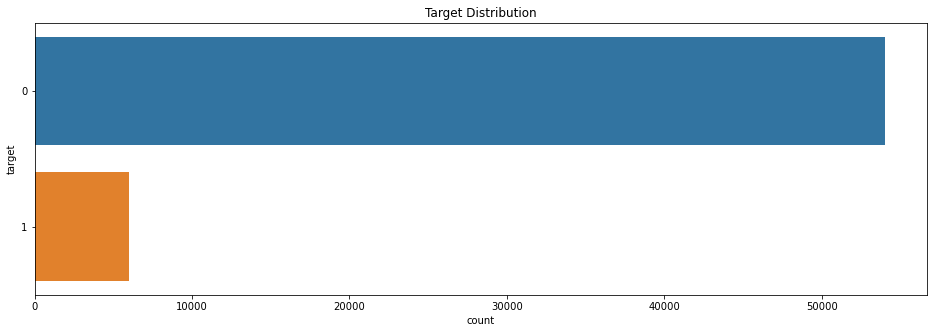

In [6]:
plt.figure(figsize=(16, 5))
sn.countplot(y="target", data=df_train)
plt.title("Target Distribution");
print(len(df_train))

In [7]:
class ClassificationDataset:
    
    def __init__(self, image_paths, targets, augment=False): 
        self.image_paths = image_paths
        self.targets = targets
        self.augment = augment

    def __len__(self):
        return len(self.image_paths)
    
    def __getitem__(self, item):      
        image = np.load(self.image_paths[item]).astype(float)
        
        targets = self.targets[item]
        
        if self.augment:
            image = np.vstack(image).transpose((1, 0))
            
            img_pl = Image.fromarray(image).resize((512, 512), resample=Image.BICUBIC)
            image = np.array(img_pl)
                
        return {
            "image": torch.tensor(image, dtype=torch.float) if not self.augment else torch.from_numpy(image).unsqueeze(dim=0),
            "targets": torch.tensor(targets, dtype=torch.long),
        }

In [8]:
class enetv2(nn.Module):
    def __init__(self, backbone, pretrained=False, out_dim=1):
        super(enetv2, self).__init__()
        self.enet = enet.EfficientNet.from_name(backbone)
        if pretrained:
            self.enet.load_state_dict(torch.load(pretrained_model[backbone]))
        self.myfc = nn.Linear(self.enet._fc.in_features, out_dim)
        self.enet._fc = nn.Identity()
        self.conv1 = nn.Conv2d(6, 3, kernel_size=3, stride=1, padding=3, bias=False)
        self.conv1Norm = nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=3, bias=False)
        self.poolNorm = nn.MaxPool2d(2, 2)
        self.conv2Norm = nn.Conv2d(32, 3, kernel_size=3, bias=False)

    def extract(self, x):
        return self.enet(x)

    def forward(self, x):
        flag = x[0][0].shape == (512, 512)
        if flag:
            x = self.conv1Norm(x)
            x = self.poolNorm(x)
            x = self.conv2Norm(x)
        else:
            x = self.conv1(x)
        x = self.extract(x)
        x = self.myfc(x)
        return x

In [9]:
def train(data_loader, model, optimizer, device):
    
    model.train() # Sets to train mode
    running_loss = 0
    loss_sum = 0
    i = 0
    
    for data in tqdm(data_loader, position=0, leave=True, desc='Training'):
        i += 1
        inputs = data["image"]
        targets = data['targets']
        
        # Cast
        inputs = inputs.to(device, dtype=torch.float)
        targets = targets.to(device, dtype=torch.float)
        
        optimizer.zero_grad() # Gradient Descent
        outputs = model(inputs) # Output Weights
        loss = nn.BCEWithLogitsLoss()(outputs, targets.view(-1, 1)) # Loss-Berechnung: BCE-Loss + Sigmoid
        loss.backward()
        optimizer.step()
        
        loss_sum += loss.item()
        running_loss += loss.item()
        if i % 100 == 99: # print every 2000 minibatches
            print('[%5d] loss: %.3f' %
                  (i + 1, running_loss / 2000))
            running_loss = 0.0
        
    return loss_sum
        
def evaluate(data_loader, model, device):
    model.eval() # Sets to evaluation mode
    
    final_targets = []
    final_outputs = []
    
    with torch.no_grad():
        loss_sum = 0
        
        for data in tqdm(data_loader, position=0, leave=True, desc='Evaluating'):
            inputs = data["image"]
            targets = data["targets"]
            inputs = inputs.to(device, dtype=torch.float)
            targets = targets.to(device, dtype=torch.float)
            
            output = model(inputs)
            
            loss_sum += nn.BCEWithLogitsLoss()(output, targets.view(-1, 1)).item()
            
            targets = targets.detach().cpu().numpy().tolist()
            output = output.detach().cpu().numpy().tolist()
            
            final_targets.extend(targets)
            final_outputs.extend(output)
            
    return final_outputs, final_targets, loss_sum

In [10]:
baseline_name = ['efficientnet-b1', 'efficientnet-b3'] # Die Architektur bzw. das Netz? Warum ausgerechnet das?
pretrained_model = {
    baseline_name[0]: './checkpoint/efficientnet-b1-dbc7070a.pth', # Checkpoint?
    baseline_name[1]: './checkpoint/efficientnet-b3-c8376fa2.pth'
}
models = []
device = "cuda"
Batch_Size = 16
X = df_train.img_path.values
Y = df_train.target.values
skf = StratifiedKFold(n_splits=5) # Cross Validation 5-fold, mehrschichtig (stratified)
# -> https://scikit-learn.org/stable/auto_examples/model_selection/plot_cv_indices.html#sphx-glr-auto-examples-model-selection-plot-cv-indices-py)

starter_models = [enetv2(baseline_name[0], pretrained=True, out_dim=1), enetv2(baseline_name[0], pretrained=True, out_dim=1),
                  enetv2(baseline_name[1], pretrained=True, out_dim=1), enetv2(baseline_name[1], pretrained=True, out_dim=1)]

names = ['efficientnet-b1-pretrained', 'efficientnet-b1-pretrained-augment',
         'efficientnet-b3-pretrained', 'efficientnet-b3-pretrained-augment']

epochs = 5
#epochs = [[0 for i in range(5)] for i in names]
train_losses = [[[] for i in range(5)] for i in names]
valid_losses = [[[] for i in range(5)] for i in names]
aurocs = [[[] for i in range(5)] for i in names]

it = 0
train_losses

[[[], [], [], [], []],
 [[], [], [], [], []],
 [[], [], [], [], []],
 [[], [], [], [], []]]

In [11]:
#create log file
codecs.open('log2.log', 'w+');

In [12]:
for model in starter_models:
    fold = 0
    for train_index, test_index in skf.split(X, Y):
        #train_images, valid_images, train_targets, valid_targets = train_test_split(X, Y, random_state=2021)
        #model = enetv2(baseline_name, out_dim=1)
        starter_models = [enetv2(baseline_name[0], pretrained=True, out_dim=1), enetv2(baseline_name[0], pretrained=True, out_dim=1),
                          enetv2(baseline_name[1], pretrained=True, out_dim=1), enetv2(baseline_name[1], pretrained=True, out_dim=1)]
        
        model = starter_models[it]
        model.to(device)

        train_images, valid_images = X[train_index], X[test_index]
        train_targets, valid_targets = Y[train_index], Y[test_index]

        train_dataset = ClassificationDataset(image_paths=train_images, targets=train_targets, augment=it%2!=0)
        valid_dataset = ClassificationDataset(image_paths=valid_images, targets=valid_targets, augment=it%2!=0)
        train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=Batch_Size,shuffle=True, num_workers=4)
        valid_loader = torch.utils.data.DataLoader(valid_dataset, batch_size=Batch_Size,shuffle=False, num_workers=4)

        optimizer = torch.optim.Adam(model.parameters(), lr=5e-4)
        
        row = 0
        last_loss = 0
        train_loss = 10
        
        best_roc_auc = 0
        
        for epoch in range(epochs):
            if epoch == 3:
                for param_group in optimizer.param_groups:
                    param_group["lr"] = 1e-4
            if epoch == 4:
                for param_group in optimizer.param_groups:
                    param_group["lr"] = 1e-6
                    
            train_loss = train(train_loader, model, optimizer, device=device)
            predictions, valid_targets, valid_loss = evaluate(valid_loader, model, device=device)
            roc_auc = metrics.roc_auc_score(valid_targets, predictions)
            
            train_losses[it][fold].append(train_loss) 
            valid_losses[it][fold].append(valid_loss)
            aurocs[it][fold].append(roc_auc)
            
            if roc_auc > best_roc_auc:
                best_roc_auc = roc_auc

            print(f"Fold {fold}: Epoch={epoch}, Train Loss={train_loss}, Validation Loss={valid_loss}, Validation ROC AUC={roc_auc}")
            with codecs.open('log.log', 'a') as up:
                up.write(f"Fold={fold}, Epoch={epoch}, Valid ROC AUC={roc_auc}/{best_roc_auc}\n")

            if roc_auc > best_roc_auc:        
                torch.save(model.state_dict(), baseline_name + '-' + str(fold) + '-' + str(epoch) + '.pt')
                best_roc_auc = roc_auc

        #torch.save(model.state_dict(), names[it] + '-' + str(it) + '.pt')
        models.append(model)
        fold += 1
    it += 1
    
print('finished')
it = 0

Training:   3%|█                             | 100/3000 [00:15<07:11,  6.72it/s]

[  100] loss: 0.018


Training:   7%|██                            | 200/3000 [00:30<06:52,  6.79it/s]

[  200] loss: 0.018


Training:  10%|███                           | 300/3000 [00:44<06:21,  7.08it/s]

[  300] loss: 0.014


Training:  13%|████                          | 400/3000 [01:00<06:50,  6.34it/s]

[  400] loss: 0.018


Training:  17%|█████                         | 500/3000 [01:16<06:16,  6.64it/s]

[  500] loss: 0.016


Training:  20%|██████                        | 600/3000 [01:31<05:42,  7.00it/s]

[  600] loss: 0.017


Training:  23%|███████                       | 700/3000 [01:46<05:50,  6.55it/s]

[  700] loss: 0.018


Training:  27%|████████                      | 800/3000 [02:01<05:28,  6.69it/s]

[  800] loss: 0.016


Training:  30%|█████████                     | 900/3000 [02:16<05:00,  6.98it/s]

[  900] loss: 0.015


Training:  33%|█████████▋                   | 1000/3000 [02:30<05:00,  6.66it/s]

[ 1000] loss: 0.017


Training:  37%|██████████▋                  | 1100/3000 [02:45<04:39,  6.79it/s]

[ 1100] loss: 0.017


Training:  40%|███████████▌                 | 1200/3000 [03:00<04:28,  6.71it/s]

[ 1200] loss: 0.017


Training:  43%|████████████▌                | 1300/3000 [03:15<04:09,  6.81it/s]

[ 1300] loss: 0.015


Training:  47%|█████████████▌               | 1400/3000 [03:30<03:58,  6.70it/s]

[ 1400] loss: 0.017


Training:  50%|██████████████▌              | 1500/3000 [03:45<03:40,  6.81it/s]

[ 1500] loss: 0.016


Training:  53%|███████████████▍             | 1600/3000 [04:00<03:32,  6.59it/s]

[ 1600] loss: 0.017


Training:  57%|████████████████▍            | 1700/3000 [04:15<03:14,  6.68it/s]

[ 1700] loss: 0.015


Training:  60%|█████████████████▍           | 1800/3000 [04:30<02:53,  6.92it/s]

[ 1800] loss: 0.015


Training:  63%|██████████████████▎          | 1900/3000 [04:45<02:42,  6.78it/s]

[ 1900] loss: 0.014


Training:  67%|███████████████████▎         | 2000/3000 [04:59<02:24,  6.91it/s]

[ 2000] loss: 0.014


Training:  70%|████████████████████▎        | 2100/3000 [05:15<02:14,  6.67it/s]

[ 2100] loss: 0.014


Training:  73%|█████████████████████▎       | 2200/3000 [05:30<01:59,  6.67it/s]

[ 2200] loss: 0.014


Training:  77%|██████████████████████▏      | 2300/3000 [05:45<01:43,  6.76it/s]

[ 2300] loss: 0.015


Training:  80%|███████████████████████▏     | 2400/3000 [06:00<01:31,  6.53it/s]

[ 2400] loss: 0.015


Training:  83%|████████████████████████▏    | 2500/3000 [06:15<01:13,  6.84it/s]

[ 2500] loss: 0.014


Training:  87%|█████████████████████████▏   | 2600/3000 [06:30<00:58,  6.85it/s]

[ 2600] loss: 0.014


Training:  90%|██████████████████████████   | 2700/3000 [06:45<00:45,  6.57it/s]

[ 2700] loss: 0.014


Training:  93%|███████████████████████████  | 2800/3000 [07:00<00:30,  6.58it/s]

[ 2800] loss: 0.013


Training:  97%|████████████████████████████ | 2900/3000 [07:15<00:14,  6.76it/s]

[ 2900] loss: 0.013


Training: 100%|█████████████████████████████| 3000/3000 [07:30<00:00,  6.70it/s]

[ 3000] loss: 0.012


Evaluating: 100%|█████████████████████████████| 750/750 [00:28<00:00, 26.69it/s]


Fold 0: Epoch=0, Train Loss=929.3371700793505, Validation Loss=200.36731385812163, Validation ROC AUC=0.7247481867283951


Training:   3%|█                             | 100/3000 [00:15<07:08,  6.76it/s]

[  100] loss: 0.014


Training:   7%|██                            | 200/3000 [00:30<06:59,  6.67it/s]

[  200] loss: 0.014


Training:  10%|███                           | 300/3000 [00:45<06:30,  6.92it/s]

[  300] loss: 0.013


Training:  13%|████                          | 400/3000 [01:00<06:25,  6.74it/s]

[  400] loss: 0.015


Training:  17%|█████                         | 500/3000 [01:15<06:08,  6.79it/s]

[  500] loss: 0.012


Training:  20%|██████                        | 600/3000 [01:30<05:58,  6.69it/s]

[  600] loss: 0.015


Training:  23%|███████                       | 700/3000 [01:45<05:48,  6.60it/s]

[  700] loss: 0.013


Training:  27%|████████                      | 800/3000 [02:00<05:21,  6.85it/s]

[  800] loss: 0.014


Training:  30%|█████████                     | 900/3000 [02:15<05:01,  6.97it/s]

[  900] loss: 0.013


Training:  33%|█████████▋                   | 1000/3000 [02:29<04:51,  6.87it/s]

[ 1000] loss: 0.013


Training:  37%|██████████▋                  | 1100/3000 [02:44<04:43,  6.70it/s]

[ 1100] loss: 0.015


Training:  40%|███████████▌                 | 1200/3000 [02:59<04:31,  6.64it/s]

[ 1200] loss: 0.012


Training:  43%|████████████▌                | 1300/3000 [03:15<04:12,  6.72it/s]

[ 1300] loss: 0.013


Training:  47%|█████████████▌               | 1400/3000 [03:29<03:59,  6.67it/s]

[ 1400] loss: 0.014


Training:  50%|██████████████▌              | 1500/3000 [03:44<03:37,  6.88it/s]

[ 1500] loss: 0.012


Training:  53%|███████████████▍             | 1600/3000 [03:59<03:28,  6.71it/s]

[ 1600] loss: 0.012


Training:  57%|████████████████▍            | 1700/3000 [04:14<03:14,  6.68it/s]

[ 1700] loss: 0.012


Training:  60%|█████████████████▍           | 1800/3000 [04:29<03:00,  6.65it/s]

[ 1800] loss: 0.014


Training:  63%|██████████████████▎          | 1900/3000 [04:44<02:43,  6.74it/s]

[ 1900] loss: 0.013


Training:  67%|███████████████████▎         | 2000/3000 [04:59<02:30,  6.66it/s]

[ 2000] loss: 0.012


Training:  70%|████████████████████▎        | 2100/3000 [05:14<02:14,  6.69it/s]

[ 2100] loss: 0.012


Training:  73%|█████████████████████▎       | 2200/3000 [05:29<01:58,  6.73it/s]

[ 2200] loss: 0.013


Training:  77%|██████████████████████▏      | 2300/3000 [05:44<01:40,  6.95it/s]

[ 2300] loss: 0.013


Training:  80%|███████████████████████▏     | 2400/3000 [05:59<01:29,  6.71it/s]

[ 2400] loss: 0.011


Training:  83%|████████████████████████▏    | 2500/3000 [06:14<01:15,  6.63it/s]

[ 2500] loss: 0.012


Training:  87%|█████████████████████████▏   | 2600/3000 [06:29<01:00,  6.65it/s]

[ 2600] loss: 0.013


Training:  90%|██████████████████████████   | 2700/3000 [06:44<00:44,  6.76it/s]

[ 2700] loss: 0.012


Training:  93%|███████████████████████████  | 2800/3000 [06:59<00:29,  6.80it/s]

[ 2800] loss: 0.014


Training:  97%|████████████████████████████ | 2900/3000 [07:14<00:14,  6.70it/s]

[ 2900] loss: 0.012


Training: 100%|█████████████████████████████| 3000/3000 [07:29<00:00,  6.70it/s]

[ 3000] loss: 0.014


Evaluating: 100%|█████████████████████████████| 750/750 [00:28<00:00, 26.16it/s]


Fold 0: Epoch=1, Train Loss=783.1580243520439, Validation Loss=188.52353398874402, Validation ROC AUC=0.7545548996913581


Training:   3%|█                             | 100/3000 [00:15<07:16,  6.64it/s]

[  100] loss: 0.012


Training:   7%|██                            | 200/3000 [00:30<07:04,  6.59it/s]

[  200] loss: 0.013


Training:  10%|███                           | 300/3000 [00:45<06:42,  6.70it/s]

[  300] loss: 0.012


Training:  13%|████                          | 400/3000 [01:00<06:40,  6.49it/s]

[  400] loss: 0.011


Training:  17%|█████                         | 500/3000 [01:15<06:11,  6.73it/s]

[  500] loss: 0.014


Training:  20%|██████                        | 600/3000 [01:29<05:56,  6.73it/s]

[  600] loss: 0.013


Training:  23%|███████                       | 700/3000 [01:44<05:48,  6.60it/s]

[  700] loss: 0.013


Training:  27%|████████                      | 800/3000 [01:59<05:27,  6.72it/s]

[  800] loss: 0.012


Training:  30%|█████████                     | 900/3000 [02:14<05:05,  6.87it/s]

[  900] loss: 0.012


Training:  33%|█████████▋                   | 1000/3000 [02:29<04:57,  6.73it/s]

[ 1000] loss: 0.011


Training:  37%|██████████▋                  | 1100/3000 [02:44<04:41,  6.74it/s]

[ 1100] loss: 0.011


Training:  40%|███████████▌                 | 1200/3000 [02:59<04:26,  6.75it/s]

[ 1200] loss: 0.013


Training:  43%|████████████▌                | 1300/3000 [03:14<04:11,  6.76it/s]

[ 1300] loss: 0.011


Training:  47%|█████████████▌               | 1400/3000 [03:29<03:48,  7.00it/s]

[ 1400] loss: 0.012


Training:  50%|██████████████▌              | 1500/3000 [03:44<03:39,  6.82it/s]

[ 1500] loss: 0.013


Training:  53%|███████████████▍             | 1600/3000 [03:59<03:31,  6.62it/s]

[ 1600] loss: 0.013


Training:  57%|████████████████▍            | 1700/3000 [04:14<03:16,  6.63it/s]

[ 1700] loss: 0.012


Training:  60%|█████████████████▍           | 1800/3000 [04:29<02:59,  6.68it/s]

[ 1800] loss: 0.013


Training:  63%|██████████████████▎          | 1900/3000 [04:44<02:48,  6.54it/s]

[ 1900] loss: 0.013


Training:  67%|███████████████████▎         | 2000/3000 [04:59<02:33,  6.52it/s]

[ 2000] loss: 0.014


Training:  70%|████████████████████▎        | 2100/3000 [05:14<02:16,  6.57it/s]

[ 2100] loss: 0.012


Training:  73%|█████████████████████▎       | 2200/3000 [05:29<02:00,  6.66it/s]

[ 2200] loss: 0.013


Training:  77%|██████████████████████▏      | 2300/3000 [05:44<01:44,  6.73it/s]

[ 2300] loss: 0.013


Training:  80%|███████████████████████▏     | 2400/3000 [05:59<01:30,  6.60it/s]

[ 2400] loss: 0.013


Training:  83%|████████████████████████▏    | 2500/3000 [06:14<01:13,  6.78it/s]

[ 2500] loss: 0.013


Training:  87%|█████████████████████████▏   | 2600/3000 [06:29<00:58,  6.82it/s]

[ 2600] loss: 0.011


Training:  90%|██████████████████████████   | 2700/3000 [06:44<00:43,  6.97it/s]

[ 2700] loss: 0.011


Training:  93%|███████████████████████████  | 2800/3000 [06:59<00:28,  6.95it/s]

[ 2800] loss: 0.013


Training:  97%|████████████████████████████ | 2900/3000 [07:14<00:15,  6.52it/s]

[ 2900] loss: 0.013


Training: 100%|█████████████████████████████| 3000/3000 [07:29<00:00,  6.68it/s]

[ 3000] loss: 0.013


Evaluating: 100%|█████████████████████████████| 750/750 [00:28<00:00, 26.53it/s]


Fold 0: Epoch=2, Train Loss=742.8398879617453, Validation Loss=183.0215899758041, Validation ROC AUC=0.7552266203703704


Training:   3%|█                             | 100/3000 [00:15<07:33,  6.39it/s]

[  100] loss: 0.012


Training:   7%|██                            | 200/3000 [00:30<06:38,  7.02it/s]

[  200] loss: 0.014


Training:  10%|███                           | 300/3000 [00:45<06:42,  6.71it/s]

[  300] loss: 0.011


Training:  13%|████                          | 400/3000 [01:00<06:33,  6.60it/s]

[  400] loss: 0.011


Training:  17%|█████                         | 500/3000 [01:15<06:17,  6.63it/s]

[  500] loss: 0.012


Training:  20%|██████                        | 600/3000 [01:30<05:56,  6.74it/s]

[  600] loss: 0.011


Training:  23%|███████                       | 700/3000 [01:45<05:51,  6.55it/s]

[  700] loss: 0.011


Training:  27%|████████                      | 800/3000 [02:00<05:25,  6.76it/s]

[  800] loss: 0.012


Training:  30%|█████████                     | 900/3000 [02:16<05:34,  6.28it/s]

[  900] loss: 0.012


Training:  33%|█████████▋                   | 1000/3000 [02:31<04:56,  6.74it/s]

[ 1000] loss: 0.012


Training:  37%|██████████▋                  | 1100/3000 [02:45<04:34,  6.91it/s]

[ 1100] loss: 0.012


Training:  40%|███████████▌                 | 1200/3000 [03:00<04:30,  6.66it/s]

[ 1200] loss: 0.011


Training:  43%|████████████▌                | 1300/3000 [03:15<04:15,  6.64it/s]

[ 1300] loss: 0.011


Training:  47%|█████████████▌               | 1400/3000 [03:30<03:56,  6.75it/s]

[ 1400] loss: 0.012


Training:  50%|██████████████▌              | 1500/3000 [03:45<03:40,  6.79it/s]

[ 1500] loss: 0.012


Training:  53%|███████████████▍             | 1600/3000 [04:00<03:36,  6.47it/s]

[ 1600] loss: 0.012


Training:  57%|████████████████▍            | 1700/3000 [04:15<03:13,  6.73it/s]

[ 1700] loss: 0.011


Training:  60%|█████████████████▍           | 1800/3000 [04:30<03:01,  6.59it/s]

[ 1800] loss: 0.010


Training:  63%|██████████████████▎          | 1900/3000 [04:45<02:43,  6.71it/s]

[ 1900] loss: 0.011


Training:  67%|███████████████████▎         | 2000/3000 [05:00<02:37,  6.35it/s]

[ 2000] loss: 0.011


Training:  70%|████████████████████▎        | 2100/3000 [05:15<02:08,  7.00it/s]

[ 2100] loss: 0.010


Training:  73%|█████████████████████▎       | 2200/3000 [05:30<02:00,  6.66it/s]

[ 2200] loss: 0.012


Training:  77%|██████████████████████▏      | 2300/3000 [05:45<01:47,  6.53it/s]

[ 2300] loss: 0.010


Training:  80%|███████████████████████▏     | 2400/3000 [06:00<01:30,  6.61it/s]

[ 2400] loss: 0.011


Training:  83%|████████████████████████▏    | 2500/3000 [06:15<01:13,  6.78it/s]

[ 2500] loss: 0.011


Training:  87%|█████████████████████████▏   | 2600/3000 [06:30<00:59,  6.72it/s]

[ 2600] loss: 0.010


Training:  90%|██████████████████████████   | 2700/3000 [06:45<00:45,  6.58it/s]

[ 2700] loss: 0.013


Training:  93%|███████████████████████████  | 2800/3000 [07:00<00:32,  6.25it/s]

[ 2800] loss: 0.011


Training:  97%|████████████████████████████ | 2900/3000 [07:16<00:15,  6.59it/s]

[ 2900] loss: 0.010


Training: 100%|█████████████████████████████| 3000/3000 [07:31<00:00,  6.72it/s]

[ 3000] loss: 0.010


Evaluating: 100%|█████████████████████████████| 750/750 [00:28<00:00, 26.29it/s]


Fold 0: Epoch=3, Train Loss=679.260005377233, Validation Loss=176.22218454629183, Validation ROC AUC=0.779373225308642


Training:   3%|█                             | 100/3000 [00:15<07:00,  6.90it/s]

[  100] loss: 0.011


Training:   7%|██                            | 200/3000 [00:30<07:00,  6.66it/s]

[  200] loss: 0.013


Training:  10%|███                           | 300/3000 [00:45<06:39,  6.75it/s]

[  300] loss: 0.010


Training:  13%|████                          | 400/3000 [01:00<06:24,  6.77it/s]

[  400] loss: 0.013


Training:  17%|█████                         | 500/3000 [01:15<06:09,  6.77it/s]

[  500] loss: 0.010


Training:  20%|██████                        | 600/3000 [01:30<06:03,  6.60it/s]

[  600] loss: 0.012


Training:  23%|███████                       | 700/3000 [01:45<05:56,  6.45it/s]

[  700] loss: 0.010


Training:  27%|████████                      | 800/3000 [02:00<05:39,  6.48it/s]

[  800] loss: 0.011


Training:  30%|█████████                     | 900/3000 [02:15<05:13,  6.69it/s]

[  900] loss: 0.011


Training:  33%|█████████▋                   | 1000/3000 [02:30<04:52,  6.85it/s]

[ 1000] loss: 0.010


Training:  37%|██████████▋                  | 1100/3000 [02:45<04:44,  6.67it/s]

[ 1100] loss: 0.010


Training:  40%|███████████▌                 | 1200/3000 [03:00<04:33,  6.59it/s]

[ 1200] loss: 0.012


Training:  43%|████████████▌                | 1300/3000 [03:15<04:15,  6.64it/s]

[ 1300] loss: 0.010


Training:  47%|█████████████▌               | 1400/3000 [03:30<04:01,  6.61it/s]

[ 1400] loss: 0.012


Training:  50%|██████████████▌              | 1500/3000 [03:45<03:46,  6.63it/s]

[ 1500] loss: 0.011


Training:  53%|███████████████▍             | 1600/3000 [04:00<03:43,  6.25it/s]

[ 1600] loss: 0.011


Training:  57%|████████████████▍            | 1700/3000 [04:15<03:15,  6.66it/s]

[ 1700] loss: 0.010


Training:  60%|█████████████████▍           | 1800/3000 [04:30<02:56,  6.80it/s]

[ 1800] loss: 0.010


Training:  63%|██████████████████▎          | 1900/3000 [04:45<02:42,  6.76it/s]

[ 1900] loss: 0.009


Training:  67%|███████████████████▎         | 2000/3000 [05:00<02:34,  6.49it/s]

[ 2000] loss: 0.011


Training:  70%|████████████████████▎        | 2100/3000 [05:15<02:09,  6.97it/s]

[ 2100] loss: 0.012


Training:  73%|█████████████████████▎       | 2200/3000 [05:30<01:59,  6.70it/s]

[ 2200] loss: 0.009


Training:  77%|██████████████████████▏      | 2300/3000 [05:45<01:46,  6.60it/s]

[ 2300] loss: 0.011


Training:  80%|███████████████████████▏     | 2400/3000 [06:00<01:30,  6.64it/s]

[ 2400] loss: 0.010


Training:  83%|████████████████████████▏    | 2500/3000 [06:15<01:15,  6.63it/s]

[ 2500] loss: 0.012


Training:  87%|█████████████████████████▏   | 2600/3000 [06:30<01:01,  6.54it/s]

[ 2600] loss: 0.012


Training:  90%|██████████████████████████   | 2700/3000 [06:45<00:45,  6.62it/s]

[ 2700] loss: 0.009


Training:  93%|███████████████████████████  | 2800/3000 [07:00<00:29,  6.75it/s]

[ 2800] loss: 0.011


Training:  97%|████████████████████████████ | 2900/3000 [07:14<00:14,  6.80it/s]

[ 2900] loss: 0.011


Training: 100%|█████████████████████████████| 3000/3000 [07:29<00:00,  6.73it/s]

[ 3000] loss: 0.011


Evaluating: 100%|█████████████████████████████| 750/750 [00:28<00:00, 26.33it/s]


Fold 0: Epoch=4, Train Loss=651.9914692826569, Validation Loss=175.29084410890937, Validation ROC AUC=0.7796134259259258


Training:   3%|█                             | 100/3000 [00:15<07:17,  6.62it/s]

[  100] loss: 0.020


Training:   7%|██                            | 200/3000 [00:29<06:38,  7.02it/s]

[  200] loss: 0.017


Training:  10%|███                           | 300/3000 [00:45<06:54,  6.52it/s]

[  300] loss: 0.017


Training:  13%|████                          | 400/3000 [01:00<06:47,  6.38it/s]

[  400] loss: 0.016


Training:  17%|█████                         | 500/3000 [01:16<06:20,  6.57it/s]

[  500] loss: 0.017


Training:  20%|██████                        | 600/3000 [01:31<05:59,  6.67it/s]

[  600] loss: 0.015


Training:  23%|███████                       | 700/3000 [01:46<05:43,  6.69it/s]

[  700] loss: 0.016


Training:  27%|████████                      | 800/3000 [02:01<05:42,  6.42it/s]

[  800] loss: 0.016


Training:  30%|█████████                     | 900/3000 [02:16<05:09,  6.79it/s]

[  900] loss: 0.016


Training:  33%|█████████▋                   | 1000/3000 [02:31<04:52,  6.84it/s]

[ 1000] loss: 0.017


Training:  37%|██████████▋                  | 1100/3000 [02:46<04:50,  6.53it/s]

[ 1100] loss: 0.017


Training:  40%|███████████▌                 | 1200/3000 [03:01<04:30,  6.65it/s]

[ 1200] loss: 0.016


Training:  43%|████████████▌                | 1300/3000 [03:16<04:02,  7.01it/s]

[ 1300] loss: 0.019


Training:  47%|█████████████▌               | 1400/3000 [03:31<03:58,  6.71it/s]

[ 1400] loss: 0.016


Training:  50%|██████████████▌              | 1500/3000 [03:46<03:34,  6.98it/s]

[ 1500] loss: 0.015


Training:  53%|███████████████▍             | 1600/3000 [04:01<03:25,  6.81it/s]

[ 1600] loss: 0.015


Training:  57%|████████████████▍            | 1700/3000 [04:15<03:11,  6.78it/s]

[ 1700] loss: 0.016


Training:  60%|█████████████████▍           | 1800/3000 [04:31<02:58,  6.73it/s]

[ 1800] loss: 0.017


Training:  63%|██████████████████▎          | 1900/3000 [04:45<02:46,  6.59it/s]

[ 1900] loss: 0.015


Training:  67%|███████████████████▎         | 2000/3000 [05:00<02:26,  6.81it/s]

[ 2000] loss: 0.016


Training:  70%|████████████████████▎        | 2100/3000 [05:16<02:15,  6.63it/s]

[ 2100] loss: 0.016


Training:  73%|█████████████████████▎       | 2200/3000 [05:31<01:57,  6.82it/s]

[ 2200] loss: 0.016


Training:  77%|██████████████████████▏      | 2300/3000 [05:46<01:43,  6.77it/s]

[ 2300] loss: 0.014


Training:  80%|███████████████████████▏     | 2400/3000 [06:01<01:30,  6.59it/s]

[ 2400] loss: 0.016


Training:  83%|████████████████████████▏    | 2500/3000 [06:16<01:14,  6.68it/s]

[ 2500] loss: 0.017


Training:  87%|█████████████████████████▏   | 2600/3000 [06:31<00:59,  6.67it/s]

[ 2600] loss: 0.016


Training:  90%|██████████████████████████   | 2700/3000 [06:46<00:46,  6.48it/s]

[ 2700] loss: 0.017


Training:  93%|███████████████████████████  | 2800/3000 [07:01<00:29,  6.79it/s]

[ 2800] loss: 0.017


Training:  97%|████████████████████████████ | 2900/3000 [07:16<00:14,  6.83it/s]

[ 2900] loss: 0.017


Training: 100%|█████████████████████████████| 3000/3000 [07:31<00:00,  6.71it/s]

[ 3000] loss: 0.016


Evaluating: 100%|█████████████████████████████| 750/750 [00:28<00:00, 26.54it/s]


Fold 1: Epoch=0, Train Loss=990.9407948628068, Validation Loss=239.96428894251585, Validation ROC AUC=0.6319240740740741


Training:   3%|█                             | 100/3000 [00:15<07:15,  6.66it/s]

[  100] loss: 0.016


Training:   7%|██                            | 200/3000 [00:30<07:07,  6.54it/s]

[  200] loss: 0.016


Training:  10%|███                           | 300/3000 [00:45<06:39,  6.75it/s]

[  300] loss: 0.016


Training:  13%|████                          | 400/3000 [01:00<06:34,  6.59it/s]

[  400] loss: 0.015


Training:  17%|█████                         | 500/3000 [01:15<06:22,  6.54it/s]

[  500] loss: 0.014


Training:  20%|██████                        | 600/3000 [01:31<06:07,  6.53it/s]

[  600] loss: 0.015


Training:  23%|███████                       | 700/3000 [01:45<05:48,  6.59it/s]

[  700] loss: 0.015


Training:  27%|████████                      | 800/3000 [02:00<05:23,  6.80it/s]

[  800] loss: 0.016


Training:  30%|█████████                     | 900/3000 [02:15<05:17,  6.62it/s]

[  900] loss: 0.014


Training:  33%|█████████▋                   | 1000/3000 [02:30<05:07,  6.51it/s]

[ 1000] loss: 0.015


Training:  37%|██████████▋                  | 1100/3000 [02:45<04:52,  6.50it/s]

[ 1100] loss: 0.014


Training:  40%|███████████▌                 | 1200/3000 [03:01<04:44,  6.34it/s]

[ 1200] loss: 0.015


Training:  43%|████████████▌                | 1300/3000 [03:16<04:13,  6.71it/s]

[ 1300] loss: 0.015


Training:  47%|█████████████▌               | 1400/3000 [03:31<03:55,  6.78it/s]

[ 1400] loss: 0.014


Training:  50%|██████████████▌              | 1500/3000 [03:46<03:38,  6.86it/s]

[ 1500] loss: 0.014


Training:  53%|███████████████▍             | 1600/3000 [04:01<03:28,  6.72it/s]

[ 1600] loss: 0.014


Training:  57%|████████████████▍            | 1700/3000 [04:16<03:18,  6.56it/s]

[ 1700] loss: 0.013


Training:  60%|█████████████████▍           | 1800/3000 [04:31<03:00,  6.63it/s]

[ 1800] loss: 0.013


Training:  63%|██████████████████▎          | 1900/3000 [04:46<02:50,  6.47it/s]

[ 1900] loss: 0.014


Training:  67%|███████████████████▎         | 2000/3000 [05:01<02:32,  6.55it/s]

[ 2000] loss: 0.013


Training:  70%|████████████████████▎        | 2100/3000 [05:17<02:16,  6.62it/s]

[ 2100] loss: 0.012


Training:  73%|█████████████████████▎       | 2200/3000 [05:32<02:03,  6.49it/s]

[ 2200] loss: 0.013


Training:  77%|██████████████████████▏      | 2300/3000 [05:47<01:46,  6.57it/s]

[ 2300] loss: 0.013


Training:  80%|███████████████████████▏     | 2400/3000 [06:02<01:26,  6.95it/s]

[ 2400] loss: 0.014


Training:  83%|████████████████████████▏    | 2500/3000 [06:17<01:16,  6.54it/s]

[ 2500] loss: 0.012


Training:  87%|█████████████████████████▏   | 2600/3000 [06:32<01:00,  6.57it/s]

[ 2600] loss: 0.014


Training:  90%|██████████████████████████   | 2700/3000 [06:47<00:46,  6.43it/s]

[ 2700] loss: 0.013


Training:  93%|███████████████████████████  | 2800/3000 [07:02<00:30,  6.54it/s]

[ 2800] loss: 0.014


Training:  97%|████████████████████████████ | 2900/3000 [07:17<00:14,  6.75it/s]

[ 2900] loss: 0.013


Training: 100%|█████████████████████████████| 3000/3000 [07:32<00:00,  6.64it/s]

[ 3000] loss: 0.013


Evaluating: 100%|█████████████████████████████| 750/750 [00:28<00:00, 26.04it/s]


Fold 1: Epoch=1, Train Loss=845.0444027334452, Validation Loss=192.49092756211758, Validation ROC AUC=0.7512761574074074


Training:   3%|█                             | 100/3000 [00:15<07:30,  6.43it/s]

[  100] loss: 0.012


Training:   7%|██                            | 200/3000 [00:30<07:06,  6.57it/s]

[  200] loss: 0.013


Training:  10%|███                           | 300/3000 [00:46<07:04,  6.37it/s]

[  300] loss: 0.014


Training:  13%|████                          | 400/3000 [01:01<06:27,  6.71it/s]

[  400] loss: 0.013


Training:  17%|█████                         | 500/3000 [01:16<06:21,  6.56it/s]

[  500] loss: 0.014


Training:  20%|██████                        | 600/3000 [01:31<06:00,  6.65it/s]

[  600] loss: 0.014


Training:  23%|███████                       | 700/3000 [01:46<05:57,  6.44it/s]

[  700] loss: 0.012


Training:  27%|████████                      | 800/3000 [02:02<05:39,  6.48it/s]

[  800] loss: 0.011


Training:  30%|█████████                     | 900/3000 [02:17<05:12,  6.72it/s]

[  900] loss: 0.013


Training:  33%|█████████▋                   | 1000/3000 [02:31<05:02,  6.62it/s]

[ 1000] loss: 0.013


Training:  37%|██████████▋                  | 1100/3000 [02:46<04:48,  6.59it/s]

[ 1100] loss: 0.015


Training:  40%|███████████▌                 | 1200/3000 [03:01<04:23,  6.83it/s]

[ 1200] loss: 0.013


Training:  43%|████████████▌                | 1300/3000 [03:17<04:17,  6.61it/s]

[ 1300] loss: 0.012


Training:  47%|█████████████▌               | 1400/3000 [03:32<04:04,  6.55it/s]

[ 1400] loss: 0.013


Training:  50%|██████████████▌              | 1500/3000 [03:47<03:47,  6.60it/s]

[ 1500] loss: 0.013


Training:  53%|███████████████▍             | 1600/3000 [04:02<03:34,  6.52it/s]

[ 1600] loss: 0.013


Training:  57%|████████████████▍            | 1700/3000 [04:17<03:15,  6.63it/s]

[ 1700] loss: 0.012


Training:  60%|█████████████████▍           | 1800/3000 [04:32<03:04,  6.51it/s]

[ 1800] loss: 0.013


Training:  63%|██████████████████▎          | 1900/3000 [04:47<02:43,  6.74it/s]

[ 1900] loss: 0.013


Training:  67%|███████████████████▎         | 2000/3000 [05:03<02:38,  6.30it/s]

[ 2000] loss: 0.013


Training:  70%|████████████████████▎        | 2100/3000 [05:18<02:15,  6.62it/s]

[ 2100] loss: 0.012


Training:  73%|█████████████████████▎       | 2200/3000 [05:33<01:54,  7.01it/s]

[ 2200] loss: 0.013


Training:  77%|██████████████████████▏      | 2300/3000 [05:48<01:45,  6.62it/s]

[ 2300] loss: 0.012


Training:  80%|███████████████████████▏     | 2400/3000 [06:03<01:30,  6.64it/s]

[ 2400] loss: 0.012


Training:  83%|████████████████████████▏    | 2500/3000 [06:18<01:15,  6.61it/s]

[ 2500] loss: 0.012


Training:  87%|█████████████████████████▏   | 2600/3000 [06:34<01:00,  6.59it/s]

[ 2600] loss: 0.012


Training:  90%|██████████████████████████   | 2700/3000 [06:49<00:44,  6.69it/s]

[ 2700] loss: 0.012


Training:  93%|███████████████████████████  | 2800/3000 [07:04<00:30,  6.56it/s]

[ 2800] loss: 0.012


Training:  97%|████████████████████████████ | 2900/3000 [07:19<00:14,  6.75it/s]

[ 2900] loss: 0.013


Training: 100%|█████████████████████████████| 3000/3000 [07:34<00:00,  6.62it/s]

[ 3000] loss: 0.014


Evaluating: 100%|█████████████████████████████| 750/750 [00:28<00:00, 26.39it/s]


Fold 1: Epoch=2, Train Loss=772.4832478575408, Validation Loss=185.05010048672557, Validation ROC AUC=0.7460474151234567


Training:   3%|█                             | 100/3000 [00:15<07:19,  6.59it/s]

[  100] loss: 0.013


Training:   7%|██                            | 200/3000 [00:30<07:09,  6.52it/s]

[  200] loss: 0.011


Training:  10%|███                           | 300/3000 [00:45<06:35,  6.83it/s]

[  300] loss: 0.011


Training:  13%|████                          | 400/3000 [01:00<06:12,  6.99it/s]

[  400] loss: 0.013


Training:  17%|█████                         | 500/3000 [01:15<06:19,  6.58it/s]

[  500] loss: 0.013


Training:  20%|██████                        | 600/3000 [01:31<06:02,  6.63it/s]

[  600] loss: 0.012


Training:  23%|███████                       | 700/3000 [01:46<05:42,  6.72it/s]

[  700] loss: 0.013


Training:  27%|████████                      | 800/3000 [02:01<05:35,  6.56it/s]

[  800] loss: 0.012


Training:  30%|█████████                     | 900/3000 [02:16<05:28,  6.39it/s]

[  900] loss: 0.013


Training:  33%|█████████▋                   | 1000/3000 [02:32<05:02,  6.61it/s]

[ 1000] loss: 0.011


Training:  37%|██████████▋                  | 1100/3000 [02:47<04:44,  6.69it/s]

[ 1100] loss: 0.012


Training:  40%|███████████▌                 | 1200/3000 [03:02<04:25,  6.77it/s]

[ 1200] loss: 0.011


Training:  43%|████████████▌                | 1300/3000 [03:17<04:13,  6.70it/s]

[ 1300] loss: 0.009


Training:  47%|█████████████▌               | 1400/3000 [03:32<03:56,  6.77it/s]

[ 1400] loss: 0.013


Training:  50%|██████████████▌              | 1500/3000 [03:47<03:50,  6.50it/s]

[ 1500] loss: 0.013


Training:  53%|███████████████▍             | 1600/3000 [04:02<03:39,  6.39it/s]

[ 1600] loss: 0.011


Training:  57%|████████████████▍            | 1700/3000 [04:17<03:13,  6.70it/s]

[ 1700] loss: 0.012


Training:  60%|█████████████████▍           | 1800/3000 [04:32<03:02,  6.59it/s]

[ 1800] loss: 0.011


Training:  63%|██████████████████▎          | 1900/3000 [04:48<02:46,  6.61it/s]

[ 1900] loss: 0.012


Training:  67%|███████████████████▎         | 2000/3000 [05:03<02:27,  6.78it/s]

[ 2000] loss: 0.011


Training:  70%|████████████████████▎        | 2100/3000 [05:18<02:18,  6.50it/s]

[ 2100] loss: 0.014


Training:  73%|█████████████████████▎       | 2200/3000 [05:33<01:59,  6.67it/s]

[ 2200] loss: 0.012


Training:  77%|██████████████████████▏      | 2300/3000 [05:48<01:45,  6.61it/s]

[ 2300] loss: 0.010


Training:  80%|███████████████████████▏     | 2400/3000 [06:03<01:32,  6.48it/s]

[ 2400] loss: 0.012


Training:  83%|████████████████████████▏    | 2500/3000 [06:19<01:14,  6.75it/s]

[ 2500] loss: 0.012


Training:  87%|█████████████████████████▏   | 2600/3000 [06:33<00:59,  6.77it/s]

[ 2600] loss: 0.011


Training:  90%|██████████████████████████   | 2700/3000 [06:49<00:47,  6.38it/s]

[ 2700] loss: 0.012


Training:  93%|███████████████████████████  | 2800/3000 [07:04<00:30,  6.57it/s]

[ 2800] loss: 0.011


Training:  97%|████████████████████████████ | 2900/3000 [07:19<00:14,  6.93it/s]

[ 2900] loss: 0.010


Training: 100%|█████████████████████████████| 3000/3000 [07:34<00:00,  6.90it/s]

[ 3000] loss: 0.011


Evaluating: 100%|█████████████████████████████| 750/750 [00:28<00:00, 26.32it/s]


Fold 1: Epoch=3, Train Loss=706.6788899153471, Validation Loss=181.27229354530573, Validation ROC AUC=0.7636353009259259


Training:   3%|█                             | 100/3000 [00:15<07:21,  6.57it/s]

[  100] loss: 0.012


Training:   7%|██                            | 200/3000 [00:30<07:02,  6.63it/s]

[  200] loss: 0.011


Training:  10%|███                           | 300/3000 [00:45<06:26,  6.99it/s]

[  300] loss: 0.012


Training:  13%|████                          | 400/3000 [01:00<06:16,  6.90it/s]

[  400] loss: 0.011


Training:  17%|█████                         | 500/3000 [01:15<06:27,  6.45it/s]

[  500] loss: 0.011


Training:  20%|██████                        | 600/3000 [01:30<05:55,  6.75it/s]

[  600] loss: 0.011


Training:  23%|███████                       | 700/3000 [01:45<05:33,  6.90it/s]

[  700] loss: 0.010


Training:  27%|████████                      | 800/3000 [02:00<05:40,  6.47it/s]

[  800] loss: 0.012


Training:  30%|█████████                     | 900/3000 [02:15<05:19,  6.57it/s]

[  900] loss: 0.011


Training:  33%|█████████▋                   | 1000/3000 [02:30<05:06,  6.52it/s]

[ 1000] loss: 0.011


Training:  37%|██████████▋                  | 1100/3000 [02:46<04:45,  6.66it/s]

[ 1100] loss: 0.011


Training:  40%|███████████▌                 | 1200/3000 [03:01<04:35,  6.53it/s]

[ 1200] loss: 0.012


Training:  43%|████████████▌                | 1300/3000 [03:16<04:17,  6.61it/s]

[ 1300] loss: 0.012


Training:  47%|█████████████▌               | 1400/3000 [03:31<04:01,  6.62it/s]

[ 1400] loss: 0.012


Training:  50%|██████████████▌              | 1500/3000 [03:46<03:49,  6.55it/s]

[ 1500] loss: 0.011


Training:  53%|███████████████▍             | 1600/3000 [04:02<03:36,  6.47it/s]

[ 1600] loss: 0.010


Training:  57%|████████████████▍            | 1700/3000 [04:17<03:12,  6.77it/s]

[ 1700] loss: 0.011


Training:  60%|█████████████████▍           | 1800/3000 [04:32<03:02,  6.56it/s]

[ 1800] loss: 0.013


Training:  63%|██████████████████▎          | 1900/3000 [04:47<02:53,  6.32it/s]

[ 1900] loss: 0.010


Training:  67%|███████████████████▎         | 2000/3000 [05:02<02:29,  6.68it/s]

[ 2000] loss: 0.011


Training:  70%|████████████████████▎        | 2100/3000 [05:18<02:17,  6.54it/s]

[ 2100] loss: 0.011


Training:  73%|█████████████████████▎       | 2200/3000 [05:33<02:02,  6.51it/s]

[ 2200] loss: 0.012


Training:  77%|██████████████████████▏      | 2300/3000 [05:48<01:48,  6.46it/s]

[ 2300] loss: 0.012


Training:  80%|███████████████████████▏     | 2400/3000 [06:03<01:32,  6.49it/s]

[ 2400] loss: 0.011


Training:  83%|████████████████████████▏    | 2500/3000 [06:18<01:15,  6.63it/s]

[ 2500] loss: 0.011


Training:  87%|█████████████████████████▏   | 2600/3000 [06:33<01:01,  6.55it/s]

[ 2600] loss: 0.012


Training:  90%|██████████████████████████   | 2700/3000 [06:48<00:45,  6.56it/s]

[ 2700] loss: 0.011


Training:  93%|███████████████████████████  | 2800/3000 [07:03<00:30,  6.66it/s]

[ 2800] loss: 0.010


Training:  97%|████████████████████████████ | 2900/3000 [07:19<00:14,  6.74it/s]

[ 2900] loss: 0.012


Training: 100%|█████████████████████████████| 3000/3000 [07:34<00:00,  6.67it/s]

[ 3000] loss: 0.012


Evaluating: 100%|█████████████████████████████| 750/750 [00:28<00:00, 26.16it/s]


Fold 1: Epoch=4, Train Loss=681.5926788449287, Validation Loss=179.85619078576565, Validation ROC AUC=0.7649730709876543


Training:   3%|█                             | 100/3000 [00:15<07:12,  6.71it/s]

[  100] loss: 0.018


Training:   7%|██                            | 200/3000 [00:30<07:04,  6.59it/s]

[  200] loss: 0.017


Training:  10%|███                           | 300/3000 [00:45<07:10,  6.26it/s]

[  300] loss: 0.017


Training:  13%|████                          | 400/3000 [01:01<06:40,  6.50it/s]

[  400] loss: 0.018


Training:  17%|█████                         | 500/3000 [01:16<06:20,  6.57it/s]

[  500] loss: 0.017


Training:  20%|██████                        | 600/3000 [01:31<05:57,  6.71it/s]

[  600] loss: 0.015


Training:  23%|███████                       | 700/3000 [01:46<05:34,  6.88it/s]

[  700] loss: 0.016


Training:  27%|████████                      | 800/3000 [02:01<05:36,  6.54it/s]

[  800] loss: 0.016


Training:  30%|█████████                     | 900/3000 [02:17<05:23,  6.48it/s]

[  900] loss: 0.017


Training:  33%|█████████▋                   | 1000/3000 [02:32<05:02,  6.60it/s]

[ 1000] loss: 0.016


Training:  37%|██████████▋                  | 1100/3000 [02:47<04:32,  6.98it/s]

[ 1100] loss: 0.017


Training:  40%|███████████▌                 | 1200/3000 [03:02<04:28,  6.69it/s]

[ 1200] loss: 0.017


Training:  43%|████████████▌                | 1300/3000 [03:17<04:12,  6.73it/s]

[ 1300] loss: 0.017


Training:  47%|█████████████▌               | 1400/3000 [03:32<03:58,  6.70it/s]

[ 1400] loss: 0.016


Training:  50%|██████████████▌              | 1500/3000 [03:47<03:56,  6.35it/s]

[ 1500] loss: 0.017


Training:  53%|███████████████▍             | 1600/3000 [04:02<03:19,  7.01it/s]

[ 1600] loss: 0.017


Training:  57%|████████████████▍            | 1700/3000 [04:17<03:14,  6.69it/s]

[ 1700] loss: 0.017


Training:  60%|█████████████████▍           | 1800/3000 [04:33<03:05,  6.47it/s]

[ 1800] loss: 0.015


Training:  63%|██████████████████▎          | 1900/3000 [04:48<02:46,  6.59it/s]

[ 1900] loss: 0.016


Training:  67%|███████████████████▎         | 2000/3000 [05:03<02:23,  6.97it/s]

[ 2000] loss: 0.014


Training:  70%|████████████████████▎        | 2100/3000 [05:17<02:18,  6.51it/s]

[ 2100] loss: 0.016


Training:  73%|█████████████████████▎       | 2200/3000 [05:33<02:02,  6.51it/s]

[ 2200] loss: 0.014


Training:  77%|██████████████████████▏      | 2300/3000 [05:48<01:48,  6.47it/s]

[ 2300] loss: 0.015


Training:  80%|███████████████████████▏     | 2400/3000 [06:03<01:28,  6.79it/s]

[ 2400] loss: 0.015


Training:  83%|████████████████████████▏    | 2500/3000 [06:18<01:15,  6.60it/s]

[ 2500] loss: 0.014


Training:  87%|█████████████████████████▏   | 2600/3000 [06:33<01:01,  6.55it/s]

[ 2600] loss: 0.015


Training:  90%|██████████████████████████   | 2700/3000 [06:49<00:45,  6.58it/s]

[ 2700] loss: 0.012


Training:  93%|███████████████████████████  | 2800/3000 [07:04<00:30,  6.62it/s]

[ 2800] loss: 0.015


Training:  97%|████████████████████████████ | 2900/3000 [07:19<00:15,  6.61it/s]

[ 2900] loss: 0.014


Training: 100%|█████████████████████████████| 3000/3000 [07:34<00:00,  6.64it/s]

[ 3000] loss: 0.012


Evaluating: 100%|█████████████████████████████| 750/750 [00:28<00:00, 26.26it/s]


Fold 2: Epoch=0, Train Loss=948.1655592359602, Validation Loss=206.68991065770388, Validation ROC AUC=0.7060243441358025


Training:   3%|█                             | 100/3000 [00:15<07:23,  6.54it/s]

[  100] loss: 0.014


Training:   7%|██                            | 200/3000 [00:30<07:01,  6.64it/s]

[  200] loss: 0.013


Training:  10%|███                           | 300/3000 [00:45<06:53,  6.53it/s]

[  300] loss: 0.015


Training:  13%|████                          | 400/3000 [01:00<06:30,  6.65it/s]

[  400] loss: 0.012


Training:  17%|█████                         | 500/3000 [01:15<06:16,  6.64it/s]

[  500] loss: 0.014


Training:  20%|██████                        | 600/3000 [01:31<06:02,  6.62it/s]

[  600] loss: 0.014


Training:  23%|███████                       | 700/3000 [01:46<05:53,  6.51it/s]

[  700] loss: 0.013


Training:  27%|████████                      | 800/3000 [02:01<05:31,  6.63it/s]

[  800] loss: 0.013


Training:  30%|█████████                     | 900/3000 [02:16<05:22,  6.51it/s]

[  900] loss: 0.014


Training:  33%|█████████▋                   | 1000/3000 [02:31<05:05,  6.54it/s]

[ 1000] loss: 0.013


Training:  37%|██████████▋                  | 1100/3000 [02:46<04:53,  6.47it/s]

[ 1100] loss: 0.013


Training:  40%|███████████▌                 | 1200/3000 [03:02<04:17,  6.98it/s]

[ 1200] loss: 0.014


Training:  43%|████████████▌                | 1300/3000 [03:17<04:14,  6.67it/s]

[ 1300] loss: 0.012


Training:  47%|█████████████▌               | 1400/3000 [03:32<03:58,  6.71it/s]

[ 1400] loss: 0.013


Training:  50%|██████████████▌              | 1500/3000 [03:47<03:50,  6.51it/s]

[ 1500] loss: 0.014


Training:  53%|███████████████▍             | 1600/3000 [04:02<03:37,  6.43it/s]

[ 1600] loss: 0.013


Training:  57%|████████████████▍            | 1700/3000 [04:17<03:21,  6.45it/s]

[ 1700] loss: 0.012


Training:  60%|█████████████████▍           | 1800/3000 [04:33<02:58,  6.72it/s]

[ 1800] loss: 0.014


Training:  63%|██████████████████▎          | 1900/3000 [04:48<02:50,  6.45it/s]

[ 1900] loss: 0.012


Training:  67%|███████████████████▎         | 2000/3000 [05:03<02:29,  6.71it/s]

[ 2000] loss: 0.014


Training:  70%|████████████████████▎        | 2100/3000 [05:18<02:16,  6.58it/s]

[ 2100] loss: 0.014


Training:  73%|█████████████████████▎       | 2200/3000 [05:33<01:57,  6.84it/s]

[ 2200] loss: 0.013


Training:  77%|██████████████████████▏      | 2300/3000 [05:48<01:43,  6.76it/s]

[ 2300] loss: 0.013


Training:  80%|███████████████████████▏     | 2400/3000 [06:03<01:33,  6.42it/s]

[ 2400] loss: 0.013


Training:  83%|████████████████████████▏    | 2500/3000 [06:18<01:15,  6.59it/s]

[ 2500] loss: 0.014


Training:  87%|█████████████████████████▏   | 2600/3000 [06:33<01:00,  6.58it/s]

[ 2600] loss: 0.013


Training:  90%|██████████████████████████   | 2700/3000 [06:48<00:45,  6.53it/s]

[ 2700] loss: 0.013


Training:  93%|███████████████████████████  | 2800/3000 [07:03<00:30,  6.55it/s]

[ 2800] loss: 0.013


Training:  97%|████████████████████████████ | 2900/3000 [07:18<00:15,  6.36it/s]

[ 2900] loss: 0.012


Training: 100%|█████████████████████████████| 3000/3000 [07:33<00:00,  6.64it/s]

[ 3000] loss: 0.012


Evaluating: 100%|█████████████████████████████| 750/750 [00:29<00:00, 25.55it/s]


Fold 2: Epoch=1, Train Loss=792.978273101151, Validation Loss=190.9120142571628, Validation ROC AUC=0.7485533564814815


Training:   3%|█                             | 100/3000 [00:15<07:26,  6.49it/s]

[  100] loss: 0.012


Training:   7%|██                            | 200/3000 [00:30<07:06,  6.57it/s]

[  200] loss: 0.014


Training:  10%|███                           | 300/3000 [00:45<06:46,  6.64it/s]

[  300] loss: 0.013


Training:  13%|████                          | 400/3000 [01:00<06:29,  6.67it/s]

[  400] loss: 0.013


Training:  17%|█████                         | 500/3000 [01:16<06:00,  6.93it/s]

[  500] loss: 0.014


Training:  20%|██████                        | 600/3000 [01:31<06:07,  6.54it/s]

[  600] loss: 0.013


Training:  23%|███████                       | 700/3000 [01:46<05:30,  6.96it/s]

[  700] loss: 0.013


Training:  27%|████████                      | 800/3000 [02:01<05:37,  6.51it/s]

[  800] loss: 0.012


Training:  30%|█████████                     | 900/3000 [02:16<05:23,  6.49it/s]

[  900] loss: 0.012


Training:  33%|█████████▋                   | 1000/3000 [02:31<04:46,  6.98it/s]

[ 1000] loss: 0.013


Training:  37%|██████████▋                  | 1100/3000 [02:46<04:39,  6.81it/s]

[ 1100] loss: 0.013


Training:  40%|███████████▌                 | 1200/3000 [03:01<04:26,  6.75it/s]

[ 1200] loss: 0.012


Training:  43%|████████████▌                | 1300/3000 [03:16<04:15,  6.64it/s]

[ 1300] loss: 0.012


Training:  47%|█████████████▌               | 1400/3000 [03:31<04:00,  6.66it/s]

[ 1400] loss: 0.013


Training:  50%|██████████████▌              | 1500/3000 [03:46<03:49,  6.55it/s]

[ 1500] loss: 0.012


Training:  53%|███████████████▍             | 1600/3000 [04:01<03:24,  6.83it/s]

[ 1600] loss: 0.012


Training:  57%|████████████████▍            | 1700/3000 [04:16<03:14,  6.68it/s]

[ 1700] loss: 0.013


Training:  60%|█████████████████▍           | 1800/3000 [04:31<02:54,  6.89it/s]

[ 1800] loss: 0.012


Training:  63%|██████████████████▎          | 1900/3000 [04:47<02:55,  6.28it/s]

[ 1900] loss: 0.012


Training:  67%|███████████████████▎         | 2000/3000 [05:02<02:29,  6.70it/s]

[ 2000] loss: 0.012


Training:  70%|████████████████████▎        | 2100/3000 [05:17<02:11,  6.83it/s]

[ 2100] loss: 0.012


Training:  73%|█████████████████████▎       | 2200/3000 [05:32<01:56,  6.87it/s]

[ 2200] loss: 0.012


Training:  77%|██████████████████████▏      | 2300/3000 [05:47<01:46,  6.58it/s]

[ 2300] loss: 0.012


Training:  80%|███████████████████████▏     | 2400/3000 [06:02<01:31,  6.53it/s]

[ 2400] loss: 0.012


Training:  83%|████████████████████████▏    | 2500/3000 [06:17<01:13,  6.81it/s]

[ 2500] loss: 0.012


Training:  87%|█████████████████████████▏   | 2600/3000 [06:32<01:01,  6.47it/s]

[ 2600] loss: 0.013


Training:  90%|██████████████████████████   | 2700/3000 [06:48<00:45,  6.57it/s]

[ 2700] loss: 0.012


Training:  93%|███████████████████████████  | 2800/3000 [07:03<00:29,  6.67it/s]

[ 2800] loss: 0.012


Training:  97%|████████████████████████████ | 2900/3000 [07:18<00:15,  6.62it/s]

[ 2900] loss: 0.012


Training: 100%|█████████████████████████████| 3000/3000 [07:33<00:00,  6.68it/s]

[ 3000] loss: 0.011


Evaluating: 100%|█████████████████████████████| 750/750 [00:28<00:00, 26.28it/s]


Fold 2: Epoch=2, Train Loss=744.593622431159, Validation Loss=181.35708424448967, Validation ROC AUC=0.7610342978395062


Training:   3%|█                             | 100/3000 [00:15<07:18,  6.61it/s]

[  100] loss: 0.012


Training:   7%|██                            | 200/3000 [00:30<07:15,  6.42it/s]

[  200] loss: 0.011


Training:  10%|███                           | 300/3000 [00:45<06:51,  6.56it/s]

[  300] loss: 0.012


Training:  13%|████                          | 400/3000 [01:00<06:34,  6.59it/s]

[  400] loss: 0.012


Training:  17%|█████                         | 500/3000 [01:16<06:24,  6.50it/s]

[  500] loss: 0.012


Training:  20%|██████                        | 600/3000 [01:30<05:46,  6.93it/s]

[  600] loss: 0.013


Training:  23%|███████                       | 700/3000 [01:46<05:55,  6.47it/s]

[  700] loss: 0.012


Training:  27%|████████                      | 800/3000 [02:01<05:31,  6.63it/s]

[  800] loss: 0.012


Training:  30%|█████████                     | 900/3000 [02:16<05:19,  6.57it/s]

[  900] loss: 0.011


Training:  33%|█████████▋                   | 1000/3000 [02:32<05:03,  6.58it/s]

[ 1000] loss: 0.011


Training:  37%|██████████▋                  | 1100/3000 [02:46<04:46,  6.63it/s]

[ 1100] loss: 0.010


Training:  40%|███████████▌                 | 1200/3000 [03:01<04:25,  6.79it/s]

[ 1200] loss: 0.012


Training:  43%|████████████▌                | 1300/3000 [03:17<04:18,  6.56it/s]

[ 1300] loss: 0.011


Training:  47%|█████████████▌               | 1400/3000 [03:32<04:04,  6.55it/s]

[ 1400] loss: 0.011


Training:  50%|██████████████▌              | 1500/3000 [03:47<03:49,  6.55it/s]

[ 1500] loss: 0.010


Training:  53%|███████████████▍             | 1600/3000 [04:02<03:28,  6.73it/s]

[ 1600] loss: 0.011


Training:  57%|████████████████▍            | 1700/3000 [04:17<03:19,  6.53it/s]

[ 1700] loss: 0.010


Training:  60%|█████████████████▍           | 1800/3000 [04:32<03:03,  6.53it/s]

[ 1800] loss: 0.011


Training:  63%|██████████████████▎          | 1900/3000 [04:47<02:46,  6.59it/s]

[ 1900] loss: 0.012


Training:  67%|███████████████████▎         | 2000/3000 [05:02<02:29,  6.68it/s]

[ 2000] loss: 0.010


Training:  70%|████████████████████▎        | 2100/3000 [05:17<02:17,  6.56it/s]

[ 2100] loss: 0.010


Training:  73%|█████████████████████▎       | 2200/3000 [05:32<01:55,  6.93it/s]

[ 2200] loss: 0.012


Training:  77%|██████████████████████▏      | 2300/3000 [05:47<01:45,  6.65it/s]

[ 2300] loss: 0.011


Training:  80%|███████████████████████▏     | 2400/3000 [06:02<01:30,  6.60it/s]

[ 2400] loss: 0.011


Training:  83%|████████████████████████▏    | 2500/3000 [06:17<01:15,  6.58it/s]

[ 2500] loss: 0.012


Training:  87%|█████████████████████████▏   | 2600/3000 [06:32<01:00,  6.56it/s]

[ 2600] loss: 0.011


Training:  90%|██████████████████████████   | 2700/3000 [06:48<00:45,  6.54it/s]

[ 2700] loss: 0.013


Training:  93%|███████████████████████████  | 2800/3000 [07:03<00:31,  6.29it/s]

[ 2800] loss: 0.011


Training:  97%|████████████████████████████ | 2900/3000 [07:18<00:15,  6.52it/s]

[ 2900] loss: 0.013


Training: 100%|█████████████████████████████| 3000/3000 [07:33<00:00,  6.67it/s]

[ 3000] loss: 0.011


Evaluating: 100%|█████████████████████████████| 750/750 [00:28<00:00, 25.97it/s]


Fold 2: Epoch=3, Train Loss=681.2857667915523, Validation Loss=173.9511190764606, Validation ROC AUC=0.7895179783950618


Training:   3%|█                             | 100/3000 [00:15<07:19,  6.60it/s]

[  100] loss: 0.011


Training:   7%|██                            | 200/3000 [00:30<06:42,  6.96it/s]

[  200] loss: 0.010


Training:  10%|███                           | 300/3000 [00:45<06:59,  6.43it/s]

[  300] loss: 0.012


Training:  13%|████                          | 400/3000 [01:00<06:33,  6.60it/s]

[  400] loss: 0.012


Training:  17%|█████                         | 500/3000 [01:15<06:18,  6.60it/s]

[  500] loss: 0.011


Training:  20%|██████                        | 600/3000 [01:30<06:00,  6.66it/s]

[  600] loss: 0.009


Training:  23%|███████                       | 700/3000 [01:46<05:57,  6.44it/s]

[  700] loss: 0.011


Training:  27%|████████                      | 800/3000 [02:01<05:40,  6.47it/s]

[  800] loss: 0.011


Training:  30%|█████████                     | 900/3000 [02:16<05:17,  6.60it/s]

[  900] loss: 0.010


Training:  33%|█████████▋                   | 1000/3000 [02:31<04:50,  6.87it/s]

[ 1000] loss: 0.010


Training:  37%|██████████▋                  | 1100/3000 [02:46<04:54,  6.45it/s]

[ 1100] loss: 0.011


Training:  40%|███████████▌                 | 1200/3000 [03:01<04:25,  6.78it/s]

[ 1200] loss: 0.011


Training:  43%|████████████▌                | 1300/3000 [03:16<04:21,  6.49it/s]

[ 1300] loss: 0.011


Training:  47%|█████████████▌               | 1400/3000 [03:31<04:06,  6.48it/s]

[ 1400] loss: 0.011


Training:  50%|██████████████▌              | 1500/3000 [03:47<03:55,  6.36it/s]

[ 1500] loss: 0.010


Training:  53%|███████████████▍             | 1600/3000 [04:02<03:35,  6.51it/s]

[ 1600] loss: 0.011


Training:  57%|████████████████▍            | 1700/3000 [04:17<03:17,  6.59it/s]

[ 1700] loss: 0.012


Training:  60%|█████████████████▍           | 1800/3000 [04:32<03:01,  6.62it/s]

[ 1800] loss: 0.012


Training:  63%|██████████████████▎          | 1900/3000 [04:47<02:47,  6.55it/s]

[ 1900] loss: 0.010


Training:  67%|███████████████████▎         | 2000/3000 [05:02<02:32,  6.57it/s]

[ 2000] loss: 0.011


Training:  70%|████████████████████▎        | 2100/3000 [05:17<02:12,  6.80it/s]

[ 2100] loss: 0.012


Training:  73%|█████████████████████▎       | 2200/3000 [05:33<01:57,  6.79it/s]

[ 2200] loss: 0.010


Training:  77%|██████████████████████▏      | 2300/3000 [05:48<01:45,  6.62it/s]

[ 2300] loss: 0.010


Training:  80%|███████████████████████▏     | 2400/3000 [06:03<01:29,  6.69it/s]

[ 2400] loss: 0.011


Training:  83%|████████████████████████▏    | 2500/3000 [06:18<01:14,  6.74it/s]

[ 2500] loss: 0.012


Training:  87%|█████████████████████████▏   | 2600/3000 [06:33<01:00,  6.58it/s]

[ 2600] loss: 0.011


Training:  90%|██████████████████████████   | 2700/3000 [06:48<00:44,  6.73it/s]

[ 2700] loss: 0.009


Training:  93%|███████████████████████████  | 2800/3000 [07:03<00:30,  6.52it/s]

[ 2800] loss: 0.011


Training:  97%|████████████████████████████ | 2900/3000 [07:18<00:15,  6.62it/s]

[ 2900] loss: 0.012


Training: 100%|█████████████████████████████| 3000/3000 [07:33<00:00,  6.65it/s]

[ 3000] loss: 0.012


Evaluating: 100%|█████████████████████████████| 750/750 [00:28<00:00, 26.30it/s]


Fold 2: Epoch=4, Train Loss=647.5623597837985, Validation Loss=172.35208128765225, Validation ROC AUC=0.7893675154320987


Training:   3%|█                             | 100/3000 [00:15<06:53,  7.01it/s]

[  100] loss: 0.019


Training:   7%|██                            | 200/3000 [00:30<07:22,  6.33it/s]

[  200] loss: 0.017


Training:  10%|███                           | 300/3000 [00:45<06:34,  6.84it/s]

[  300] loss: 0.018


Training:  13%|████                          | 400/3000 [01:01<06:30,  6.65it/s]

[  400] loss: 0.016


Training:  17%|█████                         | 500/3000 [01:16<06:21,  6.55it/s]

[  500] loss: 0.014


Training:  20%|██████                        | 600/3000 [01:31<05:54,  6.78it/s]

[  600] loss: 0.017


Training:  23%|███████                       | 700/3000 [01:46<06:19,  6.06it/s]

[  700] loss: 0.016


Training:  27%|████████                      | 800/3000 [02:01<05:28,  6.71it/s]

[  800] loss: 0.016


Training:  30%|█████████                     | 900/3000 [02:16<05:16,  6.63it/s]

[  900] loss: 0.016


Training:  33%|█████████▋                   | 1000/3000 [02:31<04:56,  6.74it/s]

[ 1000] loss: 0.016


Training:  37%|██████████▋                  | 1100/3000 [02:46<04:45,  6.65it/s]

[ 1100] loss: 0.015


Training:  40%|███████████▌                 | 1200/3000 [03:01<04:32,  6.61it/s]

[ 1200] loss: 0.015


Training:  43%|████████████▌                | 1300/3000 [03:16<04:14,  6.67it/s]

[ 1300] loss: 0.015


Training:  47%|█████████████▌               | 1400/3000 [03:31<04:09,  6.42it/s]

[ 1400] loss: 0.016


Training:  50%|██████████████▌              | 1500/3000 [03:46<03:50,  6.52it/s]

[ 1500] loss: 0.015


Training:  53%|███████████████▍             | 1600/3000 [04:01<03:33,  6.56it/s]

[ 1600] loss: 0.015


Training:  57%|████████████████▍            | 1700/3000 [04:17<03:15,  6.65it/s]

[ 1700] loss: 0.015


Training:  60%|█████████████████▍           | 1800/3000 [04:32<03:02,  6.57it/s]

[ 1800] loss: 0.016


Training:  63%|██████████████████▎          | 1900/3000 [04:47<02:47,  6.58it/s]

[ 1900] loss: 0.013


Training:  67%|███████████████████▎         | 2000/3000 [05:02<02:34,  6.47it/s]

[ 2000] loss: 0.015


Training:  70%|████████████████████▎        | 2100/3000 [05:17<02:17,  6.54it/s]

[ 2100] loss: 0.015


Training:  73%|█████████████████████▎       | 2200/3000 [05:32<01:59,  6.71it/s]

[ 2200] loss: 0.013


Training:  77%|██████████████████████▏      | 2300/3000 [05:47<01:47,  6.54it/s]

[ 2300] loss: 0.015


Training:  80%|███████████████████████▏     | 2400/3000 [06:03<01:31,  6.54it/s]

[ 2400] loss: 0.012


Training:  83%|████████████████████████▏    | 2500/3000 [06:18<01:16,  6.55it/s]

[ 2500] loss: 0.013


Training:  87%|█████████████████████████▏   | 2600/3000 [06:33<01:01,  6.48it/s]

[ 2600] loss: 0.014


Training:  90%|██████████████████████████   | 2700/3000 [06:48<00:45,  6.54it/s]

[ 2700] loss: 0.013


Training:  93%|███████████████████████████  | 2800/3000 [07:03<00:28,  6.96it/s]

[ 2800] loss: 0.015


Training:  97%|████████████████████████████ | 2900/3000 [07:18<00:14,  6.79it/s]

[ 2900] loss: 0.014


Training: 100%|█████████████████████████████| 3000/3000 [07:33<00:00,  6.64it/s]

[ 3000] loss: 0.013


Evaluating: 100%|█████████████████████████████| 750/750 [00:28<00:00, 26.25it/s]


Fold 3: Epoch=0, Train Loss=908.365401469171, Validation Loss=197.20329435169697, Validation ROC AUC=0.7228556327160494


Training:   3%|█                             | 100/3000 [00:15<07:28,  6.46it/s]

[  100] loss: 0.012


Training:   7%|██                            | 200/3000 [00:30<07:11,  6.49it/s]

[  200] loss: 0.013


Training:  10%|███                           | 300/3000 [00:45<06:40,  6.74it/s]

[  300] loss: 0.014


Training:  13%|████                          | 400/3000 [01:01<06:29,  6.68it/s]

[  400] loss: 0.013


Training:  17%|█████                         | 500/3000 [01:16<06:20,  6.57it/s]

[  500] loss: 0.013


Training:  20%|██████                        | 600/3000 [01:31<05:44,  6.98it/s]

[  600] loss: 0.013


Training:  23%|███████                       | 700/3000 [01:46<05:50,  6.57it/s]

[  700] loss: 0.013


Training:  27%|████████                      | 800/3000 [02:01<05:42,  6.41it/s]

[  800] loss: 0.013


Training:  30%|█████████                     | 900/3000 [02:16<05:16,  6.63it/s]

[  900] loss: 0.014


Training:  33%|█████████▋                   | 1000/3000 [02:31<05:08,  6.48it/s]

[ 1000] loss: 0.013


Training:  37%|██████████▋                  | 1100/3000 [02:47<05:01,  6.30it/s]

[ 1100] loss: 0.013


Training:  40%|███████████▌                 | 1200/3000 [03:02<04:27,  6.72it/s]

[ 1200] loss: 0.014


Training:  43%|████████████▌                | 1300/3000 [03:17<04:21,  6.50it/s]

[ 1300] loss: 0.015


Training:  47%|█████████████▌               | 1400/3000 [03:32<03:59,  6.69it/s]

[ 1400] loss: 0.013


Training:  50%|██████████████▌              | 1500/3000 [03:47<03:48,  6.56it/s]

[ 1500] loss: 0.013


Training:  53%|███████████████▍             | 1600/3000 [04:02<03:33,  6.55it/s]

[ 1600] loss: 0.012


Training:  57%|████████████████▍            | 1700/3000 [04:17<03:09,  6.87it/s]

[ 1700] loss: 0.013


Training:  60%|█████████████████▍           | 1800/3000 [04:32<03:02,  6.58it/s]

[ 1800] loss: 0.014


Training:  63%|██████████████████▎          | 1900/3000 [04:47<02:44,  6.69it/s]

[ 1900] loss: 0.012


Training:  67%|███████████████████▎         | 2000/3000 [05:03<02:30,  6.66it/s]

[ 2000] loss: 0.013


Training:  70%|████████████████████▎        | 2100/3000 [05:18<02:17,  6.54it/s]

[ 2100] loss: 0.013


Training:  73%|█████████████████████▎       | 2200/3000 [05:33<02:02,  6.55it/s]

[ 2200] loss: 0.013


Training:  77%|██████████████████████▏      | 2300/3000 [05:48<01:43,  6.76it/s]

[ 2300] loss: 0.013


Training:  80%|███████████████████████▏     | 2400/3000 [06:03<01:30,  6.65it/s]

[ 2400] loss: 0.013


Training:  83%|████████████████████████▏    | 2500/3000 [06:18<01:11,  6.98it/s]

[ 2500] loss: 0.014


Training:  87%|█████████████████████████▏   | 2600/3000 [06:33<01:00,  6.67it/s]

[ 2600] loss: 0.013


Training:  90%|██████████████████████████   | 2700/3000 [06:48<00:44,  6.68it/s]

[ 2700] loss: 0.013


Training:  93%|███████████████████████████  | 2800/3000 [07:03<00:29,  6.70it/s]

[ 2800] loss: 0.013


Training:  97%|████████████████████████████ | 2900/3000 [07:18<00:15,  6.62it/s]

[ 2900] loss: 0.013


Training: 100%|█████████████████████████████| 3000/3000 [07:34<00:00,  6.28it/s]

[ 3000] loss: 0.013


Evaluating: 100%|█████████████████████████████| 750/750 [00:29<00:00, 25.84it/s]


Fold 3: Epoch=1, Train Loss=781.8936779797077, Validation Loss=179.61295937374234, Validation ROC AUC=0.754854938271605


Training:   3%|█                             | 100/3000 [00:15<07:19,  6.60it/s]

[  100] loss: 0.012


Training:   7%|██                            | 200/3000 [00:30<07:10,  6.50it/s]

[  200] loss: 0.012


Training:  10%|███                           | 300/3000 [00:45<06:35,  6.84it/s]

[  300] loss: 0.013


Training:  13%|████                          | 400/3000 [01:00<06:26,  6.72it/s]

[  400] loss: 0.011


Training:  17%|█████                         | 500/3000 [01:16<06:18,  6.60it/s]

[  500] loss: 0.012


Training:  20%|██████                        | 600/3000 [01:31<06:04,  6.59it/s]

[  600] loss: 0.012


Training:  23%|███████                       | 700/3000 [01:46<05:32,  6.91it/s]

[  700] loss: 0.012


Training:  27%|████████                      | 800/3000 [02:01<05:46,  6.35it/s]

[  800] loss: 0.013


Training:  30%|█████████                     | 900/3000 [02:16<05:25,  6.44it/s]

[  900] loss: 0.013


Training:  33%|█████████▋                   | 1000/3000 [02:31<05:22,  6.20it/s]

[ 1000] loss: 0.013


Training:  37%|██████████▋                  | 1100/3000 [02:46<04:47,  6.61it/s]

[ 1100] loss: 0.011


Training:  40%|███████████▌                 | 1200/3000 [03:02<04:36,  6.51it/s]

[ 1200] loss: 0.012


Training:  43%|████████████▌                | 1300/3000 [03:17<04:16,  6.63it/s]

[ 1300] loss: 0.013


Training:  47%|█████████████▌               | 1400/3000 [03:32<04:07,  6.47it/s]

[ 1400] loss: 0.012


Training:  50%|██████████████▌              | 1500/3000 [03:47<03:52,  6.46it/s]

[ 1500] loss: 0.012


Training:  53%|███████████████▍             | 1600/3000 [04:02<03:33,  6.57it/s]

[ 1600] loss: 0.013


Training:  57%|████████████████▍            | 1700/3000 [04:17<03:21,  6.45it/s]

[ 1700] loss: 0.015


Training:  60%|█████████████████▍           | 1800/3000 [04:33<03:00,  6.66it/s]

[ 1800] loss: 0.012


Training:  63%|██████████████████▎          | 1900/3000 [04:48<02:47,  6.57it/s]

[ 1900] loss: 0.013


Training:  67%|███████████████████▎         | 2000/3000 [05:04<02:31,  6.59it/s]

[ 2000] loss: 0.014


Training:  70%|████████████████████▎        | 2100/3000 [05:19<02:15,  6.63it/s]

[ 2100] loss: 0.012


Training:  73%|█████████████████████▎       | 2200/3000 [05:34<01:55,  6.90it/s]

[ 2200] loss: 0.011


Training:  77%|██████████████████████▏      | 2300/3000 [05:49<01:42,  6.82it/s]

[ 2300] loss: 0.012


Training:  80%|███████████████████████▏     | 2400/3000 [06:04<01:29,  6.72it/s]

[ 2400] loss: 0.012


Training:  83%|████████████████████████▏    | 2500/3000 [06:19<01:17,  6.44it/s]

[ 2500] loss: 0.013


Training:  87%|█████████████████████████▏   | 2600/3000 [06:34<01:03,  6.34it/s]

[ 2600] loss: 0.012


Training:  90%|██████████████████████████   | 2700/3000 [06:50<00:45,  6.54it/s]

[ 2700] loss: 0.012


Training:  93%|███████████████████████████  | 2800/3000 [07:05<00:28,  6.95it/s]

[ 2800] loss: 0.012


Training:  97%|████████████████████████████ | 2900/3000 [07:20<00:14,  6.82it/s]

[ 2900] loss: 0.012


Training: 100%|█████████████████████████████| 3000/3000 [07:35<00:00,  6.56it/s]

[ 3000] loss: 0.012


Evaluating: 100%|█████████████████████████████| 750/750 [00:28<00:00, 26.26it/s]


Fold 3: Epoch=2, Train Loss=738.074459798634, Validation Loss=178.32219065353274, Validation ROC AUC=0.7623921296296297


Training:   3%|█                             | 100/3000 [00:15<07:07,  6.78it/s]

[  100] loss: 0.012


Training:   7%|██                            | 200/3000 [00:30<06:48,  6.85it/s]

[  200] loss: 0.012


Training:  10%|███                           | 300/3000 [00:45<06:46,  6.64it/s]

[  300] loss: 0.011


Training:  13%|████                          | 400/3000 [01:00<06:22,  6.80it/s]

[  400] loss: 0.012


Training:  17%|█████                         | 500/3000 [01:15<06:21,  6.55it/s]

[  500] loss: 0.010


Training:  20%|██████                        | 600/3000 [01:31<06:10,  6.47it/s]

[  600] loss: 0.011


Training:  23%|███████                       | 700/3000 [01:46<05:52,  6.52it/s]

[  700] loss: 0.013


Training:  27%|████████                      | 800/3000 [02:01<05:40,  6.46it/s]

[  800] loss: 0.010


Training:  30%|█████████                     | 900/3000 [02:16<05:21,  6.53it/s]

[  900] loss: 0.010


Training:  33%|█████████▋                   | 1000/3000 [02:31<04:58,  6.69it/s]

[ 1000] loss: 0.010


Training:  37%|██████████▋                  | 1100/3000 [02:47<04:40,  6.76it/s]

[ 1100] loss: 0.011


Training:  40%|███████████▌                 | 1200/3000 [03:01<04:33,  6.58it/s]

[ 1200] loss: 0.011


Training:  43%|████████████▌                | 1300/3000 [03:17<04:19,  6.56it/s]

[ 1300] loss: 0.011


Training:  47%|█████████████▌               | 1400/3000 [03:32<03:58,  6.70it/s]

[ 1400] loss: 0.011


Training:  50%|██████████████▌              | 1500/3000 [03:47<03:43,  6.71it/s]

[ 1500] loss: 0.010


Training:  53%|███████████████▍             | 1600/3000 [04:02<03:26,  6.79it/s]

[ 1600] loss: 0.011


Training:  57%|████████████████▍            | 1700/3000 [04:17<03:19,  6.53it/s]

[ 1700] loss: 0.010


Training:  60%|█████████████████▍           | 1800/3000 [04:32<02:57,  6.77it/s]

[ 1800] loss: 0.010


Training:  63%|██████████████████▎          | 1900/3000 [04:47<02:45,  6.65it/s]

[ 1900] loss: 0.011


Training:  67%|███████████████████▎         | 2000/3000 [05:02<02:27,  6.76it/s]

[ 2000] loss: 0.011


Training:  70%|████████████████████▎        | 2100/3000 [05:17<02:18,  6.51it/s]

[ 2100] loss: 0.011


Training:  73%|█████████████████████▎       | 2200/3000 [05:32<01:59,  6.67it/s]

[ 2200] loss: 0.011


Training:  77%|██████████████████████▏      | 2300/3000 [05:47<01:45,  6.61it/s]

[ 2300] loss: 0.010


Training:  80%|███████████████████████▏     | 2400/3000 [06:02<01:31,  6.53it/s]

[ 2400] loss: 0.012


Training:  83%|████████████████████████▏    | 2500/3000 [06:17<01:18,  6.39it/s]

[ 2500] loss: 0.011


Training:  87%|█████████████████████████▏   | 2600/3000 [06:33<01:00,  6.58it/s]

[ 2600] loss: 0.012


Training:  90%|██████████████████████████   | 2700/3000 [06:48<00:43,  6.83it/s]

[ 2700] loss: 0.011


Training:  93%|███████████████████████████  | 2800/3000 [07:03<00:30,  6.62it/s]

[ 2800] loss: 0.012


Training:  97%|████████████████████████████ | 2900/3000 [07:18<00:14,  6.70it/s]

[ 2900] loss: 0.012


Training: 100%|█████████████████████████████| 3000/3000 [07:33<00:00,  6.65it/s]

[ 3000] loss: 0.011


Evaluating: 100%|█████████████████████████████| 750/750 [00:28<00:00, 25.92it/s]


Fold 3: Epoch=3, Train Loss=664.4072829820216, Validation Loss=170.46632838994265, Validation ROC AUC=0.7766814429012346


Training:   3%|█                             | 100/3000 [00:15<07:26,  6.50it/s]

[  100] loss: 0.011


Training:   7%|██                            | 200/3000 [00:30<07:12,  6.47it/s]

[  200] loss: 0.010


Training:  10%|███                           | 300/3000 [00:45<06:41,  6.72it/s]

[  300] loss: 0.010


Training:  13%|████                          | 400/3000 [01:00<06:41,  6.48it/s]

[  400] loss: 0.011


Training:  17%|█████                         | 500/3000 [01:15<06:15,  6.65it/s]

[  500] loss: 0.010


Training:  20%|██████                        | 600/3000 [01:30<06:07,  6.53it/s]

[  600] loss: 0.011


Training:  23%|███████                       | 700/3000 [01:46<05:45,  6.66it/s]

[  700] loss: 0.009


Training:  27%|████████                      | 800/3000 [02:01<05:37,  6.51it/s]

[  800] loss: 0.011


Training:  30%|█████████                     | 900/3000 [02:16<05:05,  6.87it/s]

[  900] loss: 0.011


Training:  33%|█████████▋                   | 1000/3000 [02:31<05:10,  6.45it/s]

[ 1000] loss: 0.012


Training:  37%|██████████▋                  | 1100/3000 [02:46<04:53,  6.46it/s]

[ 1100] loss: 0.011


Training:  40%|███████████▌                 | 1200/3000 [03:01<04:18,  6.95it/s]

[ 1200] loss: 0.009


Training:  43%|████████████▌                | 1300/3000 [03:16<04:27,  6.36it/s]

[ 1300] loss: 0.010


Training:  47%|█████████████▌               | 1400/3000 [03:32<04:07,  6.46it/s]

[ 1400] loss: 0.011


Training:  50%|██████████████▌              | 1500/3000 [03:47<03:44,  6.69it/s]

[ 1500] loss: 0.011


Training:  53%|███████████████▍             | 1600/3000 [04:02<03:29,  6.67it/s]

[ 1600] loss: 0.010


Training:  57%|████████████████▍            | 1700/3000 [04:17<03:14,  6.69it/s]

[ 1700] loss: 0.011


Training:  60%|█████████████████▍           | 1800/3000 [04:32<03:06,  6.44it/s]

[ 1800] loss: 0.012


Training:  63%|██████████████████▎          | 1900/3000 [04:47<02:46,  6.60it/s]

[ 1900] loss: 0.010


Training:  67%|███████████████████▎         | 2000/3000 [05:02<02:31,  6.62it/s]

[ 2000] loss: 0.010


Training:  70%|████████████████████▎        | 2100/3000 [05:17<02:12,  6.82it/s]

[ 2100] loss: 0.011


Training:  73%|█████████████████████▎       | 2200/3000 [05:32<01:59,  6.67it/s]

[ 2200] loss: 0.010


Training:  77%|██████████████████████▏      | 2300/3000 [05:47<01:41,  6.89it/s]

[ 2300] loss: 0.010


Training:  80%|███████████████████████▏     | 2400/3000 [06:02<01:28,  6.77it/s]

[ 2400] loss: 0.011


Training:  83%|████████████████████████▏    | 2500/3000 [06:17<01:16,  6.52it/s]

[ 2500] loss: 0.010


Training:  87%|█████████████████████████▏   | 2600/3000 [06:32<01:01,  6.46it/s]

[ 2600] loss: 0.010


Training:  90%|██████████████████████████   | 2700/3000 [06:47<00:43,  6.85it/s]

[ 2700] loss: 0.010


Training:  93%|███████████████████████████  | 2800/3000 [07:02<00:30,  6.65it/s]

[ 2800] loss: 0.011


Training:  97%|████████████████████████████ | 2900/3000 [07:17<00:15,  6.60it/s]

[ 2900] loss: 0.010


Training: 100%|█████████████████████████████| 3000/3000 [07:33<00:00,  6.70it/s]

[ 3000] loss: 0.011


Evaluating: 100%|█████████████████████████████| 750/750 [00:28<00:00, 26.14it/s]


Fold 3: Epoch=4, Train Loss=631.9713016599417, Validation Loss=170.22864639759064, Validation ROC AUC=0.7775385802469136


Training:   3%|█                             | 100/3000 [00:15<07:28,  6.47it/s]

[  100] loss: 0.020


Training:   7%|██                            | 200/3000 [00:31<07:05,  6.58it/s]

[  200] loss: 0.018


Training:  10%|███                           | 300/3000 [00:46<06:25,  7.00it/s]

[  300] loss: 0.017


Training:  13%|████                          | 400/3000 [01:01<06:30,  6.66it/s]

[  400] loss: 0.016


Training:  17%|█████                         | 500/3000 [01:16<06:21,  6.55it/s]

[  500] loss: 0.016


Training:  20%|██████                        | 600/3000 [01:31<05:55,  6.76it/s]

[  600] loss: 0.015


Training:  23%|███████                       | 700/3000 [01:46<05:56,  6.44it/s]

[  700] loss: 0.016


Training:  27%|████████                      | 800/3000 [02:01<05:35,  6.55it/s]

[  800] loss: 0.016


Training:  30%|█████████                     | 900/3000 [02:16<05:16,  6.63it/s]

[  900] loss: 0.016


Training:  33%|█████████▋                   | 1000/3000 [02:31<05:05,  6.54it/s]

[ 1000] loss: 0.016


Training:  37%|██████████▋                  | 1100/3000 [02:46<04:51,  6.53it/s]

[ 1100] loss: 0.014


Training:  40%|███████████▌                 | 1200/3000 [03:02<04:30,  6.65it/s]

[ 1200] loss: 0.015


Training:  43%|████████████▌                | 1300/3000 [03:17<04:20,  6.54it/s]

[ 1300] loss: 0.015


Training:  47%|█████████████▌               | 1400/3000 [03:32<03:49,  6.98it/s]

[ 1400] loss: 0.015


Training:  50%|██████████████▌              | 1500/3000 [03:47<03:46,  6.62it/s]

[ 1500] loss: 0.016


Training:  53%|███████████████▍             | 1600/3000 [04:02<03:34,  6.51it/s]

[ 1600] loss: 0.015


Training:  57%|████████████████▍            | 1700/3000 [04:17<03:09,  6.86it/s]

[ 1700] loss: 0.015


Training:  60%|█████████████████▍           | 1800/3000 [04:32<02:57,  6.77it/s]

[ 1800] loss: 0.016


Training:  63%|██████████████████▎          | 1900/3000 [04:47<02:42,  6.77it/s]

[ 1900] loss: 0.014


Training:  67%|███████████████████▎         | 2000/3000 [05:02<02:30,  6.65it/s]

[ 2000] loss: 0.014


Training:  70%|████████████████████▎        | 2100/3000 [05:17<02:18,  6.49it/s]

[ 2100] loss: 0.014


Training:  73%|█████████████████████▎       | 2200/3000 [05:33<02:07,  6.25it/s]

[ 2200] loss: 0.015


Training:  77%|██████████████████████▏      | 2300/3000 [05:48<01:46,  6.57it/s]

[ 2300] loss: 0.014


Training:  80%|███████████████████████▏     | 2400/3000 [06:03<01:32,  6.52it/s]

[ 2400] loss: 0.015


Training:  83%|████████████████████████▏    | 2500/3000 [06:18<01:17,  6.48it/s]

[ 2500] loss: 0.015


Training:  87%|█████████████████████████▏   | 2600/3000 [06:33<00:57,  6.92it/s]

[ 2600] loss: 0.013


Training:  90%|██████████████████████████   | 2700/3000 [06:48<00:43,  6.85it/s]

[ 2700] loss: 0.015


Training:  93%|███████████████████████████  | 2800/3000 [07:03<00:28,  6.95it/s]

[ 2800] loss: 0.015


Training:  97%|████████████████████████████ | 2900/3000 [07:18<00:14,  6.72it/s]

[ 2900] loss: 0.014


Training: 100%|█████████████████████████████| 3000/3000 [07:33<00:00,  6.63it/s]

[ 3000] loss: 0.013


Evaluating: 100%|█████████████████████████████| 750/750 [00:28<00:00, 26.09it/s]


Fold 4: Epoch=0, Train Loss=911.7492975816131, Validation Loss=198.45506819710135, Validation ROC AUC=0.7345631944444445


Training:   3%|█                             | 100/3000 [00:15<07:21,  6.57it/s]

[  100] loss: 0.013


Training:   7%|██                            | 200/3000 [00:30<07:01,  6.65it/s]

[  200] loss: 0.014


Training:  10%|███                           | 300/3000 [00:45<06:54,  6.51it/s]

[  300] loss: 0.015


Training:  13%|████                          | 400/3000 [01:00<06:35,  6.58it/s]

[  400] loss: 0.013


Training:  17%|█████                         | 500/3000 [01:15<06:19,  6.59it/s]

[  500] loss: 0.013


Training:  20%|██████                        | 600/3000 [01:31<06:02,  6.63it/s]

[  600] loss: 0.014


Training:  23%|███████                       | 700/3000 [01:46<05:42,  6.72it/s]

[  700] loss: 0.014


Training:  27%|████████                      | 800/3000 [02:01<05:35,  6.56it/s]

[  800] loss: 0.014


Training:  30%|█████████                     | 900/3000 [02:16<05:34,  6.29it/s]

[  900] loss: 0.014


Training:  33%|█████████▋                   | 1000/3000 [02:32<05:07,  6.51it/s]

[ 1000] loss: 0.013


Training:  37%|██████████▋                  | 1100/3000 [02:47<04:47,  6.61it/s]

[ 1100] loss: 0.014


Training:  40%|███████████▌                 | 1200/3000 [03:02<04:31,  6.63it/s]

[ 1200] loss: 0.013


Training:  43%|████████████▌                | 1300/3000 [03:17<04:18,  6.57it/s]

[ 1300] loss: 0.012


Training:  47%|█████████████▌               | 1400/3000 [03:32<04:06,  6.50it/s]

[ 1400] loss: 0.013


Training:  50%|██████████████▌              | 1500/3000 [03:47<03:48,  6.56it/s]

[ 1500] loss: 0.013


Training:  53%|███████████████▍             | 1600/3000 [04:02<03:35,  6.49it/s]

[ 1600] loss: 0.014


Training:  57%|████████████████▍            | 1700/3000 [04:18<03:17,  6.57it/s]

[ 1700] loss: 0.013


Training:  60%|█████████████████▍           | 1800/3000 [04:33<03:00,  6.66it/s]

[ 1800] loss: 0.013


Training:  63%|██████████████████▎          | 1900/3000 [04:48<02:48,  6.52it/s]

[ 1900] loss: 0.014


Training:  67%|███████████████████▎         | 2000/3000 [05:03<02:32,  6.58it/s]

[ 2000] loss: 0.012


Training:  70%|████████████████████▎        | 2100/3000 [05:18<02:17,  6.53it/s]

[ 2100] loss: 0.015


Training:  73%|█████████████████████▎       | 2200/3000 [05:33<01:57,  6.80it/s]

[ 2200] loss: 0.012


Training:  77%|██████████████████████▏      | 2300/3000 [05:48<01:47,  6.50it/s]

[ 2300] loss: 0.014


Training:  80%|███████████████████████▏     | 2400/3000 [06:03<01:29,  6.72it/s]

[ 2400] loss: 0.014


Training:  83%|████████████████████████▏    | 2500/3000 [06:18<01:16,  6.52it/s]

[ 2500] loss: 0.013


Training:  87%|█████████████████████████▏   | 2600/3000 [06:33<01:00,  6.63it/s]

[ 2600] loss: 0.013


Training:  90%|██████████████████████████   | 2700/3000 [06:48<00:45,  6.52it/s]

[ 2700] loss: 0.012


Training:  93%|███████████████████████████  | 2800/3000 [07:03<00:29,  6.85it/s]

[ 2800] loss: 0.013


Training:  97%|████████████████████████████ | 2900/3000 [07:18<00:15,  6.28it/s]

[ 2900] loss: 0.013


Training: 100%|█████████████████████████████| 3000/3000 [07:34<00:00,  6.63it/s]

[ 3000] loss: 0.011


Evaluating: 100%|█████████████████████████████| 750/750 [00:28<00:00, 26.08it/s]


Fold 4: Epoch=1, Train Loss=795.1310107260942, Validation Loss=191.82413856312633, Validation ROC AUC=0.7541298611111111


Training:   3%|█                             | 100/3000 [00:15<07:12,  6.70it/s]

[  100] loss: 0.012


Training:   7%|██                            | 200/3000 [00:30<07:12,  6.47it/s]

[  200] loss: 0.012


Training:  10%|███                           | 300/3000 [00:45<06:54,  6.51it/s]

[  300] loss: 0.013


Training:  13%|████                          | 400/3000 [01:00<06:23,  6.77it/s]

[  400] loss: 0.013


Training:  17%|█████                         | 500/3000 [01:15<06:00,  6.94it/s]

[  500] loss: 0.012


Training:  20%|██████                        | 600/3000 [01:30<06:02,  6.62it/s]

[  600] loss: 0.013


Training:  23%|███████                       | 700/3000 [01:45<05:54,  6.48it/s]

[  700] loss: 0.012


Training:  27%|████████                      | 800/3000 [02:00<05:36,  6.54it/s]

[  800] loss: 0.012


Training:  30%|█████████                     | 900/3000 [02:15<05:16,  6.63it/s]

[  900] loss: 0.013


Training:  33%|█████████▋                   | 1000/3000 [02:30<05:03,  6.60it/s]

[ 1000] loss: 0.013


Training:  37%|██████████▋                  | 1100/3000 [02:45<04:48,  6.59it/s]

[ 1100] loss: 0.013


Training:  40%|███████████▌                 | 1200/3000 [03:00<04:29,  6.69it/s]

[ 1200] loss: 0.014


Training:  43%|████████████▌                | 1300/3000 [03:16<04:14,  6.69it/s]

[ 1300] loss: 0.012


Training:  47%|█████████████▌               | 1400/3000 [03:31<04:02,  6.60it/s]

[ 1400] loss: 0.013


Training:  50%|██████████████▌              | 1500/3000 [03:46<03:43,  6.71it/s]

[ 1500] loss: 0.014


Training:  53%|███████████████▍             | 1600/3000 [04:01<03:31,  6.61it/s]

[ 1600] loss: 0.012


Training:  57%|████████████████▍            | 1700/3000 [04:16<03:23,  6.39it/s]

[ 1700] loss: 0.014


Training:  60%|█████████████████▍           | 1800/3000 [04:32<03:02,  6.59it/s]

[ 1800] loss: 0.012


Training:  63%|██████████████████▎          | 1900/3000 [04:47<02:52,  6.38it/s]

[ 1900] loss: 0.012


Training:  67%|███████████████████▎         | 2000/3000 [05:02<02:31,  6.58it/s]

[ 2000] loss: 0.012


Training:  70%|████████████████████▎        | 2100/3000 [05:17<02:17,  6.53it/s]

[ 2100] loss: 0.013


Training:  73%|█████████████████████▎       | 2200/3000 [05:32<01:59,  6.68it/s]

[ 2200] loss: 0.013


Training:  77%|██████████████████████▏      | 2300/3000 [05:47<01:45,  6.65it/s]

[ 2300] loss: 0.012


Training:  80%|███████████████████████▏     | 2400/3000 [06:02<01:31,  6.57it/s]

[ 2400] loss: 0.012


Training:  83%|████████████████████████▏    | 2500/3000 [06:17<01:15,  6.63it/s]

[ 2500] loss: 0.012


Training:  87%|█████████████████████████▏   | 2600/3000 [06:32<00:58,  6.81it/s]

[ 2600] loss: 0.013


Training:  90%|██████████████████████████   | 2700/3000 [06:47<00:45,  6.57it/s]

[ 2700] loss: 0.012


Training:  93%|███████████████████████████  | 2800/3000 [07:03<00:31,  6.45it/s]

[ 2800] loss: 0.012


Training:  97%|████████████████████████████ | 2900/3000 [07:18<00:15,  6.59it/s]

[ 2900] loss: 0.013


Training: 100%|█████████████████████████████| 3000/3000 [07:33<00:00,  6.59it/s]

[ 3000] loss: 0.012


Evaluating: 100%|█████████████████████████████| 750/750 [00:28<00:00, 26.03it/s]


Fold 4: Epoch=2, Train Loss=754.4500867128372, Validation Loss=182.1737370379269, Validation ROC AUC=0.7587625385802469


Training:   3%|█                             | 100/3000 [00:15<07:24,  6.53it/s]

[  100] loss: 0.012


Training:   7%|██                            | 200/3000 [00:30<07:12,  6.48it/s]

[  200] loss: 0.011


Training:  10%|███                           | 300/3000 [00:45<06:46,  6.64it/s]

[  300] loss: 0.011


Training:  13%|████                          | 400/3000 [01:00<06:35,  6.57it/s]

[  400] loss: 0.010


Training:  17%|█████                         | 500/3000 [01:16<06:29,  6.41it/s]

[  500] loss: 0.012


Training:  20%|██████                        | 600/3000 [01:31<06:01,  6.65it/s]

[  600] loss: 0.011


Training:  23%|███████                       | 700/3000 [01:47<05:53,  6.51it/s]

[  700] loss: 0.011


Training:  27%|████████                      | 800/3000 [02:02<05:35,  6.56it/s]

[  800] loss: 0.011


Training:  30%|█████████                     | 900/3000 [02:17<05:23,  6.49it/s]

[  900] loss: 0.012


Training:  33%|█████████▋                   | 1000/3000 [02:32<05:01,  6.64it/s]

[ 1000] loss: 0.012


Training:  37%|██████████▋                  | 1100/3000 [02:47<04:50,  6.54it/s]

[ 1100] loss: 0.011


Training:  40%|███████████▌                 | 1200/3000 [03:02<04:31,  6.64it/s]

[ 1200] loss: 0.013


Training:  43%|████████████▌                | 1300/3000 [03:17<04:15,  6.66it/s]

[ 1300] loss: 0.011


Training:  47%|█████████████▌               | 1400/3000 [03:32<04:03,  6.58it/s]

[ 1400] loss: 0.011


Training:  50%|██████████████▌              | 1500/3000 [03:48<03:45,  6.64it/s]

[ 1500] loss: 0.011


Training:  53%|███████████████▍             | 1600/3000 [04:03<03:34,  6.53it/s]

[ 1600] loss: 0.011


Training:  57%|████████████████▍            | 1700/3000 [04:18<03:14,  6.68it/s]

[ 1700] loss: 0.012


Training:  60%|█████████████████▍           | 1800/3000 [04:34<02:58,  6.71it/s]

[ 1800] loss: 0.012


Training:  63%|██████████████████▎          | 1900/3000 [04:49<02:48,  6.53it/s]

[ 1900] loss: 0.011


Training:  67%|███████████████████▎         | 2000/3000 [05:04<02:24,  6.93it/s]

[ 2000] loss: 0.013


Training:  70%|████████████████████▎        | 2100/3000 [05:18<02:13,  6.74it/s]

[ 2100] loss: 0.012


Training:  73%|█████████████████████▎       | 2200/3000 [05:33<01:56,  6.86it/s]

[ 2200] loss: 0.011


Training:  77%|██████████████████████▏      | 2300/3000 [05:48<01:45,  6.60it/s]

[ 2300] loss: 0.011


Training:  80%|███████████████████████▏     | 2400/3000 [06:03<01:30,  6.61it/s]

[ 2400] loss: 0.012


Training:  83%|████████████████████████▏    | 2500/3000 [06:19<01:17,  6.46it/s]

[ 2500] loss: 0.011


Training:  87%|█████████████████████████▏   | 2600/3000 [06:34<01:01,  6.54it/s]

[ 2600] loss: 0.012


Training:  90%|██████████████████████████   | 2700/3000 [06:49<00:43,  6.97it/s]

[ 2700] loss: 0.012


Training:  93%|███████████████████████████  | 2800/3000 [07:04<00:30,  6.51it/s]

[ 2800] loss: 0.011


Training:  97%|████████████████████████████ | 2900/3000 [07:20<00:14,  6.76it/s]

[ 2900] loss: 0.010


Training: 100%|█████████████████████████████| 3000/3000 [07:35<00:00,  6.37it/s]

[ 3000] loss: 0.011


Evaluating: 100%|█████████████████████████████| 750/750 [00:28<00:00, 25.96it/s]


Fold 4: Epoch=3, Train Loss=683.5705769993365, Validation Loss=179.82497318275273, Validation ROC AUC=0.7660031635802469


Training:   3%|█                             | 100/3000 [00:15<07:25,  6.51it/s]

[  100] loss: 0.012


Training:   7%|██                            | 200/3000 [00:30<07:15,  6.42it/s]

[  200] loss: 0.011


Training:  10%|███                           | 300/3000 [00:45<06:51,  6.56it/s]

[  300] loss: 0.010


Training:  13%|████                          | 400/3000 [01:01<06:34,  6.59it/s]

[  400] loss: 0.011


Training:  17%|█████                         | 500/3000 [01:16<06:23,  6.52it/s]

[  500] loss: 0.009


Training:  20%|██████                        | 600/3000 [01:31<06:05,  6.56it/s]

[  600] loss: 0.011


Training:  23%|███████                       | 700/3000 [01:46<05:52,  6.53it/s]

[  700] loss: 0.011


Training:  27%|████████                      | 800/3000 [02:01<05:39,  6.49it/s]

[  800] loss: 0.011


Training:  30%|█████████                     | 900/3000 [02:17<05:09,  6.78it/s]

[  900] loss: 0.011


Training:  33%|█████████▋                   | 1000/3000 [02:31<05:03,  6.59it/s]

[ 1000] loss: 0.011


Training:  37%|██████████▋                  | 1100/3000 [02:47<04:49,  6.57it/s]

[ 1100] loss: 0.011


Training:  40%|███████████▌                 | 1200/3000 [03:02<04:43,  6.36it/s]

[ 1200] loss: 0.012


Training:  43%|████████████▌                | 1300/3000 [03:17<04:25,  6.40it/s]

[ 1300] loss: 0.010


Training:  47%|█████████████▌               | 1400/3000 [03:32<04:01,  6.64it/s]

[ 1400] loss: 0.011


Training:  50%|██████████████▌              | 1500/3000 [03:47<03:37,  6.90it/s]

[ 1500] loss: 0.010


Training:  53%|███████████████▍             | 1600/3000 [04:02<03:31,  6.63it/s]

[ 1600] loss: 0.010


Training:  57%|████████████████▍            | 1700/3000 [04:17<03:17,  6.58it/s]

[ 1700] loss: 0.010


Training:  60%|█████████████████▍           | 1800/3000 [04:32<03:01,  6.62it/s]

[ 1800] loss: 0.011


Training:  63%|██████████████████▎          | 1900/3000 [04:47<02:42,  6.78it/s]

[ 1900] loss: 0.011


Training:  67%|███████████████████▎         | 2000/3000 [05:03<02:32,  6.56it/s]

[ 2000] loss: 0.011


Training:  70%|████████████████████▎        | 2100/3000 [05:18<02:17,  6.55it/s]

[ 2100] loss: 0.010


Training:  73%|█████████████████████▎       | 2200/3000 [05:33<02:02,  6.51it/s]

[ 2200] loss: 0.011


Training:  77%|██████████████████████▏      | 2300/3000 [05:48<01:40,  6.98it/s]

[ 2300] loss: 0.010


Training:  80%|███████████████████████▏     | 2400/3000 [06:03<01:28,  6.75it/s]

[ 2400] loss: 0.010


Training:  83%|████████████████████████▏    | 2500/3000 [06:18<01:16,  6.57it/s]

[ 2500] loss: 0.011


Training:  87%|█████████████████████████▏   | 2600/3000 [06:33<01:02,  6.40it/s]

[ 2600] loss: 0.010


Training:  90%|██████████████████████████   | 2700/3000 [06:48<00:46,  6.48it/s]

[ 2700] loss: 0.012


Training:  93%|███████████████████████████  | 2800/3000 [07:03<00:29,  6.77it/s]

[ 2800] loss: 0.011


Training:  97%|████████████████████████████ | 2900/3000 [07:18<00:15,  6.60it/s]

[ 2900] loss: 0.011


Training: 100%|█████████████████████████████| 3000/3000 [07:33<00:00,  6.65it/s]

[ 3000] loss: 0.011


Evaluating: 100%|█████████████████████████████| 750/750 [00:28<00:00, 25.92it/s]


Fold 4: Epoch=4, Train Loss=647.0068527571857, Validation Loss=179.03260298073292, Validation ROC AUC=0.766051311728395


Training:   3%|█                             | 100/3000 [00:16<07:55,  6.10it/s]

[  100] loss: 0.019


Training:   7%|██                            | 200/3000 [00:32<07:20,  6.35it/s]

[  200] loss: 0.017


Training:  10%|███                           | 300/3000 [00:47<06:53,  6.52it/s]

[  300] loss: 0.016


Training:  13%|████                          | 400/3000 [01:02<06:48,  6.37it/s]

[  400] loss: 0.015


Training:  17%|█████                         | 500/3000 [01:18<06:33,  6.35it/s]

[  500] loss: 0.014


Training:  20%|██████                        | 600/3000 [01:33<06:17,  6.36it/s]

[  600] loss: 0.013


Training:  23%|███████                       | 700/3000 [01:49<05:57,  6.43it/s]

[  700] loss: 0.014


Training:  27%|████████                      | 800/3000 [02:04<05:50,  6.28it/s]

[  800] loss: 0.014


Training:  30%|█████████                     | 900/3000 [02:20<05:27,  6.41it/s]

[  900] loss: 0.012


Training:  33%|█████████▋                   | 1000/3000 [02:35<05:16,  6.32it/s]

[ 1000] loss: 0.013


Training:  37%|██████████▋                  | 1100/3000 [02:51<04:56,  6.41it/s]

[ 1100] loss: 0.012


Training:  40%|███████████▌                 | 1200/3000 [03:06<04:35,  6.54it/s]

[ 1200] loss: 0.014


Training:  43%|████████████▌                | 1300/3000 [03:22<04:24,  6.43it/s]

[ 1300] loss: 0.013


Training:  47%|█████████████▌               | 1400/3000 [03:37<04:06,  6.49it/s]

[ 1400] loss: 0.012


Training:  50%|██████████████▌              | 1500/3000 [03:53<04:05,  6.12it/s]

[ 1500] loss: 0.012


Training:  53%|███████████████▍             | 1600/3000 [04:08<03:38,  6.39it/s]

[ 1600] loss: 0.011


Training:  57%|████████████████▍            | 1700/3000 [04:23<03:15,  6.66it/s]

[ 1700] loss: 0.011


Training:  60%|█████████████████▍           | 1800/3000 [04:38<02:57,  6.76it/s]

[ 1800] loss: 0.011


Training:  63%|██████████████████▎          | 1900/3000 [04:54<02:44,  6.69it/s]

[ 1900] loss: 0.012


Training:  67%|███████████████████▎         | 2000/3000 [05:10<02:32,  6.56it/s]

[ 2000] loss: 0.012


Training:  70%|████████████████████▎        | 2100/3000 [05:25<02:18,  6.49it/s]

[ 2100] loss: 0.011


Training:  73%|█████████████████████▎       | 2200/3000 [05:41<02:07,  6.29it/s]

[ 2200] loss: 0.012


Training:  77%|██████████████████████▏      | 2300/3000 [05:56<01:48,  6.47it/s]

[ 2300] loss: 0.010


Training:  80%|███████████████████████▏     | 2400/3000 [06:11<01:33,  6.42it/s]

[ 2400] loss: 0.010


Training:  83%|████████████████████████▏    | 2500/3000 [06:27<01:19,  6.30it/s]

[ 2500] loss: 0.013


Training:  87%|█████████████████████████▏   | 2600/3000 [06:42<00:58,  6.82it/s]

[ 2600] loss: 0.011


Training:  90%|██████████████████████████   | 2700/3000 [06:57<00:46,  6.41it/s]

[ 2700] loss: 0.009


Training:  93%|███████████████████████████  | 2800/3000 [07:13<00:30,  6.48it/s]

[ 2800] loss: 0.011


Training:  97%|████████████████████████████ | 2900/3000 [07:28<00:16,  6.16it/s]

[ 2900] loss: 0.011


Training: 100%|█████████████████████████████| 3000/3000 [07:44<00:00,  6.75it/s]

[ 3000] loss: 0.010


Evaluating: 100%|█████████████████████████████| 750/750 [00:57<00:00, 13.08it/s]


Fold 0: Epoch=0, Train Loss=745.8609670419246, Validation Loss=159.3171010632068, Validation ROC AUC=0.8222968364197532


Training:   3%|█                             | 100/3000 [00:15<07:27,  6.48it/s]

[  100] loss: 0.011


Training:   7%|██                            | 200/3000 [00:31<07:07,  6.55it/s]

[  200] loss: 0.010


Training:  10%|███                           | 300/3000 [00:46<07:02,  6.39it/s]

[  300] loss: 0.010


Training:  13%|████                          | 400/3000 [01:02<06:28,  6.69it/s]

[  400] loss: 0.011


Training:  17%|█████                         | 500/3000 [01:17<06:37,  6.29it/s]

[  500] loss: 0.010


Training:  20%|██████                        | 600/3000 [01:33<06:14,  6.40it/s]

[  600] loss: 0.011


Training:  23%|███████                       | 700/3000 [01:48<05:49,  6.58it/s]

[  700] loss: 0.010


Training:  27%|████████                      | 800/3000 [02:04<05:48,  6.31it/s]

[  800] loss: 0.010


Training:  30%|█████████                     | 900/3000 [02:19<05:20,  6.55it/s]

[  900] loss: 0.011


Training:  33%|█████████▋                   | 1000/3000 [02:35<05:02,  6.60it/s]

[ 1000] loss: 0.009


Training:  37%|██████████▋                  | 1100/3000 [02:50<04:55,  6.43it/s]

[ 1100] loss: 0.009


Training:  40%|███████████▌                 | 1200/3000 [03:06<04:36,  6.52it/s]

[ 1200] loss: 0.011


Training:  43%|████████████▌                | 1300/3000 [03:21<04:18,  6.57it/s]

[ 1300] loss: 0.011


Training:  47%|█████████████▌               | 1400/3000 [03:36<04:03,  6.56it/s]

[ 1400] loss: 0.010


Training:  50%|██████████████▌              | 1500/3000 [03:52<03:40,  6.81it/s]

[ 1500] loss: 0.010


Training:  53%|███████████████▍             | 1600/3000 [04:07<03:29,  6.68it/s]

[ 1600] loss: 0.011


Training:  57%|████████████████▍            | 1700/3000 [04:23<03:14,  6.68it/s]

[ 1700] loss: 0.011


Training:  60%|█████████████████▍           | 1800/3000 [04:38<03:04,  6.50it/s]

[ 1800] loss: 0.009


Training:  63%|██████████████████▎          | 1900/3000 [04:54<02:44,  6.70it/s]

[ 1900] loss: 0.011


Training:  67%|███████████████████▎         | 2000/3000 [05:09<02:30,  6.65it/s]

[ 2000] loss: 0.009


Training:  70%|████████████████████▎        | 2100/3000 [05:24<02:11,  6.82it/s]

[ 2100] loss: 0.010


Training:  73%|█████████████████████▎       | 2200/3000 [05:39<01:56,  6.88it/s]

[ 2200] loss: 0.010


Training:  77%|██████████████████████▏      | 2300/3000 [05:55<01:45,  6.64it/s]

[ 2300] loss: 0.010


Training:  80%|███████████████████████▏     | 2400/3000 [06:10<01:34,  6.38it/s]

[ 2400] loss: 0.010


Training:  83%|████████████████████████▏    | 2500/3000 [06:26<01:16,  6.53it/s]

[ 2500] loss: 0.010


Training:  87%|█████████████████████████▏   | 2600/3000 [06:41<01:00,  6.62it/s]

[ 2600] loss: 0.010


Training:  90%|██████████████████████████   | 2700/3000 [06:57<00:45,  6.59it/s]

[ 2700] loss: 0.009


Training:  93%|███████████████████████████  | 2800/3000 [07:12<00:30,  6.46it/s]

[ 2800] loss: 0.012


Training:  97%|████████████████████████████ | 2900/3000 [07:28<00:15,  6.64it/s]

[ 2900] loss: 0.010


Training: 100%|█████████████████████████████| 3000/3000 [07:43<00:00,  6.63it/s]

[ 3000] loss: 0.009


Evaluating: 100%|█████████████████████████████| 750/750 [00:57<00:00, 13.08it/s]


Fold 0: Epoch=1, Train Loss=613.1098592914641, Validation Loss=151.9931462481618, Validation ROC AUC=0.8297427469135802


Training:   3%|█                             | 100/3000 [00:16<07:14,  6.68it/s]

[  100] loss: 0.009


Training:   7%|██                            | 200/3000 [00:31<06:44,  6.92it/s]

[  200] loss: 0.010


Training:  10%|███                           | 300/3000 [00:46<06:59,  6.44it/s]

[  300] loss: 0.009


Training:  13%|████                          | 400/3000 [01:02<06:41,  6.48it/s]

[  400] loss: 0.010


Training:  17%|█████                         | 500/3000 [01:17<06:10,  6.74it/s]

[  500] loss: 0.010


Training:  20%|██████                        | 600/3000 [01:32<05:55,  6.75it/s]

[  600] loss: 0.009


Training:  23%|███████                       | 700/3000 [01:48<05:57,  6.43it/s]

[  700] loss: 0.009


Training:  27%|████████                      | 800/3000 [02:03<05:30,  6.66it/s]

[  800] loss: 0.009


Training:  30%|█████████                     | 900/3000 [02:19<05:23,  6.49it/s]

[  900] loss: 0.011


Training:  33%|█████████▋                   | 1000/3000 [02:34<05:02,  6.61it/s]

[ 1000] loss: 0.008


Training:  37%|██████████▋                  | 1100/3000 [02:50<04:59,  6.35it/s]

[ 1100] loss: 0.011


Training:  40%|███████████▌                 | 1200/3000 [03:05<04:36,  6.51it/s]

[ 1200] loss: 0.010


Training:  43%|████████████▌                | 1300/3000 [03:21<04:28,  6.33it/s]

[ 1300] loss: 0.009


Training:  47%|█████████████▌               | 1400/3000 [03:36<04:12,  6.35it/s]

[ 1400] loss: 0.010


Training:  50%|██████████████▌              | 1500/3000 [03:52<03:47,  6.59it/s]

[ 1500] loss: 0.009


Training:  53%|███████████████▍             | 1600/3000 [04:07<03:23,  6.89it/s]

[ 1600] loss: 0.010


Training:  57%|████████████████▍            | 1700/3000 [04:22<03:20,  6.48it/s]

[ 1700] loss: 0.011


Training:  60%|█████████████████▍           | 1800/3000 [04:38<02:55,  6.84it/s]

[ 1800] loss: 0.010


Training:  63%|██████████████████▎          | 1900/3000 [04:53<02:42,  6.78it/s]

[ 1900] loss: 0.009


Training:  67%|███████████████████▎         | 2000/3000 [05:09<02:32,  6.55it/s]

[ 2000] loss: 0.010


Training:  70%|████████████████████▎        | 2100/3000 [05:24<02:13,  6.75it/s]

[ 2100] loss: 0.011


Training:  73%|█████████████████████▎       | 2200/3000 [05:39<02:07,  6.30it/s]

[ 2200] loss: 0.008


Training:  77%|██████████████████████▏      | 2300/3000 [05:55<01:46,  6.55it/s]

[ 2300] loss: 0.011


Training:  80%|███████████████████████▏     | 2400/3000 [06:10<01:32,  6.47it/s]

[ 2400] loss: 0.011


Training:  83%|████████████████████████▏    | 2500/3000 [06:25<01:15,  6.60it/s]

[ 2500] loss: 0.009


Training:  87%|█████████████████████████▏   | 2600/3000 [06:41<01:02,  6.38it/s]

[ 2600] loss: 0.008


Training:  90%|██████████████████████████   | 2700/3000 [06:56<00:43,  6.87it/s]

[ 2700] loss: 0.008


Training:  93%|███████████████████████████  | 2800/3000 [07:12<00:31,  6.40it/s]

[ 2800] loss: 0.009


Training:  97%|████████████████████████████ | 2900/3000 [07:27<00:15,  6.55it/s]

[ 2900] loss: 0.008


Training: 100%|█████████████████████████████| 3000/3000 [07:42<00:00,  6.46it/s]

[ 3000] loss: 0.010


Evaluating: 100%|█████████████████████████████| 750/750 [00:58<00:00, 12.82it/s]


Fold 0: Epoch=2, Train Loss=573.3053233269602, Validation Loss=153.53815748542547, Validation ROC AUC=0.815333449074074


Training:   3%|█                             | 100/3000 [00:15<07:35,  6.36it/s]

[  100] loss: 0.009


Training:   7%|██                            | 200/3000 [00:31<07:25,  6.29it/s]

[  200] loss: 0.008


Training:  10%|███                           | 300/3000 [00:46<06:55,  6.50it/s]

[  300] loss: 0.008


Training:  13%|████                          | 400/3000 [01:02<06:44,  6.42it/s]

[  400] loss: 0.009


Training:  17%|█████                         | 500/3000 [01:17<06:33,  6.35it/s]

[  500] loss: 0.007


Training:  20%|██████                        | 600/3000 [01:33<06:23,  6.26it/s]

[  600] loss: 0.009


Training:  23%|███████                       | 700/3000 [01:48<05:59,  6.40it/s]

[  700] loss: 0.008


Training:  27%|████████                      | 800/3000 [02:04<05:37,  6.52it/s]

[  800] loss: 0.009


Training:  30%|█████████                     | 900/3000 [02:19<05:22,  6.51it/s]

[  900] loss: 0.009


Training:  33%|█████████▋                   | 1000/3000 [02:35<04:49,  6.91it/s]

[ 1000] loss: 0.008


Training:  37%|██████████▋                  | 1100/3000 [02:50<04:52,  6.49it/s]

[ 1100] loss: 0.008


Training:  40%|███████████▌                 | 1200/3000 [03:05<04:38,  6.46it/s]

[ 1200] loss: 0.009


Training:  43%|████████████▌                | 1300/3000 [03:21<04:19,  6.54it/s]

[ 1300] loss: 0.009


Training:  47%|█████████████▌               | 1400/3000 [03:36<04:09,  6.41it/s]

[ 1400] loss: 0.008


Training:  50%|██████████████▌              | 1500/3000 [03:51<03:47,  6.61it/s]

[ 1500] loss: 0.009


Training:  53%|███████████████▍             | 1600/3000 [04:07<03:47,  6.14it/s]

[ 1600] loss: 0.008


Training:  57%|████████████████▍            | 1700/3000 [04:23<03:21,  6.47it/s]

[ 1700] loss: 0.008


Training:  60%|█████████████████▍           | 1800/3000 [04:38<03:03,  6.54it/s]

[ 1800] loss: 0.007


Training:  63%|██████████████████▎          | 1900/3000 [04:54<02:48,  6.52it/s]

[ 1900] loss: 0.009


Training:  67%|███████████████████▎         | 2000/3000 [05:09<02:35,  6.44it/s]

[ 2000] loss: 0.009


Training:  70%|████████████████████▎        | 2100/3000 [05:24<02:16,  6.61it/s]

[ 2100] loss: 0.009


Training:  73%|█████████████████████▎       | 2200/3000 [05:40<02:05,  6.35it/s]

[ 2200] loss: 0.007


Training:  77%|██████████████████████▏      | 2300/3000 [05:55<01:49,  6.38it/s]

[ 2300] loss: 0.008


Training:  80%|███████████████████████▏     | 2400/3000 [06:10<01:33,  6.44it/s]

[ 2400] loss: 0.008


Training:  83%|████████████████████████▏    | 2500/3000 [06:26<01:16,  6.53it/s]

[ 2500] loss: 0.008


Training:  87%|█████████████████████████▏   | 2600/3000 [06:41<01:02,  6.35it/s]

[ 2600] loss: 0.009


Training:  90%|██████████████████████████   | 2700/3000 [06:56<00:44,  6.81it/s]

[ 2700] loss: 0.008


Training:  93%|███████████████████████████  | 2800/3000 [07:12<00:29,  6.90it/s]

[ 2800] loss: 0.008


Training:  97%|████████████████████████████ | 2900/3000 [07:27<00:15,  6.49it/s]

[ 2900] loss: 0.008


Training: 100%|█████████████████████████████| 3000/3000 [07:42<00:00,  7.07it/s]

[ 3000] loss: 0.008


Evaluating: 100%|█████████████████████████████| 750/750 [00:57<00:00, 13.00it/s]


Fold 0: Epoch=3, Train Loss=493.03528613224626, Validation Loss=140.47971962206066, Validation ROC AUC=0.8502193287037038


Training:   3%|█                             | 100/3000 [00:16<07:34,  6.39it/s]

[  100] loss: 0.008


Training:   7%|██                            | 200/3000 [00:31<07:23,  6.32it/s]

[  200] loss: 0.007


Training:  10%|███                           | 300/3000 [00:47<06:51,  6.56it/s]

[  300] loss: 0.009


Training:  13%|████                          | 400/3000 [01:02<06:37,  6.55it/s]

[  400] loss: 0.007


Training:  17%|█████                         | 500/3000 [01:17<06:32,  6.36it/s]

[  500] loss: 0.009


Training:  20%|██████                        | 600/3000 [01:33<06:24,  6.24it/s]

[  600] loss: 0.008


Training:  23%|███████                       | 700/3000 [01:49<06:08,  6.25it/s]

[  700] loss: 0.008


Training:  27%|████████                      | 800/3000 [02:04<05:38,  6.49it/s]

[  800] loss: 0.008


Training:  30%|█████████                     | 900/3000 [02:19<05:32,  6.32it/s]

[  900] loss: 0.007


Training:  33%|█████████▋                   | 1000/3000 [02:35<04:53,  6.82it/s]

[ 1000] loss: 0.008


Training:  37%|██████████▋                  | 1100/3000 [02:50<04:52,  6.50it/s]

[ 1100] loss: 0.008


Training:  40%|███████████▌                 | 1200/3000 [03:05<04:39,  6.43it/s]

[ 1200] loss: 0.007


Training:  43%|████████████▌                | 1300/3000 [03:20<04:20,  6.51it/s]

[ 1300] loss: 0.008


Training:  47%|█████████████▌               | 1400/3000 [03:36<04:14,  6.28it/s]

[ 1400] loss: 0.008


Training:  50%|██████████████▌              | 1500/3000 [03:51<03:48,  6.56it/s]

[ 1500] loss: 0.007


Training:  53%|███████████████▍             | 1600/3000 [04:07<03:46,  6.18it/s]

[ 1600] loss: 0.008


Training:  57%|████████████████▍            | 1700/3000 [04:22<03:19,  6.51it/s]

[ 1700] loss: 0.008


Training:  60%|█████████████████▍           | 1800/3000 [04:37<03:10,  6.29it/s]

[ 1800] loss: 0.006


Training:  63%|██████████████████▎          | 1900/3000 [04:53<02:45,  6.64it/s]

[ 1900] loss: 0.008


Training:  67%|███████████████████▎         | 2000/3000 [05:08<02:38,  6.31it/s]

[ 2000] loss: 0.007


Training:  70%|████████████████████▎        | 2100/3000 [05:24<02:22,  6.32it/s]

[ 2100] loss: 0.007


Training:  73%|█████████████████████▎       | 2200/3000 [05:40<02:01,  6.59it/s]

[ 2200] loss: 0.008


Training:  77%|██████████████████████▏      | 2300/3000 [05:55<01:40,  6.94it/s]

[ 2300] loss: 0.007


Training:  80%|███████████████████████▏     | 2400/3000 [06:10<01:35,  6.26it/s]

[ 2400] loss: 0.007


Training:  83%|████████████████████████▏    | 2500/3000 [06:26<01:18,  6.35it/s]

[ 2500] loss: 0.008


Training:  87%|█████████████████████████▏   | 2600/3000 [06:41<01:00,  6.63it/s]

[ 2600] loss: 0.007


Training:  90%|██████████████████████████   | 2700/3000 [06:56<00:44,  6.71it/s]

[ 2700] loss: 0.007


Training:  93%|███████████████████████████  | 2800/3000 [07:12<00:31,  6.42it/s]

[ 2800] loss: 0.007


Training:  97%|████████████████████████████ | 2900/3000 [07:27<00:15,  6.32it/s]

[ 2900] loss: 0.007


Training: 100%|█████████████████████████████| 3000/3000 [07:43<00:00,  6.63it/s]

[ 3000] loss: 0.008


Evaluating: 100%|█████████████████████████████| 750/750 [00:57<00:00, 13.01it/s]


Fold 0: Epoch=4, Train Loss=451.8371546678245, Validation Loss=139.5593277066946, Validation ROC AUC=0.850249074074074


Training:   3%|█                             | 100/3000 [00:16<07:24,  6.53it/s]

[  100] loss: 0.018


Training:   7%|██                            | 200/3000 [00:31<07:13,  6.46it/s]

[  200] loss: 0.017


Training:  10%|███                           | 300/3000 [00:46<07:07,  6.32it/s]

[  300] loss: 0.016


Training:  13%|████                          | 400/3000 [01:02<06:37,  6.54it/s]

[  400] loss: 0.016


Training:  17%|█████                         | 500/3000 [01:17<06:28,  6.43it/s]

[  500] loss: 0.016


Training:  20%|██████                        | 600/3000 [01:33<06:30,  6.15it/s]

[  600] loss: 0.015


Training:  23%|███████                       | 700/3000 [01:49<06:14,  6.13it/s]

[  700] loss: 0.014


Training:  27%|████████                      | 800/3000 [02:05<05:43,  6.40it/s]

[  800] loss: 0.013


Training:  30%|█████████                     | 900/3000 [02:20<05:20,  6.55it/s]

[  900] loss: 0.012


Training:  33%|█████████▋                   | 1000/3000 [02:36<05:09,  6.45it/s]

[ 1000] loss: 0.013


Training:  37%|██████████▋                  | 1100/3000 [02:51<04:55,  6.43it/s]

[ 1100] loss: 0.013


Training:  40%|███████████▌                 | 1200/3000 [03:06<04:34,  6.57it/s]

[ 1200] loss: 0.012


Training:  43%|████████████▌                | 1300/3000 [03:22<04:23,  6.44it/s]

[ 1300] loss: 0.011


Training:  47%|█████████████▌               | 1400/3000 [03:37<04:07,  6.47it/s]

[ 1400] loss: 0.013


Training:  50%|██████████████▌              | 1500/3000 [03:53<03:49,  6.54it/s]

[ 1500] loss: 0.013


Training:  53%|███████████████▍             | 1600/3000 [04:08<03:33,  6.57it/s]

[ 1600] loss: 0.012


Training:  57%|████████████████▍            | 1700/3000 [04:23<03:22,  6.42it/s]

[ 1700] loss: 0.011


Training:  60%|█████████████████▍           | 1800/3000 [04:39<03:03,  6.55it/s]

[ 1800] loss: 0.012


Training:  63%|██████████████████▎          | 1900/3000 [04:54<02:52,  6.38it/s]

[ 1900] loss: 0.012


Training:  67%|███████████████████▎         | 2000/3000 [05:10<02:34,  6.48it/s]

[ 2000] loss: 0.012


Training:  70%|████████████████████▎        | 2100/3000 [05:25<02:10,  6.88it/s]

[ 2100] loss: 0.010


Training:  73%|█████████████████████▎       | 2200/3000 [05:40<02:04,  6.41it/s]

[ 2200] loss: 0.011


Training:  77%|██████████████████████▏      | 2300/3000 [05:55<01:44,  6.68it/s]

[ 2300] loss: 0.012


Training:  80%|███████████████████████▏     | 2400/3000 [06:10<01:29,  6.70it/s]

[ 2400] loss: 0.011


Training:  83%|████████████████████████▏    | 2500/3000 [06:26<01:17,  6.48it/s]

[ 2500] loss: 0.012


Training:  87%|█████████████████████████▏   | 2600/3000 [06:42<01:03,  6.27it/s]

[ 2600] loss: 0.011


Training:  90%|██████████████████████████   | 2700/3000 [06:57<00:46,  6.41it/s]

[ 2700] loss: 0.011


Training:  93%|███████████████████████████  | 2800/3000 [07:13<00:29,  6.84it/s]

[ 2800] loss: 0.011


Training:  97%|████████████████████████████ | 2900/3000 [07:28<00:15,  6.38it/s]

[ 2900] loss: 0.011


Training: 100%|█████████████████████████████| 3000/3000 [07:43<00:00,  6.60it/s]

[ 3000] loss: 0.012


Evaluating: 100%|█████████████████████████████| 750/750 [00:57<00:00, 13.06it/s]


Fold 1: Epoch=0, Train Loss=766.1056309193373, Validation Loss=158.26281867921352, Validation ROC AUC=0.8301123456790125


Training:   3%|█                             | 100/3000 [00:15<07:34,  6.38it/s]

[  100] loss: 0.010


Training:   7%|██                            | 200/3000 [00:31<07:23,  6.31it/s]

[  200] loss: 0.010


Training:  10%|███                           | 300/3000 [00:46<07:04,  6.35it/s]

[  300] loss: 0.009


Training:  13%|████                          | 400/3000 [01:01<06:40,  6.49it/s]

[  400] loss: 0.011


Training:  17%|█████                         | 500/3000 [01:17<06:28,  6.44it/s]

[  500] loss: 0.011


Training:  20%|██████                        | 600/3000 [01:32<06:03,  6.60it/s]

[  600] loss: 0.010


Training:  23%|███████                       | 700/3000 [01:48<05:55,  6.48it/s]

[  700] loss: 0.010


Training:  27%|████████                      | 800/3000 [02:03<05:35,  6.55it/s]

[  800] loss: 0.012


Training:  30%|█████████                     | 900/3000 [02:19<05:16,  6.63it/s]

[  900] loss: 0.011


Training:  33%|█████████▋                   | 1000/3000 [02:34<05:01,  6.64it/s]

[ 1000] loss: 0.010


Training:  37%|██████████▋                  | 1100/3000 [02:49<05:07,  6.18it/s]

[ 1100] loss: 0.009


Training:  40%|███████████▌                 | 1200/3000 [03:05<04:42,  6.37it/s]

[ 1200] loss: 0.012


Training:  43%|████████████▌                | 1300/3000 [03:21<04:21,  6.51it/s]

[ 1300] loss: 0.010


Training:  47%|█████████████▌               | 1400/3000 [03:36<04:04,  6.54it/s]

[ 1400] loss: 0.012


Training:  50%|██████████████▌              | 1500/3000 [03:52<03:57,  6.31it/s]

[ 1500] loss: 0.010


Training:  53%|███████████████▍             | 1600/3000 [04:07<03:42,  6.29it/s]

[ 1600] loss: 0.009


Training:  57%|████████████████▍            | 1700/3000 [04:23<03:19,  6.50it/s]

[ 1700] loss: 0.011


Training:  60%|█████████████████▍           | 1800/3000 [04:38<03:05,  6.47it/s]

[ 1800] loss: 0.012


Training:  63%|██████████████████▎          | 1900/3000 [04:53<02:46,  6.60it/s]

[ 1900] loss: 0.010


Training:  67%|███████████████████▎         | 2000/3000 [05:09<02:35,  6.42it/s]

[ 2000] loss: 0.010


Training:  70%|████████████████████▎        | 2100/3000 [05:24<02:18,  6.49it/s]

[ 2100] loss: 0.010


Training:  73%|█████████████████████▎       | 2200/3000 [05:40<02:09,  6.17it/s]

[ 2200] loss: 0.010


Training:  77%|██████████████████████▏      | 2300/3000 [05:55<01:51,  6.26it/s]

[ 2300] loss: 0.010


Training:  80%|███████████████████████▏     | 2400/3000 [06:11<01:32,  6.52it/s]

[ 2400] loss: 0.011


Training:  83%|████████████████████████▏    | 2500/3000 [06:26<01:16,  6.49it/s]

[ 2500] loss: 0.010


Training:  87%|█████████████████████████▏   | 2600/3000 [06:42<01:01,  6.51it/s]

[ 2600] loss: 0.010


Training:  90%|██████████████████████████   | 2700/3000 [06:57<00:46,  6.44it/s]

[ 2700] loss: 0.010


Training:  93%|███████████████████████████  | 2800/3000 [07:13<00:31,  6.43it/s]

[ 2800] loss: 0.011


Training:  97%|████████████████████████████ | 2900/3000 [07:28<00:15,  6.63it/s]

[ 2900] loss: 0.009


Training: 100%|█████████████████████████████| 3000/3000 [07:43<00:00,  6.77it/s]

[ 3000] loss: 0.011


Evaluating: 100%|█████████████████████████████| 750/750 [00:58<00:00, 12.74it/s]


Fold 1: Epoch=1, Train Loss=622.832573171705, Validation Loss=147.70283323898911, Validation ROC AUC=0.8319124228395063


Training:   3%|█                             | 100/3000 [00:16<07:40,  6.30it/s]

[  100] loss: 0.011


Training:   7%|██                            | 200/3000 [00:31<07:14,  6.45it/s]

[  200] loss: 0.010


Training:  10%|███                           | 300/3000 [00:46<06:57,  6.46it/s]

[  300] loss: 0.011


Training:  13%|████                          | 400/3000 [01:02<06:48,  6.36it/s]

[  400] loss: 0.009


Training:  17%|█████                         | 500/3000 [01:17<06:00,  6.94it/s]

[  500] loss: 0.011


Training:  20%|██████                        | 600/3000 [01:33<06:16,  6.37it/s]

[  600] loss: 0.011


Training:  23%|███████                       | 700/3000 [01:47<05:50,  6.56it/s]

[  700] loss: 0.009


Training:  27%|████████                      | 800/3000 [02:03<05:37,  6.51it/s]

[  800] loss: 0.010


Training:  30%|█████████                     | 900/3000 [02:18<05:05,  6.88it/s]

[  900] loss: 0.009


Training:  33%|█████████▋                   | 1000/3000 [02:34<05:06,  6.53it/s]

[ 1000] loss: 0.008


Training:  37%|██████████▋                  | 1100/3000 [02:49<05:02,  6.28it/s]

[ 1100] loss: 0.010


Training:  40%|███████████▌                 | 1200/3000 [03:04<04:26,  6.75it/s]

[ 1200] loss: 0.010


Training:  43%|████████████▌                | 1300/3000 [03:20<04:18,  6.57it/s]

[ 1300] loss: 0.011


Training:  47%|█████████████▌               | 1400/3000 [03:35<04:09,  6.41it/s]

[ 1400] loss: 0.008


Training:  50%|██████████████▌              | 1500/3000 [03:50<03:40,  6.79it/s]

[ 1500] loss: 0.010


Training:  53%|███████████████▍             | 1600/3000 [04:06<03:40,  6.34it/s]

[ 1600] loss: 0.010


Training:  57%|████████████████▍            | 1700/3000 [04:21<03:20,  6.49it/s]

[ 1700] loss: 0.009


Training:  60%|█████████████████▍           | 1800/3000 [04:37<02:58,  6.73it/s]

[ 1800] loss: 0.011


Training:  63%|██████████████████▎          | 1900/3000 [04:52<02:41,  6.81it/s]

[ 1900] loss: 0.010


Training:  67%|███████████████████▎         | 2000/3000 [05:08<02:36,  6.41it/s]

[ 2000] loss: 0.008


Training:  70%|████████████████████▎        | 2100/3000 [05:23<02:15,  6.62it/s]

[ 2100] loss: 0.009


Training:  73%|█████████████████████▎       | 2200/3000 [05:38<01:58,  6.73it/s]

[ 2200] loss: 0.010


Training:  77%|██████████████████████▏      | 2300/3000 [05:54<01:47,  6.52it/s]

[ 2300] loss: 0.009


Training:  80%|███████████████████████▏     | 2400/3000 [06:09<01:28,  6.79it/s]

[ 2400] loss: 0.010


Training:  83%|████████████████████████▏    | 2500/3000 [06:25<01:16,  6.50it/s]

[ 2500] loss: 0.010


Training:  87%|█████████████████████████▏   | 2600/3000 [06:40<01:01,  6.54it/s]

[ 2600] loss: 0.010


Training:  90%|██████████████████████████   | 2700/3000 [06:56<00:43,  6.82it/s]

[ 2700] loss: 0.008


Training:  93%|███████████████████████████  | 2800/3000 [07:11<00:30,  6.61it/s]

[ 2800] loss: 0.009


Training:  97%|████████████████████████████ | 2900/3000 [07:26<00:15,  6.66it/s]

[ 2900] loss: 0.011


Training: 100%|█████████████████████████████| 3000/3000 [07:42<00:00,  6.72it/s]

[ 3000] loss: 0.010


Evaluating: 100%|█████████████████████████████| 750/750 [00:57<00:00, 13.04it/s]


Fold 1: Epoch=2, Train Loss=583.948245851323, Validation Loss=141.8070008214563, Validation ROC AUC=0.8429793209876544


Training:   3%|█                             | 100/3000 [00:15<07:29,  6.45it/s]

[  100] loss: 0.009


Training:   7%|██                            | 200/3000 [00:31<07:26,  6.27it/s]

[  200] loss: 0.007


Training:  10%|███                           | 300/3000 [00:47<06:50,  6.57it/s]

[  300] loss: 0.009


Training:  13%|████                          | 400/3000 [01:03<06:42,  6.46it/s]

[  400] loss: 0.009


Training:  17%|█████                         | 500/3000 [01:18<06:25,  6.49it/s]

[  500] loss: 0.009


Training:  20%|██████                        | 600/3000 [01:33<06:12,  6.44it/s]

[  600] loss: 0.008


Training:  23%|███████                       | 700/3000 [01:49<05:54,  6.50it/s]

[  700] loss: 0.009


Training:  27%|████████                      | 800/3000 [02:04<05:41,  6.44it/s]

[  800] loss: 0.010


Training:  30%|█████████                     | 900/3000 [02:20<05:35,  6.25it/s]

[  900] loss: 0.009


Training:  33%|█████████▋                   | 1000/3000 [02:35<05:06,  6.53it/s]

[ 1000] loss: 0.011


Training:  37%|██████████▋                  | 1100/3000 [02:51<05:05,  6.22it/s]

[ 1100] loss: 0.009


Training:  40%|███████████▌                 | 1200/3000 [03:06<04:39,  6.44it/s]

[ 1200] loss: 0.009


Training:  43%|████████████▌                | 1300/3000 [03:22<04:16,  6.63it/s]

[ 1300] loss: 0.008


Training:  47%|█████████████▌               | 1400/3000 [03:37<04:10,  6.39it/s]

[ 1400] loss: 0.008


Training:  50%|██████████████▌              | 1500/3000 [03:53<03:49,  6.53it/s]

[ 1500] loss: 0.010


Training:  53%|███████████████▍             | 1600/3000 [04:08<03:32,  6.58it/s]

[ 1600] loss: 0.008


Training:  57%|████████████████▍            | 1700/3000 [04:24<03:18,  6.56it/s]

[ 1700] loss: 0.007


Training:  60%|█████████████████▍           | 1800/3000 [04:39<03:13,  6.21it/s]

[ 1800] loss: 0.008


Training:  63%|██████████████████▎          | 1900/3000 [04:55<02:50,  6.46it/s]

[ 1900] loss: 0.007


Training:  67%|███████████████████▎         | 2000/3000 [05:10<02:44,  6.09it/s]

[ 2000] loss: 0.008


Training:  70%|████████████████████▎        | 2100/3000 [05:25<02:18,  6.50it/s]

[ 2100] loss: 0.007


Training:  73%|█████████████████████▎       | 2200/3000 [05:41<02:04,  6.45it/s]

[ 2200] loss: 0.006


Training:  77%|██████████████████████▏      | 2300/3000 [05:57<01:45,  6.62it/s]

[ 2300] loss: 0.008


Training:  80%|███████████████████████▏     | 2400/3000 [06:12<01:33,  6.40it/s]

[ 2400] loss: 0.009


Training:  83%|████████████████████████▏    | 2500/3000 [06:27<01:18,  6.40it/s]

[ 2500] loss: 0.007


Training:  87%|█████████████████████████▏   | 2600/3000 [06:43<01:01,  6.52it/s]

[ 2600] loss: 0.008


Training:  90%|██████████████████████████   | 2700/3000 [06:58<00:46,  6.48it/s]

[ 2700] loss: 0.008


Training:  93%|███████████████████████████  | 2800/3000 [07:14<00:29,  6.84it/s]

[ 2800] loss: 0.008


Training:  97%|████████████████████████████ | 2900/3000 [07:29<00:15,  6.60it/s]

[ 2900] loss: 0.007


Training: 100%|█████████████████████████████| 3000/3000 [07:44<00:00,  6.66it/s]

[ 3000] loss: 0.009


Evaluating: 100%|█████████████████████████████| 750/750 [00:57<00:00, 13.06it/s]


Fold 1: Epoch=3, Train Loss=499.9848828949034, Validation Loss=132.59632014483213, Validation ROC AUC=0.857889737654321


Training:   3%|█                             | 100/3000 [00:16<07:45,  6.23it/s]

[  100] loss: 0.007


Training:   7%|██                            | 200/3000 [00:31<07:05,  6.58it/s]

[  200] loss: 0.008


Training:  10%|███                           | 300/3000 [00:47<06:40,  6.74it/s]

[  300] loss: 0.009


Training:  13%|████                          | 400/3000 [01:02<07:02,  6.15it/s]

[  400] loss: 0.008


Training:  17%|█████                         | 500/3000 [01:17<06:30,  6.40it/s]

[  500] loss: 0.007


Training:  20%|██████                        | 600/3000 [01:33<06:12,  6.45it/s]

[  600] loss: 0.008


Training:  23%|███████                       | 700/3000 [01:49<06:18,  6.08it/s]

[  700] loss: 0.008


Training:  27%|████████                      | 800/3000 [02:05<05:51,  6.25it/s]

[  800] loss: 0.007


Training:  30%|█████████                     | 900/3000 [02:20<05:25,  6.45it/s]

[  900] loss: 0.008


Training:  33%|█████████▋                   | 1000/3000 [02:36<05:09,  6.47it/s]

[ 1000] loss: 0.008


Training:  37%|██████████▋                  | 1100/3000 [02:51<05:02,  6.28it/s]

[ 1100] loss: 0.007


Training:  40%|███████████▌                 | 1200/3000 [03:07<04:47,  6.26it/s]

[ 1200] loss: 0.008


Training:  43%|████████████▌                | 1300/3000 [03:22<04:19,  6.56it/s]

[ 1300] loss: 0.007


Training:  47%|█████████████▌               | 1400/3000 [03:38<04:16,  6.24it/s]

[ 1400] loss: 0.008


Training:  50%|██████████████▌              | 1500/3000 [03:53<03:42,  6.73it/s]

[ 1500] loss: 0.008


Training:  53%|███████████████▍             | 1600/3000 [04:08<03:38,  6.41it/s]

[ 1600] loss: 0.008


Training:  57%|████████████████▍            | 1700/3000 [04:24<03:26,  6.29it/s]

[ 1700] loss: 0.007


Training:  60%|█████████████████▍           | 1800/3000 [04:39<02:58,  6.72it/s]

[ 1800] loss: 0.008


Training:  63%|██████████████████▎          | 1900/3000 [04:54<02:51,  6.43it/s]

[ 1900] loss: 0.006


Training:  67%|███████████████████▎         | 2000/3000 [05:10<02:24,  6.91it/s]

[ 2000] loss: 0.007


Training:  70%|████████████████████▎        | 2100/3000 [05:25<02:15,  6.62it/s]

[ 2100] loss: 0.007


Training:  73%|█████████████████████▎       | 2200/3000 [05:41<02:06,  6.31it/s]

[ 2200] loss: 0.007


Training:  77%|██████████████████████▏      | 2300/3000 [05:56<01:45,  6.64it/s]

[ 2300] loss: 0.007


Training:  80%|███████████████████████▏     | 2400/3000 [06:11<01:32,  6.51it/s]

[ 2400] loss: 0.008


Training:  83%|████████████████████████▏    | 2500/3000 [06:27<01:13,  6.80it/s]

[ 2500] loss: 0.007


Training:  87%|█████████████████████████▏   | 2600/3000 [06:42<01:01,  6.48it/s]

[ 2600] loss: 0.006


Training:  90%|██████████████████████████   | 2700/3000 [06:58<00:49,  6.05it/s]

[ 2700] loss: 0.008


Training:  93%|███████████████████████████  | 2800/3000 [07:13<00:31,  6.32it/s]

[ 2800] loss: 0.008


Training:  97%|████████████████████████████ | 2900/3000 [07:29<00:14,  6.69it/s]

[ 2900] loss: 0.007


Training: 100%|█████████████████████████████| 3000/3000 [07:44<00:00,  6.93it/s]

[ 3000] loss: 0.008


Evaluating: 100%|█████████████████████████████| 750/750 [00:57<00:00, 13.10it/s]


Fold 1: Epoch=4, Train Loss=455.80615084432065, Validation Loss=132.92819390259683, Validation ROC AUC=0.8582364197530864


Training:   3%|█                             | 100/3000 [00:15<07:35,  6.36it/s]

[  100] loss: 0.018


Training:   7%|██                            | 200/3000 [00:31<07:10,  6.50it/s]

[  200] loss: 0.016


Training:  10%|███                           | 300/3000 [00:46<06:59,  6.44it/s]

[  300] loss: 0.016


Training:  13%|████                          | 400/3000 [01:02<06:47,  6.39it/s]

[  400] loss: 0.015


Training:  17%|█████                         | 500/3000 [01:17<06:31,  6.38it/s]

[  500] loss: 0.014


Training:  20%|██████                        | 600/3000 [01:33<06:10,  6.47it/s]

[  600] loss: 0.015


Training:  23%|███████                       | 700/3000 [01:48<06:01,  6.36it/s]

[  700] loss: 0.012


Training:  27%|████████                      | 800/3000 [02:04<05:23,  6.79it/s]

[  800] loss: 0.012


Training:  30%|█████████                     | 900/3000 [02:19<05:17,  6.61it/s]

[  900] loss: 0.012


Training:  33%|█████████▋                   | 1000/3000 [02:34<05:09,  6.45it/s]

[ 1000] loss: 0.013


Training:  37%|██████████▋                  | 1100/3000 [02:50<04:44,  6.67it/s]

[ 1100] loss: 0.013


Training:  40%|███████████▌                 | 1200/3000 [03:05<04:44,  6.32it/s]

[ 1200] loss: 0.011


Training:  43%|████████████▌                | 1300/3000 [03:21<04:39,  6.08it/s]

[ 1300] loss: 0.012


Training:  47%|█████████████▌               | 1400/3000 [03:37<04:15,  6.26it/s]

[ 1400] loss: 0.013


Training:  50%|██████████████▌              | 1500/3000 [03:52<03:58,  6.30it/s]

[ 1500] loss: 0.013


Training:  53%|███████████████▍             | 1600/3000 [04:08<03:32,  6.60it/s]

[ 1600] loss: 0.011


Training:  57%|████████████████▍            | 1700/3000 [04:23<03:20,  6.50it/s]

[ 1700] loss: 0.012


Training:  60%|█████████████████▍           | 1800/3000 [04:39<03:02,  6.57it/s]

[ 1800] loss: 0.011


Training:  63%|██████████████████▎          | 1900/3000 [04:54<02:48,  6.52it/s]

[ 1900] loss: 0.013


Training:  67%|███████████████████▎         | 2000/3000 [05:09<02:36,  6.37it/s]

[ 2000] loss: 0.012


Training:  70%|████████████████████▎        | 2100/3000 [05:25<02:16,  6.61it/s]

[ 2100] loss: 0.011


Training:  73%|█████████████████████▎       | 2200/3000 [05:40<02:08,  6.23it/s]

[ 2200] loss: 0.011


Training:  77%|██████████████████████▏      | 2300/3000 [05:56<01:43,  6.77it/s]

[ 2300] loss: 0.012


Training:  80%|███████████████████████▏     | 2400/3000 [06:11<01:32,  6.52it/s]

[ 2400] loss: 0.011


Training:  83%|████████████████████████▏    | 2500/3000 [06:26<01:19,  6.27it/s]

[ 2500] loss: 0.011


Training:  87%|█████████████████████████▏   | 2600/3000 [06:42<01:01,  6.52it/s]

[ 2600] loss: 0.013


Training:  90%|██████████████████████████   | 2700/3000 [06:57<00:47,  6.34it/s]

[ 2700] loss: 0.010


Training:  93%|███████████████████████████  | 2800/3000 [07:13<00:31,  6.44it/s]

[ 2800] loss: 0.012


Training:  97%|████████████████████████████ | 2900/3000 [07:28<00:15,  6.38it/s]

[ 2900] loss: 0.010


Training: 100%|█████████████████████████████| 3000/3000 [07:44<00:00,  6.63it/s]

[ 3000] loss: 0.012


Evaluating: 100%|█████████████████████████████| 750/750 [00:59<00:00, 12.70it/s]


Fold 2: Epoch=0, Train Loss=750.7565095573664, Validation Loss=156.06326702609658, Validation ROC AUC=0.8244118055555556


Training:   3%|█                             | 100/3000 [00:15<07:30,  6.44it/s]

[  100] loss: 0.010


Training:   7%|██                            | 200/3000 [00:31<07:25,  6.29it/s]

[  200] loss: 0.011


Training:  10%|███                           | 300/3000 [00:46<06:59,  6.44it/s]

[  300] loss: 0.010


Training:  13%|████                          | 400/3000 [01:02<06:20,  6.83it/s]

[  400] loss: 0.011


Training:  17%|█████                         | 500/3000 [01:17<06:06,  6.83it/s]

[  500] loss: 0.011


Training:  20%|██████                        | 600/3000 [01:32<06:01,  6.65it/s]

[  600] loss: 0.010


Training:  23%|███████                       | 700/3000 [01:48<05:55,  6.48it/s]

[  700] loss: 0.012


Training:  27%|████████                      | 800/3000 [02:03<05:22,  6.82it/s]

[  800] loss: 0.011


Training:  30%|█████████                     | 900/3000 [02:18<05:20,  6.56it/s]

[  900] loss: 0.011


Training:  33%|█████████▋                   | 1000/3000 [02:34<04:51,  6.85it/s]

[ 1000] loss: 0.011


Training:  37%|██████████▋                  | 1100/3000 [02:49<04:53,  6.48it/s]

[ 1100] loss: 0.010


Training:  40%|███████████▌                 | 1200/3000 [03:04<04:40,  6.41it/s]

[ 1200] loss: 0.012


Training:  43%|████████████▌                | 1300/3000 [03:20<04:18,  6.59it/s]

[ 1300] loss: 0.011


Training:  47%|█████████████▌               | 1400/3000 [03:35<04:11,  6.36it/s]

[ 1400] loss: 0.009


Training:  50%|██████████████▌              | 1500/3000 [03:51<03:53,  6.43it/s]

[ 1500] loss: 0.010


Training:  53%|███████████████▍             | 1600/3000 [04:06<03:33,  6.57it/s]

[ 1600] loss: 0.009


Training:  57%|████████████████▍            | 1700/3000 [04:22<03:32,  6.12it/s]

[ 1700] loss: 0.012


Training:  60%|█████████████████▍           | 1800/3000 [04:37<03:13,  6.21it/s]

[ 1800] loss: 0.011


Training:  63%|██████████████████▎          | 1900/3000 [04:53<02:44,  6.69it/s]

[ 1900] loss: 0.012


Training:  67%|███████████████████▎         | 2000/3000 [05:08<02:32,  6.57it/s]

[ 2000] loss: 0.009


Training:  70%|████████████████████▎        | 2100/3000 [05:24<02:17,  6.56it/s]

[ 2100] loss: 0.009


Training:  73%|█████████████████████▎       | 2200/3000 [05:39<02:00,  6.65it/s]

[ 2200] loss: 0.010


Training:  77%|██████████████████████▏      | 2300/3000 [05:55<01:49,  6.42it/s]

[ 2300] loss: 0.011


Training:  80%|███████████████████████▏     | 2400/3000 [06:10<01:31,  6.54it/s]

[ 2400] loss: 0.011


Training:  83%|████████████████████████▏    | 2500/3000 [06:26<01:12,  6.89it/s]

[ 2500] loss: 0.010


Training:  87%|█████████████████████████▏   | 2600/3000 [06:41<01:00,  6.57it/s]

[ 2600] loss: 0.009


Training:  90%|██████████████████████████   | 2700/3000 [06:56<00:44,  6.72it/s]

[ 2700] loss: 0.010


Training:  93%|███████████████████████████  | 2800/3000 [07:12<00:30,  6.63it/s]

[ 2800] loss: 0.010


Training:  97%|████████████████████████████ | 2900/3000 [07:27<00:15,  6.29it/s]

[ 2900] loss: 0.010


Training: 100%|█████████████████████████████| 3000/3000 [07:42<00:00,  6.78it/s]

[ 3000] loss: 0.009


Evaluating: 100%|█████████████████████████████| 750/750 [00:58<00:00, 12.91it/s]


Fold 2: Epoch=1, Train Loss=621.0614614412189, Validation Loss=162.37300743348897, Validation ROC AUC=0.8334679398148148


Training:   3%|█                             | 100/3000 [00:16<07:22,  6.56it/s]

[  100] loss: 0.009


Training:   7%|██                            | 200/3000 [00:31<07:11,  6.48it/s]

[  200] loss: 0.010


Training:  10%|███                           | 300/3000 [00:47<07:19,  6.14it/s]

[  300] loss: 0.008


Training:  13%|████                          | 400/3000 [01:02<06:41,  6.47it/s]

[  400] loss: 0.009


Training:  17%|█████                         | 500/3000 [01:18<06:23,  6.51it/s]

[  500] loss: 0.009


Training:  20%|██████                        | 600/3000 [01:33<06:10,  6.48it/s]

[  600] loss: 0.011


Training:  23%|███████                       | 700/3000 [01:49<05:59,  6.39it/s]

[  700] loss: 0.011


Training:  27%|████████                      | 800/3000 [02:04<05:44,  6.39it/s]

[  800] loss: 0.010


Training:  30%|█████████                     | 900/3000 [02:20<05:25,  6.45it/s]

[  900] loss: 0.010


Training:  33%|█████████▋                   | 1000/3000 [02:36<05:19,  6.26it/s]

[ 1000] loss: 0.009


Training:  37%|██████████▋                  | 1100/3000 [02:51<04:50,  6.54it/s]

[ 1100] loss: 0.011


Training:  40%|███████████▌                 | 1200/3000 [03:07<04:43,  6.36it/s]

[ 1200] loss: 0.011


Training:  43%|████████████▌                | 1300/3000 [03:22<04:18,  6.59it/s]

[ 1300] loss: 0.010


Training:  47%|█████████████▌               | 1400/3000 [03:38<04:18,  6.20it/s]

[ 1400] loss: 0.010


Training:  50%|██████████████▌              | 1500/3000 [03:53<03:50,  6.50it/s]

[ 1500] loss: 0.009


Training:  53%|███████████████▍             | 1600/3000 [04:08<03:32,  6.58it/s]

[ 1600] loss: 0.010


Training:  57%|████████████████▍            | 1700/3000 [04:24<03:25,  6.32it/s]

[ 1700] loss: 0.010


Training:  60%|█████████████████▍           | 1800/3000 [04:39<02:53,  6.90it/s]

[ 1800] loss: 0.009


Training:  63%|██████████████████▎          | 1900/3000 [04:55<02:51,  6.41it/s]

[ 1900] loss: 0.011


Training:  67%|███████████████████▎         | 2000/3000 [05:10<02:30,  6.66it/s]

[ 2000] loss: 0.009


Training:  70%|████████████████████▎        | 2100/3000 [05:25<02:16,  6.62it/s]

[ 2100] loss: 0.009


Training:  73%|█████████████████████▎       | 2200/3000 [05:41<02:07,  6.28it/s]

[ 2200] loss: 0.009


Training:  77%|██████████████████████▏      | 2300/3000 [05:57<01:48,  6.48it/s]

[ 2300] loss: 0.009


Training:  80%|███████████████████████▏     | 2400/3000 [06:12<01:26,  6.94it/s]

[ 2400] loss: 0.011


Training:  83%|████████████████████████▏    | 2500/3000 [06:27<01:15,  6.60it/s]

[ 2500] loss: 0.009


Training:  87%|█████████████████████████▏   | 2600/3000 [06:43<01:03,  6.30it/s]

[ 2600] loss: 0.009


Training:  90%|██████████████████████████   | 2700/3000 [06:58<00:45,  6.54it/s]

[ 2700] loss: 0.010


Training:  93%|███████████████████████████  | 2800/3000 [07:14<00:31,  6.41it/s]

[ 2800] loss: 0.009


Training:  97%|████████████████████████████ | 2900/3000 [07:29<00:15,  6.61it/s]

[ 2900] loss: 0.010


Training: 100%|█████████████████████████████| 3000/3000 [07:45<00:00,  6.63it/s]

[ 3000] loss: 0.009


Evaluating: 100%|█████████████████████████████| 750/750 [00:58<00:00, 12.86it/s]


Fold 2: Epoch=2, Train Loss=582.6531615499407, Validation Loss=144.06171651929617, Validation ROC AUC=0.8435988425925925


Training:   3%|█                             | 100/3000 [00:16<07:25,  6.51it/s]

[  100] loss: 0.008


Training:   7%|██                            | 200/3000 [00:31<06:58,  6.69it/s]

[  200] loss: 0.008


Training:  10%|███                           | 300/3000 [00:46<07:04,  6.36it/s]

[  300] loss: 0.007


Training:  13%|████                          | 400/3000 [01:02<06:26,  6.73it/s]

[  400] loss: 0.008


Training:  17%|█████                         | 500/3000 [01:17<06:12,  6.71it/s]

[  500] loss: 0.009


Training:  20%|██████                        | 600/3000 [01:32<06:04,  6.59it/s]

[  600] loss: 0.009


Training:  23%|███████                       | 700/3000 [01:48<06:13,  6.16it/s]

[  700] loss: 0.007


Training:  27%|████████                      | 800/3000 [02:03<05:55,  6.19it/s]

[  800] loss: 0.007


Training:  30%|█████████                     | 900/3000 [02:19<05:29,  6.37it/s]

[  900] loss: 0.009


Training:  33%|█████████▋                   | 1000/3000 [02:34<05:03,  6.59it/s]

[ 1000] loss: 0.010


Training:  37%|██████████▋                  | 1100/3000 [02:50<04:40,  6.76it/s]

[ 1100] loss: 0.007


Training:  40%|███████████▌                 | 1200/3000 [03:05<04:33,  6.57it/s]

[ 1200] loss: 0.009


Training:  43%|████████████▌                | 1300/3000 [03:20<04:11,  6.77it/s]

[ 1300] loss: 0.008


Training:  47%|█████████████▌               | 1400/3000 [03:36<04:03,  6.57it/s]

[ 1400] loss: 0.008


Training:  50%|██████████████▌              | 1500/3000 [03:51<03:51,  6.47it/s]

[ 1500] loss: 0.009


Training:  53%|███████████████▍             | 1600/3000 [04:07<03:32,  6.58it/s]

[ 1600] loss: 0.007


Training:  57%|████████████████▍            | 1700/3000 [04:22<03:19,  6.51it/s]

[ 1700] loss: 0.009


Training:  60%|█████████████████▍           | 1800/3000 [04:38<03:08,  6.35it/s]

[ 1800] loss: 0.008


Training:  63%|██████████████████▎          | 1900/3000 [04:53<02:52,  6.39it/s]

[ 1900] loss: 0.008


Training:  67%|███████████████████▎         | 2000/3000 [05:09<02:33,  6.51it/s]

[ 2000] loss: 0.009


Training:  70%|████████████████████▎        | 2100/3000 [05:25<02:23,  6.28it/s]

[ 2100] loss: 0.008


Training:  73%|█████████████████████▎       | 2200/3000 [05:40<02:05,  6.37it/s]

[ 2200] loss: 0.010


Training:  77%|██████████████████████▏      | 2300/3000 [05:55<01:47,  6.51it/s]

[ 2300] loss: 0.009


Training:  80%|███████████████████████▏     | 2400/3000 [06:11<01:34,  6.34it/s]

[ 2400] loss: 0.009


Training:  83%|████████████████████████▏    | 2500/3000 [06:27<01:20,  6.19it/s]

[ 2500] loss: 0.008


Training:  87%|█████████████████████████▏   | 2600/3000 [06:42<00:59,  6.70it/s]

[ 2600] loss: 0.007


Training:  90%|██████████████████████████   | 2700/3000 [06:58<00:49,  6.03it/s]

[ 2700] loss: 0.008


Training:  93%|███████████████████████████  | 2800/3000 [07:13<00:30,  6.46it/s]

[ 2800] loss: 0.009


Training:  97%|████████████████████████████ | 2900/3000 [07:29<00:15,  6.56it/s]

[ 2900] loss: 0.008


Training: 100%|█████████████████████████████| 3000/3000 [07:44<00:00,  6.66it/s]

[ 3000] loss: 0.009


Evaluating: 100%|█████████████████████████████| 750/750 [00:58<00:00, 12.90it/s]


Fold 2: Epoch=3, Train Loss=497.1589686218649, Validation Loss=135.1432962678373, Validation ROC AUC=0.8620618827160493


Training:   3%|█                             | 100/3000 [00:15<07:30,  6.44it/s]

[  100] loss: 0.008


Training:   7%|██                            | 200/3000 [00:31<07:12,  6.47it/s]

[  200] loss: 0.007


Training:  10%|███                           | 300/3000 [00:46<07:06,  6.33it/s]

[  300] loss: 0.006


Training:  13%|████                          | 400/3000 [01:02<06:30,  6.65it/s]

[  400] loss: 0.008


Training:  17%|█████                         | 500/3000 [01:17<06:29,  6.42it/s]

[  500] loss: 0.006


Training:  20%|██████                        | 600/3000 [01:32<05:49,  6.87it/s]

[  600] loss: 0.008


Training:  23%|███████                       | 700/3000 [01:48<06:01,  6.37it/s]

[  700] loss: 0.007


Training:  27%|████████                      | 800/3000 [02:03<05:26,  6.73it/s]

[  800] loss: 0.007


Training:  30%|█████████                     | 900/3000 [02:19<05:35,  6.26it/s]

[  900] loss: 0.007


Training:  33%|█████████▋                   | 1000/3000 [02:34<05:16,  6.31it/s]

[ 1000] loss: 0.009


Training:  37%|██████████▋                  | 1100/3000 [02:50<04:50,  6.53it/s]

[ 1100] loss: 0.008


Training:  40%|███████████▌                 | 1200/3000 [03:05<04:40,  6.42it/s]

[ 1200] loss: 0.008


Training:  43%|████████████▌                | 1300/3000 [03:21<04:22,  6.48it/s]

[ 1300] loss: 0.007


Training:  47%|█████████████▌               | 1400/3000 [03:37<04:03,  6.57it/s]

[ 1400] loss: 0.009


Training:  50%|██████████████▌              | 1500/3000 [03:52<03:52,  6.46it/s]

[ 1500] loss: 0.008


Training:  53%|███████████████▍             | 1600/3000 [04:08<03:29,  6.68it/s]

[ 1600] loss: 0.009


Training:  57%|████████████████▍            | 1700/3000 [04:23<03:23,  6.37it/s]

[ 1700] loss: 0.009


Training:  60%|█████████████████▍           | 1800/3000 [04:38<03:00,  6.66it/s]

[ 1800] loss: 0.006


Training:  63%|██████████████████▎          | 1900/3000 [04:53<02:46,  6.59it/s]

[ 1900] loss: 0.009


Training:  67%|███████████████████▎         | 2000/3000 [05:09<02:29,  6.67it/s]

[ 2000] loss: 0.008


Training:  70%|████████████████████▎        | 2100/3000 [05:24<02:19,  6.44it/s]

[ 2100] loss: 0.008


Training:  73%|█████████████████████▎       | 2200/3000 [05:39<02:02,  6.51it/s]

[ 2200] loss: 0.008


Training:  77%|██████████████████████▏      | 2300/3000 [05:55<01:48,  6.48it/s]

[ 2300] loss: 0.008


Training:  80%|███████████████████████▏     | 2400/3000 [06:10<01:31,  6.59it/s]

[ 2400] loss: 0.007


Training:  83%|████████████████████████▏    | 2500/3000 [06:26<01:18,  6.34it/s]

[ 2500] loss: 0.006


Training:  87%|█████████████████████████▏   | 2600/3000 [06:41<01:03,  6.32it/s]

[ 2600] loss: 0.008


Training:  90%|██████████████████████████   | 2700/3000 [06:56<00:44,  6.75it/s]

[ 2700] loss: 0.008


Training:  93%|███████████████████████████  | 2800/3000 [07:12<00:30,  6.48it/s]

[ 2800] loss: 0.008


Training:  97%|████████████████████████████ | 2900/3000 [07:27<00:14,  6.68it/s]

[ 2900] loss: 0.007


Training: 100%|█████████████████████████████| 3000/3000 [07:43<00:00,  7.05it/s]

[ 3000] loss: 0.007


Evaluating: 100%|█████████████████████████████| 750/750 [00:59<00:00, 12.66it/s]


Fold 2: Epoch=4, Train Loss=455.6427800282836, Validation Loss=135.6858357731253, Validation ROC AUC=0.8621193672839506


Training:   3%|█                             | 100/3000 [00:16<07:29,  6.45it/s]

[  100] loss: 0.021


Training:   7%|██                            | 200/3000 [00:31<07:26,  6.27it/s]

[  200] loss: 0.018


Training:  10%|███                           | 300/3000 [00:46<07:06,  6.33it/s]

[  300] loss: 0.017


Training:  13%|████                          | 400/3000 [01:02<06:45,  6.41it/s]

[  400] loss: 0.015


Training:  17%|█████                         | 500/3000 [01:17<06:15,  6.66it/s]

[  500] loss: 0.013


Training:  20%|██████                        | 600/3000 [01:32<06:04,  6.59it/s]

[  600] loss: 0.014


Training:  23%|███████                       | 700/3000 [01:48<06:00,  6.38it/s]

[  700] loss: 0.013


Training:  27%|████████                      | 800/3000 [02:03<05:44,  6.39it/s]

[  800] loss: 0.012


Training:  30%|█████████                     | 900/3000 [02:19<05:24,  6.47it/s]

[  900] loss: 0.011


Training:  33%|█████████▋                   | 1000/3000 [02:34<05:10,  6.44it/s]

[ 1000] loss: 0.012


Training:  37%|██████████▋                  | 1100/3000 [02:49<04:38,  6.83it/s]

[ 1100] loss: 0.011


Training:  40%|███████████▌                 | 1200/3000 [03:05<04:35,  6.52it/s]

[ 1200] loss: 0.013


Training:  43%|████████████▌                | 1300/3000 [03:20<04:20,  6.53it/s]

[ 1300] loss: 0.011


Training:  47%|█████████████▌               | 1400/3000 [03:36<04:06,  6.48it/s]

[ 1400] loss: 0.012


Training:  50%|██████████████▌              | 1500/3000 [03:51<03:50,  6.50it/s]

[ 1500] loss: 0.010


Training:  53%|███████████████▍             | 1600/3000 [04:07<03:34,  6.53it/s]

[ 1600] loss: 0.012


Training:  57%|████████████████▍            | 1700/3000 [04:22<03:19,  6.51it/s]

[ 1700] loss: 0.012


Training:  60%|█████████████████▍           | 1800/3000 [04:38<03:11,  6.26it/s]

[ 1800] loss: 0.012


Training:  63%|██████████████████▎          | 1900/3000 [04:54<02:45,  6.66it/s]

[ 1900] loss: 0.012


Training:  67%|███████████████████▎         | 2000/3000 [05:09<02:36,  6.37it/s]

[ 2000] loss: 0.011


Training:  70%|████████████████████▎        | 2100/3000 [05:24<02:18,  6.52it/s]

[ 2100] loss: 0.012


Training:  73%|█████████████████████▎       | 2200/3000 [05:40<02:03,  6.46it/s]

[ 2200] loss: 0.012


Training:  77%|██████████████████████▏      | 2300/3000 [05:55<01:46,  6.60it/s]

[ 2300] loss: 0.011


Training:  80%|███████████████████████▏     | 2400/3000 [06:10<01:32,  6.51it/s]

[ 2400] loss: 0.011


Training:  83%|████████████████████████▏    | 2500/3000 [06:26<01:17,  6.47it/s]

[ 2500] loss: 0.010


Training:  87%|█████████████████████████▏   | 2600/3000 [06:41<01:02,  6.42it/s]

[ 2600] loss: 0.013


Training:  90%|██████████████████████████   | 2700/3000 [06:56<00:46,  6.39it/s]

[ 2700] loss: 0.011


Training:  93%|███████████████████████████  | 2800/3000 [07:12<00:31,  6.42it/s]

[ 2800] loss: 0.011


Training:  97%|████████████████████████████ | 2900/3000 [07:27<00:14,  6.83it/s]

[ 2900] loss: 0.011


Training: 100%|█████████████████████████████| 3000/3000 [07:42<00:00,  6.63it/s]

[ 3000] loss: 0.011


Evaluating: 100%|█████████████████████████████| 750/750 [00:57<00:00, 13.11it/s]


Fold 3: Epoch=0, Train Loss=749.0861785840243, Validation Loss=160.39102989435196, Validation ROC AUC=0.8285527777777778


Training:   3%|█                             | 100/3000 [00:15<07:32,  6.41it/s]

[  100] loss: 0.011


Training:   7%|██                            | 200/3000 [00:31<07:17,  6.40it/s]

[  200] loss: 0.010


Training:  10%|███                           | 300/3000 [00:46<07:09,  6.29it/s]

[  300] loss: 0.011


Training:  13%|████                          | 400/3000 [01:02<07:00,  6.18it/s]

[  400] loss: 0.011


Training:  17%|█████                         | 500/3000 [01:18<06:30,  6.40it/s]

[  500] loss: 0.010


Training:  20%|██████                        | 600/3000 [01:33<06:29,  6.17it/s]

[  600] loss: 0.011


Training:  23%|███████                       | 700/3000 [01:49<05:47,  6.62it/s]

[  700] loss: 0.011


Training:  27%|████████                      | 800/3000 [02:04<05:52,  6.25it/s]

[  800] loss: 0.011


Training:  30%|█████████                     | 900/3000 [02:19<05:26,  6.42it/s]

[  900] loss: 0.010


Training:  33%|█████████▋                   | 1000/3000 [02:35<05:13,  6.37it/s]

[ 1000] loss: 0.011


Training:  37%|██████████▋                  | 1100/3000 [02:50<05:07,  6.19it/s]

[ 1100] loss: 0.010


Training:  40%|███████████▌                 | 1200/3000 [03:06<04:32,  6.61it/s]

[ 1200] loss: 0.010


Training:  43%|████████████▌                | 1300/3000 [03:21<04:19,  6.54it/s]

[ 1300] loss: 0.010


Training:  47%|█████████████▌               | 1400/3000 [03:36<04:03,  6.57it/s]

[ 1400] loss: 0.009


Training:  50%|██████████████▌              | 1500/3000 [03:52<03:53,  6.41it/s]

[ 1500] loss: 0.012


Training:  53%|███████████████▍             | 1600/3000 [04:07<03:33,  6.56it/s]

[ 1600] loss: 0.012


Training:  57%|████████████████▍            | 1700/3000 [04:23<03:26,  6.28it/s]

[ 1700] loss: 0.010


Training:  60%|█████████████████▍           | 1800/3000 [04:38<03:02,  6.57it/s]

[ 1800] loss: 0.011


Training:  63%|██████████████████▎          | 1900/3000 [04:54<02:49,  6.50it/s]

[ 1900] loss: 0.010


Training:  67%|███████████████████▎         | 2000/3000 [05:09<02:33,  6.52it/s]

[ 2000] loss: 0.010


Training:  70%|████████████████████▎        | 2100/3000 [05:24<02:18,  6.50it/s]

[ 2100] loss: 0.011


Training:  73%|█████████████████████▎       | 2200/3000 [05:40<02:02,  6.52it/s]

[ 2200] loss: 0.010


Training:  77%|██████████████████████▏      | 2300/3000 [05:55<01:53,  6.15it/s]

[ 2300] loss: 0.009


Training:  80%|███████████████████████▏     | 2400/3000 [06:11<01:34,  6.33it/s]

[ 2400] loss: 0.010


Training:  83%|████████████████████████▏    | 2500/3000 [06:27<01:18,  6.41it/s]

[ 2500] loss: 0.009


Training:  87%|█████████████████████████▏   | 2600/3000 [06:42<01:01,  6.49it/s]

[ 2600] loss: 0.010


Training:  90%|██████████████████████████   | 2700/3000 [06:57<00:46,  6.41it/s]

[ 2700] loss: 0.010


Training:  93%|███████████████████████████  | 2800/3000 [07:13<00:30,  6.48it/s]

[ 2800] loss: 0.009


Training:  97%|████████████████████████████ | 2900/3000 [07:28<00:16,  6.16it/s]

[ 2900] loss: 0.010


Training: 100%|█████████████████████████████| 3000/3000 [07:43<00:00,  7.01it/s]

[ 3000] loss: 0.010


Evaluating: 100%|█████████████████████████████| 750/750 [00:57<00:00, 12.98it/s]


Fold 3: Epoch=1, Train Loss=617.5950044170022, Validation Loss=142.488698720932, Validation ROC AUC=0.8427402391975307


Training:   3%|█                             | 100/3000 [00:16<07:37,  6.34it/s]

[  100] loss: 0.010


Training:   7%|██                            | 200/3000 [00:31<07:18,  6.38it/s]

[  200] loss: 0.010


Training:  10%|███                           | 300/3000 [00:46<06:36,  6.82it/s]

[  300] loss: 0.010


Training:  13%|████                          | 400/3000 [01:02<06:45,  6.41it/s]

[  400] loss: 0.010


Training:  17%|█████                         | 500/3000 [01:17<06:26,  6.46it/s]

[  500] loss: 0.009


Training:  20%|██████                        | 600/3000 [01:33<06:04,  6.59it/s]

[  600] loss: 0.010


Training:  23%|███████                       | 700/3000 [01:48<06:05,  6.30it/s]

[  700] loss: 0.010


Training:  27%|████████                      | 800/3000 [02:04<05:23,  6.80it/s]

[  800] loss: 0.009


Training:  30%|█████████                     | 900/3000 [02:20<05:43,  6.11it/s]

[  900] loss: 0.009


Training:  33%|█████████▋                   | 1000/3000 [02:35<05:11,  6.41it/s]

[ 1000] loss: 0.010


Training:  37%|██████████▋                  | 1100/3000 [02:51<05:03,  6.26it/s]

[ 1100] loss: 0.010


Training:  40%|███████████▌                 | 1200/3000 [03:06<04:32,  6.60it/s]

[ 1200] loss: 0.011


Training:  43%|████████████▌                | 1300/3000 [03:22<04:26,  6.38it/s]

[ 1300] loss: 0.010


Training:  47%|█████████████▌               | 1400/3000 [03:37<04:13,  6.31it/s]

[ 1400] loss: 0.009


Training:  50%|██████████████▌              | 1500/3000 [03:52<03:50,  6.50it/s]

[ 1500] loss: 0.011


Training:  53%|███████████████▍             | 1600/3000 [04:08<03:34,  6.54it/s]

[ 1600] loss: 0.009


Training:  57%|████████████████▍            | 1700/3000 [04:23<03:21,  6.44it/s]

[ 1700] loss: 0.010


Training:  60%|█████████████████▍           | 1800/3000 [04:39<03:16,  6.10it/s]

[ 1800] loss: 0.010


Training:  63%|██████████████████▎          | 1900/3000 [04:54<02:49,  6.48it/s]

[ 1900] loss: 0.009


Training:  67%|███████████████████▎         | 2000/3000 [05:09<02:31,  6.60it/s]

[ 2000] loss: 0.009


Training:  70%|████████████████████▎        | 2100/3000 [05:25<02:25,  6.18it/s]

[ 2100] loss: 0.010


Training:  73%|█████████████████████▎       | 2200/3000 [05:40<02:05,  6.40it/s]

[ 2200] loss: 0.010


Training:  77%|██████████████████████▏      | 2300/3000 [05:56<01:47,  6.51it/s]

[ 2300] loss: 0.009


Training:  80%|███████████████████████▏     | 2400/3000 [06:11<01:32,  6.50it/s]

[ 2400] loss: 0.008


Training:  83%|████████████████████████▏    | 2500/3000 [06:26<01:15,  6.61it/s]

[ 2500] loss: 0.009


Training:  87%|█████████████████████████▏   | 2600/3000 [06:42<01:01,  6.51it/s]

[ 2600] loss: 0.011


Training:  90%|██████████████████████████   | 2700/3000 [06:57<00:44,  6.68it/s]

[ 2700] loss: 0.010


Training:  93%|███████████████████████████  | 2800/3000 [07:13<00:32,  6.21it/s]

[ 2800] loss: 0.010


Training:  97%|████████████████████████████ | 2900/3000 [07:29<00:15,  6.42it/s]

[ 2900] loss: 0.009


Training: 100%|█████████████████████████████| 3000/3000 [07:44<00:00,  6.70it/s]

[ 3000] loss: 0.010


Evaluating: 100%|█████████████████████████████| 750/750 [00:57<00:00, 13.03it/s]


Fold 3: Epoch=2, Train Loss=578.9363792855293, Validation Loss=141.49609519168735, Validation ROC AUC=0.8513108024691357


Training:   3%|█                             | 100/3000 [00:15<07:44,  6.24it/s]

[  100] loss: 0.009


Training:   7%|██                            | 200/3000 [00:31<07:22,  6.33it/s]

[  200] loss: 0.011


Training:  10%|███                           | 300/3000 [00:46<07:03,  6.37it/s]

[  300] loss: 0.009


Training:  13%|████                          | 400/3000 [01:02<06:45,  6.41it/s]

[  400] loss: 0.009


Training:  17%|█████                         | 500/3000 [01:17<06:29,  6.41it/s]

[  500] loss: 0.007


Training:  20%|██████                        | 600/3000 [01:33<06:19,  6.32it/s]

[  600] loss: 0.007


Training:  23%|███████                       | 700/3000 [01:48<06:05,  6.29it/s]

[  700] loss: 0.009


Training:  27%|████████                      | 800/3000 [02:04<05:45,  6.36it/s]

[  800] loss: 0.009


Training:  30%|█████████                     | 900/3000 [02:19<05:18,  6.60it/s]

[  900] loss: 0.008


Training:  33%|█████████▋                   | 1000/3000 [02:34<05:03,  6.58it/s]

[ 1000] loss: 0.009


Training:  37%|██████████▋                  | 1100/3000 [02:50<04:44,  6.68it/s]

[ 1100] loss: 0.007


Training:  40%|███████████▌                 | 1200/3000 [03:05<04:31,  6.63it/s]

[ 1200] loss: 0.008


Training:  43%|████████████▌                | 1300/3000 [03:21<04:13,  6.72it/s]

[ 1300] loss: 0.009


Training:  47%|█████████████▌               | 1400/3000 [03:36<04:14,  6.28it/s]

[ 1400] loss: 0.009


Training:  50%|██████████████▌              | 1500/3000 [03:52<03:57,  6.31it/s]

[ 1500] loss: 0.008


Training:  53%|███████████████▍             | 1600/3000 [04:07<03:33,  6.55it/s]

[ 1600] loss: 0.008


Training:  57%|████████████████▍            | 1700/3000 [04:23<03:22,  6.43it/s]

[ 1700] loss: 0.007


Training:  60%|█████████████████▍           | 1800/3000 [04:38<02:59,  6.67it/s]

[ 1800] loss: 0.010


Training:  63%|██████████████████▎          | 1900/3000 [04:54<02:48,  6.52it/s]

[ 1900] loss: 0.008


Training:  67%|███████████████████▎         | 2000/3000 [05:09<02:30,  6.63it/s]

[ 2000] loss: 0.008


Training:  70%|████████████████████▎        | 2100/3000 [05:25<02:10,  6.88it/s]

[ 2100] loss: 0.008


Training:  73%|█████████████████████▎       | 2200/3000 [05:40<02:09,  6.18it/s]

[ 2200] loss: 0.008


Training:  77%|██████████████████████▏      | 2300/3000 [05:56<01:49,  6.40it/s]

[ 2300] loss: 0.009


Training:  80%|███████████████████████▏     | 2400/3000 [06:11<01:29,  6.69it/s]

[ 2400] loss: 0.007


Training:  83%|████████████████████████▏    | 2500/3000 [06:26<01:18,  6.37it/s]

[ 2500] loss: 0.008


Training:  87%|█████████████████████████▏   | 2600/3000 [06:41<01:00,  6.58it/s]

[ 2600] loss: 0.008


Training:  90%|██████████████████████████   | 2700/3000 [06:57<00:47,  6.37it/s]

[ 2700] loss: 0.008


Training:  93%|███████████████████████████  | 2800/3000 [07:12<00:30,  6.62it/s]

[ 2800] loss: 0.007


Training:  97%|████████████████████████████ | 2900/3000 [07:28<00:14,  6.73it/s]

[ 2900] loss: 0.007


Training: 100%|█████████████████████████████| 3000/3000 [07:43<00:00,  6.62it/s]

[ 3000] loss: 0.010


Evaluating: 100%|█████████████████████████████| 750/750 [00:58<00:00, 12.73it/s]


Fold 3: Epoch=3, Train Loss=499.8336564190686, Validation Loss=133.1615672018379, Validation ROC AUC=0.8624992283950619


Training:   3%|█                             | 100/3000 [00:16<07:30,  6.44it/s]

[  100] loss: 0.008


Training:   7%|██                            | 200/3000 [00:31<07:17,  6.40it/s]

[  200] loss: 0.007


Training:  10%|███                           | 300/3000 [00:46<06:56,  6.49it/s]

[  300] loss: 0.008


Training:  13%|████                          | 400/3000 [01:02<06:41,  6.47it/s]

[  400] loss: 0.007


Training:  17%|█████                         | 500/3000 [01:17<06:26,  6.47it/s]

[  500] loss: 0.008


Training:  20%|██████                        | 600/3000 [01:33<06:14,  6.40it/s]

[  600] loss: 0.008


Training:  23%|███████                       | 700/3000 [01:49<06:01,  6.35it/s]

[  700] loss: 0.008


Training:  27%|████████                      | 800/3000 [02:04<05:46,  6.34it/s]

[  800] loss: 0.008


Training:  30%|█████████                     | 900/3000 [02:20<05:18,  6.60it/s]

[  900] loss: 0.007


Training:  33%|█████████▋                   | 1000/3000 [02:35<04:57,  6.73it/s]

[ 1000] loss: 0.007


Training:  37%|██████████▋                  | 1100/3000 [02:50<04:56,  6.41it/s]

[ 1100] loss: 0.008


Training:  40%|███████████▌                 | 1200/3000 [03:06<04:37,  6.48it/s]

[ 1200] loss: 0.008


Training:  43%|████████████▌                | 1300/3000 [03:21<04:16,  6.62it/s]

[ 1300] loss: 0.007


Training:  47%|█████████████▌               | 1400/3000 [03:36<04:02,  6.60it/s]

[ 1400] loss: 0.007


Training:  50%|██████████████▌              | 1500/3000 [03:52<03:54,  6.40it/s]

[ 1500] loss: 0.010


Training:  53%|███████████████▍             | 1600/3000 [04:07<03:34,  6.54it/s]

[ 1600] loss: 0.007


Training:  57%|████████████████▍            | 1700/3000 [04:23<03:30,  6.18it/s]

[ 1700] loss: 0.008


Training:  60%|█████████████████▍           | 1800/3000 [04:38<03:08,  6.38it/s]

[ 1800] loss: 0.008


Training:  63%|██████████████████▎          | 1900/3000 [04:54<02:53,  6.36it/s]

[ 1900] loss: 0.009


Training:  67%|███████████████████▎         | 2000/3000 [05:09<02:39,  6.28it/s]

[ 2000] loss: 0.007


Training:  70%|████████████████████▎        | 2100/3000 [05:25<02:23,  6.27it/s]

[ 2100] loss: 0.008


Training:  73%|█████████████████████▎       | 2200/3000 [05:40<02:06,  6.33it/s]

[ 2200] loss: 0.008


Training:  77%|██████████████████████▏      | 2300/3000 [05:55<01:46,  6.55it/s]

[ 2300] loss: 0.008


Training:  80%|███████████████████████▏     | 2400/3000 [06:11<01:35,  6.30it/s]

[ 2400] loss: 0.007


Training:  83%|████████████████████████▏    | 2500/3000 [06:26<01:18,  6.37it/s]

[ 2500] loss: 0.007


Training:  87%|█████████████████████████▏   | 2600/3000 [06:42<01:00,  6.61it/s]

[ 2600] loss: 0.008


Training:  90%|██████████████████████████   | 2700/3000 [06:57<00:45,  6.60it/s]

[ 2700] loss: 0.008


Training:  93%|███████████████████████████  | 2800/3000 [07:13<00:30,  6.50it/s]

[ 2800] loss: 0.008


Training:  97%|████████████████████████████ | 2900/3000 [07:28<00:15,  6.39it/s]

[ 2900] loss: 0.007


Training: 100%|█████████████████████████████| 3000/3000 [07:43<00:00,  6.63it/s]

[ 3000] loss: 0.007


Evaluating: 100%|█████████████████████████████| 750/750 [00:57<00:00, 12.99it/s]


Fold 3: Epoch=4, Train Loss=458.5177067928016, Validation Loss=132.47702931053936, Validation ROC AUC=0.8630417052469137


Training:   3%|█                             | 100/3000 [00:16<07:31,  6.42it/s]

[  100] loss: 0.020


Training:   7%|██                            | 200/3000 [00:31<07:23,  6.31it/s]

[  200] loss: 0.018


Training:  10%|███                           | 300/3000 [00:47<06:58,  6.45it/s]

[  300] loss: 0.017


Training:  13%|████                          | 400/3000 [01:02<06:38,  6.52it/s]

[  400] loss: 0.016


Training:  17%|█████                         | 500/3000 [01:18<06:36,  6.30it/s]

[  500] loss: 0.015


Training:  20%|██████                        | 600/3000 [01:33<06:03,  6.61it/s]

[  600] loss: 0.014


Training:  23%|███████                       | 700/3000 [01:49<05:36,  6.84it/s]

[  700] loss: 0.013


Training:  27%|████████                      | 800/3000 [02:04<05:39,  6.48it/s]

[  800] loss: 0.013


Training:  30%|█████████                     | 900/3000 [02:19<05:28,  6.40it/s]

[  900] loss: 0.011


Training:  33%|█████████▋                   | 1000/3000 [02:35<05:22,  6.20it/s]

[ 1000] loss: 0.012


Training:  37%|██████████▋                  | 1100/3000 [02:50<04:52,  6.49it/s]

[ 1100] loss: 0.012


Training:  40%|███████████▌                 | 1200/3000 [03:06<04:28,  6.71it/s]

[ 1200] loss: 0.012


Training:  43%|████████████▌                | 1300/3000 [03:21<04:22,  6.48it/s]

[ 1300] loss: 0.011


Training:  47%|█████████████▌               | 1400/3000 [03:37<04:10,  6.38it/s]

[ 1400] loss: 0.011


Training:  50%|██████████████▌              | 1500/3000 [03:52<03:56,  6.33it/s]

[ 1500] loss: 0.011


Training:  53%|███████████████▍             | 1600/3000 [04:07<03:40,  6.36it/s]

[ 1600] loss: 0.012


Training:  57%|████████████████▍            | 1700/3000 [04:23<03:16,  6.63it/s]

[ 1700] loss: 0.012


Training:  60%|█████████████████▍           | 1800/3000 [04:38<03:00,  6.64it/s]

[ 1800] loss: 0.013


Training:  63%|██████████████████▎          | 1900/3000 [04:53<02:41,  6.83it/s]

[ 1900] loss: 0.011


Training:  67%|███████████████████▎         | 2000/3000 [05:09<02:29,  6.68it/s]

[ 2000] loss: 0.013


Training:  70%|████████████████████▎        | 2100/3000 [05:24<02:16,  6.59it/s]

[ 2100] loss: 0.012


Training:  73%|█████████████████████▎       | 2200/3000 [05:39<01:59,  6.71it/s]

[ 2200] loss: 0.012


Training:  77%|██████████████████████▏      | 2300/3000 [05:55<01:43,  6.76it/s]

[ 2300] loss: 0.010


Training:  80%|███████████████████████▏     | 2400/3000 [06:10<01:34,  6.37it/s]

[ 2400] loss: 0.012


Training:  83%|████████████████████████▏    | 2500/3000 [06:26<01:16,  6.57it/s]

[ 2500] loss: 0.012


Training:  87%|█████████████████████████▏   | 2600/3000 [06:41<01:02,  6.37it/s]

[ 2600] loss: 0.010


Training:  90%|██████████████████████████   | 2700/3000 [06:57<00:47,  6.36it/s]

[ 2700] loss: 0.011


Training:  93%|███████████████████████████  | 2800/3000 [07:12<00:30,  6.59it/s]

[ 2800] loss: 0.009


Training:  97%|████████████████████████████ | 2900/3000 [07:27<00:14,  6.69it/s]

[ 2900] loss: 0.011


Training: 100%|█████████████████████████████| 3000/3000 [07:43<00:00,  7.01it/s]

[ 3000] loss: 0.011


Evaluating: 100%|█████████████████████████████| 750/750 [00:58<00:00, 12.90it/s]


Fold 4: Epoch=0, Train Loss=760.5834720134735, Validation Loss=174.75329406559467, Validation ROC AUC=0.8177154320987654


Training:   3%|█                             | 100/3000 [00:15<07:28,  6.46it/s]

[  100] loss: 0.011


Training:   7%|██                            | 200/3000 [00:31<07:18,  6.39it/s]

[  200] loss: 0.011


Training:  10%|███                           | 300/3000 [00:46<06:53,  6.53it/s]

[  300] loss: 0.011


Training:  13%|████                          | 400/3000 [01:02<06:51,  6.32it/s]

[  400] loss: 0.010


Training:  17%|█████                         | 500/3000 [01:17<06:41,  6.23it/s]

[  500] loss: 0.011


Training:  20%|██████                        | 600/3000 [01:33<05:56,  6.74it/s]

[  600] loss: 0.010


Training:  23%|███████                       | 700/3000 [01:48<06:06,  6.28it/s]

[  700] loss: 0.011


Training:  27%|████████                      | 800/3000 [02:04<05:22,  6.81it/s]

[  800] loss: 0.011


Training:  30%|█████████                     | 900/3000 [02:19<05:46,  6.06it/s]

[  900] loss: 0.010


Training:  33%|█████████▋                   | 1000/3000 [02:35<05:19,  6.26it/s]

[ 1000] loss: 0.011


Training:  37%|██████████▋                  | 1100/3000 [02:51<04:48,  6.58it/s]

[ 1100] loss: 0.010


Training:  40%|███████████▌                 | 1200/3000 [03:06<04:42,  6.37it/s]

[ 1200] loss: 0.010


Training:  43%|████████████▌                | 1300/3000 [03:21<04:18,  6.57it/s]

[ 1300] loss: 0.010


Training:  47%|█████████████▌               | 1400/3000 [03:37<04:08,  6.45it/s]

[ 1400] loss: 0.012


Training:  50%|██████████████▌              | 1500/3000 [03:53<03:56,  6.33it/s]

[ 1500] loss: 0.011


Training:  53%|███████████████▍             | 1600/3000 [04:08<03:36,  6.48it/s]

[ 1600] loss: 0.010


Training:  57%|████████████████▍            | 1700/3000 [04:23<03:20,  6.50it/s]

[ 1700] loss: 0.011


Training:  60%|█████████████████▍           | 1800/3000 [04:39<03:04,  6.51it/s]

[ 1800] loss: 0.011


Training:  63%|██████████████████▎          | 1900/3000 [04:54<02:49,  6.51it/s]

[ 1900] loss: 0.010


Training:  67%|███████████████████▎         | 2000/3000 [05:10<02:32,  6.57it/s]

[ 2000] loss: 0.009


Training:  70%|████████████████████▎        | 2100/3000 [05:25<02:14,  6.68it/s]

[ 2100] loss: 0.010


Training:  73%|█████████████████████▎       | 2200/3000 [05:40<02:08,  6.24it/s]

[ 2200] loss: 0.009


Training:  77%|██████████████████████▏      | 2300/3000 [05:56<01:47,  6.54it/s]

[ 2300] loss: 0.010


Training:  80%|███████████████████████▏     | 2400/3000 [06:12<01:33,  6.42it/s]

[ 2400] loss: 0.011


Training:  83%|████████████████████████▏    | 2500/3000 [06:27<01:15,  6.59it/s]

[ 2500] loss: 0.010


Training:  87%|█████████████████████████▏   | 2600/3000 [06:42<01:01,  6.51it/s]

[ 2600] loss: 0.010


Training:  90%|██████████████████████████   | 2700/3000 [06:58<00:45,  6.59it/s]

[ 2700] loss: 0.009


Training:  93%|███████████████████████████  | 2800/3000 [07:13<00:30,  6.64it/s]

[ 2800] loss: 0.011


Training:  97%|████████████████████████████ | 2900/3000 [07:29<00:16,  6.15it/s]

[ 2900] loss: 0.011


Training: 100%|█████████████████████████████| 3000/3000 [07:45<00:00,  6.67it/s]

[ 3000] loss: 0.010


Evaluating: 100%|█████████████████████████████| 750/750 [00:57<00:00, 12.95it/s]


Fold 4: Epoch=1, Train Loss=620.389829788357, Validation Loss=151.0378244780004, Validation ROC AUC=0.8345699845679013


Training:   3%|█                             | 100/3000 [00:15<07:14,  6.68it/s]

[  100] loss: 0.011


Training:   7%|██                            | 200/3000 [00:31<07:25,  6.28it/s]

[  200] loss: 0.011


Training:  10%|███                           | 300/3000 [00:46<06:48,  6.61it/s]

[  300] loss: 0.010


Training:  13%|████                          | 400/3000 [01:02<06:45,  6.41it/s]

[  400] loss: 0.009


Training:  17%|█████                         | 500/3000 [01:17<06:37,  6.29it/s]

[  500] loss: 0.009


Training:  20%|██████                        | 600/3000 [01:32<06:04,  6.59it/s]

[  600] loss: 0.011


Training:  23%|███████                       | 700/3000 [01:48<05:52,  6.53it/s]

[  700] loss: 0.010


Training:  27%|████████                      | 800/3000 [02:03<05:35,  6.55it/s]

[  800] loss: 0.010


Training:  30%|█████████                     | 900/3000 [02:18<05:27,  6.41it/s]

[  900] loss: 0.010


Training:  33%|█████████▋                   | 1000/3000 [02:34<04:50,  6.90it/s]

[ 1000] loss: 0.009


Training:  37%|██████████▋                  | 1100/3000 [02:49<04:51,  6.52it/s]

[ 1100] loss: 0.009


Training:  40%|███████████▌                 | 1200/3000 [03:04<04:34,  6.55it/s]

[ 1200] loss: 0.009


Training:  43%|████████████▌                | 1300/3000 [03:20<04:18,  6.58it/s]

[ 1300] loss: 0.011


Training:  47%|█████████████▌               | 1400/3000 [03:35<04:12,  6.33it/s]

[ 1400] loss: 0.010


Training:  50%|██████████████▌              | 1500/3000 [03:51<03:52,  6.44it/s]

[ 1500] loss: 0.010


Training:  53%|███████████████▍             | 1600/3000 [04:07<03:30,  6.65it/s]

[ 1600] loss: 0.009


Training:  57%|████████████████▍            | 1700/3000 [04:22<03:17,  6.58it/s]

[ 1700] loss: 0.009


Training:  60%|█████████████████▍           | 1800/3000 [04:38<03:05,  6.48it/s]

[ 1800] loss: 0.010


Training:  63%|██████████████████▎          | 1900/3000 [04:53<02:49,  6.49it/s]

[ 1900] loss: 0.010


Training:  67%|███████████████████▎         | 2000/3000 [05:09<02:35,  6.42it/s]

[ 2000] loss: 0.010


Training:  70%|████████████████████▎        | 2100/3000 [05:24<02:16,  6.61it/s]

[ 2100] loss: 0.010


Training:  73%|█████████████████████▎       | 2200/3000 [05:39<02:04,  6.43it/s]

[ 2200] loss: 0.010


Training:  77%|██████████████████████▏      | 2300/3000 [05:55<01:52,  6.25it/s]

[ 2300] loss: 0.009


Training:  80%|███████████████████████▏     | 2400/3000 [06:10<01:33,  6.43it/s]

[ 2400] loss: 0.010


Training:  83%|████████████████████████▏    | 2500/3000 [06:26<01:18,  6.40it/s]

[ 2500] loss: 0.009


Training:  87%|█████████████████████████▏   | 2600/3000 [06:41<00:59,  6.72it/s]

[ 2600] loss: 0.010


Training:  90%|██████████████████████████   | 2700/3000 [06:56<00:44,  6.67it/s]

[ 2700] loss: 0.011


Training:  93%|███████████████████████████  | 2800/3000 [07:12<00:30,  6.51it/s]

[ 2800] loss: 0.009


Training:  97%|████████████████████████████ | 2900/3000 [07:27<00:15,  6.63it/s]

[ 2900] loss: 0.009


Training: 100%|█████████████████████████████| 3000/3000 [07:43<00:00,  6.84it/s]

[ 3000] loss: 0.010


Evaluating: 100%|█████████████████████████████| 750/750 [00:58<00:00, 12.78it/s]


Fold 4: Epoch=2, Train Loss=582.0627575460821, Validation Loss=147.91823786124587, Validation ROC AUC=0.8371738811728395


Training:   3%|█                             | 100/3000 [00:16<07:24,  6.53it/s]

[  100] loss: 0.010


Training:   7%|██                            | 200/3000 [00:32<07:25,  6.28it/s]

[  200] loss: 0.010


Training:  10%|███                           | 300/3000 [00:47<07:00,  6.42it/s]

[  300] loss: 0.010


Training:  13%|████                          | 400/3000 [01:02<06:31,  6.65it/s]

[  400] loss: 0.008


Training:  17%|█████                         | 500/3000 [01:18<06:25,  6.48it/s]

[  500] loss: 0.008


Training:  20%|██████                        | 600/3000 [01:33<06:02,  6.62it/s]

[  600] loss: 0.009


Training:  23%|███████                       | 700/3000 [01:48<05:51,  6.55it/s]

[  700] loss: 0.009


Training:  27%|████████                      | 800/3000 [02:04<05:38,  6.49it/s]

[  800] loss: 0.008


Training:  30%|█████████                     | 900/3000 [02:19<05:16,  6.63it/s]

[  900] loss: 0.008


Training:  33%|█████████▋                   | 1000/3000 [02:35<05:12,  6.40it/s]

[ 1000] loss: 0.009


Training:  37%|██████████▋                  | 1100/3000 [02:50<04:58,  6.37it/s]

[ 1100] loss: 0.008


Training:  40%|███████████▌                 | 1200/3000 [03:05<04:34,  6.56it/s]

[ 1200] loss: 0.008


Training:  43%|████████████▌                | 1300/3000 [03:21<04:18,  6.56it/s]

[ 1300] loss: 0.008


Training:  47%|█████████████▌               | 1400/3000 [03:36<04:04,  6.55it/s]

[ 1400] loss: 0.007


Training:  50%|██████████████▌              | 1500/3000 [03:52<03:47,  6.59it/s]

[ 1500] loss: 0.007


Training:  53%|███████████████▍             | 1600/3000 [04:07<03:37,  6.42it/s]

[ 1600] loss: 0.009


Training:  57%|████████████████▍            | 1700/3000 [04:22<03:18,  6.53it/s]

[ 1700] loss: 0.009


Training:  60%|█████████████████▍           | 1800/3000 [04:38<03:02,  6.59it/s]

[ 1800] loss: 0.008


Training:  63%|██████████████████▎          | 1900/3000 [04:53<02:47,  6.57it/s]

[ 1900] loss: 0.008


Training:  67%|███████████████████▎         | 2000/3000 [05:09<02:43,  6.11it/s]

[ 2000] loss: 0.010


Training:  70%|████████████████████▎        | 2100/3000 [05:24<02:17,  6.53it/s]

[ 2100] loss: 0.008


Training:  73%|█████████████████████▎       | 2200/3000 [05:40<02:02,  6.52it/s]

[ 2200] loss: 0.010


Training:  77%|██████████████████████▏      | 2300/3000 [05:55<01:43,  6.74it/s]

[ 2300] loss: 0.009


Training:  80%|███████████████████████▏     | 2400/3000 [06:10<01:38,  6.12it/s]

[ 2400] loss: 0.008


Training:  83%|████████████████████████▏    | 2500/3000 [06:26<01:15,  6.58it/s]

[ 2500] loss: 0.007


Training:  87%|█████████████████████████▏   | 2600/3000 [06:41<01:01,  6.48it/s]

[ 2600] loss: 0.007


Training:  90%|██████████████████████████   | 2700/3000 [06:57<00:46,  6.50it/s]

[ 2700] loss: 0.009


Training:  93%|███████████████████████████  | 2800/3000 [07:12<00:30,  6.49it/s]

[ 2800] loss: 0.008


Training:  97%|████████████████████████████ | 2900/3000 [07:27<00:14,  6.91it/s]

[ 2900] loss: 0.008


Training: 100%|█████████████████████████████| 3000/3000 [07:43<00:00,  6.88it/s]

[ 3000] loss: 0.007


Evaluating: 100%|█████████████████████████████| 750/750 [00:57<00:00, 12.97it/s]


Fold 4: Epoch=3, Train Loss=498.9945135395974, Validation Loss=137.04007725510746, Validation ROC AUC=0.8532123842592592


Training:   3%|█                             | 100/3000 [00:16<07:21,  6.57it/s]

[  100] loss: 0.008


Training:   7%|██                            | 200/3000 [00:31<07:20,  6.36it/s]

[  200] loss: 0.009


Training:  10%|███                           | 300/3000 [00:46<06:44,  6.67it/s]

[  300] loss: 0.008


Training:  13%|████                          | 400/3000 [01:02<06:58,  6.21it/s]

[  400] loss: 0.008


Training:  17%|█████                         | 500/3000 [01:17<06:46,  6.15it/s]

[  500] loss: 0.008


Training:  20%|██████                        | 600/3000 [01:33<06:28,  6.17it/s]

[  600] loss: 0.007


Training:  23%|███████                       | 700/3000 [01:48<05:58,  6.41it/s]

[  700] loss: 0.006


Training:  27%|████████                      | 800/3000 [02:04<05:48,  6.31it/s]

[  800] loss: 0.008


Training:  30%|█████████                     | 900/3000 [02:19<05:17,  6.62it/s]

[  900] loss: 0.008


Training:  33%|█████████▋                   | 1000/3000 [02:35<05:08,  6.48it/s]

[ 1000] loss: 0.007


Training:  37%|██████████▋                  | 1100/3000 [02:50<04:59,  6.35it/s]

[ 1100] loss: 0.008


Training:  40%|███████████▌                 | 1200/3000 [03:05<04:31,  6.64it/s]

[ 1200] loss: 0.007


Training:  43%|████████████▌                | 1300/3000 [03:21<04:25,  6.41it/s]

[ 1300] loss: 0.008


Training:  47%|█████████████▌               | 1400/3000 [03:36<04:09,  6.40it/s]

[ 1400] loss: 0.008


Training:  50%|██████████████▌              | 1500/3000 [03:52<03:45,  6.65it/s]

[ 1500] loss: 0.007


Training:  53%|███████████████▍             | 1600/3000 [04:07<03:35,  6.51it/s]

[ 1600] loss: 0.008


Training:  57%|████████████████▍            | 1700/3000 [04:22<03:13,  6.71it/s]

[ 1700] loss: 0.008


Training:  60%|█████████████████▍           | 1800/3000 [04:38<03:06,  6.45it/s]

[ 1800] loss: 0.007


Training:  63%|██████████████████▎          | 1900/3000 [04:53<02:40,  6.86it/s]

[ 1900] loss: 0.008


Training:  67%|███████████████████▎         | 2000/3000 [05:08<02:34,  6.49it/s]

[ 2000] loss: 0.007


Training:  70%|████████████████████▎        | 2100/3000 [05:24<02:19,  6.47it/s]

[ 2100] loss: 0.006


Training:  73%|█████████████████████▎       | 2200/3000 [05:39<02:05,  6.40it/s]

[ 2200] loss: 0.007


Training:  77%|██████████████████████▏      | 2300/3000 [05:54<01:50,  6.36it/s]

[ 2300] loss: 0.008


Training:  80%|███████████████████████▏     | 2400/3000 [06:10<01:31,  6.59it/s]

[ 2400] loss: 0.008


Training:  83%|████████████████████████▏    | 2500/3000 [06:26<01:17,  6.44it/s]

[ 2500] loss: 0.008


Training:  87%|█████████████████████████▏   | 2600/3000 [06:41<01:02,  6.35it/s]

[ 2600] loss: 0.006


Training:  90%|██████████████████████████   | 2700/3000 [06:56<00:43,  6.83it/s]

[ 2700] loss: 0.007


Training:  93%|███████████████████████████  | 2800/3000 [07:12<00:30,  6.62it/s]

[ 2800] loss: 0.007


Training:  97%|████████████████████████████ | 2900/3000 [07:27<00:15,  6.55it/s]

[ 2900] loss: 0.008


Training: 100%|█████████████████████████████| 3000/3000 [07:42<00:00,  6.51it/s]

[ 3000] loss: 0.008


Evaluating: 100%|█████████████████████████████| 750/750 [00:58<00:00, 12.90it/s]


Fold 4: Epoch=4, Train Loss=450.8093187119812, Validation Loss=137.99916442111135, Validation ROC AUC=0.8529846836419753


Training:   3%|█                             | 100/3000 [00:19<08:59,  5.38it/s]

[  100] loss: 0.018


Training:   7%|██                            | 200/3000 [00:37<08:47,  5.30it/s]

[  200] loss: 0.016


Training:  10%|███                           | 300/3000 [00:56<08:21,  5.38it/s]

[  300] loss: 0.017


Training:  13%|████                          | 400/3000 [01:15<08:05,  5.35it/s]

[  400] loss: 0.016


Training:  17%|█████                         | 500/3000 [01:33<07:52,  5.29it/s]

[  500] loss: 0.017


Training:  20%|██████                        | 600/3000 [01:52<07:25,  5.38it/s]

[  600] loss: 0.018


Training:  23%|███████                       | 700/3000 [02:11<07:08,  5.37it/s]

[  700] loss: 0.017


Training:  27%|████████                      | 800/3000 [02:30<06:54,  5.31it/s]

[  800] loss: 0.016


Training:  30%|█████████                     | 900/3000 [02:49<06:43,  5.20it/s]

[  900] loss: 0.016


Training:  33%|█████████▋                   | 1000/3000 [03:08<06:16,  5.31it/s]

[ 1000] loss: 0.015


Training:  37%|██████████▋                  | 1100/3000 [03:27<05:54,  5.37it/s]

[ 1100] loss: 0.016


Training:  40%|███████████▌                 | 1200/3000 [03:45<05:33,  5.40it/s]

[ 1200] loss: 0.016


Training:  43%|████████████▌                | 1300/3000 [04:04<05:18,  5.35it/s]

[ 1300] loss: 0.016


Training:  47%|█████████████▌               | 1400/3000 [04:23<04:58,  5.37it/s]

[ 1400] loss: 0.016


Training:  50%|██████████████▌              | 1500/3000 [04:41<04:45,  5.26it/s]

[ 1500] loss: 0.015


Training:  53%|███████████████▍             | 1600/3000 [05:00<04:19,  5.40it/s]

[ 1600] loss: 0.016


Training:  57%|████████████████▍            | 1700/3000 [05:19<04:02,  5.37it/s]

[ 1700] loss: 0.015


Training:  60%|█████████████████▍           | 1799/3000 [05:37<03:45,  5.32it/s]

[ 1800] loss: 0.015


Training:  63%|██████████████████▎          | 1900/3000 [05:56<03:25,  5.36it/s]

[ 1900] loss: 0.016


Training:  67%|███████████████████▎         | 2000/3000 [06:15<03:07,  5.35it/s]

[ 2000] loss: 0.016


Training:  70%|████████████████████▎        | 2100/3000 [06:34<02:47,  5.38it/s]

[ 2100] loss: 0.014


Training:  73%|█████████████████████▎       | 2200/3000 [06:53<02:28,  5.38it/s]

[ 2200] loss: 0.015


Training:  77%|██████████████████████▏      | 2300/3000 [07:12<02:12,  5.27it/s]

[ 2300] loss: 0.014


Training:  80%|███████████████████████▏     | 2400/3000 [07:30<01:55,  5.19it/s]

[ 2400] loss: 0.016


Training:  83%|████████████████████████▏    | 2500/3000 [07:50<01:36,  5.18it/s]

[ 2500] loss: 0.015


Training:  87%|█████████████████████████▏   | 2600/3000 [08:08<01:14,  5.38it/s]

[ 2600] loss: 0.015


Training:  90%|██████████████████████████   | 2700/3000 [08:27<00:56,  5.35it/s]

[ 2700] loss: 0.015


Training:  93%|███████████████████████████  | 2800/3000 [08:46<00:38,  5.25it/s]

[ 2800] loss: 0.014


Training:  97%|████████████████████████████ | 2900/3000 [09:04<00:18,  5.33it/s]

[ 2900] loss: 0.015


Training: 100%|█████████████████████████████| 3000/3000 [09:23<00:00,  5.42it/s]

[ 3000] loss: 0.015


Evaluating: 100%|█████████████████████████████| 750/750 [00:35<00:00, 21.17it/s]


Fold 0: Epoch=0, Train Loss=943.7702779471874, Validation Loss=229.5199186168611, Validation ROC AUC=0.6877937885802469


Training:   3%|█                             | 100/3000 [00:19<09:08,  5.29it/s]

[  100] loss: 0.013


Training:   7%|██                            | 200/3000 [00:37<08:46,  5.32it/s]

[  200] loss: 0.015


Training:  10%|███                           | 300/3000 [00:56<08:25,  5.34it/s]

[  300] loss: 0.016


Training:  13%|████                          | 400/3000 [01:15<08:02,  5.39it/s]

[  400] loss: 0.013


Training:  17%|█████                         | 500/3000 [01:34<07:46,  5.36it/s]

[  500] loss: 0.014


Training:  20%|██████                        | 600/3000 [01:52<07:31,  5.32it/s]

[  600] loss: 0.015


Training:  23%|███████                       | 700/3000 [02:11<07:09,  5.35it/s]

[  700] loss: 0.015


Training:  27%|████████                      | 800/3000 [02:30<06:51,  5.34it/s]

[  800] loss: 0.014


Training:  30%|█████████                     | 900/3000 [02:49<06:46,  5.16it/s]

[  900] loss: 0.012


Training:  33%|█████████▋                   | 1000/3000 [03:08<06:14,  5.34it/s]

[ 1000] loss: 0.014


Training:  37%|██████████▋                  | 1100/3000 [03:27<06:01,  5.25it/s]

[ 1100] loss: 0.012


Training:  40%|███████████▌                 | 1200/3000 [03:46<05:35,  5.36it/s]

[ 1200] loss: 0.014


Training:  43%|████████████▌                | 1300/3000 [04:04<05:19,  5.33it/s]

[ 1300] loss: 0.016


Training:  47%|█████████████▌               | 1400/3000 [04:23<05:04,  5.25it/s]

[ 1400] loss: 0.015


Training:  50%|██████████████▌              | 1500/3000 [04:42<04:40,  5.34it/s]

[ 1500] loss: 0.013


Training:  53%|███████████████▍             | 1600/3000 [05:01<04:22,  5.33it/s]

[ 1600] loss: 0.012


Training:  57%|████████████████▍            | 1700/3000 [05:19<04:00,  5.39it/s]

[ 1700] loss: 0.014


Training:  60%|█████████████████▍           | 1800/3000 [05:38<03:48,  5.25it/s]

[ 1800] loss: 0.014


Training:  63%|██████████████████▎          | 1900/3000 [05:57<03:23,  5.40it/s]

[ 1900] loss: 0.014


Training:  67%|███████████████████▎         | 2000/3000 [06:16<03:07,  5.33it/s]

[ 2000] loss: 0.013


Training:  70%|████████████████████▎        | 2100/3000 [06:34<02:47,  5.36it/s]

[ 2100] loss: 0.014


Training:  73%|█████████████████████▎       | 2200/3000 [06:53<02:31,  5.28it/s]

[ 2200] loss: 0.014


Training:  77%|██████████████████████▏      | 2300/3000 [07:12<02:10,  5.37it/s]

[ 2300] loss: 0.013


Training:  80%|███████████████████████▏     | 2400/3000 [07:31<01:52,  5.34it/s]

[ 2400] loss: 0.015


Training:  83%|████████████████████████▏    | 2500/3000 [07:50<01:35,  5.25it/s]

[ 2500] loss: 0.014


Training:  87%|█████████████████████████▏   | 2600/3000 [08:09<01:14,  5.35it/s]

[ 2600] loss: 0.013


Training:  90%|██████████████████████████   | 2700/3000 [08:27<00:56,  5.35it/s]

[ 2700] loss: 0.013


Training:  93%|███████████████████████████  | 2800/3000 [08:46<00:38,  5.24it/s]

[ 2800] loss: 0.014


Training:  97%|████████████████████████████ | 2900/3000 [09:05<00:19,  5.22it/s]

[ 2900] loss: 0.013


Training: 100%|█████████████████████████████| 3000/3000 [09:24<00:00,  5.39it/s]

[ 3000] loss: 0.012


Evaluating: 100%|█████████████████████████████| 750/750 [00:35<00:00, 21.11it/s]


Fold 0: Epoch=1, Train Loss=824.6194535717368, Validation Loss=195.26965142786503, Validation ROC AUC=0.7214869598765432


Training:   3%|█                             | 100/3000 [00:19<09:01,  5.36it/s]

[  100] loss: 0.014


Training:   7%|██                            | 200/3000 [00:37<08:44,  5.34it/s]

[  200] loss: 0.011


Training:  10%|██▉                           | 299/3000 [00:56<08:26,  5.34it/s]

[  300] loss: 0.014


Training:  13%|████                          | 400/3000 [01:15<08:10,  5.30it/s]

[  400] loss: 0.012


Training:  17%|█████                         | 500/3000 [01:34<07:46,  5.36it/s]

[  500] loss: 0.013


Training:  20%|██████                        | 600/3000 [01:52<07:26,  5.37it/s]

[  600] loss: 0.013


Training:  23%|███████                       | 700/3000 [02:11<07:12,  5.32it/s]

[  700] loss: 0.014


Training:  27%|████████                      | 800/3000 [02:30<06:50,  5.36it/s]

[  800] loss: 0.012


Training:  30%|████████▉                     | 899/3000 [02:49<06:45,  5.18it/s]

[  900] loss: 0.013


Training:  33%|█████████▋                   | 1000/3000 [03:08<06:14,  5.33it/s]

[ 1000] loss: 0.011


Training:  37%|██████████▋                  | 1100/3000 [03:27<05:59,  5.28it/s]

[ 1100] loss: 0.015


Training:  40%|███████████▌                 | 1200/3000 [03:45<05:36,  5.35it/s]

[ 1200] loss: 0.013


Training:  43%|████████████▌                | 1300/3000 [04:04<05:16,  5.38it/s]

[ 1300] loss: 0.013


Training:  47%|█████████████▌               | 1400/3000 [04:23<04:59,  5.34it/s]

[ 1400] loss: 0.012


Training:  50%|██████████████▌              | 1500/3000 [04:41<04:38,  5.38it/s]

[ 1500] loss: 0.013


Training:  53%|███████████████▍             | 1600/3000 [05:00<04:20,  5.38it/s]

[ 1600] loss: 0.014


Training:  57%|████████████████▍            | 1700/3000 [05:19<04:02,  5.36it/s]

[ 1700] loss: 0.013


Training:  60%|█████████████████▍           | 1800/3000 [05:38<03:44,  5.35it/s]

[ 1800] loss: 0.012


Training:  63%|██████████████████▎          | 1900/3000 [05:56<03:28,  5.27it/s]

[ 1900] loss: 0.015


Training:  67%|███████████████████▎         | 2000/3000 [06:15<03:11,  5.23it/s]

[ 2000] loss: 0.014


Training:  70%|████████████████████▎        | 2100/3000 [06:34<02:48,  5.34it/s]

[ 2100] loss: 0.013


Training:  73%|█████████████████████▎       | 2200/3000 [06:53<02:29,  5.36it/s]

[ 2200] loss: 0.012


Training:  77%|██████████████████████▏      | 2300/3000 [07:11<02:12,  5.29it/s]

[ 2300] loss: 0.011


Training:  80%|███████████████████████▏     | 2400/3000 [07:30<01:52,  5.35it/s]

[ 2400] loss: 0.012


Training:  83%|████████████████████████▏    | 2500/3000 [07:49<01:37,  5.15it/s]

[ 2500] loss: 0.012


Training:  87%|█████████████████████████▏   | 2600/3000 [08:08<01:15,  5.33it/s]

[ 2600] loss: 0.013


Training:  90%|██████████████████████████   | 2700/3000 [08:27<00:55,  5.37it/s]

[ 2700] loss: 0.013


Training:  93%|███████████████████████████  | 2800/3000 [08:46<00:37,  5.39it/s]

[ 2800] loss: 0.014


Training:  97%|████████████████████████████ | 2900/3000 [09:04<00:18,  5.34it/s]

[ 2900] loss: 0.012


Training: 100%|█████████████████████████████| 3000/3000 [09:23<00:00,  5.40it/s]

[ 3000] loss: 0.012


Evaluating: 100%|█████████████████████████████| 750/750 [00:35<00:00, 21.20it/s]


Fold 0: Epoch=2, Train Loss=771.4803405329585, Validation Loss=190.65083542466164, Validation ROC AUC=0.7330179012345679


Training:   3%|█                             | 100/3000 [00:19<09:12,  5.25it/s]

[  100] loss: 0.011


Training:   7%|██                            | 200/3000 [00:37<08:47,  5.31it/s]

[  200] loss: 0.012


Training:  10%|███                           | 300/3000 [00:56<08:21,  5.38it/s]

[  300] loss: 0.012


Training:  13%|████                          | 400/3000 [01:15<08:05,  5.35it/s]

[  400] loss: 0.011


Training:  17%|█████                         | 500/3000 [01:34<07:46,  5.36it/s]

[  500] loss: 0.011


Training:  20%|██████                        | 600/3000 [01:52<07:38,  5.24it/s]

[  600] loss: 0.013


Training:  23%|███████                       | 700/3000 [02:11<07:09,  5.35it/s]

[  700] loss: 0.013


Training:  27%|████████                      | 800/3000 [02:30<06:56,  5.28it/s]

[  800] loss: 0.010


Training:  30%|█████████                     | 900/3000 [02:49<06:37,  5.29it/s]

[  900] loss: 0.012


Training:  33%|█████████▋                   | 1000/3000 [03:08<06:14,  5.33it/s]

[ 1000] loss: 0.011


Training:  37%|██████████▋                  | 1100/3000 [03:27<06:02,  5.24it/s]

[ 1100] loss: 0.013


Training:  40%|███████████▌                 | 1200/3000 [03:45<05:38,  5.32it/s]

[ 1200] loss: 0.012


Training:  43%|████████████▌                | 1300/3000 [04:04<05:21,  5.29it/s]

[ 1300] loss: 0.011


Training:  47%|█████████████▌               | 1400/3000 [04:23<04:58,  5.36it/s]

[ 1400] loss: 0.012


Training:  50%|██████████████▌              | 1500/3000 [04:42<04:40,  5.34it/s]

[ 1500] loss: 0.011


Training:  53%|███████████████▍             | 1599/3000 [05:00<04:26,  5.25it/s]

[ 1600] loss: 0.011


Training:  57%|████████████████▍            | 1700/3000 [05:19<04:01,  5.38it/s]

[ 1700] loss: 0.012


Training:  60%|█████████████████▍           | 1800/3000 [05:38<03:44,  5.36it/s]

[ 1800] loss: 0.010


Training:  63%|██████████████████▎          | 1900/3000 [05:57<03:27,  5.30it/s]

[ 1900] loss: 0.013


Training:  67%|███████████████████▎         | 2000/3000 [06:15<03:07,  5.34it/s]

[ 2000] loss: 0.012


Training:  70%|████████████████████▎        | 2100/3000 [06:34<02:48,  5.34it/s]

[ 2100] loss: 0.012


Training:  73%|█████████████████████▎       | 2200/3000 [06:53<02:28,  5.39it/s]

[ 2200] loss: 0.012


Training:  77%|██████████████████████▏      | 2300/3000 [07:12<02:10,  5.37it/s]

[ 2300] loss: 0.012


Training:  80%|███████████████████████▏     | 2400/3000 [07:30<01:55,  5.21it/s]

[ 2400] loss: 0.011


Training:  83%|████████████████████████▏    | 2500/3000 [07:50<01:33,  5.36it/s]

[ 2500] loss: 0.012


Training:  87%|█████████████████████████▏   | 2600/3000 [08:08<01:15,  5.29it/s]

[ 2600] loss: 0.012


Training:  90%|██████████████████████████   | 2700/3000 [08:27<00:56,  5.35it/s]

[ 2700] loss: 0.012


Training:  93%|███████████████████████████  | 2800/3000 [08:46<00:37,  5.38it/s]

[ 2800] loss: 0.011


Training:  97%|████████████████████████████ | 2900/3000 [09:05<00:18,  5.30it/s]

[ 2900] loss: 0.011


Training: 100%|█████████████████████████████| 3000/3000 [09:23<00:00,  5.39it/s]

[ 3000] loss: 0.012


Evaluating: 100%|█████████████████████████████| 750/750 [00:35<00:00, 21.20it/s]


Fold 0: Epoch=3, Train Loss=702.9934429004788, Validation Loss=183.21265730634332, Validation ROC AUC=0.7500603780864199


Training:   3%|█                             | 100/3000 [00:19<09:00,  5.37it/s]

[  100] loss: 0.012


Training:   7%|██                            | 200/3000 [00:37<08:40,  5.38it/s]

[  200] loss: 0.011


Training:  10%|███                           | 300/3000 [00:56<08:35,  5.24it/s]

[  300] loss: 0.012


Training:  13%|████                          | 400/3000 [01:15<08:07,  5.34it/s]

[  400] loss: 0.010


Training:  17%|█████                         | 500/3000 [01:34<07:47,  5.35it/s]

[  500] loss: 0.012


Training:  20%|██████                        | 600/3000 [01:52<07:31,  5.31it/s]

[  600] loss: 0.012


Training:  23%|███████                       | 700/3000 [02:11<07:10,  5.34it/s]

[  700] loss: 0.010


Training:  27%|████████                      | 800/3000 [02:30<06:47,  5.40it/s]

[  800] loss: 0.012


Training:  30%|█████████                     | 900/3000 [02:49<06:41,  5.22it/s]

[  900] loss: 0.011


Training:  33%|█████████▋                   | 1000/3000 [03:08<06:15,  5.32it/s]

[ 1000] loss: 0.010


Training:  37%|██████████▋                  | 1100/3000 [03:27<05:53,  5.37it/s]

[ 1100] loss: 0.011


Training:  40%|███████████▌                 | 1200/3000 [03:45<05:38,  5.31it/s]

[ 1200] loss: 0.012


Training:  43%|████████████▌                | 1300/3000 [04:04<05:20,  5.30it/s]

[ 1300] loss: 0.011


Training:  47%|█████████████▌               | 1400/3000 [04:23<05:00,  5.33it/s]

[ 1400] loss: 0.012


Training:  50%|██████████████▌              | 1500/3000 [04:42<04:41,  5.32it/s]

[ 1500] loss: 0.012


Training:  53%|███████████████▍             | 1600/3000 [05:01<04:27,  5.23it/s]

[ 1600] loss: 0.011


Training:  57%|████████████████▍            | 1700/3000 [05:19<04:07,  5.24it/s]

[ 1700] loss: 0.013


Training:  60%|█████████████████▍           | 1800/3000 [05:38<03:41,  5.41it/s]

[ 1800] loss: 0.011


Training:  63%|██████████████████▎          | 1900/3000 [05:57<03:25,  5.35it/s]

[ 1900] loss: 0.012


Training:  67%|███████████████████▎         | 2000/3000 [06:15<03:10,  5.26it/s]

[ 2000] loss: 0.011


Training:  70%|████████████████████▎        | 2100/3000 [06:34<02:46,  5.39it/s]

[ 2100] loss: 0.011


Training:  73%|█████████████████████▎       | 2200/3000 [06:53<02:32,  5.25it/s]

[ 2200] loss: 0.013


Training:  77%|██████████████████████▏      | 2300/3000 [07:12<02:09,  5.39it/s]

[ 2300] loss: 0.011


Training:  80%|███████████████████████▏     | 2400/3000 [07:30<01:52,  5.35it/s]

[ 2400] loss: 0.011


Training:  83%|████████████████████████▏    | 2500/3000 [07:50<01:36,  5.17it/s]

[ 2500] loss: 0.010


Training:  87%|█████████████████████████▏   | 2600/3000 [08:08<01:14,  5.36it/s]

[ 2600] loss: 0.011


Training:  90%|██████████████████████████   | 2700/3000 [08:27<00:55,  5.36it/s]

[ 2700] loss: 0.011


Training:  93%|███████████████████████████  | 2800/3000 [08:46<00:37,  5.39it/s]

[ 2800] loss: 0.010


Training:  97%|████████████████████████████ | 2900/3000 [09:05<00:18,  5.37it/s]

[ 2900] loss: 0.011


Training: 100%|█████████████████████████████| 3000/3000 [09:23<00:00,  5.38it/s]

[ 3000] loss: 0.011


Evaluating: 100%|█████████████████████████████| 750/750 [00:35<00:00, 21.17it/s]


Fold 0: Epoch=4, Train Loss=672.4862055294216, Validation Loss=180.73943051323295, Validation ROC AUC=0.7535963348765431


Training:   3%|█                             | 100/3000 [00:19<09:05,  5.32it/s]

[  100] loss: 0.020


Training:   7%|██                            | 200/3000 [00:37<08:45,  5.33it/s]

[  200] loss: 0.018


Training:  10%|███                           | 300/3000 [00:56<08:25,  5.34it/s]

[  300] loss: 0.015


Training:  13%|████                          | 400/3000 [01:15<08:05,  5.35it/s]

[  400] loss: 0.016


Training:  17%|█████                         | 500/3000 [01:34<07:53,  5.28it/s]

[  500] loss: 0.017


Training:  20%|██████                        | 600/3000 [01:53<07:28,  5.36it/s]

[  600] loss: 0.016


Training:  23%|███████                       | 700/3000 [02:11<07:09,  5.35it/s]

[  700] loss: 0.016


Training:  27%|████████                      | 800/3000 [02:30<06:53,  5.33it/s]

[  800] loss: 0.016


Training:  30%|█████████                     | 900/3000 [02:49<06:38,  5.27it/s]

[  900] loss: 0.018


Training:  33%|█████████▋                   | 1000/3000 [03:08<06:24,  5.20it/s]

[ 1000] loss: 0.017


Training:  37%|██████████▋                  | 1100/3000 [03:27<05:56,  5.33it/s]

[ 1100] loss: 0.016


Training:  40%|███████████▌                 | 1200/3000 [03:46<05:35,  5.37it/s]

[ 1200] loss: 0.016


Training:  43%|████████████▌                | 1300/3000 [04:04<05:15,  5.39it/s]

[ 1300] loss: 0.018


Training:  47%|█████████████▌               | 1400/3000 [04:23<04:58,  5.36it/s]

[ 1400] loss: 0.015


Training:  50%|██████████████▌              | 1500/3000 [04:42<04:42,  5.31it/s]

[ 1500] loss: 0.015


Training:  53%|███████████████▍             | 1600/3000 [05:01<04:28,  5.22it/s]

[ 1600] loss: 0.017


Training:  57%|████████████████▍            | 1700/3000 [05:19<04:00,  5.40it/s]

[ 1700] loss: 0.015


Training:  60%|█████████████████▍           | 1800/3000 [05:38<03:44,  5.35it/s]

[ 1800] loss: 0.016


Training:  63%|██████████████████▎          | 1900/3000 [05:57<03:25,  5.35it/s]

[ 1900] loss: 0.014


Training:  67%|███████████████████▎         | 2000/3000 [06:16<03:08,  5.30it/s]

[ 2000] loss: 0.015


Training:  70%|████████████████████▎        | 2100/3000 [06:35<02:48,  5.34it/s]

[ 2100] loss: 0.015


Training:  73%|█████████████████████▎       | 2200/3000 [06:53<02:29,  5.36it/s]

[ 2200] loss: 0.014


Training:  77%|██████████████████████▏      | 2300/3000 [07:12<02:10,  5.38it/s]

[ 2300] loss: 0.014


Training:  80%|███████████████████████▏     | 2400/3000 [07:31<01:55,  5.21it/s]

[ 2400] loss: 0.014


Training:  83%|████████████████████████▏    | 2500/3000 [07:50<01:35,  5.23it/s]

[ 2500] loss: 0.015


Training:  87%|█████████████████████████▏   | 2600/3000 [08:09<01:14,  5.37it/s]

[ 2600] loss: 0.014


Training:  90%|██████████████████████████   | 2700/3000 [08:27<00:55,  5.39it/s]

[ 2700] loss: 0.016


Training:  93%|███████████████████████████  | 2800/3000 [08:46<00:37,  5.29it/s]

[ 2800] loss: 0.016


Training:  97%|████████████████████████████ | 2900/3000 [09:05<00:18,  5.39it/s]

[ 2900] loss: 0.014


Training: 100%|█████████████████████████████| 3000/3000 [09:24<00:00,  5.40it/s]

[ 3000] loss: 0.013


Evaluating: 100%|█████████████████████████████| 750/750 [00:35<00:00, 21.19it/s]


Fold 1: Epoch=0, Train Loss=941.208446431905, Validation Loss=209.80213883519173, Validation ROC AUC=0.6861836805555556


Training:   3%|█                             | 100/3000 [00:19<09:00,  5.37it/s]

[  100] loss: 0.013


Training:   7%|██                            | 200/3000 [00:37<08:42,  5.35it/s]

[  200] loss: 0.013


Training:  10%|███                           | 300/3000 [00:56<08:22,  5.37it/s]

[  300] loss: 0.015


Training:  13%|████                          | 400/3000 [01:15<08:06,  5.34it/s]

[  400] loss: 0.015


Training:  17%|█████                         | 500/3000 [01:34<07:53,  5.28it/s]

[  500] loss: 0.013


Training:  20%|██████                        | 600/3000 [01:52<07:32,  5.31it/s]

[  600] loss: 0.014


Training:  23%|███████                       | 700/3000 [02:11<07:06,  5.39it/s]

[  700] loss: 0.014


Training:  27%|████████                      | 800/3000 [02:30<06:50,  5.35it/s]

[  800] loss: 0.015


Training:  30%|█████████                     | 900/3000 [02:49<06:46,  5.16it/s]

[  900] loss: 0.014


Training:  33%|█████████▋                   | 1000/3000 [03:08<06:20,  5.26it/s]

[ 1000] loss: 0.013


Training:  37%|██████████▋                  | 1100/3000 [03:27<05:54,  5.36it/s]

[ 1100] loss: 0.014


Training:  40%|███████████▌                 | 1200/3000 [03:45<05:34,  5.39it/s]

[ 1200] loss: 0.013


Training:  43%|████████████▌                | 1300/3000 [04:04<05:20,  5.30it/s]

[ 1300] loss: 0.013


Training:  47%|█████████████▌               | 1400/3000 [04:23<04:57,  5.37it/s]

[ 1400] loss: 0.014


Training:  50%|██████████████▌              | 1500/3000 [04:42<04:43,  5.29it/s]

[ 1500] loss: 0.011


Training:  53%|███████████████▍             | 1600/3000 [05:00<04:20,  5.37it/s]

[ 1600] loss: 0.013


Training:  57%|████████████████▍            | 1700/3000 [05:19<04:01,  5.39it/s]

[ 1700] loss: 0.014


Training:  60%|█████████████████▍           | 1800/3000 [05:38<03:46,  5.30it/s]

[ 1800] loss: 0.014


Training:  63%|██████████████████▎          | 1900/3000 [05:57<03:26,  5.32it/s]

[ 1900] loss: 0.014


Training:  67%|███████████████████▎         | 2000/3000 [06:15<03:07,  5.33it/s]

[ 2000] loss: 0.014


Training:  70%|████████████████████▎        | 2100/3000 [06:34<02:47,  5.37it/s]

[ 2100] loss: 0.014


Training:  73%|█████████████████████▎       | 2200/3000 [06:53<02:28,  5.37it/s]

[ 2200] loss: 0.012


Training:  77%|██████████████████████▏      | 2300/3000 [07:12<02:10,  5.38it/s]

[ 2300] loss: 0.013


Training:  80%|███████████████████████▏     | 2400/3000 [07:30<01:52,  5.33it/s]

[ 2400] loss: 0.013


Training:  83%|████████████████████████▏    | 2500/3000 [07:50<01:34,  5.26it/s]

[ 2500] loss: 0.013


Training:  87%|█████████████████████████▏   | 2600/3000 [08:08<01:17,  5.14it/s]

[ 2600] loss: 0.012


Training:  90%|██████████████████████████   | 2700/3000 [08:27<00:56,  5.33it/s]

[ 2700] loss: 0.012


Training:  93%|███████████████████████████  | 2800/3000 [08:46<00:37,  5.32it/s]

[ 2800] loss: 0.013


Training:  97%|████████████████████████████ | 2900/3000 [09:05<00:18,  5.37it/s]

[ 2900] loss: 0.014


Training: 100%|█████████████████████████████| 3000/3000 [09:24<00:00,  5.34it/s]

[ 3000] loss: 0.015


Evaluating: 100%|█████████████████████████████| 750/750 [00:35<00:00, 21.04it/s]


Fold 1: Epoch=1, Train Loss=808.3377756997943, Validation Loss=193.49324887990952, Validation ROC AUC=0.735554398148148


Training:   3%|█                             | 100/3000 [00:18<09:05,  5.32it/s]

[  100] loss: 0.013


Training:   7%|██                            | 200/3000 [00:37<08:51,  5.27it/s]

[  200] loss: 0.012


Training:  10%|███                           | 300/3000 [00:56<08:31,  5.28it/s]

[  300] loss: 0.012


Training:  13%|████                          | 400/3000 [01:15<08:08,  5.32it/s]

[  400] loss: 0.013


Training:  17%|█████                         | 500/3000 [01:34<07:47,  5.35it/s]

[  500] loss: 0.012


Training:  20%|██████                        | 600/3000 [01:52<07:31,  5.31it/s]

[  600] loss: 0.012


Training:  23%|███████                       | 700/3000 [02:11<07:13,  5.30it/s]

[  700] loss: 0.013


Training:  27%|████████                      | 800/3000 [02:30<06:58,  5.25it/s]

[  800] loss: 0.014


Training:  30%|█████████                     | 900/3000 [02:49<06:46,  5.17it/s]

[  900] loss: 0.013


Training:  33%|█████████▋                   | 1000/3000 [03:08<06:16,  5.31it/s]

[ 1000] loss: 0.012


Training:  37%|██████████▋                  | 1100/3000 [03:27<05:52,  5.39it/s]

[ 1100] loss: 0.012


Training:  40%|███████████▌                 | 1200/3000 [03:46<05:39,  5.30it/s]

[ 1200] loss: 0.013


Training:  43%|████████████▌                | 1300/3000 [04:04<05:17,  5.36it/s]

[ 1300] loss: 0.013


Training:  47%|█████████████▌               | 1400/3000 [04:23<04:58,  5.36it/s]

[ 1400] loss: 0.015


Training:  50%|██████████████▌              | 1500/3000 [04:42<04:40,  5.34it/s]

[ 1500] loss: 0.012


Training:  53%|███████████████▍             | 1600/3000 [05:00<04:21,  5.35it/s]

[ 1600] loss: 0.011


Training:  57%|████████████████▍            | 1700/3000 [05:19<04:01,  5.39it/s]

[ 1700] loss: 0.013


Training:  60%|█████████████████▍           | 1800/3000 [05:38<03:42,  5.39it/s]

[ 1800] loss: 0.013


Training:  63%|██████████████████▎          | 1900/3000 [05:57<03:25,  5.35it/s]

[ 1900] loss: 0.011


Training:  67%|███████████████████▎         | 2000/3000 [06:15<03:08,  5.30it/s]

[ 2000] loss: 0.013


Training:  70%|████████████████████▎        | 2100/3000 [06:34<02:47,  5.38it/s]

[ 2100] loss: 0.014


Training:  73%|█████████████████████▎       | 2200/3000 [06:53<02:31,  5.28it/s]

[ 2200] loss: 0.013


Training:  77%|██████████████████████▏      | 2300/3000 [07:12<02:13,  5.25it/s]

[ 2300] loss: 0.012


Training:  80%|███████████████████████▏     | 2400/3000 [07:30<01:52,  5.35it/s]

[ 2400] loss: 0.011


Training:  83%|████████████████████████▏    | 2500/3000 [07:49<01:36,  5.18it/s]

[ 2500] loss: 0.014


Training:  87%|█████████████████████████▏   | 2600/3000 [08:08<01:14,  5.38it/s]

[ 2600] loss: 0.012


Training:  90%|██████████████████████████   | 2700/3000 [08:27<00:55,  5.39it/s]

[ 2700] loss: 0.013


Training:  93%|███████████████████████████  | 2800/3000 [08:46<00:37,  5.26it/s]

[ 2800] loss: 0.013


Training:  97%|████████████████████████████ | 2900/3000 [09:05<00:18,  5.35it/s]

[ 2900] loss: 0.011


Training: 100%|█████████████████████████████| 3000/3000 [09:23<00:00,  5.37it/s]

[ 3000] loss: 0.014


Evaluating: 100%|█████████████████████████████| 750/750 [00:35<00:00, 21.14it/s]


Fold 1: Epoch=2, Train Loss=756.1685094051063, Validation Loss=180.33327711001039, Validation ROC AUC=0.7638310570987655


Training:   3%|█                             | 100/3000 [00:19<09:07,  5.30it/s]

[  100] loss: 0.012


Training:   7%|██                            | 200/3000 [00:38<09:00,  5.18it/s]

[  200] loss: 0.011


Training:  10%|███                           | 300/3000 [00:57<08:31,  5.27it/s]

[  300] loss: 0.011


Training:  13%|████                          | 400/3000 [01:16<08:11,  5.29it/s]

[  400] loss: 0.010


Training:  17%|█████                         | 500/3000 [01:34<07:49,  5.32it/s]

[  500] loss: 0.012


Training:  20%|██████                        | 600/3000 [01:53<07:25,  5.39it/s]

[  600] loss: 0.013


Training:  23%|███████                       | 700/3000 [02:12<07:12,  5.31it/s]

[  700] loss: 0.012


Training:  27%|████████                      | 800/3000 [02:31<06:54,  5.30it/s]

[  800] loss: 0.012


Training:  30%|█████████                     | 900/3000 [02:50<06:42,  5.22it/s]

[  900] loss: 0.012


Training:  33%|█████████▉                    | 999/3000 [03:08<06:16,  5.32it/s]

[ 1000] loss: 0.012


Training:  37%|██████████▋                  | 1100/3000 [03:27<05:56,  5.33it/s]

[ 1100] loss: 0.011


Training:  40%|███████████▌                 | 1200/3000 [03:46<05:42,  5.26it/s]

[ 1200] loss: 0.012


Training:  43%|████████████▌                | 1300/3000 [04:05<05:21,  5.29it/s]

[ 1300] loss: 0.011


Training:  47%|█████████████▌               | 1400/3000 [04:24<04:59,  5.34it/s]

[ 1400] loss: 0.011


Training:  50%|██████████████▌              | 1500/3000 [04:42<04:46,  5.24it/s]

[ 1500] loss: 0.012


Training:  53%|███████████████▍             | 1600/3000 [05:01<04:22,  5.34it/s]

[ 1600] loss: 0.010


Training:  57%|████████████████▍            | 1700/3000 [05:20<04:01,  5.38it/s]

[ 1700] loss: 0.011


Training:  60%|█████████████████▍           | 1800/3000 [05:39<03:43,  5.38it/s]

[ 1800] loss: 0.011


Training:  63%|██████████████████▎          | 1900/3000 [05:57<03:32,  5.19it/s]

[ 1900] loss: 0.011


Training:  67%|███████████████████▎         | 2000/3000 [06:16<03:05,  5.39it/s]

[ 2000] loss: 0.012


Training:  70%|████████████████████▎        | 2100/3000 [06:35<02:50,  5.28it/s]

[ 2100] loss: 0.010


Training:  73%|█████████████████████▎       | 2200/3000 [06:54<02:28,  5.38it/s]

[ 2200] loss: 0.011


Training:  77%|██████████████████████▏      | 2300/3000 [07:12<02:10,  5.38it/s]

[ 2300] loss: 0.011


Training:  80%|███████████████████████▏     | 2400/3000 [07:31<01:51,  5.37it/s]

[ 2400] loss: 0.013


Training:  83%|████████████████████████▏    | 2500/3000 [07:50<01:36,  5.19it/s]

[ 2500] loss: 0.011


Training:  87%|█████████████████████████▏   | 2600/3000 [08:09<01:16,  5.24it/s]

[ 2600] loss: 0.011


Training:  90%|██████████████████████████   | 2700/3000 [08:28<00:56,  5.29it/s]

[ 2700] loss: 0.011


Training:  93%|███████████████████████████  | 2800/3000 [08:47<00:37,  5.31it/s]

[ 2800] loss: 0.012


Training:  97%|████████████████████████████ | 2900/3000 [09:05<00:18,  5.28it/s]

[ 2900] loss: 0.012


Training: 100%|█████████████████████████████| 3000/3000 [09:24<00:00,  5.38it/s]

[ 3000] loss: 0.012


Evaluating: 100%|█████████████████████████████| 750/750 [00:35<00:00, 21.17it/s]


Fold 1: Epoch=3, Train Loss=687.5768121108413, Validation Loss=171.72160498425364, Validation ROC AUC=0.7778240354938271


Training:   3%|█                             | 100/3000 [00:19<09:01,  5.36it/s]

[  100] loss: 0.011


Training:   7%|██                            | 200/3000 [00:37<08:42,  5.36it/s]

[  200] loss: 0.011


Training:  10%|███                           | 300/3000 [00:56<08:26,  5.34it/s]

[  300] loss: 0.012


Training:  13%|████                          | 400/3000 [01:15<08:12,  5.28it/s]

[  400] loss: 0.010


Training:  17%|█████                         | 500/3000 [01:34<07:48,  5.33it/s]

[  500] loss: 0.011


Training:  20%|██████                        | 600/3000 [01:52<07:33,  5.30it/s]

[  600] loss: 0.012


Training:  23%|███████                       | 700/3000 [02:11<07:11,  5.33it/s]

[  700] loss: 0.011


Training:  27%|████████                      | 800/3000 [02:30<06:50,  5.37it/s]

[  800] loss: 0.011


Training:  30%|█████████                     | 900/3000 [02:49<06:40,  5.25it/s]

[  900] loss: 0.010


Training:  33%|█████████▋                   | 1000/3000 [03:08<06:21,  5.24it/s]

[ 1000] loss: 0.010


Training:  37%|██████████▋                  | 1100/3000 [03:27<05:55,  5.35it/s]

[ 1100] loss: 0.011


Training:  40%|███████████▌                 | 1200/3000 [03:45<05:42,  5.25it/s]

[ 1200] loss: 0.010


Training:  43%|████████████▌                | 1300/3000 [04:04<05:16,  5.37it/s]

[ 1300] loss: 0.012


Training:  47%|█████████████▌               | 1400/3000 [04:23<05:02,  5.28it/s]

[ 1400] loss: 0.011


Training:  50%|██████████████▌              | 1500/3000 [04:42<04:39,  5.36it/s]

[ 1500] loss: 0.011


Training:  53%|███████████████▍             | 1600/3000 [05:00<04:23,  5.32it/s]

[ 1600] loss: 0.010


Training:  57%|████████████████▍            | 1700/3000 [05:19<04:07,  5.26it/s]

[ 1700] loss: 0.010


Training:  60%|█████████████████▍           | 1800/3000 [05:38<03:44,  5.35it/s]

[ 1800] loss: 0.010


Training:  63%|██████████████████▎          | 1900/3000 [05:57<03:29,  5.26it/s]

[ 1900] loss: 0.012


Training:  67%|███████████████████▎         | 2000/3000 [06:15<03:07,  5.33it/s]

[ 2000] loss: 0.011


Training:  70%|████████████████████▎        | 2100/3000 [06:34<02:51,  5.25it/s]

[ 2100] loss: 0.010


Training:  73%|█████████████████████▎       | 2200/3000 [06:53<02:29,  5.35it/s]

[ 2200] loss: 0.012


Training:  77%|██████████████████████▏      | 2300/3000 [07:12<02:10,  5.37it/s]

[ 2300] loss: 0.012


Training:  80%|███████████████████████▏     | 2400/3000 [07:30<01:51,  5.37it/s]

[ 2400] loss: 0.012


Training:  83%|████████████████████████▏    | 2499/3000 [07:49<01:34,  5.31it/s]

[ 2500] loss: 0.010


Training:  87%|█████████████████████████▏   | 2600/3000 [08:08<01:14,  5.35it/s]

[ 2600] loss: 0.011


Training:  90%|██████████████████████████   | 2700/3000 [08:27<00:56,  5.33it/s]

[ 2700] loss: 0.011


Training:  93%|███████████████████████████  | 2800/3000 [08:46<00:37,  5.37it/s]

[ 2800] loss: 0.011


Training:  97%|████████████████████████████ | 2900/3000 [09:05<00:19,  5.26it/s]

[ 2900] loss: 0.011


Training: 100%|█████████████████████████████| 3000/3000 [09:23<00:00,  5.39it/s]

[ 3000] loss: 0.011


Evaluating: 100%|█████████████████████████████| 750/750 [00:35<00:00, 21.13it/s]


Fold 1: Epoch=4, Train Loss=651.8650539107621, Validation Loss=172.08898157440126, Validation ROC AUC=0.7773820987654321


Training:   3%|█                             | 100/3000 [00:19<09:11,  5.25it/s]

[  100] loss: 0.019


Training:   7%|██                            | 200/3000 [00:37<08:50,  5.28it/s]

[  200] loss: 0.017


Training:  10%|███                           | 300/3000 [00:56<08:30,  5.29it/s]

[  300] loss: 0.015


Training:  13%|████                          | 400/3000 [01:15<08:10,  5.30it/s]

[  400] loss: 0.017


Training:  17%|█████                         | 500/3000 [01:34<07:51,  5.31it/s]

[  500] loss: 0.016


Training:  20%|██████                        | 600/3000 [01:52<07:36,  5.26it/s]

[  600] loss: 0.017


Training:  23%|███████                       | 700/3000 [02:11<07:07,  5.38it/s]

[  700] loss: 0.017


Training:  27%|████████                      | 800/3000 [02:30<06:51,  5.34it/s]

[  800] loss: 0.016


Training:  30%|█████████                     | 900/3000 [02:49<06:43,  5.21it/s]

[  900] loss: 0.017


Training:  33%|█████████▋                   | 1000/3000 [03:08<06:20,  5.25it/s]

[ 1000] loss: 0.016


Training:  37%|██████████▋                  | 1100/3000 [03:27<05:58,  5.30it/s]

[ 1100] loss: 0.016


Training:  40%|███████████▌                 | 1200/3000 [03:46<05:37,  5.34it/s]

[ 1200] loss: 0.016


Training:  43%|████████████▌                | 1300/3000 [04:04<05:16,  5.37it/s]

[ 1300] loss: 0.017


Training:  47%|█████████████▌               | 1400/3000 [04:23<04:59,  5.34it/s]

[ 1400] loss: 0.016


Training:  50%|██████████████▌              | 1500/3000 [04:42<04:39,  5.37it/s]

[ 1500] loss: 0.017


Training:  53%|███████████████▍             | 1600/3000 [05:01<04:25,  5.27it/s]

[ 1600] loss: 0.017


Training:  57%|████████████████▍            | 1700/3000 [05:19<04:02,  5.36it/s]

[ 1700] loss: 0.016


Training:  60%|█████████████████▍           | 1800/3000 [05:38<03:45,  5.32it/s]

[ 1800] loss: 0.016


Training:  63%|██████████████████▎          | 1900/3000 [05:57<03:26,  5.33it/s]

[ 1900] loss: 0.016


Training:  67%|███████████████████▎         | 2000/3000 [06:16<03:06,  5.35it/s]

[ 2000] loss: 0.017


Training:  70%|████████████████████▎        | 2100/3000 [06:35<02:48,  5.34it/s]

[ 2100] loss: 0.017


Training:  73%|█████████████████████▎       | 2200/3000 [06:53<02:28,  5.37it/s]

[ 2200] loss: 0.015


Training:  77%|██████████████████████▏      | 2300/3000 [07:12<02:10,  5.35it/s]

[ 2300] loss: 0.016


Training:  80%|███████████████████████▏     | 2400/3000 [07:31<01:51,  5.36it/s]

[ 2400] loss: 0.017


Training:  83%|████████████████████████▏    | 2500/3000 [07:50<01:35,  5.24it/s]

[ 2500] loss: 0.016


Training:  87%|█████████████████████████▏   | 2600/3000 [08:09<01:14,  5.36it/s]

[ 2600] loss: 0.017


Training:  90%|██████████████████████████   | 2700/3000 [08:27<00:55,  5.37it/s]

[ 2700] loss: 0.016


Training:  93%|███████████████████████████  | 2800/3000 [08:46<00:37,  5.39it/s]

[ 2800] loss: 0.017


Training:  97%|████████████████████████████ | 2900/3000 [09:05<00:18,  5.37it/s]

[ 2900] loss: 0.016


Training: 100%|█████████████████████████████| 3000/3000 [09:24<00:00,  5.39it/s]

[ 3000] loss: 0.016


Evaluating: 100%|█████████████████████████████| 750/750 [00:35<00:00, 21.17it/s]


Fold 2: Epoch=0, Train Loss=990.899473182857, Validation Loss=242.88420812040567, Validation ROC AUC=0.5626136574074074


Training:   3%|█                             | 100/3000 [00:19<09:06,  5.31it/s]

[  100] loss: 0.016


Training:   7%|██                            | 200/3000 [00:37<08:51,  5.27it/s]

[  200] loss: 0.016


Training:  10%|███                           | 300/3000 [00:56<08:23,  5.37it/s]

[  300] loss: 0.017


Training:  13%|████                          | 400/3000 [01:15<08:08,  5.32it/s]

[  400] loss: 0.016


Training:  17%|█████                         | 500/3000 [01:34<07:44,  5.38it/s]

[  500] loss: 0.017


Training:  20%|██████                        | 600/3000 [01:53<07:27,  5.36it/s]

[  600] loss: 0.016


Training:  23%|███████                       | 700/3000 [02:11<07:15,  5.29it/s]

[  700] loss: 0.016


Training:  27%|████████                      | 800/3000 [02:30<06:49,  5.37it/s]

[  800] loss: 0.017


Training:  30%|█████████                     | 900/3000 [02:49<07:00,  5.00it/s]

[  900] loss: 0.016


Training:  33%|█████████▋                   | 1000/3000 [03:08<06:20,  5.25it/s]

[ 1000] loss: 0.015


Training:  37%|██████████▋                  | 1100/3000 [03:27<05:55,  5.34it/s]

[ 1100] loss: 0.015


Training:  40%|███████████▌                 | 1200/3000 [03:46<05:36,  5.34it/s]

[ 1200] loss: 0.016


Training:  43%|████████████▌                | 1300/3000 [04:04<05:18,  5.34it/s]

[ 1300] loss: 0.014


Training:  47%|█████████████▌               | 1400/3000 [04:23<05:01,  5.31it/s]

[ 1400] loss: 0.016


Training:  50%|██████████████▌              | 1500/3000 [04:42<04:44,  5.27it/s]

[ 1500] loss: 0.016


Training:  53%|███████████████▍             | 1600/3000 [05:01<04:22,  5.34it/s]

[ 1600] loss: 0.015


Training:  57%|████████████████▍            | 1700/3000 [05:20<04:04,  5.32it/s]

[ 1700] loss: 0.015


Training:  60%|█████████████████▍           | 1800/3000 [05:38<03:44,  5.36it/s]

[ 1800] loss: 0.015


Training:  63%|██████████████████▎          | 1900/3000 [05:57<03:28,  5.29it/s]

[ 1900] loss: 0.016


Training:  67%|███████████████████▎         | 2000/3000 [06:16<03:08,  5.29it/s]

[ 2000] loss: 0.016


Training:  70%|████████████████████▎        | 2100/3000 [06:35<02:48,  5.33it/s]

[ 2100] loss: 0.015


Training:  73%|█████████████████████▎       | 2200/3000 [06:53<02:28,  5.38it/s]

[ 2200] loss: 0.014


Training:  77%|██████████████████████▏      | 2300/3000 [07:12<02:11,  5.32it/s]

[ 2300] loss: 0.015


Training:  80%|███████████████████████▏     | 2400/3000 [07:31<01:53,  5.28it/s]

[ 2400] loss: 0.013


Training:  83%|████████████████████████▏    | 2499/3000 [07:50<01:38,  5.08it/s]

[ 2500] loss: 0.015


Training:  87%|█████████████████████████▏   | 2600/3000 [08:09<01:14,  5.37it/s]

[ 2600] loss: 0.013


Training:  90%|██████████████████████████   | 2700/3000 [08:28<00:56,  5.27it/s]

[ 2700] loss: 0.013


Training:  93%|███████████████████████████  | 2800/3000 [08:47<00:37,  5.27it/s]

[ 2800] loss: 0.014


Training:  97%|████████████████████████████ | 2900/3000 [09:05<00:18,  5.30it/s]

[ 2900] loss: 0.014


Training: 100%|█████████████████████████████| 3000/3000 [09:24<00:00,  5.39it/s]

[ 3000] loss: 0.014


Evaluating: 100%|█████████████████████████████| 750/750 [00:35<00:00, 21.04it/s]


Fold 2: Epoch=1, Train Loss=914.8525279834867, Validation Loss=195.49750531464815, Validation ROC AUC=0.7347096064814815


Training:   3%|█                             | 100/3000 [00:19<09:09,  5.28it/s]

[  100] loss: 0.012


Training:   7%|██                            | 200/3000 [00:37<08:40,  5.38it/s]

[  200] loss: 0.015


Training:  10%|███                           | 300/3000 [00:56<08:22,  5.37it/s]

[  300] loss: 0.012


Training:  13%|████                          | 400/3000 [01:15<08:09,  5.31it/s]

[  400] loss: 0.013


Training:  17%|█████                         | 500/3000 [01:33<07:44,  5.39it/s]

[  500] loss: 0.013


Training:  20%|██████                        | 600/3000 [01:52<07:28,  5.35it/s]

[  600] loss: 0.014


Training:  23%|███████                       | 700/3000 [02:11<07:12,  5.32it/s]

[  700] loss: 0.014


Training:  27%|████████                      | 800/3000 [02:30<06:57,  5.27it/s]

[  800] loss: 0.014


Training:  30%|█████████                     | 900/3000 [02:49<06:52,  5.09it/s]

[  900] loss: 0.012


Training:  33%|█████████▋                   | 1000/3000 [03:08<06:16,  5.31it/s]

[ 1000] loss: 0.013


Training:  37%|██████████▋                  | 1100/3000 [03:27<05:55,  5.34it/s]

[ 1100] loss: 0.014


Training:  40%|███████████▌                 | 1200/3000 [03:45<05:41,  5.27it/s]

[ 1200] loss: 0.014


Training:  43%|████████████▌                | 1300/3000 [04:04<05:16,  5.37it/s]

[ 1300] loss: 0.013


Training:  47%|█████████████▌               | 1400/3000 [04:23<04:58,  5.36it/s]

[ 1400] loss: 0.013


Training:  50%|██████████████▌              | 1500/3000 [04:41<04:42,  5.30it/s]

[ 1500] loss: 0.013


Training:  53%|███████████████▍             | 1600/3000 [05:00<04:22,  5.34it/s]

[ 1600] loss: 0.014


Training:  57%|████████████████▍            | 1700/3000 [05:19<04:01,  5.37it/s]

[ 1700] loss: 0.013


Training:  60%|█████████████████▍           | 1800/3000 [05:38<03:45,  5.32it/s]

[ 1800] loss: 0.014


Training:  63%|██████████████████▎          | 1900/3000 [05:56<03:28,  5.29it/s]

[ 1900] loss: 0.013


Training:  67%|███████████████████▎         | 2000/3000 [06:15<03:06,  5.37it/s]

[ 2000] loss: 0.014


Training:  70%|████████████████████▎        | 2100/3000 [06:34<02:48,  5.34it/s]

[ 2100] loss: 0.012


Training:  73%|█████████████████████▎       | 2200/3000 [06:53<02:29,  5.35it/s]

[ 2200] loss: 0.011


Training:  77%|██████████████████████▏      | 2300/3000 [07:12<02:10,  5.37it/s]

[ 2300] loss: 0.014


Training:  80%|███████████████████████▏     | 2400/3000 [07:30<01:53,  5.29it/s]

[ 2400] loss: 0.012


Training:  83%|████████████████████████▏    | 2500/3000 [07:50<01:34,  5.27it/s]

[ 2500] loss: 0.014


Training:  87%|█████████████████████████▏   | 2600/3000 [08:08<01:14,  5.38it/s]

[ 2600] loss: 0.014


Training:  90%|██████████████████████████   | 2700/3000 [08:27<00:56,  5.34it/s]

[ 2700] loss: 0.013


Training:  93%|███████████████████████████  | 2800/3000 [08:46<00:37,  5.29it/s]

[ 2800] loss: 0.013


Training:  97%|████████████████████████████ | 2900/3000 [09:05<00:18,  5.37it/s]

[ 2900] loss: 0.013


Training: 100%|█████████████████████████████| 3000/3000 [09:23<00:00,  5.38it/s]

[ 3000] loss: 0.014


Evaluating: 100%|█████████████████████████████| 750/750 [00:35<00:00, 21.16it/s]


Fold 2: Epoch=2, Train Loss=793.2472394928336, Validation Loss=207.90537171810865, Validation ROC AUC=0.7578488425925927


Training:   3%|█                             | 100/3000 [00:19<09:10,  5.27it/s]

[  100] loss: 0.012


Training:   7%|██                            | 200/3000 [00:37<08:42,  5.35it/s]

[  200] loss: 0.012


Training:  10%|███                           | 300/3000 [00:56<08:26,  5.33it/s]

[  300] loss: 0.012


Training:  13%|████                          | 400/3000 [01:15<08:09,  5.31it/s]

[  400] loss: 0.012


Training:  17%|█████                         | 500/3000 [01:34<07:47,  5.35it/s]

[  500] loss: 0.012


Training:  20%|██████                        | 600/3000 [01:52<07:27,  5.36it/s]

[  600] loss: 0.010


Training:  23%|███████                       | 700/3000 [02:11<07:05,  5.40it/s]

[  700] loss: 0.011


Training:  27%|████████                      | 800/3000 [02:30<06:51,  5.34it/s]

[  800] loss: 0.012


Training:  30%|█████████                     | 900/3000 [02:49<06:46,  5.17it/s]

[  900] loss: 0.012


Training:  33%|█████████▋                   | 1000/3000 [03:08<06:12,  5.37it/s]

[ 1000] loss: 0.015


Training:  37%|██████████▋                  | 1100/3000 [03:27<05:52,  5.38it/s]

[ 1100] loss: 0.013


Training:  40%|███████████▌                 | 1200/3000 [03:46<05:37,  5.33it/s]

[ 1200] loss: 0.011


Training:  43%|████████████▌                | 1300/3000 [04:04<05:21,  5.29it/s]

[ 1300] loss: 0.013


Training:  47%|█████████████▌               | 1400/3000 [04:23<05:02,  5.28it/s]

[ 1400] loss: 0.011


Training:  50%|██████████████▌              | 1500/3000 [04:42<04:41,  5.33it/s]

[ 1500] loss: 0.013


Training:  53%|███████████████▍             | 1600/3000 [05:01<04:26,  5.26it/s]

[ 1600] loss: 0.012


Training:  57%|████████████████▍            | 1700/3000 [05:19<04:02,  5.35it/s]

[ 1700] loss: 0.010


Training:  60%|█████████████████▍           | 1800/3000 [05:38<03:47,  5.27it/s]

[ 1800] loss: 0.013


Training:  63%|██████████████████▎          | 1900/3000 [05:57<03:25,  5.34it/s]

[ 1900] loss: 0.012


Training:  67%|███████████████████▎         | 2000/3000 [06:16<03:06,  5.35it/s]

[ 2000] loss: 0.013


Training:  70%|████████████████████▎        | 2100/3000 [06:35<02:47,  5.36it/s]

[ 2100] loss: 0.012


Training:  73%|█████████████████████▎       | 2200/3000 [06:53<02:29,  5.34it/s]

[ 2200] loss: 0.012


Training:  77%|██████████████████████▏      | 2300/3000 [07:12<02:10,  5.38it/s]

[ 2300] loss: 0.012


Training:  80%|███████████████████████▏     | 2400/3000 [07:31<01:52,  5.32it/s]

[ 2400] loss: 0.011


Training:  83%|████████████████████████▏    | 2499/3000 [07:50<01:37,  5.16it/s]

[ 2500] loss: 0.012


Training:  87%|█████████████████████████▏   | 2600/3000 [08:09<01:15,  5.33it/s]

[ 2600] loss: 0.011


Training:  90%|██████████████████████████   | 2700/3000 [08:27<00:55,  5.38it/s]

[ 2700] loss: 0.011


Training:  93%|███████████████████████████  | 2800/3000 [08:46<00:37,  5.36it/s]

[ 2800] loss: 0.012


Training:  97%|████████████████████████████ | 2900/3000 [09:05<00:18,  5.29it/s]

[ 2900] loss: 0.012


Training: 100%|█████████████████████████████| 3000/3000 [09:24<00:00,  5.40it/s]

[ 3000] loss: 0.011


Evaluating: 100%|█████████████████████████████| 750/750 [00:35<00:00, 21.11it/s]


Fold 2: Epoch=3, Train Loss=716.1702311299741, Validation Loss=177.37643177062273, Validation ROC AUC=0.7768535108024692


Training:   3%|█                             | 100/3000 [00:19<09:02,  5.34it/s]

[  100] loss: 0.011


Training:   7%|██                            | 200/3000 [00:37<08:40,  5.38it/s]

[  200] loss: 0.012


Training:  10%|███                           | 300/3000 [00:56<08:31,  5.28it/s]

[  300] loss: 0.011


Training:  13%|████                          | 400/3000 [01:15<08:02,  5.39it/s]

[  400] loss: 0.011


Training:  17%|█████                         | 500/3000 [01:34<07:44,  5.38it/s]

[  500] loss: 0.014


Training:  20%|██████                        | 600/3000 [01:52<07:29,  5.33it/s]

[  600] loss: 0.011


Training:  23%|███████                       | 700/3000 [02:11<07:14,  5.29it/s]

[  700] loss: 0.010


Training:  27%|████████                      | 800/3000 [02:30<06:49,  5.37it/s]

[  800] loss: 0.011


Training:  30%|█████████                     | 900/3000 [02:49<06:43,  5.20it/s]

[  900] loss: 0.012


Training:  33%|█████████▋                   | 1000/3000 [03:08<06:16,  5.32it/s]

[ 1000] loss: 0.012


Training:  37%|██████████▋                  | 1100/3000 [03:27<05:56,  5.33it/s]

[ 1100] loss: 0.013


Training:  40%|███████████▌                 | 1200/3000 [03:46<05:33,  5.39it/s]

[ 1200] loss: 0.011


Training:  43%|████████████▌                | 1300/3000 [04:04<05:19,  5.32it/s]

[ 1300] loss: 0.012


Training:  47%|█████████████▌               | 1400/3000 [04:23<04:58,  5.36it/s]

[ 1400] loss: 0.011


Training:  50%|██████████████▌              | 1500/3000 [04:42<04:42,  5.31it/s]

[ 1500] loss: 0.012


Training:  53%|███████████████▍             | 1600/3000 [05:00<04:23,  5.30it/s]

[ 1600] loss: 0.011


Training:  57%|████████████████▍            | 1700/3000 [05:19<04:02,  5.36it/s]

[ 1700] loss: 0.013


Training:  60%|█████████████████▍           | 1800/3000 [05:38<03:44,  5.36it/s]

[ 1800] loss: 0.012


Training:  63%|██████████████████▎          | 1900/3000 [05:57<03:24,  5.37it/s]

[ 1900] loss: 0.011


Training:  67%|███████████████████▎         | 2000/3000 [06:15<03:07,  5.33it/s]

[ 2000] loss: 0.012


Training:  70%|████████████████████▎        | 2100/3000 [06:34<02:48,  5.34it/s]

[ 2100] loss: 0.011


Training:  73%|█████████████████████▎       | 2200/3000 [06:53<02:32,  5.26it/s]

[ 2200] loss: 0.010


Training:  77%|██████████████████████▏      | 2300/3000 [07:12<02:11,  5.32it/s]

[ 2300] loss: 0.010


Training:  80%|███████████████████████▏     | 2400/3000 [07:30<01:52,  5.33it/s]

[ 2400] loss: 0.011


Training:  83%|████████████████████████▏    | 2500/3000 [07:50<01:37,  5.12it/s]

[ 2500] loss: 0.013


Training:  87%|█████████████████████████▏   | 2600/3000 [08:08<01:14,  5.36it/s]

[ 2600] loss: 0.012


Training:  90%|██████████████████████████   | 2700/3000 [08:27<00:55,  5.36it/s]

[ 2700] loss: 0.009


Training:  93%|███████████████████████████  | 2800/3000 [08:46<00:37,  5.36it/s]

[ 2800] loss: 0.011


Training:  97%|████████████████████████████ | 2900/3000 [09:05<00:18,  5.33it/s]

[ 2900] loss: 0.013


Training: 100%|█████████████████████████████| 3000/3000 [09:23<00:00,  5.37it/s]

[ 3000] loss: 0.010


Evaluating: 100%|█████████████████████████████| 750/750 [00:35<00:00, 21.20it/s]


Fold 2: Epoch=4, Train Loss=686.6689048372209, Validation Loss=177.25739608705044, Validation ROC AUC=0.7780271990740741


Training:   3%|█                             | 100/3000 [00:19<08:58,  5.38it/s]

[  100] loss: 0.020


Training:   7%|██                            | 200/3000 [00:37<08:49,  5.29it/s]

[  200] loss: 0.017


Training:  10%|███                           | 300/3000 [00:56<08:23,  5.37it/s]

[  300] loss: 0.017


Training:  13%|████                          | 400/3000 [01:15<08:10,  5.30it/s]

[  400] loss: 0.017


Training:  17%|█████                         | 500/3000 [01:34<07:56,  5.25it/s]

[  500] loss: 0.017


Training:  20%|██████                        | 600/3000 [01:53<07:29,  5.34it/s]

[  600] loss: 0.017


Training:  23%|███████                       | 700/3000 [02:11<07:17,  5.26it/s]

[  700] loss: 0.017


Training:  27%|████████                      | 800/3000 [02:30<06:54,  5.31it/s]

[  800] loss: 0.015


Training:  30%|█████████                     | 900/3000 [02:49<06:51,  5.11it/s]

[  900] loss: 0.015


Training:  33%|█████████▋                   | 1000/3000 [03:08<06:16,  5.31it/s]

[ 1000] loss: 0.016


Training:  37%|██████████▋                  | 1100/3000 [03:27<05:58,  5.30it/s]

[ 1100] loss: 0.015


Training:  40%|███████████▌                 | 1200/3000 [03:46<05:43,  5.25it/s]

[ 1200] loss: 0.015


Training:  43%|████████████▌                | 1300/3000 [04:05<05:16,  5.38it/s]

[ 1300] loss: 0.016


Training:  47%|█████████████▌               | 1400/3000 [04:23<04:58,  5.37it/s]

[ 1400] loss: 0.016


Training:  50%|██████████████▌              | 1500/3000 [04:42<04:41,  5.32it/s]

[ 1500] loss: 0.014


Training:  53%|███████████████▍             | 1600/3000 [05:01<04:24,  5.30it/s]

[ 1600] loss: 0.015


Training:  57%|████████████████▍            | 1700/3000 [05:20<04:01,  5.39it/s]

[ 1700] loss: 0.015


Training:  60%|█████████████████▍           | 1800/3000 [05:39<03:43,  5.38it/s]

[ 1800] loss: 0.017


Training:  63%|██████████████████▎          | 1900/3000 [05:57<03:24,  5.37it/s]

[ 1900] loss: 0.016


Training:  67%|███████████████████▎         | 2000/3000 [06:16<03:06,  5.36it/s]

[ 2000] loss: 0.016


Training:  70%|████████████████████▎        | 2100/3000 [06:35<02:49,  5.31it/s]

[ 2100] loss: 0.016


Training:  73%|█████████████████████▎       | 2200/3000 [06:53<02:28,  5.39it/s]

[ 2200] loss: 0.015


Training:  77%|██████████████████████▏      | 2300/3000 [07:12<02:13,  5.24it/s]

[ 2300] loss: 0.012


Training:  80%|███████████████████████▏     | 2400/3000 [07:31<01:51,  5.38it/s]

[ 2400] loss: 0.015


Training:  83%|████████████████████████▏    | 2500/3000 [07:50<01:36,  5.20it/s]

[ 2500] loss: 0.013


Training:  87%|█████████████████████████▏   | 2600/3000 [08:09<01:15,  5.33it/s]

[ 2600] loss: 0.014


Training:  90%|██████████████████████████   | 2700/3000 [08:28<00:56,  5.31it/s]

[ 2700] loss: 0.014


Training:  93%|███████████████████████████  | 2800/3000 [08:46<00:37,  5.32it/s]

[ 2800] loss: 0.015


Training:  97%|████████████████████████████ | 2900/3000 [09:05<00:18,  5.37it/s]

[ 2900] loss: 0.014


Training: 100%|█████████████████████████████| 3000/3000 [09:24<00:00,  5.39it/s]

[ 3000] loss: 0.014


Evaluating: 100%|█████████████████████████████| 750/750 [00:35<00:00, 21.17it/s]


Fold 3: Epoch=0, Train Loss=930.9291343204677, Validation Loss=204.3170367628336, Validation ROC AUC=0.6861662422839506


Training:   3%|█                             | 100/3000 [00:19<09:12,  5.25it/s]

[  100] loss: 0.015


Training:   7%|██                            | 200/3000 [00:37<08:44,  5.34it/s]

[  200] loss: 0.013


Training:  10%|███                           | 300/3000 [00:56<08:35,  5.24it/s]

[  300] loss: 0.015


Training:  13%|████                          | 400/3000 [01:15<08:02,  5.39it/s]

[  400] loss: 0.014


Training:  17%|█████                         | 500/3000 [01:34<07:45,  5.37it/s]

[  500] loss: 0.014


Training:  20%|██████                        | 600/3000 [01:52<07:38,  5.24it/s]

[  600] loss: 0.014


Training:  23%|███████                       | 700/3000 [02:11<07:06,  5.39it/s]

[  700] loss: 0.014


Training:  27%|████████                      | 800/3000 [02:30<06:55,  5.30it/s]

[  800] loss: 0.014


Training:  30%|████████▉                     | 899/3000 [02:49<06:48,  5.14it/s]

[  900] loss: 0.013


Training:  33%|█████████▋                   | 1000/3000 [03:08<06:13,  5.35it/s]

[ 1000] loss: 0.014


Training:  37%|██████████▋                  | 1100/3000 [03:27<05:54,  5.35it/s]

[ 1100] loss: 0.013


Training:  40%|███████████▌                 | 1200/3000 [03:46<05:34,  5.38it/s]

[ 1200] loss: 0.013


Training:  43%|████████████▌                | 1300/3000 [04:04<05:17,  5.36it/s]

[ 1300] loss: 0.014


Training:  47%|█████████████▌               | 1400/3000 [04:23<05:00,  5.32it/s]

[ 1400] loss: 0.014


Training:  50%|██████████████▌              | 1500/3000 [04:42<04:38,  5.38it/s]

[ 1500] loss: 0.013


Training:  53%|███████████████▍             | 1600/3000 [05:01<04:23,  5.30it/s]

[ 1600] loss: 0.014


Training:  57%|████████████████▍            | 1700/3000 [05:19<04:01,  5.38it/s]

[ 1700] loss: 0.014


Training:  60%|█████████████████▍           | 1800/3000 [05:38<03:43,  5.36it/s]

[ 1800] loss: 0.014


Training:  63%|██████████████████▎          | 1900/3000 [05:57<03:25,  5.34it/s]

[ 1900] loss: 0.013


Training:  67%|███████████████████▎         | 2000/3000 [06:16<03:09,  5.27it/s]

[ 2000] loss: 0.013


Training:  70%|████████████████████▎        | 2100/3000 [06:34<02:50,  5.27it/s]

[ 2100] loss: 0.013


Training:  73%|█████████████████████▎       | 2200/3000 [06:53<02:28,  5.38it/s]

[ 2200] loss: 0.012


Training:  77%|██████████████████████▏      | 2300/3000 [07:12<02:10,  5.36it/s]

[ 2300] loss: 0.013


Training:  80%|███████████████████████▏     | 2400/3000 [07:31<01:51,  5.36it/s]

[ 2400] loss: 0.013


Training:  83%|████████████████████████▏    | 2500/3000 [07:50<01:36,  5.21it/s]

[ 2500] loss: 0.012


Training:  87%|█████████████████████████▏   | 2600/3000 [08:09<01:14,  5.35it/s]

[ 2600] loss: 0.012


Training:  90%|██████████████████████████   | 2700/3000 [08:27<00:56,  5.35it/s]

[ 2700] loss: 0.013


Training:  93%|███████████████████████████  | 2800/3000 [08:46<00:37,  5.38it/s]

[ 2800] loss: 0.014


Training:  97%|████████████████████████████ | 2900/3000 [09:05<00:18,  5.30it/s]

[ 2900] loss: 0.014


Training: 100%|█████████████████████████████| 3000/3000 [09:24<00:00,  5.40it/s]

[ 3000] loss: 0.014


Evaluating: 100%|█████████████████████████████| 750/750 [00:35<00:00, 21.11it/s]


Fold 3: Epoch=1, Train Loss=807.9936462529004, Validation Loss=191.3589301854372, Validation ROC AUC=0.7442846064814814


Training:   3%|█                             | 100/3000 [00:19<09:00,  5.36it/s]

[  100] loss: 0.013


Training:   7%|██                            | 200/3000 [00:37<08:53,  5.25it/s]

[  200] loss: 0.012


Training:  10%|███                           | 300/3000 [00:56<08:37,  5.22it/s]

[  300] loss: 0.014


Training:  13%|████                          | 400/3000 [01:15<08:07,  5.33it/s]

[  400] loss: 0.012


Training:  17%|█████                         | 500/3000 [01:34<07:49,  5.32it/s]

[  500] loss: 0.014


Training:  20%|██████                        | 600/3000 [01:52<07:26,  5.37it/s]

[  600] loss: 0.013


Training:  23%|███████                       | 700/3000 [02:11<07:16,  5.27it/s]

[  700] loss: 0.013


Training:  27%|████████                      | 800/3000 [02:30<06:54,  5.30it/s]

[  800] loss: 0.012


Training:  30%|█████████                     | 900/3000 [02:49<06:36,  5.29it/s]

[  900] loss: 0.012


Training:  33%|█████████▋                   | 1000/3000 [03:08<06:12,  5.37it/s]

[ 1000] loss: 0.013


Training:  37%|██████████▋                  | 1100/3000 [03:27<05:56,  5.33it/s]

[ 1100] loss: 0.013


Training:  40%|███████████▌                 | 1200/3000 [03:46<05:36,  5.35it/s]

[ 1200] loss: 0.014


Training:  43%|████████████▌                | 1300/3000 [04:04<05:19,  5.31it/s]

[ 1300] loss: 0.012


Training:  47%|█████████████▌               | 1400/3000 [04:23<05:02,  5.30it/s]

[ 1400] loss: 0.012


Training:  50%|██████████████▌              | 1500/3000 [04:42<04:46,  5.24it/s]

[ 1500] loss: 0.013


Training:  53%|███████████████▍             | 1600/3000 [05:00<04:21,  5.36it/s]

[ 1600] loss: 0.011


Training:  57%|████████████████▍            | 1700/3000 [05:19<04:01,  5.39it/s]

[ 1700] loss: 0.014


Training:  60%|█████████████████▍           | 1800/3000 [05:38<03:44,  5.35it/s]

[ 1800] loss: 0.013


Training:  63%|██████████████████▎          | 1900/3000 [05:57<03:26,  5.32it/s]

[ 1900] loss: 0.013


Training:  67%|███████████████████▎         | 2000/3000 [06:15<03:08,  5.31it/s]

[ 2000] loss: 0.012


Training:  70%|████████████████████▎        | 2100/3000 [06:34<02:50,  5.27it/s]

[ 2100] loss: 0.013


Training:  73%|█████████████████████▎       | 2199/3000 [06:53<02:30,  5.32it/s]

[ 2200] loss: 0.012


Training:  77%|██████████████████████▏      | 2300/3000 [07:12<02:11,  5.34it/s]

[ 2300] loss: 0.013


Training:  80%|███████████████████████▏     | 2400/3000 [07:30<01:51,  5.37it/s]

[ 2400] loss: 0.013


Training:  83%|████████████████████████▏    | 2499/3000 [07:49<01:36,  5.21it/s]

[ 2500] loss: 0.012


Training:  87%|█████████████████████████▏   | 2600/3000 [08:08<01:16,  5.23it/s]

[ 2600] loss: 0.013


Training:  90%|██████████████████████████   | 2700/3000 [08:27<00:56,  5.35it/s]

[ 2700] loss: 0.014


Training:  93%|███████████████████████████  | 2800/3000 [08:46<00:37,  5.38it/s]

[ 2800] loss: 0.012


Training:  97%|████████████████████████████ | 2900/3000 [09:05<00:18,  5.39it/s]

[ 2900] loss: 0.013


Training: 100%|█████████████████████████████| 3000/3000 [09:23<00:00,  5.40it/s]

[ 3000] loss: 0.012


Evaluating: 100%|█████████████████████████████| 750/750 [00:35<00:00, 21.20it/s]


Fold 3: Epoch=2, Train Loss=764.2608804814517, Validation Loss=198.72586478292942, Validation ROC AUC=0.7396969521604938


Training:   3%|█                             | 100/3000 [00:19<09:05,  5.32it/s]

[  100] loss: 0.011


Training:   7%|██                            | 200/3000 [00:37<08:43,  5.35it/s]

[  200] loss: 0.014


Training:  10%|███                           | 300/3000 [00:56<08:28,  5.31it/s]

[  300] loss: 0.012


Training:  13%|████                          | 400/3000 [01:15<08:04,  5.37it/s]

[  400] loss: 0.011


Training:  17%|█████                         | 500/3000 [01:34<07:51,  5.30it/s]

[  500] loss: 0.012


Training:  20%|██████                        | 600/3000 [01:53<07:28,  5.35it/s]

[  600] loss: 0.012


Training:  23%|███████                       | 700/3000 [02:11<07:11,  5.34it/s]

[  700] loss: 0.011


Training:  27%|████████                      | 800/3000 [02:30<07:01,  5.22it/s]

[  800] loss: 0.013


Training:  30%|█████████                     | 900/3000 [02:49<06:35,  5.32it/s]

[  900] loss: 0.011


Training:  33%|█████████▋                   | 1000/3000 [03:08<06:14,  5.34it/s]

[ 1000] loss: 0.012


Training:  37%|██████████▋                  | 1100/3000 [03:27<05:58,  5.29it/s]

[ 1100] loss: 0.012


Training:  40%|███████████▌                 | 1200/3000 [03:46<05:42,  5.26it/s]

[ 1200] loss: 0.012


Training:  43%|████████████▌                | 1300/3000 [04:05<05:18,  5.34it/s]

[ 1300] loss: 0.011


Training:  47%|█████████████▌               | 1400/3000 [04:23<05:08,  5.18it/s]

[ 1400] loss: 0.011


Training:  50%|██████████████▌              | 1500/3000 [04:42<04:40,  5.35it/s]

[ 1500] loss: 0.010


Training:  53%|███████████████▍             | 1600/3000 [05:01<04:21,  5.36it/s]

[ 1600] loss: 0.013


Training:  57%|████████████████▍            | 1700/3000 [05:20<04:01,  5.38it/s]

[ 1700] loss: 0.011


Training:  60%|█████████████████▍           | 1800/3000 [05:38<03:47,  5.28it/s]

[ 1800] loss: 0.012


Training:  63%|██████████████████▎          | 1900/3000 [05:57<03:24,  5.37it/s]

[ 1900] loss: 0.012


Training:  67%|███████████████████▎         | 2000/3000 [06:16<03:10,  5.24it/s]

[ 2000] loss: 0.012


Training:  70%|████████████████████▎        | 2100/3000 [06:34<02:47,  5.38it/s]

[ 2100] loss: 0.012


Training:  73%|█████████████████████▎       | 2200/3000 [06:53<02:29,  5.34it/s]

[ 2200] loss: 0.011


Training:  77%|██████████████████████▏      | 2300/3000 [07:12<02:10,  5.35it/s]

[ 2300] loss: 0.012


Training:  80%|███████████████████████▏     | 2400/3000 [07:31<01:55,  5.20it/s]

[ 2400] loss: 0.012


Training:  83%|████████████████████████▏    | 2500/3000 [07:50<01:34,  5.31it/s]

[ 2500] loss: 0.011


Training:  87%|█████████████████████████▏   | 2600/3000 [08:09<01:16,  5.26it/s]

[ 2600] loss: 0.012


Training:  90%|██████████████████████████   | 2700/3000 [08:28<00:55,  5.37it/s]

[ 2700] loss: 0.012


Training:  93%|███████████████████████████  | 2800/3000 [08:46<00:37,  5.38it/s]

[ 2800] loss: 0.011


Training:  97%|████████████████████████████ | 2900/3000 [09:05<00:18,  5.35it/s]

[ 2900] loss: 0.011


Training: 100%|█████████████████████████████| 3000/3000 [09:24<00:00,  5.34it/s]

[ 3000] loss: 0.011


Evaluating: 100%|█████████████████████████████| 750/750 [00:35<00:00, 21.19it/s]


Fold 3: Epoch=3, Train Loss=701.5142591968179, Validation Loss=176.71082104742527, Validation ROC AUC=0.7731002314814814


Training:   3%|█                             | 100/3000 [00:19<09:06,  5.31it/s]

[  100] loss: 0.010


Training:   7%|██                            | 200/3000 [00:37<08:52,  5.26it/s]

[  200] loss: 0.011


Training:  10%|███                           | 300/3000 [00:56<08:24,  5.35it/s]

[  300] loss: 0.011


Training:  13%|████                          | 400/3000 [01:15<08:17,  5.23it/s]

[  400] loss: 0.011


Training:  17%|█████                         | 500/3000 [01:34<07:44,  5.38it/s]

[  500] loss: 0.012


Training:  20%|██████                        | 600/3000 [01:52<07:25,  5.39it/s]

[  600] loss: 0.011


Training:  23%|██████▉                       | 699/3000 [02:11<07:15,  5.28it/s]

[  700] loss: 0.012


Training:  27%|████████                      | 800/3000 [02:30<06:54,  5.30it/s]

[  800] loss: 0.011


Training:  30%|█████████                     | 900/3000 [02:49<06:58,  5.01it/s]

[  900] loss: 0.012


Training:  33%|█████████▋                   | 1000/3000 [03:08<06:15,  5.32it/s]

[ 1000] loss: 0.012


Training:  37%|██████████▋                  | 1100/3000 [03:27<05:53,  5.37it/s]

[ 1100] loss: 0.011


Training:  40%|███████████▌                 | 1200/3000 [03:46<05:37,  5.34it/s]

[ 1200] loss: 0.011


Training:  43%|████████████▌                | 1300/3000 [04:04<05:19,  5.32it/s]

[ 1300] loss: 0.010


Training:  47%|█████████████▌               | 1400/3000 [04:23<05:02,  5.29it/s]

[ 1400] loss: 0.011


Training:  50%|██████████████▌              | 1500/3000 [04:42<04:39,  5.37it/s]

[ 1500] loss: 0.012


Training:  53%|███████████████▍             | 1600/3000 [05:01<04:27,  5.23it/s]

[ 1600] loss: 0.013


Training:  57%|████████████████▍            | 1700/3000 [05:19<04:04,  5.32it/s]

[ 1700] loss: 0.010


Training:  60%|█████████████████▍           | 1800/3000 [05:38<03:45,  5.32it/s]

[ 1800] loss: 0.010


Training:  63%|██████████████████▎          | 1900/3000 [05:57<03:27,  5.30it/s]

[ 1900] loss: 0.011


Training:  67%|███████████████████▎         | 2000/3000 [06:15<03:09,  5.28it/s]

[ 2000] loss: 0.011


Training:  70%|████████████████████▎        | 2099/3000 [06:34<02:49,  5.31it/s]

[ 2100] loss: 0.011


Training:  73%|█████████████████████▎       | 2200/3000 [06:53<02:30,  5.32it/s]

[ 2200] loss: 0.011


Training:  77%|██████████████████████▏      | 2300/3000 [07:12<02:11,  5.31it/s]

[ 2300] loss: 0.010


Training:  80%|███████████████████████▏     | 2400/3000 [07:30<01:51,  5.37it/s]

[ 2400] loss: 0.012


Training:  83%|████████████████████████▏    | 2500/3000 [07:50<01:36,  5.20it/s]

[ 2500] loss: 0.010


Training:  87%|█████████████████████████▏   | 2600/3000 [08:08<01:14,  5.34it/s]

[ 2600] loss: 0.012


Training:  90%|██████████████████████████   | 2700/3000 [08:27<00:56,  5.31it/s]

[ 2700] loss: 0.010


Training:  93%|███████████████████████████  | 2800/3000 [08:46<00:37,  5.38it/s]

[ 2800] loss: 0.010


Training:  97%|████████████████████████████ | 2900/3000 [09:05<00:18,  5.38it/s]

[ 2900] loss: 0.013


Training: 100%|█████████████████████████████| 3000/3000 [09:23<00:00,  5.39it/s]

[ 3000] loss: 0.011


Evaluating: 100%|█████████████████████████████| 750/750 [00:35<00:00, 21.18it/s]


Fold 3: Epoch=4, Train Loss=664.0338036306202, Validation Loss=176.03719169273973, Validation ROC AUC=0.773399537037037


Training:   3%|█                             | 100/3000 [00:19<09:02,  5.34it/s]

[  100] loss: 0.019


Training:   7%|██                            | 200/3000 [00:37<08:43,  5.35it/s]

[  200] loss: 0.017


Training:  10%|███                           | 300/3000 [00:56<08:27,  5.32it/s]

[  300] loss: 0.017


Training:  13%|████                          | 400/3000 [01:15<08:06,  5.34it/s]

[  400] loss: 0.017


Training:  17%|█████                         | 500/3000 [01:33<07:45,  5.37it/s]

[  500] loss: 0.017


Training:  20%|██████                        | 600/3000 [01:52<07:34,  5.28it/s]

[  600] loss: 0.017


Training:  23%|███████                       | 700/3000 [02:11<07:10,  5.34it/s]

[  700] loss: 0.015


Training:  27%|████████                      | 800/3000 [02:30<06:50,  5.35it/s]

[  800] loss: 0.016


Training:  30%|█████████                     | 900/3000 [02:49<06:43,  5.20it/s]

[  900] loss: 0.015


Training:  33%|█████████▋                   | 1000/3000 [03:08<06:15,  5.32it/s]

[ 1000] loss: 0.015


Training:  37%|██████████▋                  | 1100/3000 [03:27<05:55,  5.34it/s]

[ 1100] loss: 0.015


Training:  40%|███████████▌                 | 1200/3000 [03:45<05:39,  5.30it/s]

[ 1200] loss: 0.016


Training:  43%|████████████▌                | 1300/3000 [04:04<05:21,  5.29it/s]

[ 1300] loss: 0.016


Training:  47%|█████████████▌               | 1400/3000 [04:23<05:06,  5.23it/s]

[ 1400] loss: 0.016


Training:  50%|██████████████▌              | 1500/3000 [04:42<04:40,  5.35it/s]

[ 1500] loss: 0.014


Training:  53%|███████████████▍             | 1600/3000 [05:01<04:23,  5.31it/s]

[ 1600] loss: 0.013


Training:  57%|████████████████▍            | 1700/3000 [05:19<04:02,  5.37it/s]

[ 1700] loss: 0.015


Training:  60%|█████████████████▍           | 1800/3000 [05:38<03:50,  5.21it/s]

[ 1800] loss: 0.015


Training:  63%|██████████████████▎          | 1900/3000 [05:57<03:29,  5.25it/s]

[ 1900] loss: 0.014


Training:  67%|███████████████████▎         | 2000/3000 [06:16<03:07,  5.32it/s]

[ 2000] loss: 0.014


Training:  70%|████████████████████▎        | 2100/3000 [06:34<02:47,  5.37it/s]

[ 2100] loss: 0.014


Training:  73%|█████████████████████▎       | 2200/3000 [06:53<02:30,  5.33it/s]

[ 2200] loss: 0.016


Training:  77%|██████████████████████▏      | 2300/3000 [07:12<02:11,  5.32it/s]

[ 2300] loss: 0.014


Training:  80%|███████████████████████▏     | 2400/3000 [07:31<01:53,  5.27it/s]

[ 2400] loss: 0.015


Training:  83%|████████████████████████▏    | 2500/3000 [07:50<01:36,  5.17it/s]

[ 2500] loss: 0.014


Training:  87%|█████████████████████████▏   | 2600/3000 [08:09<01:14,  5.36it/s]

[ 2600] loss: 0.015


Training:  90%|██████████████████████████   | 2700/3000 [08:27<00:56,  5.29it/s]

[ 2700] loss: 0.014


Training:  93%|███████████████████████████  | 2800/3000 [08:46<00:37,  5.39it/s]

[ 2800] loss: 0.014


Training:  97%|████████████████████████████ | 2900/3000 [09:05<00:18,  5.39it/s]

[ 2900] loss: 0.013


Training: 100%|█████████████████████████████| 3000/3000 [09:23<00:00,  5.40it/s]

[ 3000] loss: 0.014


Evaluating: 100%|█████████████████████████████| 750/750 [00:35<00:00, 21.00it/s]


Fold 4: Epoch=0, Train Loss=912.8932873755693, Validation Loss=210.32023874297738, Validation ROC AUC=0.7027354166666666


Training:   3%|█                             | 100/3000 [00:18<09:07,  5.30it/s]

[  100] loss: 0.014


Training:   7%|██                            | 200/3000 [00:37<08:44,  5.34it/s]

[  200] loss: 0.014


Training:  10%|███                           | 300/3000 [00:56<08:30,  5.29it/s]

[  300] loss: 0.014


Training:  13%|████                          | 400/3000 [01:15<08:19,  5.20it/s]

[  400] loss: 0.015


Training:  17%|█████                         | 500/3000 [01:34<07:47,  5.35it/s]

[  500] loss: 0.012


Training:  20%|██████                        | 600/3000 [01:53<07:33,  5.30it/s]

[  600] loss: 0.014


Training:  23%|███████                       | 700/3000 [02:11<07:06,  5.39it/s]

[  700] loss: 0.014


Training:  27%|████████                      | 800/3000 [02:30<06:52,  5.34it/s]

[  800] loss: 0.014


Training:  30%|█████████                     | 900/3000 [02:49<06:38,  5.26it/s]

[  900] loss: 0.015


Training:  33%|█████████▋                   | 1000/3000 [03:08<06:17,  5.30it/s]

[ 1000] loss: 0.013


Training:  37%|██████████▋                  | 1100/3000 [03:27<06:02,  5.24it/s]

[ 1100] loss: 0.014


Training:  40%|███████████▌                 | 1200/3000 [03:46<05:35,  5.37it/s]

[ 1200] loss: 0.013


Training:  43%|████████████▌                | 1300/3000 [04:04<05:17,  5.35it/s]

[ 1300] loss: 0.012


Training:  47%|█████████████▌               | 1400/3000 [04:23<05:00,  5.33it/s]

[ 1400] loss: 0.013


Training:  50%|██████████████▌              | 1500/3000 [04:42<04:41,  5.33it/s]

[ 1500] loss: 0.014


Training:  53%|███████████████▍             | 1600/3000 [05:01<04:24,  5.30it/s]

[ 1600] loss: 0.015


Training:  57%|████████████████▍            | 1700/3000 [05:19<04:03,  5.35it/s]

[ 1700] loss: 0.012


Training:  60%|█████████████████▍           | 1800/3000 [05:38<03:43,  5.38it/s]

[ 1800] loss: 0.012


Training:  63%|██████████████████▎          | 1900/3000 [05:57<03:26,  5.32it/s]

[ 1900] loss: 0.012


Training:  67%|███████████████████▎         | 2000/3000 [06:16<03:06,  5.37it/s]

[ 2000] loss: 0.013


Training:  70%|████████████████████▎        | 2100/3000 [06:34<02:48,  5.33it/s]

[ 2100] loss: 0.013


Training:  73%|█████████████████████▎       | 2200/3000 [06:53<02:32,  5.26it/s]

[ 2200] loss: 0.014


Training:  77%|██████████████████████▏      | 2299/3000 [07:12<02:11,  5.35it/s]

[ 2300] loss: 0.014


Training:  80%|███████████████████████▏     | 2400/3000 [07:31<01:55,  5.20it/s]

[ 2400] loss: 0.012


Training:  83%|████████████████████████▏    | 2500/3000 [07:50<01:35,  5.25it/s]

[ 2500] loss: 0.014


Training:  87%|█████████████████████████▏   | 2600/3000 [08:09<01:14,  5.35it/s]

[ 2600] loss: 0.013


Training:  90%|██████████████████████████   | 2700/3000 [08:28<00:56,  5.27it/s]

[ 2700] loss: 0.013


Training:  93%|███████████████████████████  | 2800/3000 [08:46<00:37,  5.34it/s]

[ 2800] loss: 0.013


Training:  97%|████████████████████████████ | 2900/3000 [09:05<00:18,  5.31it/s]

[ 2900] loss: 0.014


Training: 100%|█████████████████████████████| 3000/3000 [09:24<00:00,  5.34it/s]

[ 3000] loss: 0.013


Evaluating: 100%|█████████████████████████████| 750/750 [00:35<00:00, 21.13it/s]


Fold 4: Epoch=1, Train Loss=806.3396850153804, Validation Loss=194.7404695339501, Validation ROC AUC=0.7378223765432099


Training:   3%|█                             | 100/3000 [00:19<09:01,  5.35it/s]

[  100] loss: 0.013


Training:   7%|██                            | 200/3000 [00:37<09:03,  5.15it/s]

[  200] loss: 0.011


Training:  10%|███                           | 300/3000 [00:56<08:24,  5.35it/s]

[  300] loss: 0.012


Training:  13%|████                          | 400/3000 [01:15<08:04,  5.36it/s]

[  400] loss: 0.013


Training:  17%|█████                         | 500/3000 [01:34<07:50,  5.32it/s]

[  500] loss: 0.014


Training:  20%|██████                        | 600/3000 [01:52<07:26,  5.38it/s]

[  600] loss: 0.014


Training:  23%|███████                       | 700/3000 [02:11<07:14,  5.30it/s]

[  700] loss: 0.013


Training:  27%|████████                      | 800/3000 [02:30<06:48,  5.38it/s]

[  800] loss: 0.013


Training:  30%|█████████                     | 900/3000 [02:49<06:42,  5.21it/s]

[  900] loss: 0.011


Training:  33%|█████████▋                   | 1000/3000 [03:08<06:13,  5.35it/s]

[ 1000] loss: 0.012


Training:  37%|██████████▋                  | 1100/3000 [03:27<05:55,  5.34it/s]

[ 1100] loss: 0.013


Training:  40%|███████████▌                 | 1200/3000 [03:45<05:39,  5.30it/s]

[ 1200] loss: 0.013


Training:  43%|████████████▌                | 1300/3000 [04:04<05:18,  5.33it/s]

[ 1300] loss: 0.013


Training:  47%|█████████████▌               | 1400/3000 [04:23<04:59,  5.35it/s]

[ 1400] loss: 0.013


Training:  50%|██████████████▌              | 1500/3000 [04:42<04:40,  5.36it/s]

[ 1500] loss: 0.014


Training:  53%|███████████████▍             | 1600/3000 [05:00<04:19,  5.39it/s]

[ 1600] loss: 0.012


Training:  57%|████████████████▍            | 1700/3000 [05:19<04:03,  5.35it/s]

[ 1700] loss: 0.013


Training:  60%|█████████████████▍           | 1800/3000 [05:38<03:46,  5.29it/s]

[ 1800] loss: 0.013


Training:  63%|██████████████████▎          | 1900/3000 [05:57<03:29,  5.24it/s]

[ 1900] loss: 0.013


Training:  67%|███████████████████▎         | 2000/3000 [06:15<03:08,  5.31it/s]

[ 2000] loss: 0.013


Training:  70%|████████████████████▎        | 2100/3000 [06:34<02:47,  5.38it/s]

[ 2100] loss: 0.014


Training:  73%|█████████████████████▎       | 2200/3000 [06:53<02:29,  5.35it/s]

[ 2200] loss: 0.012


Training:  77%|██████████████████████▏      | 2300/3000 [07:12<02:10,  5.36it/s]

[ 2300] loss: 0.012


Training:  80%|███████████████████████▏     | 2400/3000 [07:30<01:53,  5.30it/s]

[ 2400] loss: 0.013


Training:  83%|████████████████████████▏    | 2500/3000 [07:50<01:35,  5.26it/s]

[ 2500] loss: 0.014


Training:  87%|█████████████████████████▏   | 2600/3000 [08:08<01:14,  5.39it/s]

[ 2600] loss: 0.013


Training:  90%|██████████████████████████   | 2700/3000 [08:27<00:55,  5.37it/s]

[ 2700] loss: 0.013


Training:  93%|███████████████████████████  | 2800/3000 [08:46<00:37,  5.35it/s]

[ 2800] loss: 0.012


Training:  97%|████████████████████████████ | 2900/3000 [09:05<00:18,  5.36it/s]

[ 2900] loss: 0.011


Training: 100%|█████████████████████████████| 3000/3000 [09:23<00:00,  5.40it/s]

[ 3000] loss: 0.013


Evaluating: 100%|█████████████████████████████| 750/750 [00:35<00:00, 21.17it/s]


Fold 4: Epoch=2, Train Loss=762.9391390793025, Validation Loss=189.17361311614513, Validation ROC AUC=0.7454675925925925


Training:   3%|█                             | 100/3000 [00:19<09:07,  5.29it/s]

[  100] loss: 0.013


Training:   7%|██                            | 200/3000 [00:37<08:38,  5.40it/s]

[  200] loss: 0.011


Training:  10%|███                           | 300/3000 [00:56<08:22,  5.38it/s]

[  300] loss: 0.011


Training:  13%|████                          | 400/3000 [01:15<08:09,  5.31it/s]

[  400] loss: 0.011


Training:  17%|█████                         | 500/3000 [01:34<07:44,  5.39it/s]

[  500] loss: 0.012


Training:  20%|██████                        | 600/3000 [01:52<07:34,  5.29it/s]

[  600] loss: 0.012


Training:  23%|███████                       | 700/3000 [02:11<07:06,  5.39it/s]

[  700] loss: 0.011


Training:  27%|████████                      | 800/3000 [02:30<06:48,  5.39it/s]

[  800] loss: 0.013


Training:  30%|█████████                     | 900/3000 [02:49<06:42,  5.22it/s]

[  900] loss: 0.011


Training:  33%|█████████▋                   | 1000/3000 [03:08<06:13,  5.35it/s]

[ 1000] loss: 0.011


Training:  37%|██████████▋                  | 1100/3000 [03:26<05:54,  5.37it/s]

[ 1100] loss: 0.010


Training:  40%|███████████▌                 | 1200/3000 [03:45<05:36,  5.35it/s]

[ 1200] loss: 0.012


Training:  43%|████████████▌                | 1300/3000 [04:04<05:20,  5.30it/s]

[ 1300] loss: 0.012


Training:  47%|█████████████▌               | 1400/3000 [04:23<05:00,  5.32it/s]

[ 1400] loss: 0.012


Training:  50%|██████████████▌              | 1500/3000 [04:42<04:41,  5.34it/s]

[ 1500] loss: 0.011


Training:  53%|███████████████▍             | 1600/3000 [05:00<04:28,  5.20it/s]

[ 1600] loss: 0.011


Training:  57%|████████████████▍            | 1700/3000 [05:19<04:04,  5.32it/s]

[ 1700] loss: 0.011


Training:  60%|█████████████████▍           | 1799/3000 [05:38<03:47,  5.28it/s]

[ 1800] loss: 0.012


Training:  63%|██████████████████▎          | 1900/3000 [05:57<03:24,  5.39it/s]

[ 1900] loss: 0.013


Training:  67%|███████████████████▎         | 2000/3000 [06:15<03:09,  5.27it/s]

[ 2000] loss: 0.011


Training:  70%|████████████████████▎        | 2100/3000 [06:34<02:49,  5.30it/s]

[ 2100] loss: 0.011


Training:  73%|█████████████████████▎       | 2200/3000 [06:53<02:28,  5.38it/s]

[ 2200] loss: 0.012


Training:  77%|██████████████████████▏      | 2300/3000 [07:11<02:11,  5.33it/s]

[ 2300] loss: 0.013


Training:  80%|███████████████████████▏     | 2400/3000 [07:30<01:51,  5.38it/s]

[ 2400] loss: 0.011


Training:  83%|████████████████████████▏    | 2500/3000 [07:49<01:35,  5.25it/s]

[ 2500] loss: 0.011


Training:  87%|█████████████████████████▏   | 2600/3000 [08:08<01:14,  5.36it/s]

[ 2600] loss: 0.011


Training:  90%|██████████████████████████   | 2700/3000 [08:27<00:56,  5.32it/s]

[ 2700] loss: 0.013


Training:  93%|███████████████████████████  | 2800/3000 [08:45<00:37,  5.38it/s]

[ 2800] loss: 0.009


Training:  97%|████████████████████████████ | 2900/3000 [09:04<00:18,  5.39it/s]

[ 2900] loss: 0.009


Training: 100%|█████████████████████████████| 3000/3000 [09:23<00:00,  5.39it/s]

[ 3000] loss: 0.012


Evaluating: 100%|█████████████████████████████| 750/750 [00:35<00:00, 21.15it/s]


Fold 4: Epoch=3, Train Loss=688.5334858074784, Validation Loss=177.88909410312772, Validation ROC AUC=0.7651754243827161


Training:   3%|█                             | 100/3000 [00:19<09:06,  5.31it/s]

[  100] loss: 0.011


Training:   7%|██                            | 200/3000 [00:37<08:39,  5.39it/s]

[  200] loss: 0.010


Training:  10%|███                           | 300/3000 [00:56<08:28,  5.31it/s]

[  300] loss: 0.010


Training:  13%|████                          | 400/3000 [01:15<08:05,  5.35it/s]

[  400] loss: 0.010


Training:  17%|█████                         | 500/3000 [01:34<07:46,  5.36it/s]

[  500] loss: 0.012


Training:  20%|██████                        | 600/3000 [01:53<07:32,  5.30it/s]

[  600] loss: 0.012


Training:  23%|███████                       | 700/3000 [02:11<07:12,  5.31it/s]

[  700] loss: 0.012


Training:  27%|████████                      | 800/3000 [02:30<06:49,  5.37it/s]

[  800] loss: 0.011


Training:  30%|█████████                     | 900/3000 [02:49<06:42,  5.22it/s]

[  900] loss: 0.011


Training:  33%|█████████▋                   | 1000/3000 [03:08<06:10,  5.40it/s]

[ 1000] loss: 0.011


Training:  37%|██████████▋                  | 1100/3000 [03:27<06:01,  5.26it/s]

[ 1100] loss: 0.011


Training:  40%|███████████▌                 | 1200/3000 [03:45<05:45,  5.21it/s]

[ 1200] loss: 0.011


Training:  43%|████████████▌                | 1300/3000 [04:04<05:19,  5.32it/s]

[ 1300] loss: 0.010


Training:  47%|█████████████▌               | 1400/3000 [04:23<05:01,  5.31it/s]

[ 1400] loss: 0.011


Training:  50%|██████████████▌              | 1500/3000 [04:42<04:37,  5.40it/s]

[ 1500] loss: 0.011


Training:  53%|███████████████▍             | 1600/3000 [05:00<04:29,  5.20it/s]

[ 1600] loss: 0.010


Training:  57%|████████████████▍            | 1700/3000 [05:19<04:04,  5.32it/s]

[ 1700] loss: 0.011


Training:  60%|█████████████████▍           | 1800/3000 [05:38<03:45,  5.32it/s]

[ 1800] loss: 0.010


Training:  63%|██████████████████▎          | 1900/3000 [05:57<03:25,  5.36it/s]

[ 1900] loss: 0.011


Training:  67%|███████████████████▎         | 1999/3000 [06:15<03:07,  5.35it/s]

[ 2000] loss: 0.012


Training:  70%|████████████████████▎        | 2100/3000 [06:34<02:49,  5.30it/s]

[ 2100] loss: 0.011


Training:  73%|█████████████████████▎       | 2200/3000 [06:53<02:29,  5.36it/s]

[ 2200] loss: 0.010


Training:  77%|██████████████████████▏      | 2300/3000 [07:12<02:10,  5.38it/s]

[ 2300] loss: 0.011


Training:  80%|███████████████████████▏     | 2400/3000 [07:30<01:51,  5.37it/s]

[ 2400] loss: 0.011


Training:  83%|████████████████████████▏    | 2500/3000 [07:50<01:36,  5.19it/s]

[ 2500] loss: 0.011


Training:  87%|█████████████████████████▏   | 2600/3000 [08:08<01:14,  5.37it/s]

[ 2600] loss: 0.011


Training:  90%|██████████████████████████   | 2700/3000 [08:27<00:56,  5.36it/s]

[ 2700] loss: 0.010


Training:  93%|███████████████████████████  | 2800/3000 [08:46<00:37,  5.38it/s]

[ 2800] loss: 0.011


Training:  97%|████████████████████████████ | 2900/3000 [09:05<00:18,  5.36it/s]

[ 2900] loss: 0.011


Training: 100%|█████████████████████████████| 3000/3000 [09:23<00:00,  5.40it/s]

[ 3000] loss: 0.011


Evaluating: 100%|█████████████████████████████| 750/750 [00:35<00:00, 21.10it/s]


Fold 4: Epoch=4, Train Loss=649.7819531969726, Validation Loss=178.08835577964783, Validation ROC AUC=0.7662637731481481


Training:   3%|█                             | 100/3000 [00:19<08:54,  5.43it/s]

[  100] loss: 0.020


Training:   7%|██                            | 200/3000 [00:37<08:38,  5.40it/s]

[  200] loss: 0.017


Training:  10%|███                           | 300/3000 [00:56<08:14,  5.46it/s]

[  300] loss: 0.015


Training:  13%|████                          | 400/3000 [01:14<08:12,  5.27it/s]

[  400] loss: 0.014


Training:  17%|█████                         | 500/3000 [01:33<07:46,  5.36it/s]

[  500] loss: 0.013


Training:  20%|██████                        | 600/3000 [01:51<07:16,  5.49it/s]

[  600] loss: 0.012


Training:  23%|███████                       | 700/3000 [02:10<07:08,  5.37it/s]

[  700] loss: 0.013


Training:  27%|████████                      | 800/3000 [02:29<06:43,  5.45it/s]

[  800] loss: 0.013


Training:  30%|█████████                     | 900/3000 [02:48<06:41,  5.24it/s]

[  900] loss: 0.011


Training:  33%|█████████▋                   | 1000/3000 [03:07<06:09,  5.42it/s]

[ 1000] loss: 0.013


Training:  37%|██████████▋                  | 1100/3000 [03:25<05:48,  5.45it/s]

[ 1100] loss: 0.012


Training:  40%|███████████▌                 | 1200/3000 [03:44<05:36,  5.35it/s]

[ 1200] loss: 0.010


Training:  43%|████████████▌                | 1300/3000 [04:03<05:19,  5.32it/s]

[ 1300] loss: 0.011


Training:  47%|█████████████▌               | 1400/3000 [04:21<04:55,  5.41it/s]

[ 1400] loss: 0.012


Training:  50%|██████████████▌              | 1500/3000 [04:40<04:32,  5.51it/s]

[ 1500] loss: 0.012


Training:  53%|███████████████▍             | 1600/3000 [04:58<04:16,  5.46it/s]

[ 1600] loss: 0.012


Training:  57%|████████████████▍            | 1700/3000 [05:17<03:57,  5.48it/s]

[ 1700] loss: 0.012


Training:  60%|█████████████████▍           | 1800/3000 [05:35<03:46,  5.29it/s]

[ 1800] loss: 0.011


Training:  63%|██████████████████▎          | 1900/3000 [05:54<03:26,  5.33it/s]

[ 1900] loss: 0.011


Training:  67%|███████████████████▎         | 2000/3000 [06:12<03:07,  5.32it/s]

[ 2000] loss: 0.011


Training:  70%|████████████████████▎        | 2100/3000 [06:31<02:42,  5.53it/s]

[ 2100] loss: 0.012


Training:  73%|█████████████████████▎       | 2200/3000 [06:49<02:27,  5.42it/s]

[ 2200] loss: 0.011


Training:  77%|██████████████████████▏      | 2300/3000 [07:08<02:13,  5.25it/s]

[ 2300] loss: 0.010


Training:  80%|███████████████████████▏     | 2400/3000 [07:27<01:48,  5.51it/s]

[ 2400] loss: 0.011


Training:  83%|████████████████████████▏    | 2500/3000 [07:45<01:36,  5.18it/s]

[ 2500] loss: 0.012


Training:  87%|█████████████████████████▏   | 2600/3000 [08:04<01:13,  5.48it/s]

[ 2600] loss: 0.011


Training:  90%|██████████████████████████   | 2700/3000 [08:23<00:55,  5.45it/s]

[ 2700] loss: 0.011


Training:  93%|███████████████████████████  | 2800/3000 [08:41<00:37,  5.39it/s]

[ 2800] loss: 0.010


Training:  97%|████████████████████████████ | 2900/3000 [09:00<00:18,  5.34it/s]

[ 2900] loss: 0.009


Training: 100%|█████████████████████████████| 3000/3000 [09:19<00:00,  5.57it/s]

[ 3000] loss: 0.010


Evaluating: 100%|█████████████████████████████| 750/750 [00:58<00:00, 12.74it/s]


Fold 0: Epoch=0, Train Loss=726.091578213498, Validation Loss=154.5581129156053, Validation ROC AUC=0.8170988811728395


Training:   3%|█                             | 100/3000 [00:18<08:43,  5.54it/s]

[  100] loss: 0.011


Training:   7%|██                            | 200/3000 [00:37<08:49,  5.29it/s]

[  200] loss: 0.010


Training:  10%|███                           | 300/3000 [00:56<08:32,  5.27it/s]

[  300] loss: 0.010


Training:  13%|████                          | 400/3000 [01:15<08:07,  5.33it/s]

[  400] loss: 0.012


Training:  17%|█████                         | 500/3000 [01:33<07:44,  5.38it/s]

[  500] loss: 0.010


Training:  20%|██████                        | 600/3000 [01:52<07:34,  5.28it/s]

[  600] loss: 0.011


Training:  23%|███████                       | 700/3000 [02:11<07:03,  5.43it/s]

[  700] loss: 0.009


Training:  27%|████████                      | 800/3000 [02:29<06:58,  5.26it/s]

[  800] loss: 0.009


Training:  30%|█████████                     | 900/3000 [02:48<06:35,  5.31it/s]

[  900] loss: 0.011


Training:  33%|█████████▋                   | 1000/3000 [03:07<06:18,  5.28it/s]

[ 1000] loss: 0.011


Training:  37%|██████████▋                  | 1100/3000 [03:25<05:53,  5.37it/s]

[ 1100] loss: 0.011


Training:  40%|███████████▌                 | 1200/3000 [03:44<05:44,  5.23it/s]

[ 1200] loss: 0.010


Training:  43%|████████████▌                | 1300/3000 [04:02<05:18,  5.34it/s]

[ 1300] loss: 0.009


Training:  47%|█████████████▌               | 1400/3000 [04:21<05:03,  5.27it/s]

[ 1400] loss: 0.010


Training:  50%|██████████████▌              | 1500/3000 [04:40<04:37,  5.41it/s]

[ 1500] loss: 0.010


Training:  53%|███████████████▍             | 1600/3000 [04:58<04:18,  5.42it/s]

[ 1600] loss: 0.010


Training:  57%|████████████████▍            | 1700/3000 [05:17<04:08,  5.24it/s]

[ 1700] loss: 0.009


Training:  60%|█████████████████▍           | 1800/3000 [05:36<03:39,  5.46it/s]

[ 1800] loss: 0.011


Training:  63%|██████████████████▎          | 1900/3000 [05:54<03:23,  5.40it/s]

[ 1900] loss: 0.009


Training:  67%|███████████████████▎         | 2000/3000 [06:13<03:02,  5.47it/s]

[ 2000] loss: 0.011


Training:  70%|████████████████████▎        | 2100/3000 [06:31<02:48,  5.36it/s]

[ 2100] loss: 0.011


Training:  73%|█████████████████████▎       | 2200/3000 [06:50<02:29,  5.35it/s]

[ 2200] loss: 0.010


Training:  77%|██████████████████████▏      | 2300/3000 [07:08<02:07,  5.47it/s]

[ 2300] loss: 0.011


Training:  80%|███████████████████████▏     | 2400/3000 [07:27<01:56,  5.13it/s]

[ 2400] loss: 0.009


Training:  83%|████████████████████████▏    | 2500/3000 [07:46<01:32,  5.38it/s]

[ 2500] loss: 0.009


Training:  87%|█████████████████████████▏   | 2600/3000 [08:05<01:14,  5.34it/s]

[ 2600] loss: 0.011


Training:  90%|██████████████████████████   | 2700/3000 [08:24<00:55,  5.43it/s]

[ 2700] loss: 0.009


Training:  93%|███████████████████████████  | 2800/3000 [08:42<00:36,  5.52it/s]

[ 2800] loss: 0.011


Training:  97%|████████████████████████████ | 2900/3000 [09:01<00:18,  5.46it/s]

[ 2900] loss: 0.009


Training: 100%|█████████████████████████████| 3000/3000 [09:19<00:00,  5.58it/s]

[ 3000] loss: 0.010


Evaluating: 100%|█████████████████████████████| 750/750 [00:58<00:00, 12.73it/s]


Fold 0: Epoch=1, Train Loss=607.0780320260674, Validation Loss=152.99655546806753, Validation ROC AUC=0.8213407793209877


Training:   3%|█                             | 100/3000 [00:18<09:07,  5.30it/s]

[  100] loss: 0.011


Training:   7%|██                            | 200/3000 [00:37<08:44,  5.34it/s]

[  200] loss: 0.010


Training:  10%|███                           | 300/3000 [00:55<08:16,  5.44it/s]

[  300] loss: 0.009


Training:  13%|████                          | 400/3000 [01:14<08:00,  5.41it/s]

[  400] loss: 0.010


Training:  17%|█████                         | 500/3000 [01:33<07:45,  5.37it/s]

[  500] loss: 0.011


Training:  20%|██████                        | 600/3000 [01:51<07:25,  5.39it/s]

[  600] loss: 0.010


Training:  23%|██████▉                       | 699/3000 [02:10<07:07,  5.38it/s]

[  700] loss: 0.011


Training:  27%|████████                      | 800/3000 [02:29<06:49,  5.38it/s]

[  800] loss: 0.011


Training:  30%|█████████                     | 900/3000 [02:47<06:24,  5.47it/s]

[  900] loss: 0.009


Training:  33%|█████████▋                   | 1000/3000 [03:06<06:11,  5.38it/s]

[ 1000] loss: 0.011


Training:  37%|██████████▋                  | 1100/3000 [03:24<05:43,  5.54it/s]

[ 1100] loss: 0.009


Training:  40%|███████████▌                 | 1200/3000 [03:43<05:26,  5.51it/s]

[ 1200] loss: 0.009


Training:  43%|████████████▌                | 1300/3000 [04:01<05:19,  5.33it/s]

[ 1300] loss: 0.009


Training:  47%|█████████████▌               | 1400/3000 [04:20<04:58,  5.36it/s]

[ 1400] loss: 0.009


Training:  50%|██████████████▌              | 1500/3000 [04:38<04:39,  5.37it/s]

[ 1500] loss: 0.008


Training:  53%|███████████████▍             | 1600/3000 [04:57<04:18,  5.42it/s]

[ 1600] loss: 0.010


Training:  57%|████████████████▍            | 1700/3000 [05:16<04:03,  5.34it/s]

[ 1700] loss: 0.010


Training:  60%|█████████████████▍           | 1800/3000 [05:34<03:47,  5.27it/s]

[ 1800] loss: 0.008


Training:  63%|██████████████████▎          | 1900/3000 [05:53<03:23,  5.39it/s]

[ 1900] loss: 0.009


Training:  67%|███████████████████▎         | 2000/3000 [06:11<03:07,  5.33it/s]

[ 2000] loss: 0.010


Training:  70%|████████████████████▎        | 2100/3000 [06:30<02:47,  5.39it/s]

[ 2100] loss: 0.008


Training:  73%|█████████████████████▎       | 2200/3000 [06:48<02:26,  5.47it/s]

[ 2200] loss: 0.009


Training:  77%|██████████████████████▏      | 2300/3000 [07:07<02:14,  5.21it/s]

[ 2300] loss: 0.008


Training:  80%|███████████████████████▏     | 2400/3000 [07:26<01:50,  5.44it/s]

[ 2400] loss: 0.009


Training:  83%|████████████████████████▏    | 2500/3000 [07:45<01:32,  5.38it/s]

[ 2500] loss: 0.009


Training:  87%|█████████████████████████▏   | 2600/3000 [08:03<01:14,  5.37it/s]

[ 2600] loss: 0.010


Training:  90%|██████████████████████████   | 2700/3000 [08:22<00:54,  5.50it/s]

[ 2700] loss: 0.009


Training:  93%|███████████████████████████  | 2800/3000 [08:40<00:37,  5.40it/s]

[ 2800] loss: 0.011


Training:  97%|████████████████████████████ | 2900/3000 [08:59<00:18,  5.46it/s]

[ 2900] loss: 0.010


Training: 100%|█████████████████████████████| 3000/3000 [09:17<00:00,  5.57it/s]

[ 3000] loss: 0.010


Evaluating: 100%|█████████████████████████████| 750/750 [00:59<00:00, 12.58it/s]


Fold 0: Epoch=2, Train Loss=568.4027403071523, Validation Loss=144.87420574948192, Validation ROC AUC=0.8408945601851852


Training:   3%|█                             | 100/3000 [00:19<08:53,  5.43it/s]

[  100] loss: 0.009


Training:   7%|██                            | 200/3000 [00:37<08:38,  5.40it/s]

[  200] loss: 0.009


Training:  10%|███                           | 300/3000 [00:56<08:15,  5.45it/s]

[  300] loss: 0.008


Training:  13%|████                          | 400/3000 [01:14<08:03,  5.38it/s]

[  400] loss: 0.008


Training:  17%|█████                         | 500/3000 [01:33<07:48,  5.33it/s]

[  500] loss: 0.009


Training:  20%|██████                        | 600/3000 [01:51<07:44,  5.17it/s]

[  600] loss: 0.008


Training:  23%|███████                       | 700/3000 [02:10<06:59,  5.49it/s]

[  700] loss: 0.008


Training:  27%|████████                      | 800/3000 [02:29<06:46,  5.41it/s]

[  800] loss: 0.009


Training:  30%|█████████                     | 900/3000 [02:47<06:26,  5.43it/s]

[  900] loss: 0.008


Training:  33%|█████████▋                   | 1000/3000 [03:06<06:05,  5.47it/s]

[ 1000] loss: 0.009


Training:  37%|██████████▋                  | 1100/3000 [03:25<05:57,  5.31it/s]

[ 1100] loss: 0.008


Training:  40%|███████████▌                 | 1200/3000 [03:43<05:37,  5.34it/s]

[ 1200] loss: 0.008


Training:  43%|████████████▌                | 1300/3000 [04:02<05:19,  5.32it/s]

[ 1300] loss: 0.009


Training:  47%|█████████████▌               | 1400/3000 [04:21<05:04,  5.25it/s]

[ 1400] loss: 0.007


Training:  50%|██████████████▌              | 1500/3000 [04:39<04:40,  5.35it/s]

[ 1500] loss: 0.006


Training:  53%|███████████████▍             | 1600/3000 [04:58<04:18,  5.41it/s]

[ 1600] loss: 0.008


Training:  57%|████████████████▍            | 1700/3000 [05:17<04:01,  5.38it/s]

[ 1700] loss: 0.008


Training:  60%|█████████████████▍           | 1800/3000 [05:35<03:43,  5.38it/s]

[ 1800] loss: 0.009


Training:  63%|██████████████████▎          | 1899/3000 [05:54<03:22,  5.44it/s]

[ 1900] loss: 0.008


Training:  67%|███████████████████▎         | 2000/3000 [06:12<03:07,  5.33it/s]

[ 2000] loss: 0.007


Training:  70%|████████████████████▎        | 2099/3000 [06:31<02:51,  5.24it/s]

[ 2100] loss: 0.008


Training:  73%|█████████████████████▎       | 2200/3000 [06:50<02:28,  5.39it/s]

[ 2200] loss: 0.008


Training:  77%|██████████████████████▏      | 2300/3000 [07:09<02:10,  5.38it/s]

[ 2300] loss: 0.007


Training:  80%|███████████████████████▏     | 2400/3000 [07:27<01:53,  5.30it/s]

[ 2400] loss: 0.009


Training:  83%|████████████████████████▏    | 2500/3000 [07:46<01:35,  5.24it/s]

[ 2500] loss: 0.007


Training:  87%|█████████████████████████▏   | 2600/3000 [08:05<01:15,  5.30it/s]

[ 2600] loss: 0.009


Training:  90%|██████████████████████████   | 2700/3000 [08:23<00:55,  5.44it/s]

[ 2700] loss: 0.008


Training:  93%|███████████████████████████  | 2800/3000 [08:42<00:37,  5.39it/s]

[ 2800] loss: 0.008


Training:  97%|████████████████████████████ | 2900/3000 [09:00<00:18,  5.32it/s]

[ 2900] loss: 0.008


Training: 100%|█████████████████████████████| 3000/3000 [09:19<00:00,  5.57it/s]

[ 3000] loss: 0.008


Evaluating: 100%|█████████████████████████████| 750/750 [00:58<00:00, 12.82it/s]


Fold 0: Epoch=3, Train Loss=483.0268669165671, Validation Loss=141.59463878534734, Validation ROC AUC=0.8464015432098766


Training:   3%|█                             | 100/3000 [00:18<08:53,  5.43it/s]

[  100] loss: 0.007


Training:   7%|██                            | 200/3000 [00:37<08:30,  5.49it/s]

[  200] loss: 0.007


Training:  10%|███                           | 300/3000 [00:56<08:21,  5.38it/s]

[  300] loss: 0.006


Training:  13%|████                          | 400/3000 [01:14<07:58,  5.43it/s]

[  400] loss: 0.008


Training:  17%|█████                         | 500/3000 [01:33<08:18,  5.02it/s]

[  500] loss: 0.008


Training:  20%|██████                        | 600/3000 [01:52<07:28,  5.35it/s]

[  600] loss: 0.007


Training:  23%|███████                       | 700/3000 [02:11<06:58,  5.50it/s]

[  700] loss: 0.007


Training:  27%|████████                      | 800/3000 [02:29<06:47,  5.40it/s]

[  800] loss: 0.008


Training:  30%|█████████                     | 900/3000 [02:48<06:35,  5.32it/s]

[  900] loss: 0.007


Training:  33%|█████████▋                   | 1000/3000 [03:06<06:26,  5.18it/s]

[ 1000] loss: 0.008


Training:  37%|██████████▋                  | 1100/3000 [03:24<05:48,  5.45it/s]

[ 1100] loss: 0.007


Training:  40%|███████████▌                 | 1200/3000 [03:43<05:33,  5.39it/s]

[ 1200] loss: 0.008


Training:  43%|████████████▌                | 1300/3000 [04:02<05:11,  5.46it/s]

[ 1300] loss: 0.007


Training:  47%|█████████████▌               | 1400/3000 [04:20<05:05,  5.24it/s]

[ 1400] loss: 0.006


Training:  50%|██████████████▌              | 1500/3000 [04:39<04:31,  5.52it/s]

[ 1500] loss: 0.008


Training:  53%|███████████████▍             | 1600/3000 [04:57<04:20,  5.38it/s]

[ 1600] loss: 0.007


Training:  57%|████████████████▍            | 1700/3000 [05:16<04:01,  5.38it/s]

[ 1700] loss: 0.006


Training:  60%|█████████████████▍           | 1799/3000 [05:34<03:42,  5.40it/s]

[ 1800] loss: 0.007


Training:  63%|██████████████████▎          | 1900/3000 [05:53<03:19,  5.51it/s]

[ 1900] loss: 0.006


Training:  67%|███████████████████▎         | 2000/3000 [06:11<03:08,  5.32it/s]

[ 2000] loss: 0.008


Training:  70%|████████████████████▎        | 2100/3000 [06:30<02:54,  5.15it/s]

[ 2100] loss: 0.007


Training:  73%|█████████████████████▎       | 2200/3000 [06:49<02:30,  5.31it/s]

[ 2200] loss: 0.007


Training:  77%|██████████████████████▏      | 2300/3000 [07:08<02:12,  5.29it/s]

[ 2300] loss: 0.007


Training:  80%|███████████████████████▏     | 2400/3000 [07:26<01:51,  5.36it/s]

[ 2400] loss: 0.007


Training:  83%|████████████████████████▏    | 2500/3000 [07:45<01:30,  5.51it/s]

[ 2500] loss: 0.007


Training:  87%|█████████████████████████▏   | 2600/3000 [08:03<01:15,  5.32it/s]

[ 2600] loss: 0.007


Training:  90%|██████████████████████████   | 2700/3000 [08:22<00:57,  5.26it/s]

[ 2700] loss: 0.007


Training:  93%|███████████████████████████  | 2800/3000 [08:40<00:36,  5.44it/s]

[ 2800] loss: 0.007


Training:  97%|████████████████████████████ | 2900/3000 [08:59<00:18,  5.34it/s]

[ 2900] loss: 0.008


Training: 100%|█████████████████████████████| 3000/3000 [09:17<00:00,  5.53it/s]

[ 3000] loss: 0.007


Evaluating: 100%|█████████████████████████████| 750/750 [00:58<00:00, 12.71it/s]


Fold 0: Epoch=4, Train Loss=429.5231763254851, Validation Loss=141.1790773794055, Validation ROC AUC=0.8469121527777778


Training:   3%|█                             | 100/3000 [00:19<08:58,  5.39it/s]

[  100] loss: 0.018


Training:   7%|██                            | 200/3000 [00:37<08:26,  5.53it/s]

[  200] loss: 0.017


Training:  10%|███                           | 300/3000 [00:56<08:13,  5.47it/s]

[  300] loss: 0.015


Training:  13%|████                          | 400/3000 [01:14<08:27,  5.12it/s]

[  400] loss: 0.013


Training:  17%|█████                         | 500/3000 [01:33<07:51,  5.30it/s]

[  500] loss: 0.013


Training:  20%|██████                        | 600/3000 [01:52<07:26,  5.38it/s]

[  600] loss: 0.013


Training:  23%|███████                       | 700/3000 [02:10<06:59,  5.48it/s]

[  700] loss: 0.013


Training:  27%|████████                      | 800/3000 [02:29<06:57,  5.28it/s]

[  800] loss: 0.013


Training:  30%|█████████                     | 900/3000 [02:47<06:22,  5.48it/s]

[  900] loss: 0.012


Training:  33%|█████████▋                   | 1000/3000 [03:06<06:17,  5.30it/s]

[ 1000] loss: 0.013


Training:  37%|██████████▋                  | 1100/3000 [03:24<06:04,  5.22it/s]

[ 1100] loss: 0.013


Training:  40%|███████████▌                 | 1200/3000 [03:43<05:35,  5.37it/s]

[ 1200] loss: 0.012


Training:  43%|████████████▌                | 1300/3000 [04:01<05:21,  5.29it/s]

[ 1300] loss: 0.011


Training:  47%|█████████████▌               | 1400/3000 [04:20<05:00,  5.33it/s]

[ 1400] loss: 0.013


Training:  50%|██████████████▌              | 1500/3000 [04:39<04:32,  5.51it/s]

[ 1500] loss: 0.013


Training:  53%|███████████████▍             | 1600/3000 [04:57<04:15,  5.47it/s]

[ 1600] loss: 0.011


Training:  57%|████████████████▍            | 1700/3000 [05:16<04:03,  5.33it/s]

[ 1700] loss: 0.012


Training:  60%|█████████████████▍           | 1800/3000 [05:34<03:39,  5.46it/s]

[ 1800] loss: 0.010


Training:  63%|██████████████████▎          | 1900/3000 [05:53<03:23,  5.41it/s]

[ 1900] loss: 0.011


Training:  67%|███████████████████▎         | 2000/3000 [06:12<03:09,  5.28it/s]

[ 2000] loss: 0.009


Training:  70%|████████████████████▎        | 2100/3000 [06:31<02:51,  5.24it/s]

[ 2100] loss: 0.012


Training:  73%|█████████████████████▎       | 2200/3000 [06:49<02:26,  5.46it/s]

[ 2200] loss: 0.012


Training:  77%|██████████████████████▏      | 2300/3000 [07:08<02:10,  5.35it/s]

[ 2300] loss: 0.011


Training:  80%|███████████████████████▏     | 2400/3000 [07:26<01:51,  5.36it/s]

[ 2400] loss: 0.010


Training:  83%|████████████████████████▏    | 2500/3000 [07:45<01:31,  5.44it/s]

[ 2500] loss: 0.011


Training:  87%|█████████████████████████▏   | 2600/3000 [08:03<01:13,  5.44it/s]

[ 2600] loss: 0.012


Training:  90%|██████████████████████████   | 2699/3000 [08:22<00:55,  5.39it/s]

[ 2700] loss: 0.011


Training:  93%|███████████████████████████  | 2800/3000 [08:40<00:37,  5.31it/s]

[ 2800] loss: 0.009


Training:  97%|████████████████████████████ | 2900/3000 [08:59<00:18,  5.36it/s]

[ 2900] loss: 0.011


Training: 100%|█████████████████████████████| 3000/3000 [09:17<00:00,  5.56it/s]

[ 3000] loss: 0.011


Evaluating: 100%|█████████████████████████████| 750/750 [00:58<00:00, 12.81it/s]


Fold 1: Epoch=0, Train Loss=728.3527719993144, Validation Loss=170.87381481193006, Validation ROC AUC=0.812191049382716


Training:   3%|█                             | 100/3000 [00:19<08:50,  5.46it/s]

[  100] loss: 0.010


Training:   7%|██                            | 200/3000 [00:37<08:31,  5.47it/s]

[  200] loss: 0.010


Training:  10%|███                           | 300/3000 [00:56<08:46,  5.12it/s]

[  300] loss: 0.009


Training:  13%|████                          | 400/3000 [01:15<07:58,  5.43it/s]

[  400] loss: 0.010


Training:  17%|█████                         | 500/3000 [01:34<07:46,  5.36it/s]

[  500] loss: 0.011


Training:  20%|██████                        | 600/3000 [01:52<07:31,  5.32it/s]

[  600] loss: 0.010


Training:  23%|███████                       | 700/3000 [02:11<07:08,  5.36it/s]

[  700] loss: 0.010


Training:  27%|████████                      | 800/3000 [02:29<06:38,  5.51it/s]

[  800] loss: 0.009


Training:  30%|█████████                     | 900/3000 [02:48<06:30,  5.38it/s]

[  900] loss: 0.010


Training:  33%|█████████▋                   | 1000/3000 [03:06<06:16,  5.31it/s]

[ 1000] loss: 0.011


Training:  37%|██████████▋                  | 1100/3000 [03:25<06:08,  5.16it/s]

[ 1100] loss: 0.009


Training:  40%|███████████▌                 | 1200/3000 [03:43<05:35,  5.36it/s]

[ 1200] loss: 0.009


Training:  43%|████████████▌                | 1300/3000 [04:02<05:16,  5.37it/s]

[ 1300] loss: 0.010


Training:  47%|█████████████▌               | 1400/3000 [04:20<04:52,  5.47it/s]

[ 1400] loss: 0.011


Training:  50%|██████████████▌              | 1500/3000 [04:39<04:42,  5.31it/s]

[ 1500] loss: 0.010


Training:  53%|███████████████▍             | 1600/3000 [04:57<04:14,  5.50it/s]

[ 1600] loss: 0.010


Training:  57%|████████████████▍            | 1700/3000 [05:16<04:00,  5.40it/s]

[ 1700] loss: 0.010


Training:  60%|█████████████████▍           | 1800/3000 [05:35<03:42,  5.40it/s]

[ 1800] loss: 0.011


Training:  63%|██████████████████▎          | 1900/3000 [05:53<03:28,  5.28it/s]

[ 1900] loss: 0.007


Training:  67%|███████████████████▎         | 2000/3000 [06:12<03:13,  5.17it/s]

[ 2000] loss: 0.012


Training:  70%|████████████████████▎        | 2099/3000 [06:30<02:46,  5.40it/s]

[ 2100] loss: 0.011


Training:  73%|█████████████████████▎       | 2200/3000 [06:49<02:24,  5.53it/s]

[ 2200] loss: 0.010


Training:  77%|██████████████████████▏      | 2300/3000 [07:08<02:10,  5.37it/s]

[ 2300] loss: 0.012


Training:  80%|███████████████████████▏     | 2400/3000 [07:26<01:49,  5.48it/s]

[ 2400] loss: 0.010


Training:  83%|████████████████████████▏    | 2500/3000 [07:45<01:32,  5.41it/s]

[ 2500] loss: 0.011


Training:  87%|█████████████████████████▏   | 2600/3000 [08:03<01:15,  5.31it/s]

[ 2600] loss: 0.010


Training:  90%|██████████████████████████   | 2700/3000 [08:22<00:55,  5.44it/s]

[ 2700] loss: 0.011


Training:  93%|███████████████████████████  | 2800/3000 [08:40<00:37,  5.37it/s]

[ 2800] loss: 0.010


Training:  97%|████████████████████████████ | 2900/3000 [08:59<00:18,  5.52it/s]

[ 2900] loss: 0.010


Training: 100%|█████████████████████████████| 3000/3000 [09:17<00:00,  5.54it/s]

[ 3000] loss: 0.011


Evaluating: 100%|█████████████████████████████| 750/750 [00:58<00:00, 12.84it/s]


Fold 1: Epoch=1, Train Loss=610.3200824894011, Validation Loss=144.30119228363037, Validation ROC AUC=0.8327952160493826


Training:   3%|█                             | 100/3000 [00:19<08:53,  5.44it/s]

[  100] loss: 0.010


Training:   7%|█▉                            | 199/3000 [00:37<09:01,  5.17it/s]

[  200] loss: 0.009


Training:  10%|██▉                           | 299/3000 [00:56<08:37,  5.22it/s]

[  300] loss: 0.010


Training:  13%|████                          | 400/3000 [01:15<07:53,  5.49it/s]

[  400] loss: 0.009


Training:  17%|█████                         | 500/3000 [01:34<07:40,  5.42it/s]

[  500] loss: 0.008


Training:  20%|██████                        | 600/3000 [01:52<07:14,  5.52it/s]

[  600] loss: 0.009


Training:  23%|███████                       | 700/3000 [02:11<07:06,  5.39it/s]

[  700] loss: 0.010


Training:  27%|████████                      | 800/3000 [02:29<06:58,  5.26it/s]

[  800] loss: 0.010


Training:  30%|█████████                     | 900/3000 [02:48<06:26,  5.43it/s]

[  900] loss: 0.009


Training:  33%|█████████▋                   | 1000/3000 [03:06<06:15,  5.32it/s]

[ 1000] loss: 0.009


Training:  37%|██████████▋                  | 1100/3000 [03:25<05:57,  5.32it/s]

[ 1100] loss: 0.010


Training:  40%|███████████▌                 | 1200/3000 [03:43<05:28,  5.49it/s]

[ 1200] loss: 0.010


Training:  43%|████████████▌                | 1300/3000 [04:02<05:17,  5.35it/s]

[ 1300] loss: 0.009


Training:  47%|█████████████▌               | 1400/3000 [04:21<05:04,  5.25it/s]

[ 1400] loss: 0.009


Training:  50%|██████████████▌              | 1500/3000 [04:39<04:34,  5.46it/s]

[ 1500] loss: 0.009


Training:  53%|███████████████▍             | 1600/3000 [04:57<04:24,  5.30it/s]

[ 1600] loss: 0.010


Training:  57%|████████████████▍            | 1700/3000 [05:16<04:02,  5.36it/s]

[ 1700] loss: 0.009


Training:  60%|█████████████████▍           | 1800/3000 [05:35<03:59,  5.01it/s]

[ 1800] loss: 0.009


Training:  63%|██████████████████▎          | 1900/3000 [05:54<03:25,  5.34it/s]

[ 1900] loss: 0.009


Training:  67%|███████████████████▎         | 2000/3000 [06:12<03:04,  5.41it/s]

[ 2000] loss: 0.010


Training:  70%|████████████████████▎        | 2100/3000 [06:31<02:45,  5.43it/s]

[ 2100] loss: 0.010


Training:  73%|█████████████████████▎       | 2200/3000 [06:50<02:32,  5.24it/s]

[ 2200] loss: 0.011


Training:  77%|██████████████████████▏      | 2300/3000 [07:08<02:11,  5.33it/s]

[ 2300] loss: 0.010


Training:  80%|███████████████████████▏     | 2400/3000 [07:27<01:52,  5.31it/s]

[ 2400] loss: 0.010


Training:  83%|████████████████████████▏    | 2500/3000 [07:45<01:31,  5.48it/s]

[ 2500] loss: 0.010


Training:  87%|█████████████████████████▏   | 2600/3000 [08:04<01:13,  5.42it/s]

[ 2600] loss: 0.010


Training:  90%|██████████████████████████   | 2700/3000 [08:22<00:56,  5.28it/s]

[ 2700] loss: 0.011


Training:  93%|███████████████████████████  | 2800/3000 [08:41<00:37,  5.36it/s]

[ 2800] loss: 0.009


Training:  97%|████████████████████████████ | 2900/3000 [09:00<00:18,  5.46it/s]

[ 2900] loss: 0.010


Training: 100%|█████████████████████████████| 3000/3000 [09:18<00:00,  5.54it/s]

[ 3000] loss: 0.008


Evaluating: 100%|█████████████████████████████| 750/750 [00:58<00:00, 12.75it/s]


Fold 1: Epoch=2, Train Loss=570.873145237565, Validation Loss=152.1180909750983, Validation ROC AUC=0.8421638888888889


Training:   3%|█                             | 100/3000 [00:19<09:09,  5.28it/s]

[  100] loss: 0.009


Training:   7%|██                            | 200/3000 [00:38<08:55,  5.22it/s]

[  200] loss: 0.007


Training:  10%|███                           | 300/3000 [00:56<08:27,  5.32it/s]

[  300] loss: 0.009


Training:  13%|████                          | 400/3000 [01:15<08:14,  5.26it/s]

[  400] loss: 0.010


Training:  17%|█████                         | 500/3000 [01:33<07:33,  5.52it/s]

[  500] loss: 0.009


Training:  20%|██████                        | 600/3000 [01:52<07:17,  5.48it/s]

[  600] loss: 0.008


Training:  23%|███████                       | 700/3000 [02:11<07:04,  5.42it/s]

[  700] loss: 0.008


Training:  27%|████████                      | 800/3000 [02:29<06:47,  5.40it/s]

[  800] loss: 0.009


Training:  30%|█████████                     | 900/3000 [02:48<06:26,  5.43it/s]

[  900] loss: 0.007


Training:  33%|█████████▋                   | 1000/3000 [03:06<06:11,  5.38it/s]

[ 1000] loss: 0.008


Training:  37%|██████████▋                  | 1100/3000 [03:25<05:46,  5.49it/s]

[ 1100] loss: 0.008


Training:  40%|███████████▌                 | 1200/3000 [03:43<05:30,  5.44it/s]

[ 1200] loss: 0.008


Training:  43%|████████████▌                | 1300/3000 [04:02<05:08,  5.50it/s]

[ 1300] loss: 0.008


Training:  47%|█████████████▌               | 1400/3000 [04:20<04:56,  5.39it/s]

[ 1400] loss: 0.008


Training:  50%|██████████████▌              | 1500/3000 [04:39<04:33,  5.49it/s]

[ 1500] loss: 0.008


Training:  53%|███████████████▍             | 1600/3000 [04:57<04:17,  5.44it/s]

[ 1600] loss: 0.008


Training:  57%|████████████████▍            | 1700/3000 [05:16<04:05,  5.29it/s]

[ 1700] loss: 0.009


Training:  60%|█████████████████▍           | 1800/3000 [05:35<03:50,  5.21it/s]

[ 1800] loss: 0.008


Training:  63%|██████████████████▎          | 1900/3000 [05:54<03:19,  5.52it/s]

[ 1900] loss: 0.007


Training:  67%|███████████████████▎         | 2000/3000 [06:12<03:02,  5.47it/s]

[ 2000] loss: 0.007


Training:  70%|████████████████████▎        | 2100/3000 [06:31<02:46,  5.39it/s]

[ 2100] loss: 0.008


Training:  73%|█████████████████████▎       | 2200/3000 [06:49<02:26,  5.48it/s]

[ 2200] loss: 0.007


Training:  77%|██████████████████████▏      | 2300/3000 [07:08<02:10,  5.36it/s]

[ 2300] loss: 0.008


Training:  80%|███████████████████████▏     | 2400/3000 [07:26<01:53,  5.28it/s]

[ 2400] loss: 0.008


Training:  83%|████████████████████████▏    | 2500/3000 [07:45<01:36,  5.20it/s]

[ 2500] loss: 0.008


Training:  87%|█████████████████████████▏   | 2600/3000 [08:04<01:14,  5.34it/s]

[ 2600] loss: 0.009


Training:  90%|██████████████████████████   | 2700/3000 [08:22<00:54,  5.51it/s]

[ 2700] loss: 0.008


Training:  93%|███████████████████████████  | 2800/3000 [08:40<00:36,  5.47it/s]

[ 2800] loss: 0.007


Training:  97%|████████████████████████████ | 2900/3000 [08:59<00:18,  5.51it/s]

[ 2900] loss: 0.008


Training: 100%|█████████████████████████████| 3000/3000 [09:17<00:00,  5.56it/s]

[ 3000] loss: 0.008


Evaluating: 100%|█████████████████████████████| 750/750 [00:58<00:00, 12.73it/s]


Fold 1: Epoch=3, Train Loss=486.0038159042597, Validation Loss=131.50948691926897, Validation ROC AUC=0.8549824845679012


Training:   3%|█                             | 100/3000 [00:19<09:32,  5.06it/s]

[  100] loss: 0.007


Training:   7%|██                            | 200/3000 [00:38<08:27,  5.51it/s]

[  200] loss: 0.007


Training:  10%|███                           | 300/3000 [00:56<08:23,  5.37it/s]

[  300] loss: 0.006


Training:  13%|████                          | 400/3000 [01:15<07:57,  5.44it/s]

[  400] loss: 0.008


Training:  17%|█████                         | 500/3000 [01:33<07:41,  5.42it/s]

[  500] loss: 0.007


Training:  20%|██████                        | 600/3000 [01:52<07:21,  5.44it/s]

[  600] loss: 0.007


Training:  23%|███████                       | 700/3000 [02:10<07:07,  5.38it/s]

[  700] loss: 0.009


Training:  27%|████████                      | 800/3000 [02:29<06:50,  5.36it/s]

[  800] loss: 0.006


Training:  30%|█████████                     | 900/3000 [02:47<06:22,  5.50it/s]

[  900] loss: 0.008


Training:  33%|█████████▋                   | 1000/3000 [03:06<06:14,  5.34it/s]

[ 1000] loss: 0.007


Training:  37%|██████████▋                  | 1100/3000 [03:25<05:58,  5.29it/s]

[ 1100] loss: 0.008


Training:  40%|███████████▌                 | 1200/3000 [03:43<05:28,  5.48it/s]

[ 1200] loss: 0.007


Training:  43%|████████████▌                | 1300/3000 [04:02<05:18,  5.33it/s]

[ 1300] loss: 0.008


Training:  47%|█████████████▌               | 1400/3000 [04:20<05:01,  5.31it/s]

[ 1400] loss: 0.006


Training:  50%|██████████████▌              | 1500/3000 [04:39<04:40,  5.35it/s]

[ 1500] loss: 0.007


Training:  53%|███████████████▍             | 1600/3000 [04:57<04:23,  5.31it/s]

[ 1600] loss: 0.008


Training:  57%|████████████████▍            | 1700/3000 [05:16<04:04,  5.33it/s]

[ 1700] loss: 0.007


Training:  60%|█████████████████▍           | 1800/3000 [05:35<03:49,  5.23it/s]

[ 1800] loss: 0.009


Training:  63%|██████████████████▎          | 1900/3000 [05:53<03:24,  5.39it/s]

[ 1900] loss: 0.007


Training:  67%|███████████████████▎         | 1999/3000 [06:12<03:03,  5.47it/s]

[ 2000] loss: 0.007


Training:  70%|████████████████████▎        | 2100/3000 [06:30<02:46,  5.39it/s]

[ 2100] loss: 0.007


Training:  73%|█████████████████████▎       | 2200/3000 [06:49<02:26,  5.45it/s]

[ 2200] loss: 0.007


Training:  77%|██████████████████████▏      | 2300/3000 [07:07<02:09,  5.41it/s]

[ 2300] loss: 0.007


Training:  80%|███████████████████████▏     | 2399/3000 [07:26<01:49,  5.50it/s]

[ 2400] loss: 0.006


Training:  83%|████████████████████████▏    | 2500/3000 [07:44<01:32,  5.38it/s]

[ 2500] loss: 0.007


Training:  87%|█████████████████████████▏   | 2600/3000 [08:03<01:14,  5.39it/s]

[ 2600] loss: 0.008


Training:  90%|██████████████████████████   | 2699/3000 [08:22<00:56,  5.29it/s]

[ 2700] loss: 0.008


Training:  93%|███████████████████████████  | 2800/3000 [08:40<00:36,  5.46it/s]

[ 2800] loss: 0.007


Training:  97%|████████████████████████████ | 2900/3000 [08:59<00:18,  5.28it/s]

[ 2900] loss: 0.006


Training: 100%|█████████████████████████████| 3000/3000 [09:17<00:00,  5.54it/s]

[ 3000] loss: 0.007


Evaluating: 100%|█████████████████████████████| 750/750 [00:59<00:00, 12.60it/s]


Fold 1: Epoch=4, Train Loss=431.5404017753899, Validation Loss=131.58161208219826, Validation ROC AUC=0.8552471064814815


Training:   3%|█                             | 100/3000 [00:19<08:50,  5.47it/s]

[  100] loss: 0.019


Training:   7%|██                            | 200/3000 [00:37<08:25,  5.54it/s]

[  200] loss: 0.017


Training:  10%|███                           | 300/3000 [00:55<08:25,  5.34it/s]

[  300] loss: 0.016


Training:  13%|████                          | 400/3000 [01:14<08:03,  5.38it/s]

[  400] loss: 0.015


Training:  17%|█████                         | 500/3000 [01:32<07:46,  5.36it/s]

[  500] loss: 0.015


Training:  20%|██████                        | 600/3000 [01:51<07:36,  5.26it/s]

[  600] loss: 0.011


Training:  23%|███████                       | 700/3000 [02:10<07:02,  5.45it/s]

[  700] loss: 0.013


Training:  27%|████████                      | 800/3000 [02:28<06:55,  5.29it/s]

[  800] loss: 0.013


Training:  30%|█████████                     | 900/3000 [02:47<06:24,  5.46it/s]

[  900] loss: 0.013


Training:  33%|█████████▋                   | 1000/3000 [03:05<06:16,  5.32it/s]

[ 1000] loss: 0.011


Training:  37%|██████████▋                  | 1100/3000 [03:24<05:45,  5.50it/s]

[ 1100] loss: 0.013


Training:  40%|███████████▌                 | 1200/3000 [03:43<05:25,  5.53it/s]

[ 1200] loss: 0.012


Training:  43%|████████████▌                | 1300/3000 [04:01<05:11,  5.46it/s]

[ 1300] loss: 0.012


Training:  47%|█████████████▌               | 1400/3000 [04:19<04:50,  5.50it/s]

[ 1400] loss: 0.012


Training:  50%|██████████████▌              | 1500/3000 [04:38<04:38,  5.38it/s]

[ 1500] loss: 0.011


Training:  53%|███████████████▍             | 1600/3000 [04:57<04:28,  5.22it/s]

[ 1600] loss: 0.011


Training:  57%|████████████████▍            | 1700/3000 [05:15<03:58,  5.46it/s]

[ 1700] loss: 0.012


Training:  60%|█████████████████▍           | 1800/3000 [05:34<03:42,  5.40it/s]

[ 1800] loss: 0.012


Training:  63%|██████████████████▎          | 1900/3000 [05:52<03:20,  5.48it/s]

[ 1900] loss: 0.011


Training:  67%|███████████████████▎         | 2000/3000 [06:11<03:11,  5.21it/s]

[ 2000] loss: 0.012


Training:  70%|████████████████████▎        | 2100/3000 [06:29<02:45,  5.44it/s]

[ 2100] loss: 0.012


Training:  73%|█████████████████████▎       | 2200/3000 [06:48<02:28,  5.37it/s]

[ 2200] loss: 0.012


Training:  77%|██████████████████████▏      | 2300/3000 [07:07<02:06,  5.51it/s]

[ 2300] loss: 0.011


Training:  80%|███████████████████████▏     | 2400/3000 [07:25<01:54,  5.22it/s]

[ 2400] loss: 0.011


Training:  83%|████████████████████████▏    | 2500/3000 [07:43<01:31,  5.47it/s]

[ 2500] loss: 0.010


Training:  87%|█████████████████████████▏   | 2600/3000 [08:02<01:14,  5.37it/s]

[ 2600] loss: 0.010


Training:  90%|██████████████████████████   | 2700/3000 [08:20<00:55,  5.39it/s]

[ 2700] loss: 0.010


Training:  93%|███████████████████████████  | 2800/3000 [08:39<00:38,  5.26it/s]

[ 2800] loss: 0.010


Training:  97%|████████████████████████████ | 2900/3000 [08:58<00:18,  5.34it/s]

[ 2900] loss: 0.011


Training: 100%|█████████████████████████████| 3000/3000 [09:16<00:00,  5.58it/s]

[ 3000] loss: 0.011


Evaluating: 100%|█████████████████████████████| 750/750 [01:00<00:00, 12.41it/s]


Fold 2: Epoch=0, Train Loss=744.5375814624131, Validation Loss=152.32781148329377, Validation ROC AUC=0.8266028549382716


Training:   3%|█                             | 100/3000 [00:19<09:05,  5.32it/s]

[  100] loss: 0.010


Training:   7%|██                            | 200/3000 [00:37<08:24,  5.55it/s]

[  200] loss: 0.009


Training:  10%|███                           | 300/3000 [00:55<08:18,  5.41it/s]

[  300] loss: 0.010


Training:  13%|████                          | 400/3000 [01:14<07:53,  5.49it/s]

[  400] loss: 0.011


Training:  17%|█████                         | 500/3000 [01:33<07:45,  5.37it/s]

[  500] loss: 0.011


Training:  20%|██████                        | 600/3000 [01:51<07:22,  5.42it/s]

[  600] loss: 0.011


Training:  23%|██████▉                       | 699/3000 [02:10<06:58,  5.49it/s]

[  700] loss: 0.011


Training:  27%|████████                      | 800/3000 [02:28<06:43,  5.46it/s]

[  800] loss: 0.010


Training:  30%|█████████                     | 900/3000 [02:47<06:29,  5.39it/s]

[  900] loss: 0.011


Training:  33%|█████████▋                   | 1000/3000 [03:05<06:19,  5.26it/s]

[ 1000] loss: 0.010


Training:  37%|██████████▋                  | 1100/3000 [03:24<05:53,  5.38it/s]

[ 1100] loss: 0.011


Training:  40%|███████████▌                 | 1200/3000 [03:43<05:26,  5.52it/s]

[ 1200] loss: 0.010


Training:  43%|████████████▌                | 1300/3000 [04:01<05:14,  5.41it/s]

[ 1300] loss: 0.011


Training:  47%|█████████████▌               | 1400/3000 [04:20<04:53,  5.46it/s]

[ 1400] loss: 0.010


Training:  50%|██████████████▌              | 1500/3000 [04:38<04:40,  5.35it/s]

[ 1500] loss: 0.010


Training:  53%|███████████████▍             | 1600/3000 [04:57<04:30,  5.17it/s]

[ 1600] loss: 0.011


Training:  57%|████████████████▍            | 1700/3000 [05:16<04:06,  5.27it/s]

[ 1700] loss: 0.009


Training:  60%|█████████████████▍           | 1800/3000 [05:35<03:39,  5.47it/s]

[ 1800] loss: 0.011


Training:  63%|██████████████████▎          | 1900/3000 [05:53<03:29,  5.25it/s]

[ 1900] loss: 0.010


Training:  67%|███████████████████▎         | 2000/3000 [06:12<03:01,  5.50it/s]

[ 2000] loss: 0.010


Training:  70%|████████████████████▎        | 2100/3000 [06:30<02:45,  5.44it/s]

[ 2100] loss: 0.012


Training:  73%|█████████████████████▎       | 2200/3000 [06:49<02:30,  5.31it/s]

[ 2200] loss: 0.010


Training:  77%|██████████████████████▏      | 2300/3000 [07:08<02:09,  5.39it/s]

[ 2300] loss: 0.008


Training:  80%|███████████████████████▏     | 2400/3000 [07:26<01:52,  5.32it/s]

[ 2400] loss: 0.010


Training:  83%|████████████████████████▏    | 2500/3000 [07:45<01:31,  5.45it/s]

[ 2500] loss: 0.009


Training:  87%|█████████████████████████▏   | 2600/3000 [08:03<01:17,  5.16it/s]

[ 2600] loss: 0.011


Training:  90%|██████████████████████████   | 2700/3000 [08:22<00:55,  5.38it/s]

[ 2700] loss: 0.010


Training:  93%|███████████████████████████  | 2800/3000 [08:40<00:37,  5.35it/s]

[ 2800] loss: 0.011


Training:  97%|████████████████████████████ | 2900/3000 [08:59<00:18,  5.36it/s]

[ 2900] loss: 0.010


Training: 100%|█████████████████████████████| 3000/3000 [09:17<00:00,  5.55it/s]

[ 3000] loss: 0.009


Evaluating: 100%|█████████████████████████████| 750/750 [01:00<00:00, 12.44it/s]


Fold 2: Epoch=1, Train Loss=611.6971626617014, Validation Loss=147.55056943930686, Validation ROC AUC=0.8367926311728395


Training:   3%|█                             | 100/3000 [00:18<09:05,  5.31it/s]

[  100] loss: 0.009


Training:   7%|██                            | 200/3000 [00:37<08:32,  5.46it/s]

[  200] loss: 0.009


Training:  10%|███                           | 300/3000 [00:56<08:24,  5.35it/s]

[  300] loss: 0.009


Training:  13%|████                          | 400/3000 [01:14<08:07,  5.34it/s]

[  400] loss: 0.010


Training:  17%|█████                         | 500/3000 [01:33<07:59,  5.22it/s]

[  500] loss: 0.010


Training:  20%|██████                        | 600/3000 [01:51<07:30,  5.32it/s]

[  600] loss: 0.011


Training:  23%|███████                       | 700/3000 [02:10<07:10,  5.34it/s]

[  700] loss: 0.009


Training:  27%|████████                      | 800/3000 [02:28<06:48,  5.38it/s]

[  800] loss: 0.010


Training:  30%|█████████                     | 900/3000 [02:47<06:25,  5.44it/s]

[  900] loss: 0.008


Training:  33%|█████████▋                   | 1000/3000 [03:05<06:08,  5.42it/s]

[ 1000] loss: 0.009


Training:  37%|██████████▋                  | 1100/3000 [03:24<05:50,  5.43it/s]

[ 1100] loss: 0.011


Training:  40%|███████████▌                 | 1200/3000 [03:42<05:35,  5.36it/s]

[ 1200] loss: 0.009


Training:  43%|████████████▌                | 1300/3000 [04:01<05:13,  5.43it/s]

[ 1300] loss: 0.008


Training:  47%|█████████████▌               | 1399/3000 [04:20<04:56,  5.40it/s]

[ 1400] loss: 0.010


Training:  50%|██████████████▌              | 1500/3000 [04:39<04:40,  5.35it/s]

[ 1500] loss: 0.010


Training:  53%|███████████████▍             | 1600/3000 [04:57<04:16,  5.45it/s]

[ 1600] loss: 0.010


Training:  57%|████████████████▍            | 1700/3000 [05:16<03:55,  5.52it/s]

[ 1700] loss: 0.009


Training:  60%|█████████████████▍           | 1800/3000 [05:34<03:40,  5.44it/s]

[ 1800] loss: 0.010


Training:  63%|██████████████████▎          | 1900/3000 [05:53<03:20,  5.48it/s]

[ 1900] loss: 0.011


Training:  67%|███████████████████▎         | 1999/3000 [06:11<03:01,  5.53it/s]

[ 2000] loss: 0.010


Training:  70%|████████████████████▎        | 2100/3000 [06:30<02:47,  5.38it/s]

[ 2100] loss: 0.009


Training:  73%|█████████████████████▎       | 2199/3000 [06:48<02:28,  5.41it/s]

[ 2200] loss: 0.010


Training:  77%|██████████████████████▏      | 2300/3000 [07:07<02:10,  5.34it/s]

[ 2300] loss: 0.009


Training:  80%|███████████████████████▏     | 2400/3000 [07:26<01:52,  5.35it/s]

[ 2400] loss: 0.009


Training:  83%|████████████████████████▏    | 2500/3000 [07:44<01:31,  5.46it/s]

[ 2500] loss: 0.011


Training:  87%|█████████████████████████▏   | 2600/3000 [08:03<01:13,  5.45it/s]

[ 2600] loss: 0.010


Training:  90%|██████████████████████████   | 2700/3000 [08:21<00:55,  5.40it/s]

[ 2700] loss: 0.010


Training:  93%|███████████████████████████  | 2800/3000 [08:40<00:36,  5.52it/s]

[ 2800] loss: 0.008


Training:  97%|████████████████████████████ | 2900/3000 [08:58<00:18,  5.33it/s]

[ 2900] loss: 0.008


Training: 100%|█████████████████████████████| 3000/3000 [09:17<00:00,  5.25it/s]

[ 3000] loss: 0.010


Evaluating: 100%|█████████████████████████████| 750/750 [00:59<00:00, 12.62it/s]


Fold 2: Epoch=2, Train Loss=573.2240291405469, Validation Loss=139.87057500705123, Validation ROC AUC=0.8528498070987655


Training:   3%|█                             | 100/3000 [00:18<08:48,  5.49it/s]

[  100] loss: 0.009


Training:   7%|██                            | 200/3000 [00:37<08:25,  5.54it/s]

[  200] loss: 0.008


Training:  10%|███                           | 300/3000 [00:55<08:24,  5.35it/s]

[  300] loss: 0.008


Training:  13%|████                          | 400/3000 [01:14<08:02,  5.39it/s]

[  400] loss: 0.008


Training:  17%|█████                         | 500/3000 [01:33<07:49,  5.32it/s]

[  500] loss: 0.008


Training:  20%|██████                        | 600/3000 [01:51<07:34,  5.28it/s]

[  600] loss: 0.008


Training:  23%|███████                       | 700/3000 [02:09<07:08,  5.36it/s]

[  700] loss: 0.008


Training:  27%|████████                      | 800/3000 [02:28<06:56,  5.28it/s]

[  800] loss: 0.008


Training:  30%|█████████                     | 900/3000 [02:46<06:29,  5.40it/s]

[  900] loss: 0.008


Training:  33%|█████████▋                   | 1000/3000 [03:05<06:11,  5.38it/s]

[ 1000] loss: 0.009


Training:  37%|██████████▋                  | 1100/3000 [03:23<05:49,  5.43it/s]

[ 1100] loss: 0.009


Training:  40%|███████████▌                 | 1200/3000 [03:42<05:27,  5.50it/s]

[ 1200] loss: 0.007


Training:  43%|████████████▌                | 1300/3000 [04:01<05:33,  5.10it/s]

[ 1300] loss: 0.009


Training:  47%|█████████████▌               | 1400/3000 [04:19<04:57,  5.38it/s]

[ 1400] loss: 0.009


Training:  50%|██████████████▌              | 1500/3000 [04:38<04:37,  5.40it/s]

[ 1500] loss: 0.009


Training:  53%|███████████████▍             | 1600/3000 [04:57<04:16,  5.46it/s]

[ 1600] loss: 0.009


Training:  57%|████████████████▍            | 1700/3000 [05:15<03:58,  5.46it/s]

[ 1700] loss: 0.008


Training:  60%|█████████████████▍           | 1800/3000 [05:34<03:41,  5.41it/s]

[ 1800] loss: 0.009


Training:  63%|██████████████████▎          | 1900/3000 [05:52<03:22,  5.44it/s]

[ 1900] loss: 0.007


Training:  67%|███████████████████▎         | 2000/3000 [06:11<03:12,  5.20it/s]

[ 2000] loss: 0.009


Training:  70%|████████████████████▎        | 2100/3000 [06:29<02:45,  5.43it/s]

[ 2100] loss: 0.008


Training:  73%|█████████████████████▎       | 2200/3000 [06:48<02:30,  5.31it/s]

[ 2200] loss: 0.007


Training:  77%|██████████████████████▏      | 2300/3000 [07:06<02:09,  5.39it/s]

[ 2300] loss: 0.008


Training:  80%|███████████████████████▏     | 2400/3000 [07:25<01:49,  5.47it/s]

[ 2400] loss: 0.008


Training:  83%|████████████████████████▏    | 2500/3000 [07:43<01:31,  5.45it/s]

[ 2500] loss: 0.008


Training:  87%|█████████████████████████▏   | 2600/3000 [08:02<01:13,  5.45it/s]

[ 2600] loss: 0.009


Training:  90%|██████████████████████████   | 2700/3000 [08:20<00:57,  5.21it/s]

[ 2700] loss: 0.008


Training:  93%|███████████████████████████  | 2800/3000 [08:39<00:37,  5.38it/s]

[ 2800] loss: 0.008


Training:  97%|████████████████████████████ | 2900/3000 [08:58<00:19,  5.21it/s]

[ 2900] loss: 0.007


Training: 100%|█████████████████████████████| 3000/3000 [09:17<00:00,  5.55it/s]

[ 3000] loss: 0.007


Evaluating: 100%|█████████████████████████████| 750/750 [00:59<00:00, 12.68it/s]


Fold 2: Epoch=3, Train Loss=491.9926945194602, Validation Loss=135.40881477110088, Validation ROC AUC=0.8629878086419753


Training:   3%|█                             | 100/3000 [00:19<09:01,  5.36it/s]

[  100] loss: 0.008


Training:   7%|██                            | 200/3000 [00:37<08:38,  5.40it/s]

[  200] loss: 0.008


Training:  10%|███                           | 300/3000 [00:56<08:32,  5.27it/s]

[  300] loss: 0.007


Training:  13%|████                          | 400/3000 [01:14<08:05,  5.36it/s]

[  400] loss: 0.007


Training:  17%|█████                         | 500/3000 [01:33<07:39,  5.44it/s]

[  500] loss: 0.006


Training:  20%|██████                        | 600/3000 [01:51<07:21,  5.43it/s]

[  600] loss: 0.006


Training:  23%|███████                       | 700/3000 [02:10<07:01,  5.45it/s]

[  700] loss: 0.007


Training:  27%|████████                      | 800/3000 [02:28<06:46,  5.41it/s]

[  800] loss: 0.006


Training:  30%|█████████                     | 900/3000 [02:47<06:31,  5.37it/s]

[  900] loss: 0.008


Training:  33%|█████████▋                   | 1000/3000 [03:05<06:03,  5.50it/s]

[ 1000] loss: 0.007


Training:  37%|██████████▋                  | 1100/3000 [03:24<05:48,  5.45it/s]

[ 1100] loss: 0.007


Training:  40%|███████████▌                 | 1200/3000 [03:43<05:37,  5.33it/s]

[ 1200] loss: 0.006


Training:  43%|████████████▌                | 1300/3000 [04:02<05:16,  5.37it/s]

[ 1300] loss: 0.008


Training:  47%|█████████████▌               | 1400/3000 [04:20<04:55,  5.42it/s]

[ 1400] loss: 0.008


Training:  50%|██████████████▌              | 1500/3000 [04:39<04:35,  5.45it/s]

[ 1500] loss: 0.008


Training:  53%|███████████████▍             | 1600/3000 [04:57<04:18,  5.41it/s]

[ 1600] loss: 0.007


Training:  57%|████████████████▍            | 1700/3000 [05:15<03:57,  5.46it/s]

[ 1700] loss: 0.008


Training:  60%|█████████████████▍           | 1800/3000 [05:34<03:43,  5.38it/s]

[ 1800] loss: 0.006


Training:  63%|██████████████████▎          | 1900/3000 [05:53<03:18,  5.53it/s]

[ 1900] loss: 0.008


Training:  67%|███████████████████▎         | 2000/3000 [06:11<03:04,  5.43it/s]

[ 2000] loss: 0.006


Training:  70%|████████████████████▎        | 2100/3000 [06:30<02:48,  5.33it/s]

[ 2100] loss: 0.009


Training:  73%|█████████████████████▎       | 2200/3000 [06:48<02:24,  5.53it/s]

[ 2200] loss: 0.007


Training:  77%|██████████████████████▏      | 2300/3000 [07:07<02:08,  5.44it/s]

[ 2300] loss: 0.009


Training:  80%|███████████████████████▏     | 2400/3000 [07:25<01:53,  5.27it/s]

[ 2400] loss: 0.007


Training:  83%|████████████████████████▏    | 2500/3000 [07:44<01:31,  5.46it/s]

[ 2500] loss: 0.008


Training:  87%|█████████████████████████▏   | 2600/3000 [08:02<01:14,  5.38it/s]

[ 2600] loss: 0.009


Training:  90%|██████████████████████████   | 2700/3000 [08:21<00:54,  5.54it/s]

[ 2700] loss: 0.007


Training:  93%|███████████████████████████  | 2800/3000 [08:39<00:38,  5.22it/s]

[ 2800] loss: 0.008


Training:  97%|████████████████████████████ | 2900/3000 [08:58<00:18,  5.39it/s]

[ 2900] loss: 0.007


Training: 100%|█████████████████████████████| 3000/3000 [09:17<00:00,  5.59it/s]

[ 3000] loss: 0.008


Evaluating: 100%|█████████████████████████████| 750/750 [00:59<00:00, 12.56it/s]


Fold 2: Epoch=4, Train Loss=439.3641664106399, Validation Loss=134.17062317207456, Validation ROC AUC=0.8630051697530864


Training:   3%|█                             | 100/3000 [00:18<08:59,  5.38it/s]

[  100] loss: 0.020


Training:   7%|██                            | 200/3000 [00:37<08:37,  5.41it/s]

[  200] loss: 0.017


Training:  10%|███                           | 300/3000 [00:55<08:17,  5.43it/s]

[  300] loss: 0.016


Training:  13%|████                          | 400/3000 [01:14<07:56,  5.45it/s]

[  400] loss: 0.014


Training:  17%|█████                         | 500/3000 [01:32<07:41,  5.42it/s]

[  500] loss: 0.014


Training:  20%|██████                        | 600/3000 [01:51<07:16,  5.49it/s]

[  600] loss: 0.014


Training:  23%|██████▉                       | 699/3000 [02:09<07:08,  5.37it/s]

[  700] loss: 0.012


Training:  27%|████████                      | 800/3000 [02:28<06:49,  5.37it/s]

[  800] loss: 0.013


Training:  30%|█████████                     | 900/3000 [02:46<06:22,  5.49it/s]

[  900] loss: 0.012


Training:  33%|█████████▋                   | 1000/3000 [03:05<06:16,  5.32it/s]

[ 1000] loss: 0.011


Training:  37%|██████████▋                  | 1100/3000 [03:24<05:55,  5.35it/s]

[ 1100] loss: 0.013


Training:  40%|███████████▌                 | 1200/3000 [03:42<05:39,  5.31it/s]

[ 1200] loss: 0.012


Training:  43%|████████████▌                | 1300/3000 [04:01<05:22,  5.26it/s]

[ 1300] loss: 0.012


Training:  47%|█████████████▌               | 1400/3000 [04:19<04:50,  5.51it/s]

[ 1400] loss: 0.011


Training:  50%|██████████████▌              | 1500/3000 [04:38<04:43,  5.29it/s]

[ 1500] loss: 0.012


Training:  53%|███████████████▍             | 1599/3000 [04:56<04:16,  5.47it/s]

[ 1600] loss: 0.012


Training:  57%|████████████████▍            | 1700/3000 [05:15<04:00,  5.40it/s]

[ 1700] loss: 0.011


Training:  60%|█████████████████▍           | 1800/3000 [05:34<03:44,  5.35it/s]

[ 1800] loss: 0.012


Training:  63%|██████████████████▎          | 1899/3000 [05:52<03:23,  5.40it/s]

[ 1900] loss: 0.013


Training:  67%|███████████████████▎         | 2000/3000 [06:11<03:04,  5.41it/s]

[ 2000] loss: 0.011


Training:  70%|████████████████████▎        | 2100/3000 [06:29<02:48,  5.33it/s]

[ 2100] loss: 0.012


Training:  73%|█████████████████████▎       | 2200/3000 [06:48<02:26,  5.47it/s]

[ 2200] loss: 0.012


Training:  77%|██████████████████████▏      | 2300/3000 [07:06<02:11,  5.34it/s]

[ 2300] loss: 0.012


Training:  80%|███████████████████████▏     | 2400/3000 [07:25<01:50,  5.45it/s]

[ 2400] loss: 0.011


Training:  83%|████████████████████████▏    | 2500/3000 [07:43<01:34,  5.30it/s]

[ 2500] loss: 0.012


Training:  87%|█████████████████████████▏   | 2600/3000 [08:02<01:14,  5.40it/s]

[ 2600] loss: 0.012


Training:  90%|██████████████████████████   | 2700/3000 [08:21<00:58,  5.14it/s]

[ 2700] loss: 0.011


Training:  93%|███████████████████████████  | 2800/3000 [08:39<00:36,  5.48it/s]

[ 2800] loss: 0.010


Training:  97%|████████████████████████████ | 2900/3000 [08:58<00:18,  5.32it/s]

[ 2900] loss: 0.009


Training: 100%|█████████████████████████████| 3000/3000 [09:16<00:00,  5.54it/s]

[ 3000] loss: 0.010


Evaluating: 100%|█████████████████████████████| 750/750 [00:59<00:00, 12.69it/s]


Fold 3: Epoch=0, Train Loss=745.6834428831935, Validation Loss=158.84695208072662, Validation ROC AUC=0.821266975308642


Training:   3%|█                             | 100/3000 [00:19<08:54,  5.42it/s]

[  100] loss: 0.010


Training:   7%|██                            | 200/3000 [00:37<08:34,  5.44it/s]

[  200] loss: 0.009


Training:  10%|███                           | 300/3000 [00:56<08:21,  5.38it/s]

[  300] loss: 0.010


Training:  13%|████                          | 400/3000 [01:14<07:51,  5.52it/s]

[  400] loss: 0.009


Training:  17%|█████                         | 500/3000 [01:32<07:35,  5.48it/s]

[  500] loss: 0.011


Training:  20%|██████                        | 600/3000 [01:51<07:38,  5.24it/s]

[  600] loss: 0.012


Training:  23%|███████                       | 700/3000 [02:10<07:07,  5.39it/s]

[  700] loss: 0.009


Training:  27%|████████                      | 800/3000 [02:28<06:44,  5.44it/s]

[  800] loss: 0.010


Training:  30%|█████████                     | 900/3000 [02:47<06:21,  5.51it/s]

[  900] loss: 0.010


Training:  33%|█████████▋                   | 1000/3000 [03:06<06:25,  5.19it/s]

[ 1000] loss: 0.010


Training:  37%|██████████▋                  | 1100/3000 [03:24<05:54,  5.36it/s]

[ 1100] loss: 0.010


Training:  40%|███████████▌                 | 1200/3000 [03:43<05:44,  5.22it/s]

[ 1200] loss: 0.011


Training:  43%|████████████▌                | 1300/3000 [04:01<05:16,  5.38it/s]

[ 1300] loss: 0.010


Training:  47%|█████████████▌               | 1400/3000 [04:20<04:53,  5.45it/s]

[ 1400] loss: 0.010


Training:  50%|██████████████▌              | 1500/3000 [04:38<04:34,  5.46it/s]

[ 1500] loss: 0.010


Training:  53%|███████████████▍             | 1599/3000 [04:57<04:16,  5.45it/s]

[ 1600] loss: 0.011


Training:  57%|████████████████▍            | 1700/3000 [05:16<03:58,  5.44it/s]

[ 1700] loss: 0.009


Training:  60%|█████████████████▍           | 1800/3000 [05:34<03:40,  5.44it/s]

[ 1800] loss: 0.010


Training:  63%|██████████████████▎          | 1900/3000 [05:53<03:26,  5.33it/s]

[ 1900] loss: 0.011


Training:  67%|███████████████████▎         | 2000/3000 [06:11<03:01,  5.51it/s]

[ 2000] loss: 0.011


Training:  70%|████████████████████▎        | 2100/3000 [06:30<02:46,  5.39it/s]

[ 2100] loss: 0.009


Training:  73%|█████████████████████▎       | 2200/3000 [06:48<02:27,  5.42it/s]

[ 2200] loss: 0.011


Training:  77%|██████████████████████▏      | 2300/3000 [07:07<02:06,  5.52it/s]

[ 2300] loss: 0.010


Training:  80%|███████████████████████▏     | 2400/3000 [07:25<01:52,  5.35it/s]

[ 2400] loss: 0.010


Training:  83%|████████████████████████▏    | 2500/3000 [07:44<01:30,  5.51it/s]

[ 2500] loss: 0.012


Training:  87%|█████████████████████████▏   | 2600/3000 [08:03<01:15,  5.30it/s]

[ 2600] loss: 0.011


Training:  90%|██████████████████████████   | 2700/3000 [08:22<00:55,  5.45it/s]

[ 2700] loss: 0.009


Training:  93%|███████████████████████████  | 2800/3000 [08:40<00:37,  5.38it/s]

[ 2800] loss: 0.011


Training:  97%|████████████████████████████ | 2900/3000 [08:59<00:18,  5.33it/s]

[ 2900] loss: 0.010


Training: 100%|█████████████████████████████| 3000/3000 [09:17<00:00,  5.57it/s]

[ 3000] loss: 0.011


Evaluating: 100%|█████████████████████████████| 750/750 [00:58<00:00, 12.72it/s]


Fold 3: Epoch=1, Train Loss=612.8225579876453, Validation Loss=137.81029012426734, Validation ROC AUC=0.8475868055555557


Training:   3%|█                             | 100/3000 [00:19<08:56,  5.41it/s]

[  100] loss: 0.009


Training:   7%|██                            | 200/3000 [00:37<08:33,  5.45it/s]

[  200] loss: 0.010


Training:  10%|███                           | 300/3000 [00:56<08:26,  5.34it/s]

[  300] loss: 0.008


Training:  13%|████                          | 400/3000 [01:14<08:07,  5.33it/s]

[  400] loss: 0.011


Training:  17%|█████                         | 500/3000 [01:33<07:45,  5.37it/s]

[  500] loss: 0.009


Training:  20%|██████                        | 600/3000 [01:51<07:33,  5.29it/s]

[  600] loss: 0.008


Training:  23%|███████                       | 700/3000 [02:10<07:06,  5.39it/s]

[  700] loss: 0.010


Training:  27%|████████                      | 800/3000 [02:28<06:49,  5.37it/s]

[  800] loss: 0.010


Training:  30%|█████████                     | 900/3000 [02:47<06:32,  5.35it/s]

[  900] loss: 0.009


Training:  33%|█████████▋                   | 1000/3000 [03:05<06:11,  5.38it/s]

[ 1000] loss: 0.010


Training:  37%|██████████▋                  | 1100/3000 [03:24<05:52,  5.40it/s]

[ 1100] loss: 0.009


Training:  40%|███████████▌                 | 1200/3000 [03:42<05:46,  5.20it/s]

[ 1200] loss: 0.009


Training:  43%|████████████▌                | 1300/3000 [04:01<05:21,  5.29it/s]

[ 1300] loss: 0.010


Training:  47%|█████████████▌               | 1400/3000 [04:19<04:51,  5.49it/s]

[ 1400] loss: 0.010


Training:  50%|██████████████▌              | 1500/3000 [04:38<04:36,  5.43it/s]

[ 1500] loss: 0.008


Training:  53%|███████████████▍             | 1600/3000 [04:57<04:25,  5.27it/s]

[ 1600] loss: 0.011


Training:  57%|████████████████▍            | 1700/3000 [05:15<04:06,  5.28it/s]

[ 1700] loss: 0.009


Training:  60%|█████████████████▍           | 1800/3000 [05:34<03:48,  5.24it/s]

[ 1800] loss: 0.008


Training:  63%|██████████████████▎          | 1900/3000 [05:52<03:25,  5.36it/s]

[ 1900] loss: 0.011


Training:  67%|███████████████████▎         | 2000/3000 [06:11<03:05,  5.38it/s]

[ 2000] loss: 0.010


Training:  70%|████████████████████▎        | 2100/3000 [06:29<02:44,  5.47it/s]

[ 2100] loss: 0.011


Training:  73%|█████████████████████▎       | 2200/3000 [06:48<02:28,  5.40it/s]

[ 2200] loss: 0.010


Training:  77%|██████████████████████▏      | 2300/3000 [07:06<02:08,  5.45it/s]

[ 2300] loss: 0.009


Training:  80%|███████████████████████▏     | 2400/3000 [07:25<01:50,  5.45it/s]

[ 2400] loss: 0.008


Training:  83%|████████████████████████▏    | 2499/3000 [07:43<01:36,  5.17it/s]

[ 2500] loss: 0.011


Training:  87%|█████████████████████████▏   | 2600/3000 [08:03<01:18,  5.09it/s]

[ 2600] loss: 0.009


Training:  90%|██████████████████████████   | 2700/3000 [08:21<00:56,  5.35it/s]

[ 2700] loss: 0.009


Training:  93%|███████████████████████████  | 2800/3000 [08:40<00:36,  5.41it/s]

[ 2800] loss: 0.010


Training:  97%|████████████████████████████ | 2900/3000 [08:58<00:18,  5.40it/s]

[ 2900] loss: 0.010


Training: 100%|█████████████████████████████| 3000/3000 [09:17<00:00,  5.55it/s]

[ 3000] loss: 0.011


Evaluating: 100%|█████████████████████████████| 750/750 [00:59<00:00, 12.68it/s]


Fold 3: Epoch=2, Train Loss=573.9270709045231, Validation Loss=146.68914098851383, Validation ROC AUC=0.8509546296296295


Training:   3%|█                             | 100/3000 [00:19<08:52,  5.45it/s]

[  100] loss: 0.009


Training:   7%|██                            | 200/3000 [00:37<08:32,  5.46it/s]

[  200] loss: 0.009


Training:  10%|███                           | 300/3000 [00:55<08:24,  5.35it/s]

[  300] loss: 0.008


Training:  13%|████                          | 400/3000 [01:14<08:04,  5.36it/s]

[  400] loss: 0.009


Training:  17%|█████                         | 500/3000 [01:32<07:41,  5.42it/s]

[  500] loss: 0.008


Training:  20%|██████                        | 600/3000 [01:51<07:17,  5.48it/s]

[  600] loss: 0.009


Training:  23%|███████                       | 700/3000 [02:09<06:59,  5.49it/s]

[  700] loss: 0.008


Training:  27%|███████▉                      | 799/3000 [02:28<06:44,  5.44it/s]

[  800] loss: 0.008


Training:  30%|█████████                     | 900/3000 [02:47<06:40,  5.24it/s]

[  900] loss: 0.007


Training:  33%|█████████▋                   | 1000/3000 [03:06<06:17,  5.29it/s]

[ 1000] loss: 0.008


Training:  37%|██████████▋                  | 1100/3000 [03:24<05:58,  5.30it/s]

[ 1100] loss: 0.009


Training:  40%|███████████▌                 | 1200/3000 [03:42<05:25,  5.52it/s]

[ 1200] loss: 0.006


Training:  43%|████████████▌                | 1300/3000 [04:01<05:12,  5.44it/s]

[ 1300] loss: 0.008


Training:  47%|█████████████▌               | 1400/3000 [04:19<04:51,  5.49it/s]

[ 1400] loss: 0.008


Training:  50%|██████████████▌              | 1500/3000 [04:38<04:39,  5.37it/s]

[ 1500] loss: 0.009


Training:  53%|███████████████▍             | 1600/3000 [04:56<04:20,  5.38it/s]

[ 1600] loss: 0.008


Training:  57%|████████████████▍            | 1700/3000 [05:15<04:00,  5.40it/s]

[ 1700] loss: 0.009


Training:  60%|█████████████████▍           | 1800/3000 [05:34<03:50,  5.21it/s]

[ 1800] loss: 0.008


Training:  63%|██████████████████▎          | 1900/3000 [05:52<03:29,  5.25it/s]

[ 1900] loss: 0.008


Training:  67%|███████████████████▎         | 2000/3000 [06:11<03:05,  5.39it/s]

[ 2000] loss: 0.008


Training:  70%|████████████████████▎        | 2100/3000 [06:30<02:51,  5.24it/s]

[ 2100] loss: 0.008


Training:  73%|█████████████████████▎       | 2200/3000 [06:48<02:30,  5.33it/s]

[ 2200] loss: 0.008


Training:  77%|██████████████████████▏      | 2300/3000 [07:07<02:10,  5.35it/s]

[ 2300] loss: 0.008


Training:  80%|███████████████████████▏     | 2399/3000 [07:25<01:54,  5.27it/s]

[ 2400] loss: 0.008


Training:  83%|████████████████████████▏    | 2500/3000 [07:44<01:37,  5.14it/s]

[ 2500] loss: 0.008


Training:  87%|█████████████████████████▏   | 2600/3000 [08:03<01:15,  5.32it/s]

[ 2600] loss: 0.009


Training:  90%|██████████████████████████   | 2700/3000 [08:21<00:55,  5.43it/s]

[ 2700] loss: 0.007


Training:  93%|███████████████████████████  | 2800/3000 [08:40<00:36,  5.49it/s]

[ 2800] loss: 0.006


Training:  97%|████████████████████████████ | 2900/3000 [08:59<00:18,  5.37it/s]

[ 2900] loss: 0.009


Training: 100%|█████████████████████████████| 3000/3000 [09:17<00:00,  5.56it/s]

[ 3000] loss: 0.008


Evaluating: 100%|█████████████████████████████| 750/750 [00:59<00:00, 12.69it/s]


Fold 3: Epoch=3, Train Loss=488.1999450959265, Validation Loss=130.523772707209, Validation ROC AUC=0.8613199074074074


Training:   3%|█                             | 100/3000 [00:19<08:55,  5.41it/s]

[  100] loss: 0.010


Training:   7%|██                            | 200/3000 [00:37<08:35,  5.43it/s]

[  200] loss: 0.008


Training:  10%|███                           | 300/3000 [00:55<08:18,  5.42it/s]

[  300] loss: 0.007


Training:  13%|████                          | 400/3000 [01:14<07:52,  5.50it/s]

[  400] loss: 0.008


Training:  17%|█████                         | 500/3000 [01:32<07:41,  5.42it/s]

[  500] loss: 0.008


Training:  20%|██████                        | 600/3000 [01:51<07:37,  5.25it/s]

[  600] loss: 0.008


Training:  23%|███████                       | 700/3000 [02:10<07:14,  5.29it/s]

[  700] loss: 0.007


Training:  27%|████████                      | 800/3000 [02:29<06:55,  5.30it/s]

[  800] loss: 0.007


Training:  30%|█████████                     | 900/3000 [02:47<06:27,  5.42it/s]

[  900] loss: 0.007


Training:  33%|█████████▋                   | 1000/3000 [03:06<06:02,  5.52it/s]

[ 1000] loss: 0.006


Training:  37%|██████████▋                  | 1100/3000 [03:24<05:54,  5.36it/s]

[ 1100] loss: 0.008


Training:  40%|███████████▌                 | 1200/3000 [03:43<05:27,  5.49it/s]

[ 1200] loss: 0.007


Training:  43%|████████████▌                | 1300/3000 [04:01<05:09,  5.49it/s]

[ 1300] loss: 0.007


Training:  47%|█████████████▌               | 1400/3000 [04:20<04:54,  5.43it/s]

[ 1400] loss: 0.008


Training:  50%|██████████████▌              | 1500/3000 [04:38<04:40,  5.36it/s]

[ 1500] loss: 0.007


Training:  53%|███████████████▍             | 1600/3000 [04:57<04:14,  5.50it/s]

[ 1600] loss: 0.007


Training:  57%|████████████████▍            | 1700/3000 [05:16<04:02,  5.36it/s]

[ 1700] loss: 0.008


Training:  60%|█████████████████▍           | 1800/3000 [05:34<03:42,  5.39it/s]

[ 1800] loss: 0.007


Training:  63%|██████████████████▎          | 1900/3000 [05:53<03:20,  5.49it/s]

[ 1900] loss: 0.008


Training:  67%|███████████████████▎         | 2000/3000 [06:11<03:05,  5.39it/s]

[ 2000] loss: 0.007


Training:  70%|████████████████████▎        | 2100/3000 [06:30<02:44,  5.45it/s]

[ 2100] loss: 0.007


Training:  73%|█████████████████████▎       | 2200/3000 [06:48<02:33,  5.22it/s]

[ 2200] loss: 0.006


Training:  77%|██████████████████████▏      | 2300/3000 [07:06<02:12,  5.30it/s]

[ 2300] loss: 0.008


Training:  80%|███████████████████████▏     | 2400/3000 [07:25<01:50,  5.41it/s]

[ 2400] loss: 0.008


Training:  83%|████████████████████████▏    | 2500/3000 [07:44<01:32,  5.39it/s]

[ 2500] loss: 0.008


Training:  87%|█████████████████████████▏   | 2600/3000 [08:02<01:15,  5.31it/s]

[ 2600] loss: 0.007


Training:  90%|██████████████████████████   | 2700/3000 [08:21<00:54,  5.50it/s]

[ 2700] loss: 0.009


Training:  93%|███████████████████████████  | 2800/3000 [08:39<00:36,  5.46it/s]

[ 2800] loss: 0.009


Training:  97%|████████████████████████████ | 2900/3000 [08:58<00:18,  5.37it/s]

[ 2900] loss: 0.006


Training: 100%|█████████████████████████████| 3000/3000 [09:16<00:00,  5.56it/s]

[ 3000] loss: 0.007


Evaluating: 100%|█████████████████████████████| 750/750 [00:58<00:00, 12.73it/s]


Fold 3: Epoch=4, Train Loss=441.1496733725071, Validation Loss=130.10589001141489, Validation ROC AUC=0.8617503086419753


Training:   3%|█                             | 100/3000 [00:18<08:49,  5.47it/s]

[  100] loss: 0.018


Training:   7%|██                            | 200/3000 [00:37<08:42,  5.36it/s]

[  200] loss: 0.016


Training:  10%|███                           | 300/3000 [00:55<08:20,  5.40it/s]

[  300] loss: 0.017


Training:  13%|████                          | 400/3000 [01:14<08:03,  5.37it/s]

[  400] loss: 0.015


Training:  17%|█████                         | 500/3000 [01:32<07:33,  5.51it/s]

[  500] loss: 0.015


Training:  20%|██████                        | 600/3000 [01:51<07:17,  5.49it/s]

[  600] loss: 0.014


Training:  23%|███████                       | 700/3000 [02:10<07:22,  5.20it/s]

[  700] loss: 0.013


Training:  27%|████████                      | 800/3000 [02:28<06:44,  5.44it/s]

[  800] loss: 0.014


Training:  30%|█████████                     | 900/3000 [02:47<06:25,  5.45it/s]

[  900] loss: 0.012


Training:  33%|█████████▋                   | 1000/3000 [03:05<06:10,  5.40it/s]

[ 1000] loss: 0.011


Training:  37%|██████████▋                  | 1100/3000 [03:24<05:54,  5.36it/s]

[ 1100] loss: 0.013


Training:  40%|███████████▌                 | 1200/3000 [03:42<05:32,  5.41it/s]

[ 1200] loss: 0.011


Training:  43%|████████████▌                | 1300/3000 [04:01<05:07,  5.53it/s]

[ 1300] loss: 0.012


Training:  47%|█████████████▌               | 1400/3000 [04:20<05:01,  5.30it/s]

[ 1400] loss: 0.011


Training:  50%|██████████████▌              | 1500/3000 [04:38<04:42,  5.32it/s]

[ 1500] loss: 0.011


Training:  53%|███████████████▍             | 1600/3000 [04:57<04:15,  5.48it/s]

[ 1600] loss: 0.013


Training:  57%|████████████████▍            | 1700/3000 [05:15<03:57,  5.48it/s]

[ 1700] loss: 0.011


Training:  60%|█████████████████▍           | 1800/3000 [05:34<03:41,  5.42it/s]

[ 1800] loss: 0.011


Training:  63%|██████████████████▎          | 1900/3000 [05:52<03:25,  5.35it/s]

[ 1900] loss: 0.012


Training:  67%|███████████████████▎         | 2000/3000 [06:11<03:01,  5.52it/s]

[ 2000] loss: 0.010


Training:  70%|████████████████████▎        | 2100/3000 [06:29<02:46,  5.41it/s]

[ 2100] loss: 0.012


Training:  73%|█████████████████████▎       | 2200/3000 [06:48<02:26,  5.46it/s]

[ 2200] loss: 0.011


Training:  77%|██████████████████████▏      | 2300/3000 [07:07<02:10,  5.36it/s]

[ 2300] loss: 0.011


Training:  80%|███████████████████████▏     | 2400/3000 [07:26<01:53,  5.31it/s]

[ 2400] loss: 0.012


Training:  83%|████████████████████████▏    | 2500/3000 [07:44<01:31,  5.47it/s]

[ 2500] loss: 0.010


Training:  87%|█████████████████████████▏   | 2600/3000 [08:03<01:16,  5.23it/s]

[ 2600] loss: 0.012


Training:  90%|██████████████████████████   | 2700/3000 [08:21<00:54,  5.49it/s]

[ 2700] loss: 0.010


Training:  93%|███████████████████████████  | 2800/3000 [08:40<00:36,  5.46it/s]

[ 2800] loss: 0.011


Training:  97%|████████████████████████████ | 2900/3000 [08:58<00:18,  5.36it/s]

[ 2900] loss: 0.011


Training: 100%|█████████████████████████████| 3000/3000 [09:17<00:00,  5.57it/s]

[ 3000] loss: 0.011


Evaluating: 100%|█████████████████████████████| 750/750 [00:58<00:00, 12.80it/s]


Fold 4: Epoch=0, Train Loss=745.5208626464009, Validation Loss=162.38915415853262, Validation ROC AUC=0.8099350694444445


Training:   3%|█                             | 100/3000 [00:19<09:02,  5.34it/s]

[  100] loss: 0.010


Training:   7%|██                            | 200/3000 [00:37<08:44,  5.34it/s]

[  200] loss: 0.010


Training:  10%|███                           | 300/3000 [00:56<08:24,  5.35it/s]

[  300] loss: 0.012


Training:  13%|████                          | 400/3000 [01:14<07:56,  5.45it/s]

[  400] loss: 0.009


Training:  17%|█████                         | 500/3000 [01:33<07:42,  5.40it/s]

[  500] loss: 0.011


Training:  20%|██████                        | 600/3000 [01:52<07:49,  5.11it/s]

[  600] loss: 0.011


Training:  23%|███████                       | 700/3000 [02:11<07:04,  5.41it/s]

[  700] loss: 0.011


Training:  27%|████████                      | 800/3000 [02:29<06:40,  5.50it/s]

[  800] loss: 0.010


Training:  30%|█████████                     | 900/3000 [02:48<06:38,  5.26it/s]

[  900] loss: 0.012


Training:  33%|█████████▋                   | 1000/3000 [03:06<06:07,  5.44it/s]

[ 1000] loss: 0.009


Training:  37%|██████████▋                  | 1100/3000 [03:25<05:48,  5.45it/s]

[ 1100] loss: 0.009


Training:  40%|███████████▌                 | 1199/3000 [03:43<05:27,  5.50it/s]

[ 1200] loss: 0.010


Training:  43%|████████████▌                | 1300/3000 [04:01<05:09,  5.49it/s]

[ 1300] loss: 0.010


Training:  47%|█████████████▌               | 1400/3000 [04:20<04:58,  5.36it/s]

[ 1400] loss: 0.011


Training:  50%|██████████████▍              | 1499/3000 [04:38<04:35,  5.44it/s]

[ 1500] loss: 0.009


Training:  53%|███████████████▍             | 1600/3000 [04:57<04:17,  5.44it/s]

[ 1600] loss: 0.011


Training:  57%|████████████████▍            | 1700/3000 [05:15<04:00,  5.41it/s]

[ 1700] loss: 0.010


Training:  60%|█████████████████▍           | 1800/3000 [05:34<03:49,  5.24it/s]

[ 1800] loss: 0.010


Training:  63%|██████████████████▎          | 1900/3000 [05:53<03:27,  5.29it/s]

[ 1900] loss: 0.009


Training:  67%|███████████████████▎         | 2000/3000 [06:11<03:02,  5.47it/s]

[ 2000] loss: 0.010


Training:  70%|████████████████████▎        | 2100/3000 [06:30<02:46,  5.39it/s]

[ 2100] loss: 0.011


Training:  73%|█████████████████████▎       | 2200/3000 [06:48<02:33,  5.22it/s]

[ 2200] loss: 0.010


Training:  77%|██████████████████████▏      | 2299/3000 [07:07<02:07,  5.51it/s]

[ 2300] loss: 0.010


Training:  80%|███████████████████████▏     | 2400/3000 [07:26<01:50,  5.43it/s]

[ 2400] loss: 0.011


Training:  83%|████████████████████████▏    | 2499/3000 [07:44<01:32,  5.43it/s]

[ 2500] loss: 0.009


Training:  87%|█████████████████████████▏   | 2600/3000 [08:03<01:15,  5.28it/s]

[ 2600] loss: 0.011


Training:  90%|██████████████████████████   | 2700/3000 [08:21<00:56,  5.30it/s]

[ 2700] loss: 0.010


Training:  93%|███████████████████████████  | 2800/3000 [08:40<00:36,  5.47it/s]

[ 2800] loss: 0.010


Training:  97%|████████████████████████████ | 2899/3000 [08:58<00:18,  5.44it/s]

[ 2900] loss: 0.011


Training: 100%|█████████████████████████████| 3000/3000 [09:17<00:00,  5.60it/s]

[ 3000] loss: 0.010


Evaluating: 100%|█████████████████████████████| 750/750 [00:58<00:00, 12.77it/s]


Fold 4: Epoch=1, Train Loss=614.4208543375134, Validation Loss=147.01665833219886, Validation ROC AUC=0.8372899691358023


Training:   3%|█                             | 100/3000 [00:18<09:07,  5.30it/s]

[  100] loss: 0.012


Training:   7%|██                            | 200/3000 [00:37<08:50,  5.27it/s]

[  200] loss: 0.009


Training:  10%|███                           | 300/3000 [00:56<08:27,  5.32it/s]

[  300] loss: 0.009


Training:  13%|████                          | 400/3000 [01:15<08:11,  5.29it/s]

[  400] loss: 0.010


Training:  17%|█████                         | 500/3000 [01:34<08:00,  5.20it/s]

[  500] loss: 0.011


Training:  20%|██████                        | 600/3000 [01:53<07:27,  5.37it/s]

[  600] loss: 0.010


Training:  23%|███████                       | 700/3000 [02:12<07:13,  5.31it/s]

[  700] loss: 0.010


Training:  27%|████████                      | 800/3000 [02:31<06:45,  5.42it/s]

[  800] loss: 0.009


Training:  30%|████████▉                     | 899/3000 [02:49<06:38,  5.27it/s]

[  900] loss: 0.009


Training:  33%|█████████▋                   | 1000/3000 [03:08<06:13,  5.35it/s]

[ 1000] loss: 0.009


Training:  37%|██████████▋                  | 1100/3000 [03:27<05:55,  5.35it/s]

[ 1100] loss: 0.009


Training:  40%|███████████▌                 | 1200/3000 [03:45<05:38,  5.32it/s]

[ 1200] loss: 0.009


Training:  43%|████████████▌                | 1300/3000 [04:04<05:13,  5.42it/s]

[ 1300] loss: 0.009


Training:  47%|█████████████▌               | 1400/3000 [04:22<05:01,  5.31it/s]

[ 1400] loss: 0.009


Training:  50%|██████████████▌              | 1500/3000 [04:41<04:38,  5.39it/s]

[ 1500] loss: 0.010


Training:  53%|███████████████▍             | 1600/3000 [05:00<04:16,  5.45it/s]

[ 1600] loss: 0.010


Training:  57%|████████████████▍            | 1700/3000 [05:18<04:00,  5.41it/s]

[ 1700] loss: 0.010


Training:  60%|█████████████████▍           | 1800/3000 [05:37<03:39,  5.46it/s]

[ 1800] loss: 0.009


Training:  63%|██████████████████▎          | 1900/3000 [05:55<03:23,  5.41it/s]

[ 1900] loss: 0.010


Training:  67%|███████████████████▎         | 2000/3000 [06:14<03:04,  5.43it/s]

[ 2000] loss: 0.009


Training:  70%|████████████████████▎        | 2100/3000 [06:33<02:45,  5.43it/s]

[ 2100] loss: 0.009


Training:  73%|█████████████████████▎       | 2200/3000 [06:52<02:28,  5.37it/s]

[ 2200] loss: 0.009


Training:  77%|██████████████████████▏      | 2300/3000 [07:10<02:09,  5.39it/s]

[ 2300] loss: 0.010


Training:  80%|███████████████████████▏     | 2400/3000 [07:28<01:48,  5.52it/s]

[ 2400] loss: 0.009


Training:  83%|████████████████████████▏    | 2500/3000 [07:47<01:34,  5.32it/s]

[ 2500] loss: 0.010


Training:  87%|█████████████████████████▏   | 2600/3000 [08:06<01:15,  5.33it/s]

[ 2600] loss: 0.009


Training:  90%|██████████████████████████   | 2700/3000 [08:24<00:55,  5.37it/s]

[ 2700] loss: 0.009


Training:  93%|███████████████████████████  | 2800/3000 [08:43<00:38,  5.26it/s]

[ 2800] loss: 0.009


Training:  97%|████████████████████████████ | 2900/3000 [09:01<00:19,  5.25it/s]

[ 2900] loss: 0.010


Training: 100%|█████████████████████████████| 3000/3000 [09:20<00:00,  5.52it/s]

[ 3000] loss: 0.011


Evaluating: 100%|█████████████████████████████| 750/750 [00:58<00:00, 12.83it/s]


Fold 4: Epoch=2, Train Loss=576.51731531322, Validation Loss=148.98335116170347, Validation ROC AUC=0.8299746141975309


Training:   3%|█                             | 100/3000 [00:18<08:59,  5.38it/s]

[  100] loss: 0.009


Training:   7%|██                            | 200/3000 [00:37<08:30,  5.49it/s]

[  200] loss: 0.010


Training:  10%|███                           | 300/3000 [00:55<08:09,  5.52it/s]

[  300] loss: 0.009


Training:  13%|████                          | 400/3000 [01:15<08:30,  5.10it/s]

[  400] loss: 0.009


Training:  17%|█████                         | 500/3000 [01:33<07:34,  5.50it/s]

[  500] loss: 0.008


Training:  20%|██████                        | 600/3000 [01:52<07:16,  5.49it/s]

[  600] loss: 0.009


Training:  23%|███████                       | 700/3000 [02:10<07:12,  5.32it/s]

[  700] loss: 0.008


Training:  27%|████████                      | 800/3000 [02:29<06:51,  5.34it/s]

[  800] loss: 0.010


Training:  30%|█████████                     | 900/3000 [02:47<06:21,  5.51it/s]

[  900] loss: 0.008


Training:  33%|█████████▋                   | 1000/3000 [03:06<06:14,  5.34it/s]

[ 1000] loss: 0.008


Training:  37%|██████████▋                  | 1100/3000 [03:24<05:54,  5.36it/s]

[ 1100] loss: 0.008


Training:  40%|███████████▌                 | 1200/3000 [03:43<05:36,  5.35it/s]

[ 1200] loss: 0.009


Training:  43%|████████████▌                | 1300/3000 [04:01<05:13,  5.42it/s]

[ 1300] loss: 0.008


Training:  47%|█████████████▌               | 1400/3000 [04:20<04:56,  5.39it/s]

[ 1400] loss: 0.008


Training:  50%|██████████████▌              | 1500/3000 [04:39<04:52,  5.12it/s]

[ 1500] loss: 0.008


Training:  53%|███████████████▍             | 1600/3000 [04:57<04:21,  5.35it/s]

[ 1600] loss: 0.007


Training:  57%|████████████████▍            | 1700/3000 [05:16<04:01,  5.38it/s]

[ 1700] loss: 0.008


Training:  60%|█████████████████▍           | 1800/3000 [05:34<03:41,  5.41it/s]

[ 1800] loss: 0.008


Training:  63%|██████████████████▎          | 1900/3000 [05:53<03:22,  5.44it/s]

[ 1900] loss: 0.008


Training:  67%|███████████████████▎         | 2000/3000 [06:12<03:12,  5.20it/s]

[ 2000] loss: 0.007


Training:  70%|████████████████████▎        | 2100/3000 [06:31<02:44,  5.47it/s]

[ 2100] loss: 0.008


Training:  73%|█████████████████████▎       | 2200/3000 [06:49<02:30,  5.32it/s]

[ 2200] loss: 0.008


Training:  77%|██████████████████████▏      | 2300/3000 [07:08<02:10,  5.37it/s]

[ 2300] loss: 0.006


Training:  80%|███████████████████████▏     | 2400/3000 [07:27<01:48,  5.53it/s]

[ 2400] loss: 0.007


Training:  83%|████████████████████████▏    | 2500/3000 [07:46<01:30,  5.50it/s]

[ 2500] loss: 0.009


Training:  87%|█████████████████████████▏   | 2600/3000 [08:04<01:14,  5.35it/s]

[ 2600] loss: 0.008


Training:  90%|██████████████████████████   | 2700/3000 [08:23<00:55,  5.37it/s]

[ 2700] loss: 0.007


Training:  93%|███████████████████████████  | 2800/3000 [08:42<00:37,  5.35it/s]

[ 2800] loss: 0.007


Training:  97%|████████████████████████████ | 2899/3000 [09:00<00:19,  5.26it/s]

[ 2900] loss: 0.008


Training: 100%|█████████████████████████████| 3000/3000 [09:19<00:00,  5.52it/s]

[ 3000] loss: 0.008


Evaluating: 100%|█████████████████████████████| 750/750 [00:59<00:00, 12.57it/s]


Fold 4: Epoch=3, Train Loss=489.3431835286319, Validation Loss=134.30460229888558, Validation ROC AUC=0.8549332175925926


Training:   3%|█                             | 100/3000 [00:19<08:54,  5.42it/s]

[  100] loss: 0.007


Training:   7%|██                            | 200/3000 [00:37<08:29,  5.50it/s]

[  200] loss: 0.007


Training:  10%|███                           | 300/3000 [00:56<08:34,  5.25it/s]

[  300] loss: 0.006


Training:  13%|████                          | 400/3000 [01:15<08:12,  5.28it/s]

[  400] loss: 0.007


Training:  17%|█████                         | 500/3000 [01:34<07:46,  5.36it/s]

[  500] loss: 0.008


Training:  20%|██████                        | 600/3000 [01:52<07:20,  5.45it/s]

[  600] loss: 0.007


Training:  23%|███████                       | 700/3000 [02:11<07:12,  5.32it/s]

[  700] loss: 0.008


Training:  27%|████████                      | 800/3000 [02:29<06:51,  5.35it/s]

[  800] loss: 0.007


Training:  30%|█████████                     | 900/3000 [02:48<06:27,  5.41it/s]

[  900] loss: 0.007


Training:  33%|█████████▋                   | 1000/3000 [03:07<06:09,  5.41it/s]

[ 1000] loss: 0.007


Training:  37%|██████████▋                  | 1100/3000 [03:26<05:58,  5.30it/s]

[ 1100] loss: 0.008


Training:  40%|███████████▌                 | 1200/3000 [03:44<05:29,  5.46it/s]

[ 1200] loss: 0.006


Training:  43%|████████████▌                | 1300/3000 [04:03<05:28,  5.17it/s]

[ 1300] loss: 0.008


Training:  47%|█████████████▌               | 1400/3000 [04:21<04:59,  5.35it/s]

[ 1400] loss: 0.007


Training:  50%|██████████████▌              | 1500/3000 [04:40<04:38,  5.40it/s]

[ 1500] loss: 0.009


Training:  53%|███████████████▍             | 1600/3000 [04:59<04:19,  5.40it/s]

[ 1600] loss: 0.009


Training:  57%|████████████████▍            | 1700/3000 [05:17<03:58,  5.45it/s]

[ 1700] loss: 0.008


Training:  60%|█████████████████▍           | 1800/3000 [05:36<03:49,  5.24it/s]

[ 1800] loss: 0.007


Training:  63%|██████████████████▎          | 1900/3000 [05:55<03:31,  5.21it/s]

[ 1900] loss: 0.007


Training:  67%|███████████████████▎         | 2000/3000 [06:13<03:04,  5.41it/s]

[ 2000] loss: 0.007


Training:  70%|████████████████████▎        | 2100/3000 [06:32<02:48,  5.33it/s]

[ 2100] loss: 0.007


Training:  73%|█████████████████████▎       | 2200/3000 [06:50<02:27,  5.44it/s]

[ 2200] loss: 0.007


Training:  77%|██████████████████████▏      | 2300/3000 [07:09<02:08,  5.43it/s]

[ 2300] loss: 0.007


Training:  80%|███████████████████████▏     | 2400/3000 [07:27<01:55,  5.21it/s]

[ 2400] loss: 0.007


Training:  83%|████████████████████████▏    | 2500/3000 [07:46<01:34,  5.31it/s]

[ 2500] loss: 0.007


Training:  87%|█████████████████████████▏   | 2600/3000 [08:04<01:12,  5.50it/s]

[ 2600] loss: 0.008


Training:  90%|██████████████████████████   | 2700/3000 [08:23<00:55,  5.42it/s]

[ 2700] loss: 0.009


Training:  93%|███████████████████████████  | 2800/3000 [08:41<00:36,  5.42it/s]

[ 2800] loss: 0.007


Training:  97%|████████████████████████████ | 2900/3000 [09:00<00:18,  5.44it/s]

[ 2900] loss: 0.008


Training: 100%|█████████████████████████████| 3000/3000 [09:18<00:00,  5.50it/s]

[ 3000] loss: 0.008


Evaluating: 100%|█████████████████████████████| 750/750 [00:58<00:00, 12.78it/s]


Fold 4: Epoch=4, Train Loss=443.7592087145895, Validation Loss=134.5440292339772, Validation ROC AUC=0.8548555941358025
finished


In [13]:
#np.save('epochs.npy', np.array(epochs))
np.save('train_losses.npy', np.array(train_losses))
np.save('valid_losses.npy', np.array(valid_losses))
np.save('aurocs.npy', np.array(aurocs))

In [58]:
#ab = np.load('train_losses.npy', allow_pickle=True)
#train_losses[model][fold][epoch]
print(aurocs[0][0])
print(np.mean(aurocs[0][0]))
print(np.mean(aurocs[0][1]))
aurocs_mean = copy.deepcopy(aurocs)
for i in range(4):
    aurocs_mean[i] = np.mean(aurocs[i], axis=1)
    for j in range(5):
        print(f"mean aurocs[{i}][{j}] = {np.mean(aurocs[i][j])}")

[0.7247481867283951, 0.7545548996913581, 0.7552266203703704, 0.779373225308642, 0.7796134259259258]
0.7587032716049382
0.7315712037037037
mean aurocs[0][0] = 0.7587032716049382
mean aurocs[0][1] = 0.7315712037037037
mean aurocs[0][2] = 0.7588994984567902
mean aurocs[0][3] = 0.7588645447530864
mean aurocs[0][4] = 0.755902013888889
mean aurocs[1][0] = 0.8335682870370371
mean aurocs[1][1] = 0.8442260493827162
mean aurocs[1][2] = 0.8451319675925925
mean aurocs[1][3] = 0.8496289506172839
mean aurocs[1][4] = 0.8391312731481481
mean aurocs[2][0] = 0.7291910725308641
mean aurocs[2][1] = 0.7481550540123456
mean aurocs[2][2] = 0.7220105632716051
mean aurocs[2][3] = 0.7433295138888889
mean aurocs[2][4] = 0.7434929166666666
mean aurocs[3][0] = 0.8345295833333333
mean aurocs[3][1] = 0.8394759490740741
mean aurocs[3][2] = 0.8484476543209876
mean aurocs[3][3] = 0.8485757253086419
mean aurocs[3][4] = 0.8373976929012346


Text(0.5, 1.0, 'Mean Validation AUROC over Folds of Model efficientnet-b3-pretrained-augment')

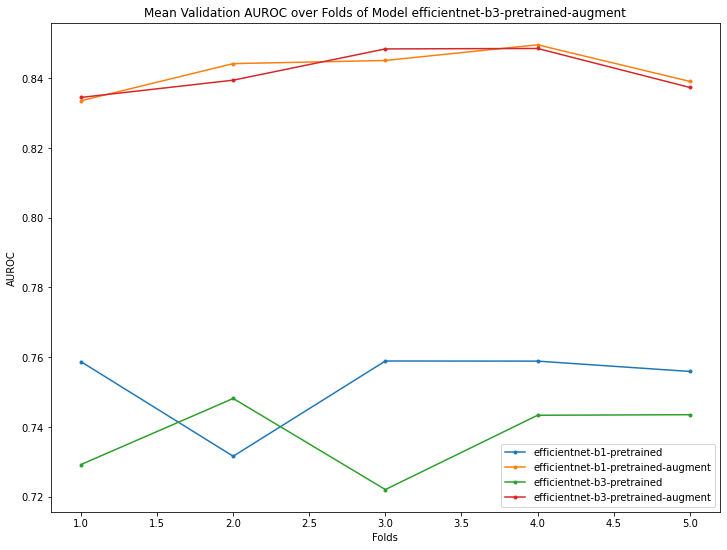

In [59]:
plt.figure(figsize=(12,9))
for j in range(4):
    plt.plot(range(1, epochs+1), aurocs_mean[j], label=names[j], marker=".")
plt.xlabel("Folds")
plt.ylabel("AUROC")
plt.legend()
plt.title(f"Mean Validation AUROC over Folds of Model {names[j]}")

